# Particle Categorical

In [1]:
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten, Reshape, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

import os
import os.path as osp
import sys

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2

from utils.tf_sinkhorn import sinkhorn_knopp_tf_scaling_stabilized_class, ground_distance_tf_nograd

import pandas
import matplotlib.pyplot as plt

import h5py

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

### Define VAE

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

In [4]:
# path to file
fn_sig =  '/mnt/f/signal_processed.h5'
fn_bg =  '/mnt/f/background_processed.h5'

In [5]:
# Option 1: Load everything into memory
df_sig = pandas.read_hdf(fn_sig,stop=100000)
df_bg = pandas.read_hdf(fn_bg,stop=1000000)
print(df_bg.shape)
print(df_sig.shape)
print("Memory in GB:",sum(df_sig.memory_usage(deep=True)) / (1024**3)+sum(df_bg.memory_usage(deep=True)) / (1024**3))

(504219, 300)
(74461, 300)
Memory in GB: 1.2977620959281921


In [6]:
sig_data = df_sig.values.reshape((-1,100,3))
bg_data = df_bg.values.reshape((-1,100,3))

HT_sig = np.sum(sig_data[:,:,0],axis=-1)
sig_data[:,:,0] = sig_data[:,:,0]/HT_sig[:,None]

HT_bg = np.sum(bg_data[:,:,0],axis=-1)
bg_data[:,:,0] = bg_data[:,:,0]/HT_bg[:,None]

sig_input = np.zeros((len(sig_data),100,4))
sig_input[:,:,:2] = sig_data[:,:,:2]
sig_input[:,:,2] = np.cos(sig_data[:,:,-1])
sig_input[:,:,3] = np.sin(sig_data[:,:,-1])

bg_input = np.zeros((len(bg_data),100,4))
bg_input[:,:,:2] = bg_data[:,:,:2]
bg_input[:,:,2] = np.cos(bg_data[:,:,-1])
bg_input[:,:,3] = np.sin(bg_data[:,:,-1])

labels = np.append(np.zeros(len(bg_input)),np.ones(len(bg_input)),axis=0)
data_x = np.append(bg_input,sig_input,axis=0)
data_y = np.append(bg_data,sig_data,axis=0)
perms = np.random.permutation(len(data_x))
labels = labels[perms]
data_x = data_x[perms]
data_y = data_y[perms]

train_labels = labels[:500000]
valid_labels = labels[500000:]
train_x = data_x[:500000]
train_y = data_y[:500000]
valid_x = data_x[500000:]
valid_y = data_y[500000:]

In [7]:
from tensorflow.python.keras.engine.training import enable_multi_worker

loss_tracker = keras.metrics.Mean(name="loss")
recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
KL_loss_tracker = keras.metrics.Mean(name="KL_loss")
KL_bern_loss_tracker = keras.metrics.Mean(name="KL_bern_loss")
val_loss_tracker = keras.metrics.Mean(name="val_loss")
val_recon_loss_tracker = keras.metrics.Mean(name="val_recon_loss")
val_KL_loss_tracker = keras.metrics.Mean(name="val_KL_loss")
val_KL_bern_loss_tracker = keras.metrics.Mean(name="val_KL_bern_loss")

class betaVAEModel(keras.Model):

    def betaVAE_compile(self,
                optimizer='rmsprop',
                loss=None,
                metrics=None,
                loss_weights=None,
                sample_weight_mode=None,
                weighted_metrics=None,
                recon_loss=None,
                KL_loss=None,
                KL_loss_bern=None,
                **kwargs):

        self.compile(optimizer=optimizer,
                    #loss=loss,
                    metrics=metrics,
                    loss_weights=loss_weights,
                    sample_weight_mode=sample_weight_mode,
                    weighted_metrics=weighted_metrics,
                    **kwargs)
        self.recon_loss = recon_loss
        self.KL_loss = KL_loss
        self.KL_loss_bern = KL_loss_bern
        self.beta = tf.Variable(1.,trainable=False, name="beta")
        self.alpha = tf.Variable(1.,trainable=False, name="alpha")



    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred ,z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid, z_bern = self(x, training=True)  # Forward pass
            # Compute our own loss
            recon_loss = self.recon_loss(y, y_pred)
            KL_loss = self.KL_loss(z_mean, z_log_var)
            KL_loss_bern = self.KL_loss_bern(alpha_bern, z_bern)

            loss = recon_loss/(tf.square(self.beta)) + KL_loss + self.alpha*KL_loss_bern


        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        recon_loss_tracker.update_state(recon_loss)
        KL_loss_tracker.update_state(KL_loss)
        KL_bern_loss_tracker.update_state(KL_loss_bern)

        return {"loss": loss_tracker.result(),
                "recon_loss": recon_loss_tracker.result(),
                "KL loss": KL_loss_tracker.result(),
                "KL bern loss": KL_bern_loss_tracker.result(),
                "beta": self.beta,
                "alpha": self.alpha}

    @tf.function
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred ,z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid, z_bern = self(x, training=False)  # Forward pass
        # Compute our own loss
        recon_loss = self.recon_loss(y, y_pred)
        KL_loss = self.KL_loss(z_mean, z_log_var)
        KL_loss_bern = self.KL_loss_bern(alpha_bern, z_bern)

        val_loss_tracker.update_state(recon_loss/tf.square(self.beta) + KL_loss + self.alpha*KL_loss_bern)
        val_recon_loss_tracker.update_state(recon_loss)
        val_KL_loss_tracker.update_state(KL_loss)
        val_KL_bern_loss_tracker.update_state(KL_loss_bern)

        return {"val_loss": val_loss_tracker.result(),
                "val_recon_loss": val_recon_loss_tracker.result(),
                "val_KL loss": val_KL_loss_tracker.result(),
                "val_KL bern loss": val_KL_bern_loss_tracker.result(),
                "beta": self.beta,
                "alpha": self.alpha}

class reset_metrics(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        loss_tracker.reset_states()
        recon_loss_tracker.reset_states()
        KL_loss_tracker.reset_states()
        KL_bern_loss_tracker.reset_states()
        val_loss_tracker.reset_states()
        val_recon_loss_tracker.reset_states()
        val_KL_loss_tracker.reset_states()
        val_KL_bern_loss_tracker.reset_states()

In [79]:
np.log(1.01)/0.01

0.9950330853168092

In [8]:
# https://arxiv.org/pdf/1611.00712.pdf

def build_and_compile_annealing_vae(encoder_conv_layers = [256,256,256,256],
                                    dense_size = 256,
                                    decoder = [512,256,256,256],
                                    verbose=0,dropout=0,
                                    latent_dim = 128,
                                    optimizer=keras.optimizers.Adam(),
                                    num_particles_out = 50,
                                    sinkhorn_reg = 0.01,
                                    numItermax = 20,
                                    stopThr=1e-3,
                                    adaptive_min = 0.01,
                                    cat_dim = 1,
                                    numIter=5,
                                    numItermaxinner = 40,
                                    tau = 1e3):
    
    temp = 0.3
    EPSILON = 1e-6
    #renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
    renorm_clipping = None
    momentum = 0.999
    
    def sampling_gauss(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def sampling_bern(theta):

        batch = K.shape(theta)[0]
        dim = K.int_shape(theta)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
        #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
        return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp
    
    num_particles = 100
    
    #Encoder
    inputs = tf.keras.Input(shape=(num_particles,4,), name='inputs')

    layer = inputs

    for layer_size in encoder_conv_layers:
        layer = Conv1D(layer_size,1,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
    
    # Sum layer
    layer = tf.keras.backend.sum(layer,axis=1)

    # Dense layers 1
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)

    # Cat latent
    alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
    alpha_bern = keras.layers.ELU()(alpha_bern)
    alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


    z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
    z_bern_sigmoid = Activation('sigmoid')(z_bern)
    
    layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])

    # Dense layers 2
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
    layer = Dense(dense_size)(layer)
    layer = keras.layers.ReLU()(layer)
      
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid, z_bern], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    # Decoder
    latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
    latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
    layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
    #layer = latent_inputs
    
    for i, layer_size in enumerate(decoder):
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    layer = Dense(num_particles_out*4)(layer)

    layer = Reshape((num_particles_out,4))(layer)

    layer_pT = layer[:,:,0:1]
    layer_pT = tf.keras.layers.Softmax(axis=-2)(layer_pT)
    layer_eta = layer[:,:,1:2]
    layer_phi = tf.math.atan2(layer[:,:,3],layer[:,:,2])
    layer_phi = tf.expand_dims(layer_phi,axis=-1)
    decoded = tf.keras.layers.Concatenate()([layer_pT,layer_eta,layer_phi])
 

    decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder([encoder(inputs)[2], encoder(inputs)[4]])
    vae = betaVAEModel(inputs, [outputs,z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid, z_bern], name='CNN-VAE')

    def myfunc(alpha, x,temp=temp):
        #return (temp*alpha*K.pow(x,-temp-1)*K.pow(1-x,-temp-1))/K.square(alpha*K.pow(x,-temp) + K.pow(1-x,-temp))
        return K.log(temp) - temp*x + K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))
        #return K.log(alpha + EPSILON) - 2*K.log(1+alpha*K.exp(-temp*x ))



    # sinkhorn_knopp_tf_64_inst = sinkhorn_knopp_tf_64_class( sinkhorn_reg, numItermax=numItermax, stopThr=stopThr)   
    sinkhorn_knopp_tf_scaling_stabilized_inst = sinkhorn_knopp_tf_scaling_stabilized_class(1., sinkhorn_reg, numIter=numIter, numItermaxinner = numItermaxinner, stopThr=stopThr,dtype=tf.float64,verbose=False)  
    # sinkhorn_knopp_tf_scaling_stabilized_inst = sinkhorn_knopp_tf_stabilized_alt_class(sinkhorn_reg, numItermax=numItermax, stopThr=stopThr,dtype=tf.float64,verbose=False, tau_val = tau)  
  
# sink_64 = sinkhorn_knopp_tf_scaling_stabilized_class(1.,0.02,numIter=5,numItermaxinner=50,stopThr=1e-100,dtype=dtype,verbose=True)

    def return_return_loss(pt_outs, x_outs, pt_in, x_in):
        @tf.function
        @tf.custom_gradient
        def return_loss(pt_out, x_out):

            epsilon = np.float64(1e-10)
            ground_distance = ground_distance_tf_nograd(x_in,x_out)
            # match = sinkhorn_knopp_tf_64_inst(pt_in, pt_out, tf.stop_gradient(ground_distance))
            match = sinkhorn_knopp_tf_scaling_stabilized_inst(pt_in, pt_out, tf.stop_gradient(ground_distance))          
            recon_loss = tf.linalg.trace(tf.matmul(tf.stop_gradient(tf.cast(match,tf.float32)),ground_distance,transpose_b=True))
            
            def grad(dL):
                aones = tf.fill(tf.shape(pt_in),np.float64(1.))
                bones = tf.fill(tf.shape(pt_out),np.float64(1.))

                Mnew = tf.cast(tf.transpose(ground_distance,perm=[0,2,1]),tf.float64)

                T = tf.cast(tf.transpose(match,perm=[0,2,1]),tf.float64)
                Ttilde = T[:,:,:-1]

                L = T * Mnew
                Ltilde = L[:,:,:-1]

                D1 = tf.linalg.diag(tf.reduce_sum(T,axis=-1))
                D2 = tf.linalg.diag(1/(tf.reduce_sum(Ttilde,axis=-2) + np.float64(1e-100))) # Add epsilon to ensure invertibility

                H = D1 - tf.matmul(tf.matmul(Ttilde,D2),Ttilde,transpose_b=True) + epsilon* tf.eye(num_rows = tf.shape(bones)[-1],batch_shape = [tf.shape(bones)[0]],dtype=tf.float64) # Add small diagonal piece to make sure H is invertible in edge cases.

                f = - tf.reduce_sum(L,axis=-1) + tf.squeeze(tf.matmul(tf.matmul(Ttilde,D2),tf.expand_dims(tf.reduce_sum(Ltilde,axis=-2),-1)),axis=-1)
                g = tf.squeeze(tf.matmul(tf.linalg.inv(H),tf.expand_dims(f,-1)),axis=-1)

                grad_pT = g - bones*tf.expand_dims(tf.reduce_sum(g,axis=-1),-1)/tf.cast(tf.shape(bones)[1],tf.float64)
                
                grad_x_out = tf.gradients(recon_loss,x_out)[0]
                
                return [-tf.expand_dims(dL,-1) * tf.cast(grad_pT,tf.float32),
                        tf.expand_dims(tf.expand_dims(dL,-1),-1)*tf.cast(grad_x_out,tf.float32)]

            return recon_loss, grad
        return return_loss(pt_outs, x_outs)


    @tf.function
    def recon_loss(x, x_decoded_mean):
        pt_out = x_decoded_mean[:,:,0]
        x_out = x_decoded_mean[:,:,1:]
        pt_in = x[:,:,0]
        x_in = x[:,:,1:]
        return tf.reduce_mean(tf.square(return_return_loss(pt_out, x_out, pt_in, x_in)),axis=0)


    @tf.function
    def kl_loss(z_mean, z_log_var):
        return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))



    

    @tf.function
    def kl_loss_bern(alpha_bern, z_bern):
        a = tf.ones_like(alpha_bern)*0.15/(1-0.15)
        logalpha = tf.math.log(alpha_bern+EPSILON)
        loga = tf.math.log(a)
        expa = tf.math.exp(-temp*z_bern + loga)
        expalpha = tf.math.exp(-temp*z_bern + logalpha)

        kl_loss_bern = tf.reduce_sum(logalpha - loga + 2*tf.math.log(1 + expa+EPSILON) - 2*tf.math.log(1+expalpha+EPSILON),axis=-1)
        return tf.reduce_mean( kl_loss_bern)

    
    vae.betaVAE_compile(recon_loss=recon_loss,
                        KL_loss = kl_loss,
                        KL_loss_bern = kl_loss_bern,
                optimizer=optimizer,experimental_run_tf_function=False#,
                #metrics = [recon_loss,kl_loss(beta_input), kl_loss_bern(beta_input)]
               )
    
    vae.summary()
    
    return vae, encoder, decoder


class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data)),np.ones(len(data))])

In [83]:
prior = np.logspace(-3,np.log10(0.5),32)
def kl_loss_bern(alpha_bern, z_bern):
    temp = 0.3
    a = np.ones_like(alpha_bern)*prior/(1-prior)
    logalpha = np.log(alpha_bern)
    loga = np.log(a)
    expa = np.exp(-temp*z_bern + loga)
    expalpha = np.exp(-temp*z_bern + logalpha)

    kl_loss_bern = logalpha - loga + 2*np.log(1 + expa) - 2*np.log(1+expalpha)
    return kl_loss_bern

def kl_loss(z_mean, z_log_var):
    return -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)

In [81]:
prior

array([0.001     , 0.00122198, 0.00149323, 0.0018247 , 0.00222974,
       0.00272469, 0.00332952, 0.0040686 , 0.00497174, 0.00607536,
       0.00742396, 0.00907192, 0.01108569, 0.01354647, 0.01655349,
       0.02022801, 0.0247182 , 0.0302051 , 0.03690999, 0.04510321,
       0.05511515, 0.06734952, 0.08229967, 0.10056842, 0.12289244,
       0.15017191, 0.18350684, 0.22424141, 0.27401817, 0.3348443 ,
       0.40917252, 0.5       ])

In [82]:
prior/(1-prior)

array([0.001001  , 0.00122347, 0.00149546, 0.00182803, 0.00223472,
       0.00273214, 0.00334064, 0.00408522, 0.00499658, 0.00611249,
       0.00747949, 0.00915497, 0.01120996, 0.0137325 , 0.01683212,
       0.02064563, 0.02534467, 0.03114587, 0.03832454, 0.04723359,
       0.05833001, 0.07221304, 0.08968033, 0.1118133 , 0.14011102,
       0.17670858, 0.22475001, 0.28906081, 0.37744494, 0.50340739,
       0.69254144, 1.        ])

In [40]:
kl_loss_bern(0.17647,0.5)

-2.454263494544584e-06

In [46]:
kl_loss_bern(10,-3)

-1.7266865792125738

In [35]:
kl_loss_bern(1.,0.5)

0.7754944829889281

In [58]:
experiment_name = 'particle_32_cats_2'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001),
                                    encoder_conv_layers = [512,512,1024,1024],
                                    dense_size = 1024,
                                    decoder = [1024,1024,1024,1024],
                                    cat_dim = 32,
                                    numItermax = 200,
                                    numItermaxinner = 10,
                                    numIter=5,
                                    sinkhorn_reg = 0.1,
                                    stopThr=1e-3,
                                    adaptive_min = 0.1,
                                    tau=1e6)

Model: "CNN-VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 100, 512)     2560        inputs[0][0]                     
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 100, 512)     0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 512)     262656      re_lu_12[0][0]                   
____________________________________________________________________________________________

In [59]:
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
#     phis = [jet.phi for jet in jets]
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis

In [101]:
vae.load_weights('/mnt/c/Users/Jack/repos/EMD-VAE/data/particle_32_cats_2/model_weights_00.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

In [102]:
_, z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid, z_bern = outs_array[0]
p_bern = alpha_bern / (1 + alpha_bern)

KL_bern=kl_loss_bern(alpha_bern, z_bern)
bernsort_means = np.flip(np.argsort(np.mean(KL_bern,axis=0)))

log_var = outs_array[0][2]
log_var_means = np.mean(log_var,axis=0)
means = outs_array[0][1]
mean_means = np.sqrt(np.mean(np.square(means),axis=0))
order = np.argsort(log_var_means)

In [98]:
thresh = 0.01
tagged = np.logical_and(z_bern[:,bernsort_means[0]] < thresh, z_bern[:,bernsort_means[1]] < thresh)
print(np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1000

In [64]:
for i in range(32):
    tagged = z_bern[:,bernsort_means[i]] < 0.5
    print(i, np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

0 0.14154912150457807 0.1274
1 0.14562512747297574 0.1274
2 0.12338568935427574 0.1274
3 0.13179033356024505 0.1274
4 0.130465644520159 0.1274
5 0.1259073143495254 0.1274
6 0.12934413378625556 0.1274
7 0.12565229332600933 0.1274
8 0.1286182413981431 0.1274
9 0.12915334352843041 0.1274
10 0.12738767823513586 0.1274
11 0.12850752338348922 0.1274
12 0.12744160633793197 0.1274
13 0.12464358452138492 0.1274
14 0.12604152889829387 0.1274
15 0.12929106931474418 0.1274
16 0.1271078180889116 0.1274
17 0.12974312165862564 0.1274
18 0.12902806652806653 0.1274
19 0.12885662431941924 0.1274
20 0.12821839824039333 0.1274
21 0.12433392539964476 0.1274
22 0.12714249168585315 0.1274
23 0.12522545735635146 0.1274
24 0.12461890243902439 0.1274
25 0.12493709109209863 0.1274
26 0.12304418575541369 0.1274
27 0.1264569494924176 0.1274
28 0.12506303580433686 0.1274
29 0.1276806743522995 0.1274
30 0.12878316104122556 0.1274
31 0.12786640079760717 0.1274


In [18]:
for i in range(20):
    tagged = z_bern[:,bernsort_means[i]] > 0.5
    print(i, np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

0 0.1008714596949891 0.1292
1 0.11163714111178986 0.1292
2 0.12171581769436997 0.1292
3 0.1282051282051282 0.1292
4 0.12978030919446704 0.1292
5 0.12907830342577487 0.1292
6 0.1300219983790668 0.1292
7 0.12919975565058034 0.1292
8 0.12837218772269166 0.1292
9 0.1296541874936244 0.1292
10 0.12908163265306122 0.1292
11 0.12934815872692032 0.1292
12 0.12908163265306122 0.1292
13 0.12842727550708388 0.1292
14 0.128590411939078 0.1292
15 0.12998568214358763 0.1292
16 0.12846193152784874 0.1292
17 0.12877859477124182 0.1292
18 0.12943461813720478 0.1292
19 0.12854364957527378 0.1292


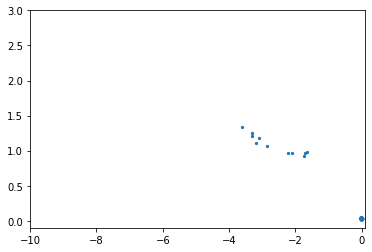

In [99]:
plt.scatter(log_var_means/np.log(10.),mean_means,s=5.)
plt.xlim([-10.,0.1])
plt.ylim([-0.1,3])
plt.show()

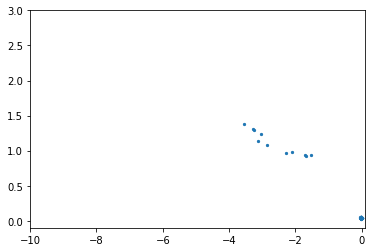

In [75]:
plt.scatter(log_var_means/np.log(10.),mean_means,s=5.)
plt.xlim([-10.,0.1])
plt.ylim([-0.1,3])
plt.show()

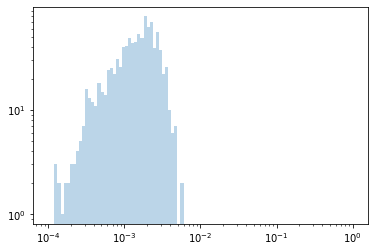

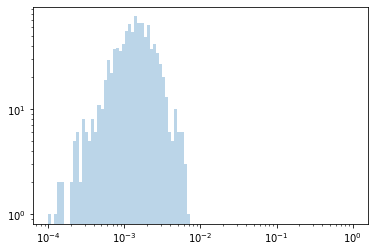

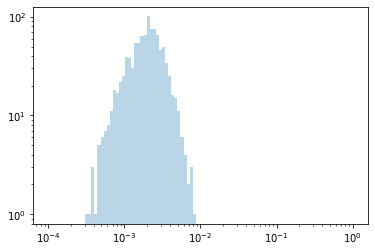

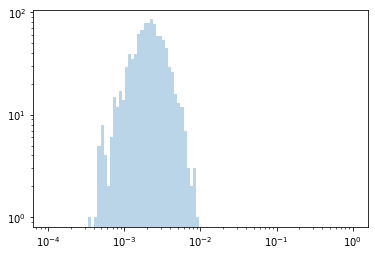

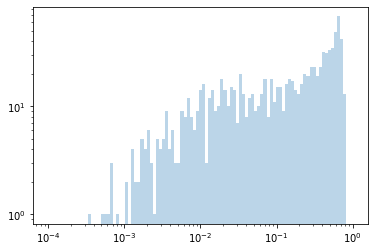

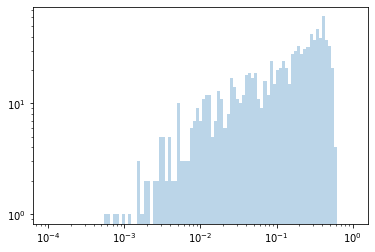

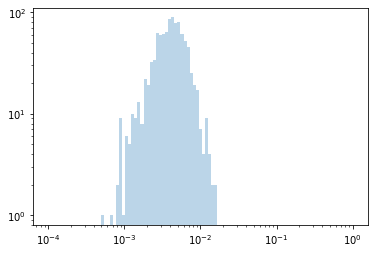

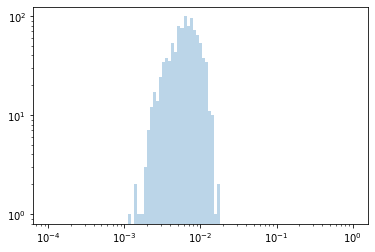

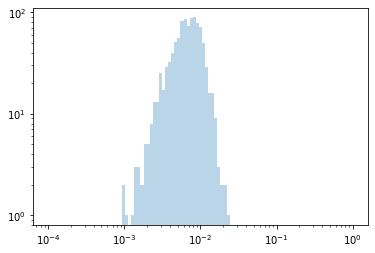

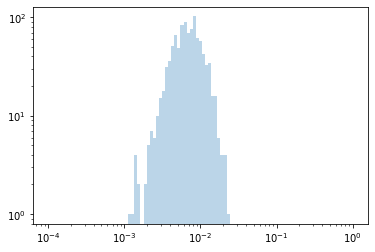

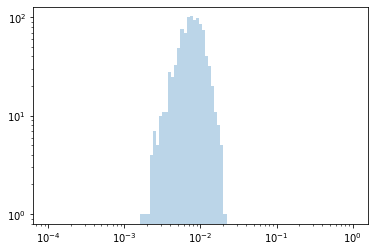

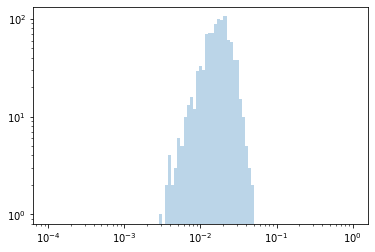

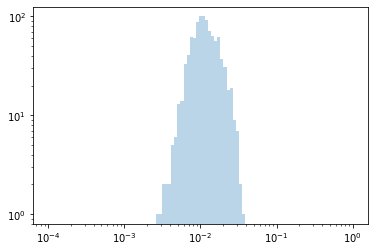

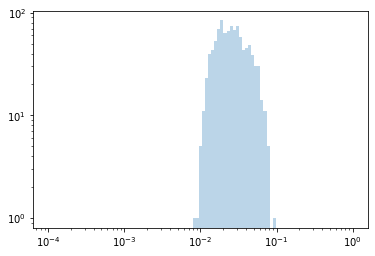

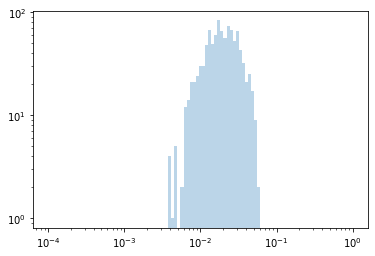

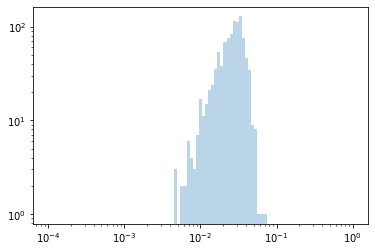

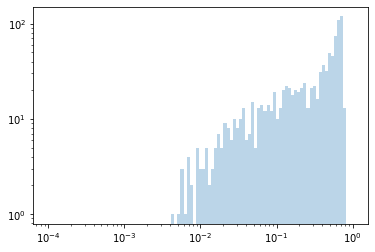

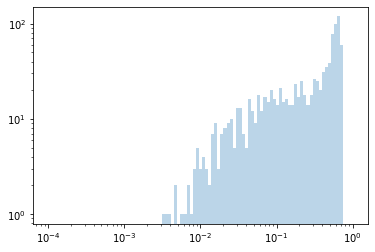

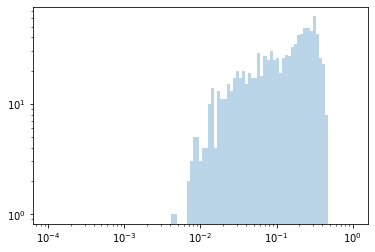

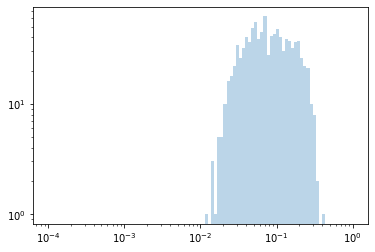

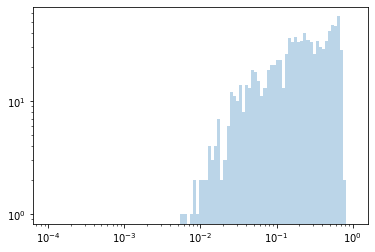

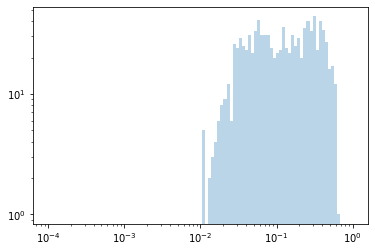

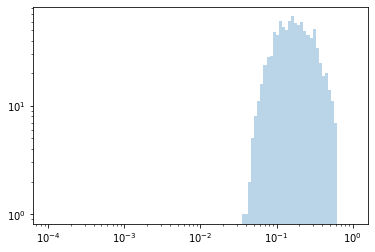

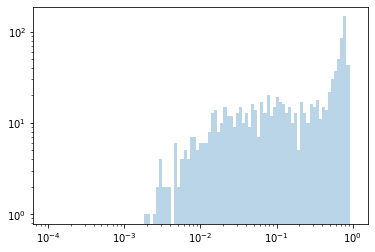

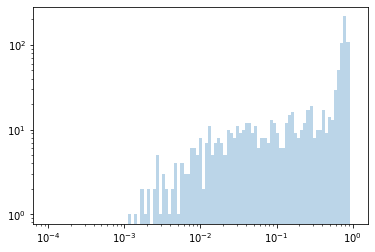

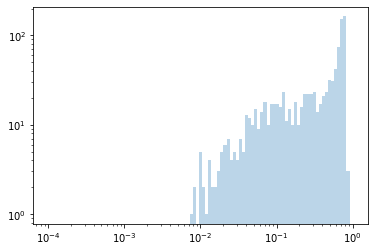

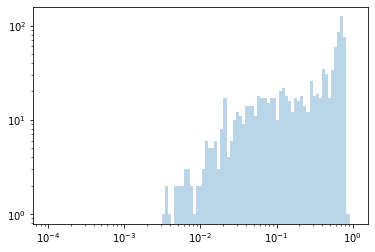

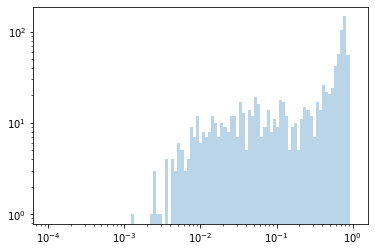

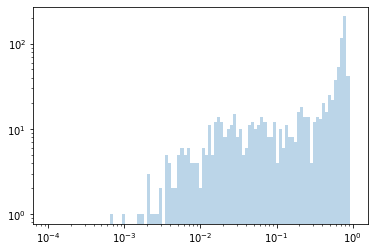

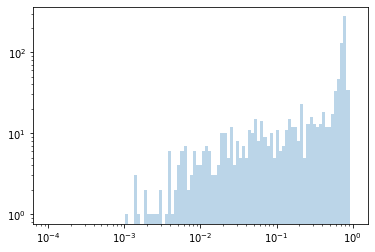

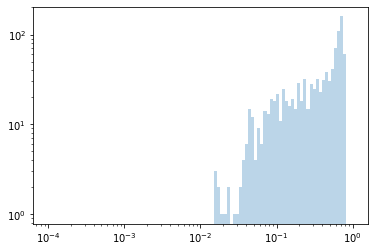

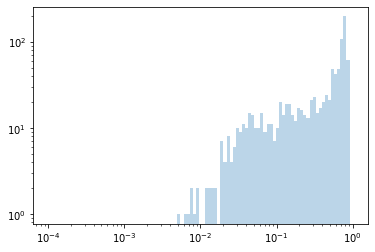

In [104]:
# KL_bern=calc_kl_loss_bern(alpha_bern)
# bernsort_means = np.flip(np.argsort(np.mean(KL_bern,axis=0)))
for i in range(32):
#for i in bernsort_means[:32]:
    #print(i)
    plt.hist(p_bern[:,i],
             bins = np.logspace(-4,0,100),
             alpha=0.3)
    plt.semilogy()
    plt.semilogx()
    #plt.show()
    plt.show()

In [97]:
bernsort = np.flip(np.argsort(KL_bern[:,6]))

In [98]:
result = decoder.predict([z,z_bern])[0]

In [21]:
0.1/(1-0.1)

0.11111111111111112

In [22]:
0.1111/(1+0.111111)

0.09999000999900101

In [100]:
z_bern_2 = z_bern[0:1].copy()
z_bern_2[0,bernsort_means[3]] = 0.
result_2 = decoder.predict([z[0:1],z_bern_2])[0]

0.0 [0.9401903  0.08385415 0.2422439  0.08732764 0.12846628]
[9.9995637e-01 2.4628639e-04 6.1946750e-02 2.2526503e-05 2.0539403e-02]
[9.9999917e-01 4.1745093e-06 4.0256083e-03 7.5894127e-06 7.7296650e-01]


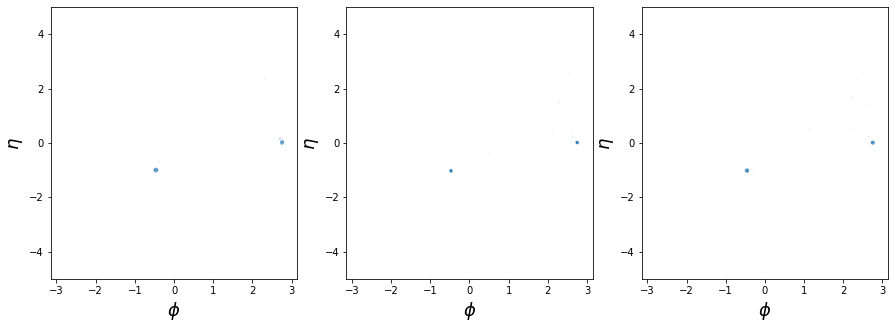

0.0 [0.93561554 0.09637762 0.23980485 0.09670223 0.13820234]
[1.0000000e+00 2.1030897e-05 9.6393371e-01 8.1989878e-01 4.4254363e-03]
[9.9544311e-01 2.2217673e-05 1.0112849e-04 3.0619800e-03 3.2973588e-03]


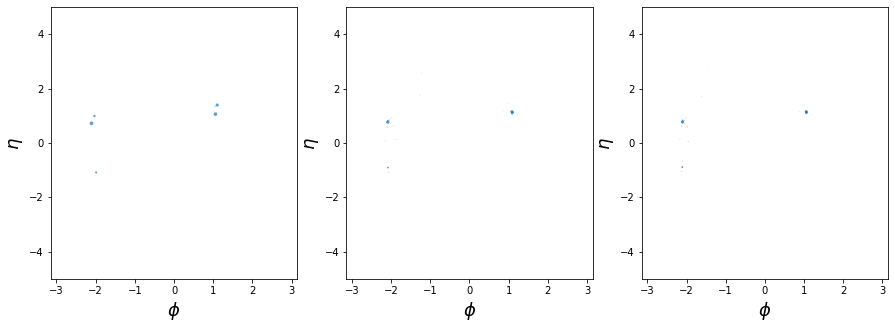

0.0 [0.9078276  0.09663204 0.22554304 0.07186177 0.12694599]
[9.9999660e-01 2.9163680e-06 4.6762460e-01 3.3810735e-04 8.1846118e-04]
[9.9999428e-01 2.5256813e-02 1.2903785e-05 2.4393499e-03 5.9810145e-06]


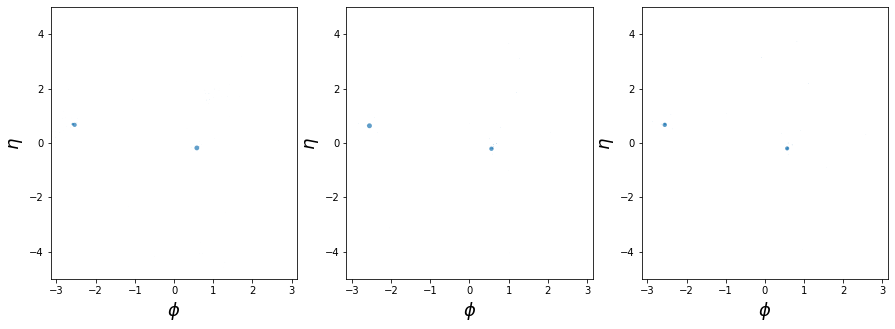

0.0 [0.94256973 0.07212371 0.19098264 0.06800923 0.11833372]
[9.9990940e-01 6.8493520e-08 9.9923813e-01 9.9680328e-01 7.1631700e-02]
[0.9999879  0.00102359 0.00101724 0.5444332  0.15806139]


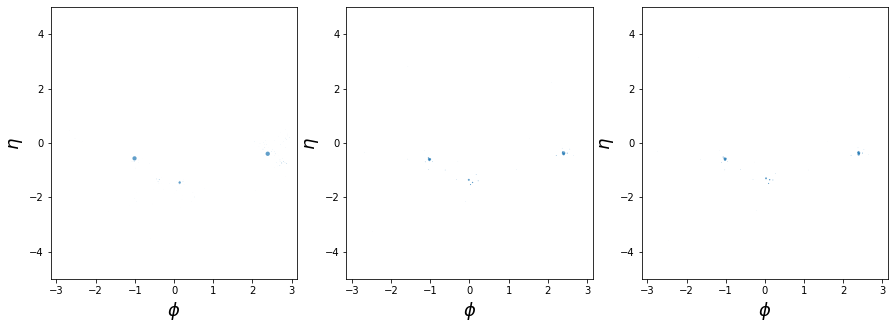

0.0 [0.94176996 0.08798765 0.22342856 0.07828155 0.13153712]
[9.9685502e-01 2.6500038e-05 7.6880968e-01 9.1568101e-05 1.8525124e-03]
[9.9994540e-01 4.7066897e-05 9.5975381e-01 1.3416111e-03 3.5658479e-04]


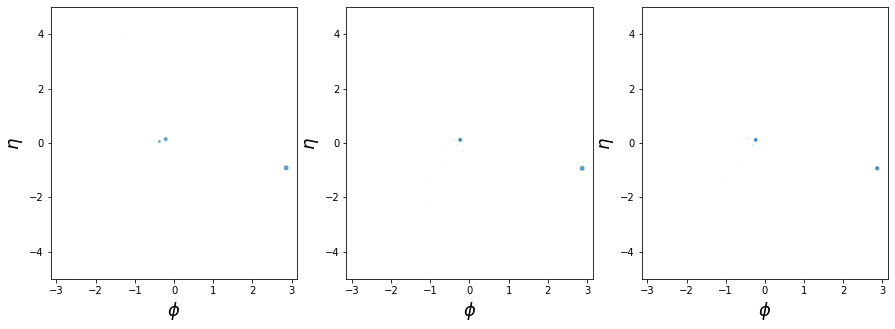

0.0 [0.93753594 0.08977594 0.2083797  0.10251321 0.17062925]
[9.9998444e-01 2.9883049e-06 4.0084497e-08 9.2701612e-06 2.7793554e-05]
[3.1191960e-01 8.4023774e-03 5.1573807e-01 9.7534830e-05 1.6808927e-01]


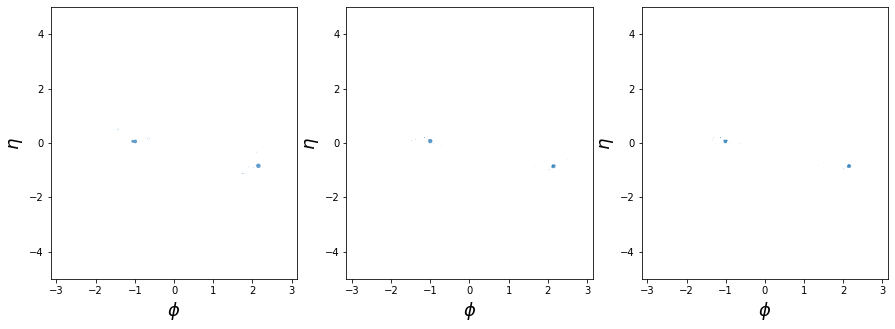

0.0 [0.94523346 0.07857561 0.25247696 0.08219006 0.14388567]
[9.9893254e-01 8.7803602e-04 3.3038259e-03 6.3176751e-03 5.4410160e-02]
[9.9998200e-01 5.5332675e-05 4.6941876e-02 3.2303810e-02 6.8250448e-02]


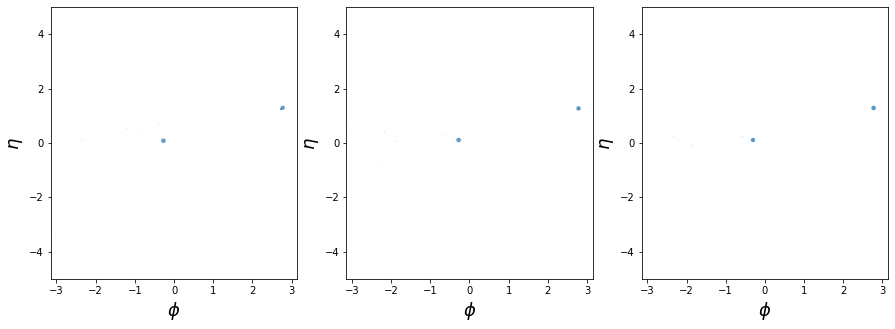

0.0 [0.909967   0.10080083 0.17428727 0.09268437 0.15458904]
[9.9978966e-01 1.2473136e-02 2.2318959e-04 5.4447651e-03 9.9890977e-01]
[3.9463225e-01 8.6864842e-05 7.5304508e-04 1.0605812e-02 4.7338992e-01]


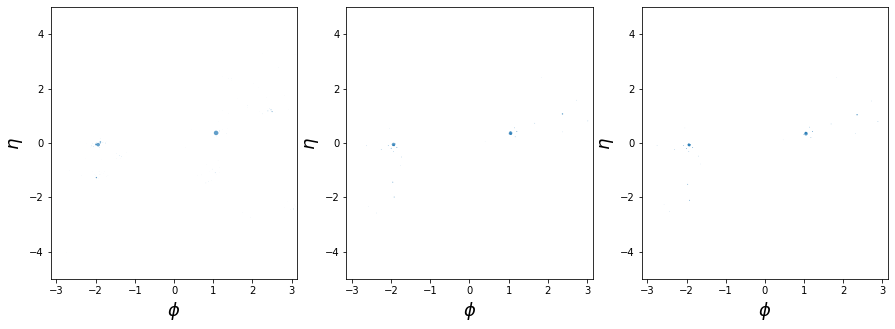

0.0 [0.89756733 0.09686377 0.24625665 0.07859318 0.12828541]
[9.9999142e-01 1.5769126e-08 3.1264317e-08 3.6469432e-05 4.3749921e-07]
[9.9718714e-01 5.8540332e-01 9.1362000e-04 1.9520681e-05 1.0038888e-06]


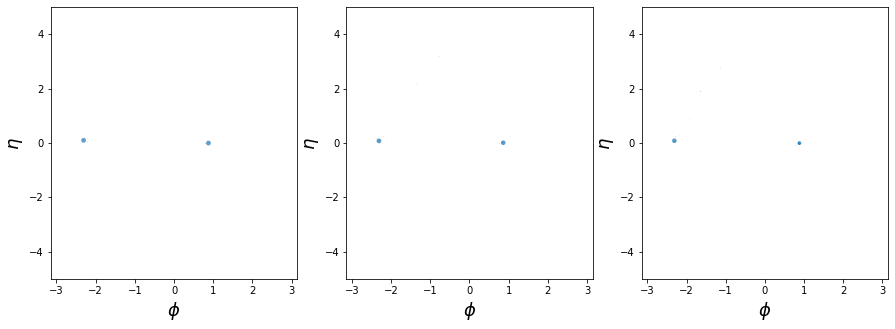

0.0 [0.92820823 0.08368202 0.23889394 0.08031231 0.13101731]
[5.5607635e-01 2.0736456e-04 7.8240561e-01 1.0930312e-01 2.6578444e-09]
[9.7015810e-01 1.9376030e-05 5.0774640e-01 6.9973171e-03 1.8652297e-08]


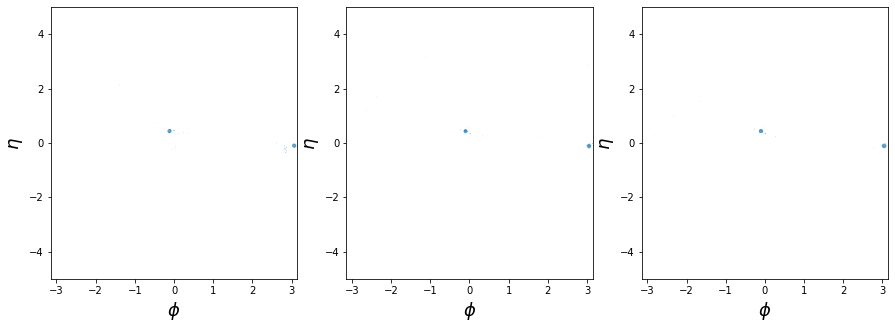

0.0 [0.93505895 0.08184158 0.15989955 0.0852215  0.10112991]
[9.9999988e-01 9.1754723e-01 5.7482089e-07 9.9999362e-01 5.6284666e-04]
[9.9937057e-01 4.4328808e-06 2.2721352e-07 9.9997926e-01 5.5268407e-04]


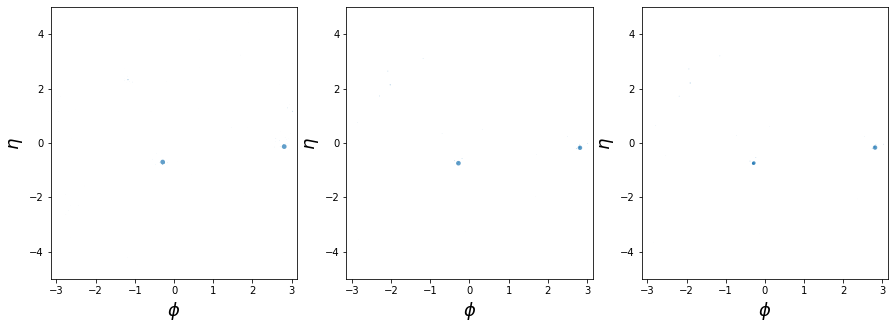

0.0 [0.9087123  0.10424525 0.18906496 0.08817377 0.1552901 ]
[9.9998844e-01 6.4373136e-02 9.1764331e-04 5.9020812e-07 6.9887712e-05]
[5.4466397e-01 3.4961104e-04 2.9351027e-05 1.5257916e-01 2.5667967e-05]


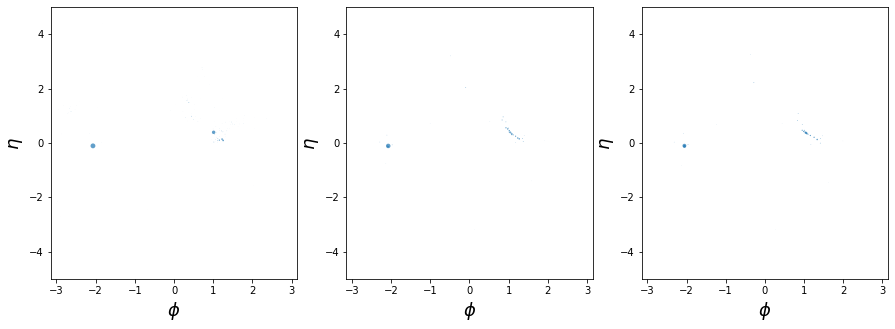

0.0 [0.9389612  0.07920174 0.2666154  0.12410752 0.1899251 ]
[9.9998271e-01 7.4717850e-06 1.7688379e-01 5.1950061e-05 1.3294518e-03]
[9.9914014e-01 4.0134788e-04 8.6061180e-01 1.6156197e-05 3.7164718e-02]


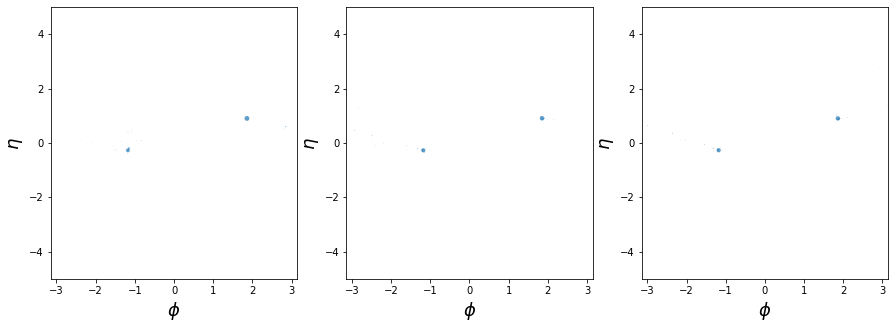

0.0 [0.92427725 0.07344575 0.1744857  0.07961736 0.10068774]
[9.6936673e-01 1.3309419e-03 2.6461482e-04 9.7347295e-01 2.5323033e-04]
[5.6491762e-01 3.0845031e-01 1.0184276e-04 2.8136969e-03 7.4762793e-05]


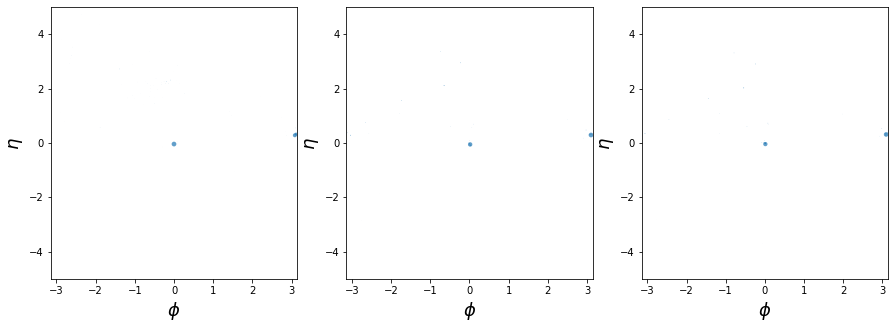

1.0 [0.9342274  0.09072188 0.18829297 0.07527364 0.09554198]
[1.0000000e+00 3.0052364e-03 9.7097993e-01 1.4436543e-03 2.7146454e-05]
[9.8320770e-01 5.4780245e-03 9.7720253e-01 6.8340290e-05 4.8387051e-04]


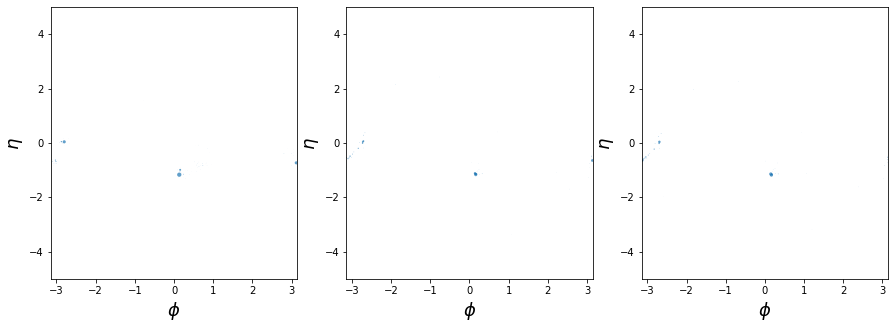

0.0 [0.9118594  0.11827048 0.19034106 0.09730387 0.14249434]
[9.9996567e-01 2.3574230e-05 7.0033878e-02 1.1648524e-06 9.9566233e-01]
[9.9958849e-01 6.1827450e-05 5.7982866e-06 2.5689602e-04 1.2642741e-03]


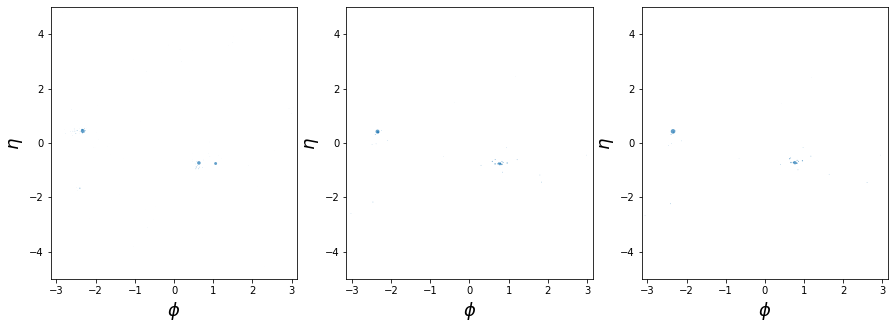

0.0 [0.9511695  0.06431785 0.258262   0.0655982  0.12105206]
[9.9999249e-01 1.2996793e-04 1.2856185e-02 1.8497009e-05 1.8621266e-02]
[9.9999976e-01 1.6120225e-02 6.8303943e-04 8.7882574e-05 2.6205045e-01]


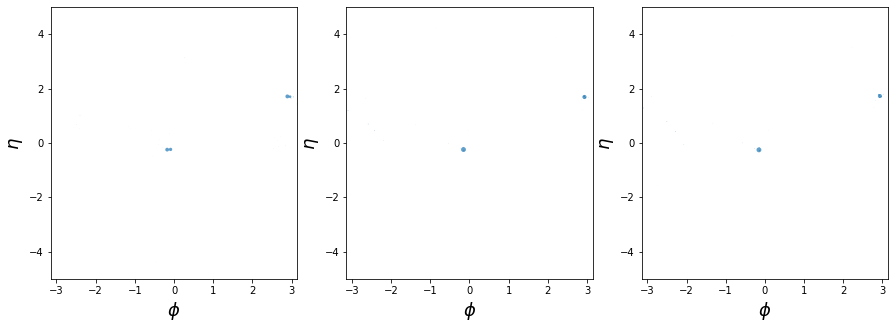

0.0 [0.91145283 0.09711878 0.18476973 0.05935538 0.16154328]
[9.9975282e-01 9.6566176e-01 1.9691493e-06 1.0902137e-02 3.6734343e-04]
[1.00000000e+00 2.58019567e-03 1.47770345e-02 1.97984562e-09
 2.51552463e-03]


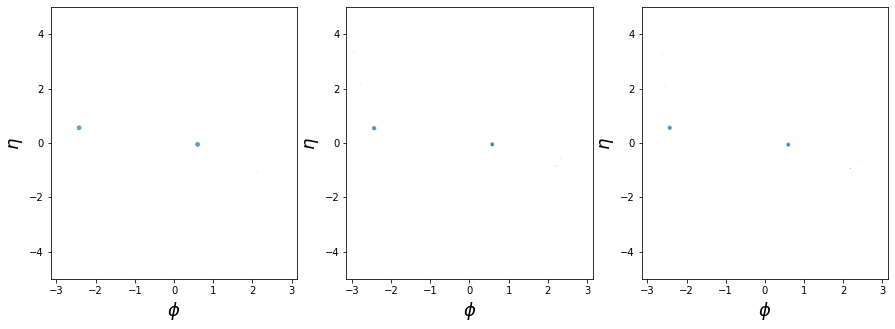

0.0 [0.9352913  0.09413358 0.14995904 0.06555064 0.1268778 ]
[9.9999940e-01 3.8282031e-01 3.6565512e-02 1.3524294e-04 2.6386023e-02]
[9.9999428e-01 2.9005527e-02 1.0477901e-03 1.3765693e-04 9.9411798e-01]


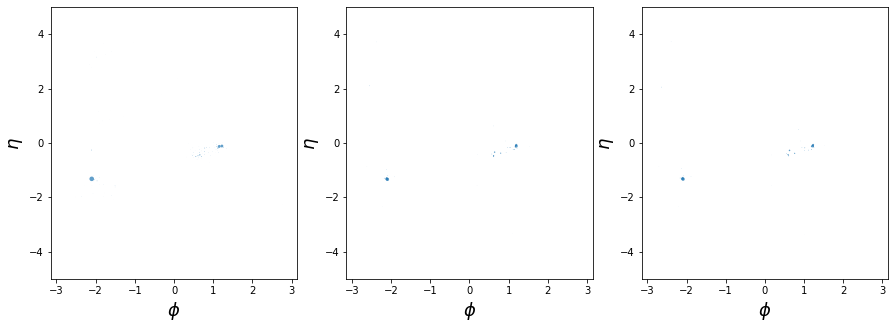

0.0 [0.93499184 0.07910722 0.14998841 0.08364122 0.12832409]
[1.0000000e+00 3.2904744e-04 5.9970130e-06 6.8014562e-03 5.0595600e-06]
[7.6713777e-01 1.7965577e-06 7.6326996e-02 2.1717191e-02 3.7234426e-03]


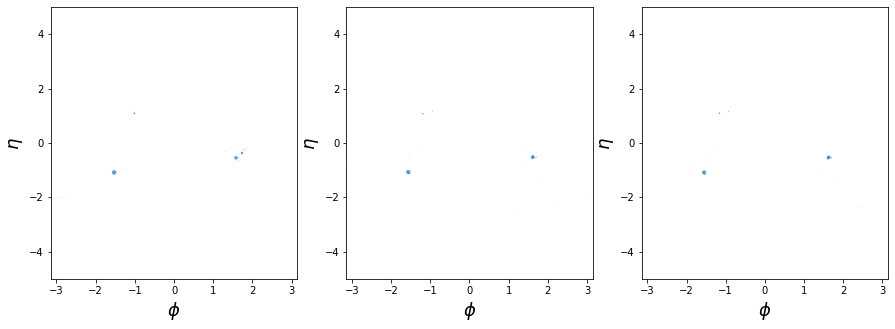

0.0 [0.93343705 0.07683275 0.24829368 0.11169518 0.1512606 ]
[9.9983764e-01 4.9737851e-06 2.9163182e-02 8.8527977e-02 2.8672814e-04]
[9.9999797e-01 2.0898819e-02 4.9330905e-05 8.0020130e-03 4.0065060e-13]


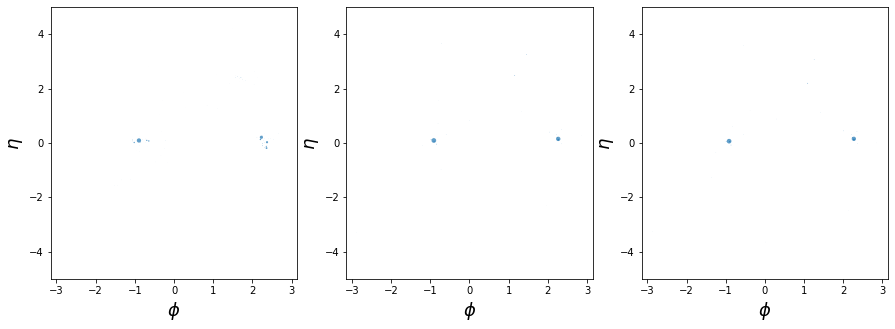

0.0 [0.9437948  0.07138591 0.24093944 0.05636713 0.12302031]
[9.9998617e-01 2.5218427e-03 9.2451024e-01 9.3961954e-03 5.8565001e-06]
[9.9999279e-01 1.5306473e-04 2.5251099e-01 6.8488717e-04 3.8963944e-02]


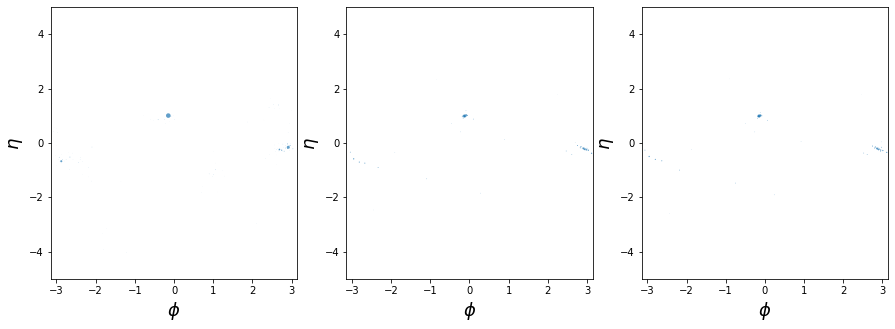

0.0 [0.94463575 0.07439165 0.19930863 0.07469366 0.14831477]
[0.9999958  0.01174578 0.97621197 0.00172117 0.01145059]
[1.0000000e+00 6.3580285e-07 1.5532970e-03 1.6940832e-03 5.4705193e-05]


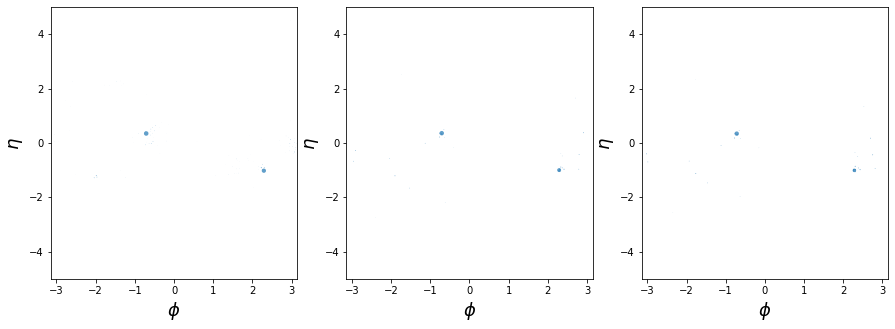

0.0 [0.9312286  0.06182975 0.15608957 0.06334486 0.09463625]
[9.9998492e-01 8.3068706e-05 1.2963742e-02 1.6117096e-04 1.3290942e-03]
[9.9932337e-01 3.8941129e-05 4.1709810e-02 2.0278724e-06 1.7413497e-04]


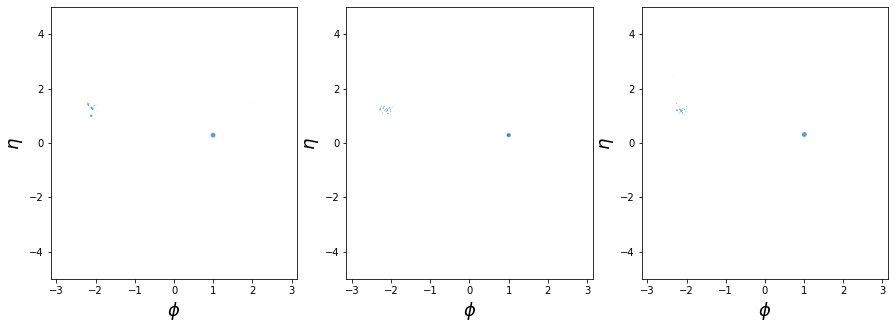

0.0 [0.9388519  0.09804719 0.2442285  0.08033535 0.15120713]
[0.9989137  0.00325713 0.00212705 0.00705069 0.1213654 ]
[1.0000000e+00 1.5419722e-03 9.4018877e-01 2.3331890e-05 7.1559995e-02]


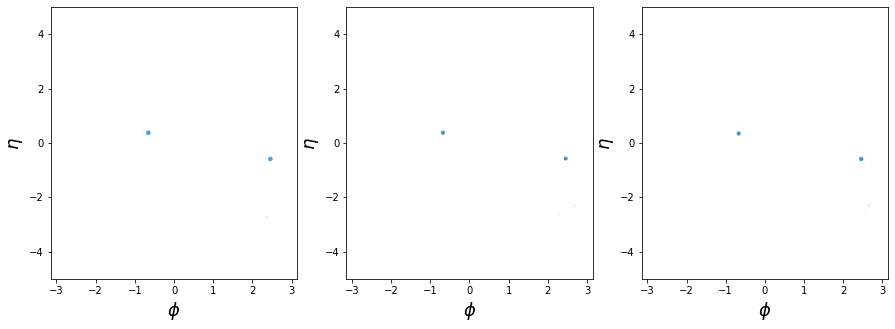

0.0 [0.9214634  0.14709285 0.21977484 0.06470411 0.16801275]
[9.9999982e-01 1.3499793e-01 3.8969457e-02 6.3881598e-06 1.9882202e-02]
[9.9998999e-01 7.0159328e-10 2.4549067e-02 7.9907652e-05 9.6152174e-01]


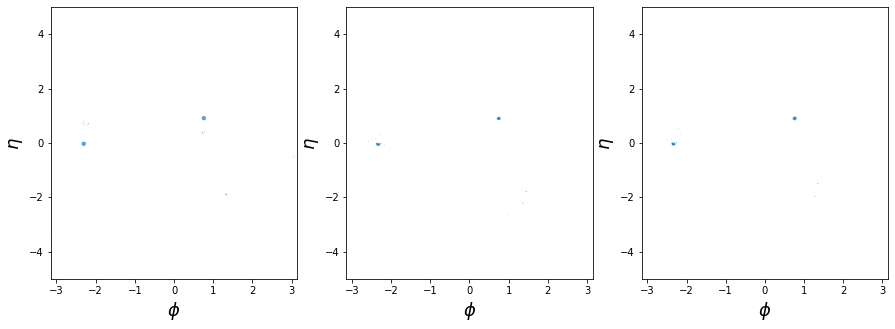

0.0 [0.9377825  0.06554507 0.10289929 0.05042244 0.07011127]
[4.0749788e-01 6.6131353e-04 3.8381034e-01 4.2190371e-07 1.3635561e-05]
[9.9847150e-01 2.3591363e-11 1.7926097e-04 7.8091318e-08 2.0065308e-03]


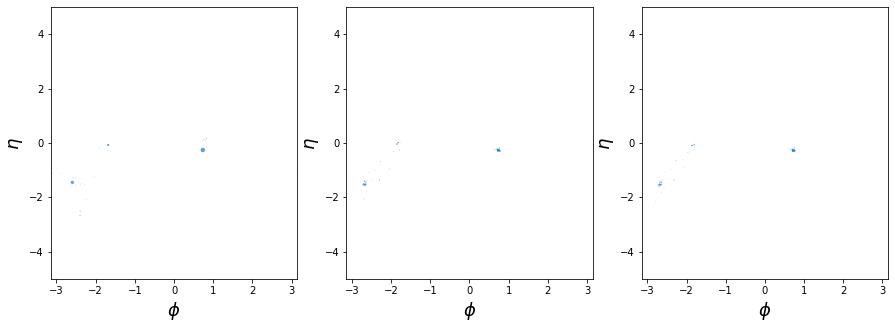

0.0 [0.9497675  0.08328763 0.2788542  0.07427577 0.09877696]
[9.9997556e-01 1.1907816e-03 4.9038631e-01 1.7167946e-07 9.9077213e-01]
[9.9999976e-01 9.1852125e-06 3.8180892e-06 1.1101961e-03 2.7788913e-01]


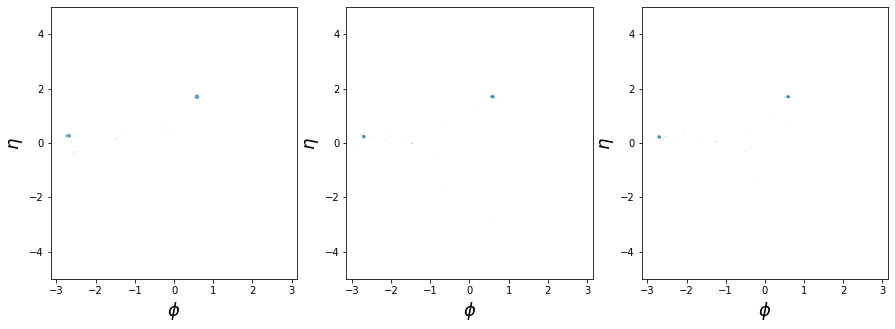

0.0 [0.9128505  0.09378074 0.21181367 0.10091397 0.14614825]
[3.45814526e-01 6.00285773e-07 1.84527993e-01 1.02496215e-05
 9.97298241e-01]
[9.9838793e-01 1.2693327e-05 2.6032329e-04 1.5197098e-03 3.6336243e-02]


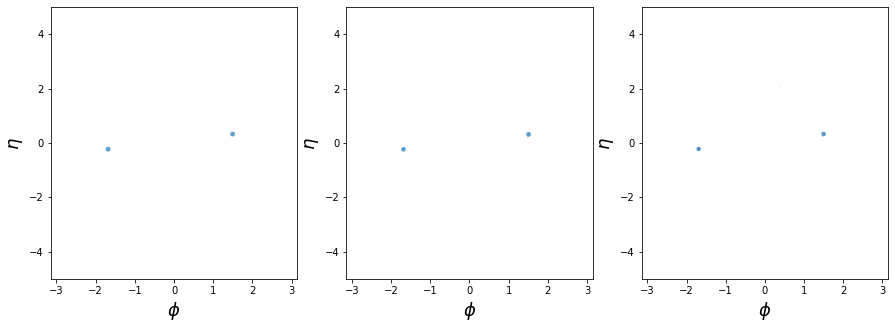

0.0 [0.92735195 0.09486474 0.19789067 0.06998648 0.07875108]
[9.9980170e-01 8.3540843e-05 1.5323396e-06 1.3554096e-04 7.2514602e-08]
[9.9999964e-01 7.8914134e-05 1.6476984e-05 1.9824207e-03 2.7990673e-06]


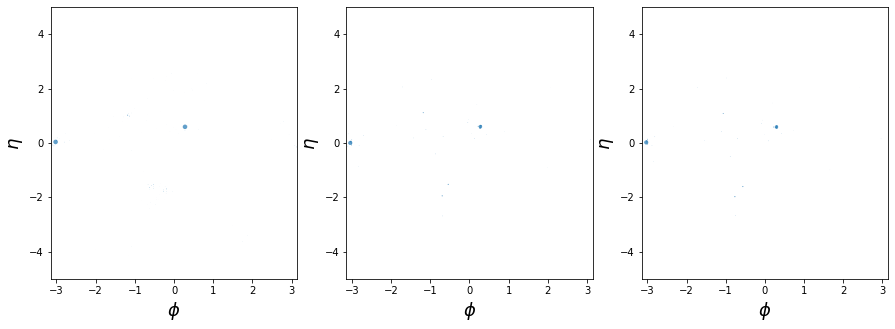

0.0 [0.92762893 0.06825131 0.23804112 0.07408832 0.1308149 ]
[9.9803460e-01 5.0356388e-03 9.3579561e-02 1.9822925e-05 1.0885383e-06]
[7.8445363e-01 3.0391453e-07 9.6984273e-01 3.3815140e-01 2.7050078e-03]


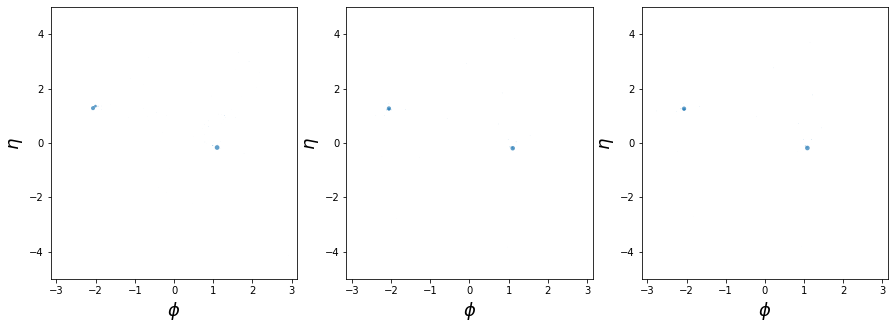

0.0 [0.91375476 0.10829204 0.16915968 0.0973703  0.15489109]
[9.9967074e-01 1.6364125e-05 1.4654696e-03 7.2491233e-08 2.4195492e-02]
[0.18193257 1.         0.0199894  0.01417819 0.00184754]


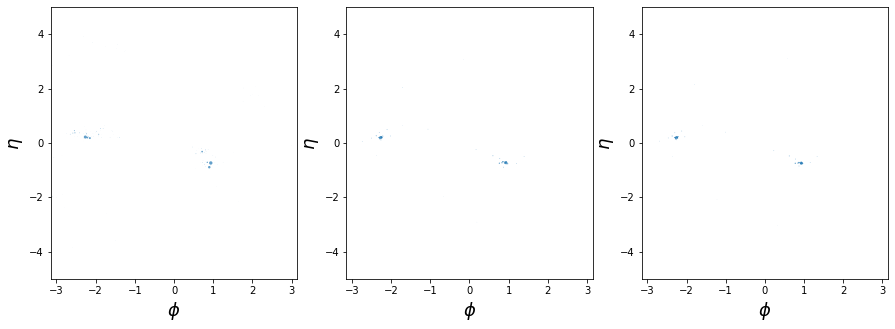

1.0 [0.93772465 0.08784083 0.26260582 0.08280316 0.18538128]
[9.9572241e-01 1.0476708e-03 2.3159385e-04 3.3486116e-01 9.9044251e-01]
[9.9998748e-01 1.1703819e-02 3.4158498e-02 6.4218407e-06 1.4957786e-04]


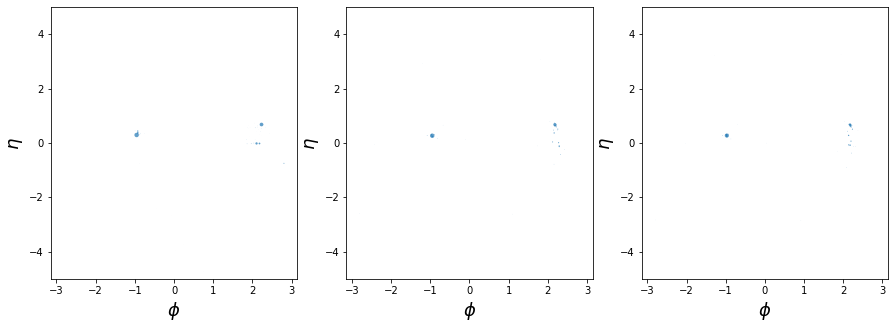

0.0 [0.91033655 0.0682274  0.22610791 0.07814891 0.09796093]
[9.3048239e-01 5.7819486e-04 8.5706642e-07 1.1226237e-03 1.5686005e-02]
[9.9999750e-01 4.0441038e-05 4.7623751e-05 9.5802885e-01 3.7648741e-05]


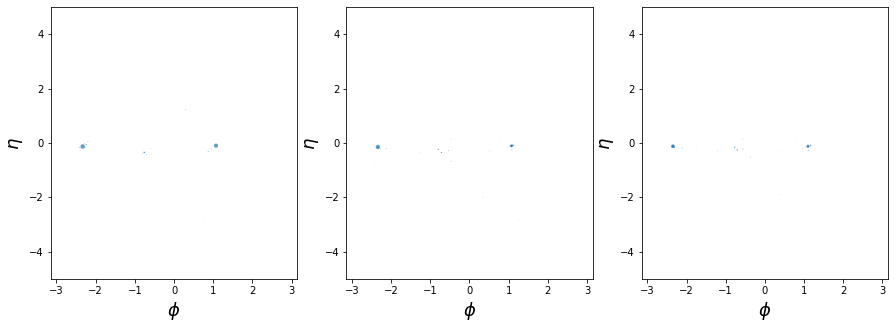

0.0 [0.93299675 0.06460889 0.20416513 0.11198415 0.10388201]
[4.1283172e-01 3.4186244e-04 3.2443327e-01 7.9194891e-01 8.1256032e-04]
[9.9997675e-01 1.7729402e-04 7.6863170e-04 6.7001283e-03 7.3273027e-06]


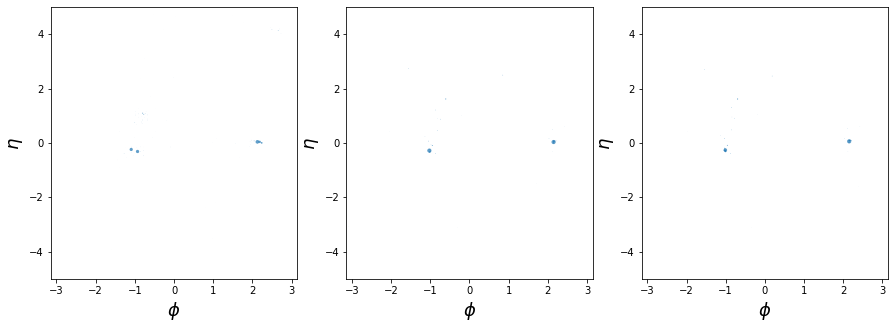

0.0 [0.9239475  0.09747684 0.15836538 0.07840554 0.09965147]
[9.9953806e-01 6.2927186e-01 3.1130910e-03 4.1375816e-02 1.6367028e-05]
[9.9999285e-01 7.0665598e-02 8.7433982e-01 2.1689408e-05 1.0098982e-01]


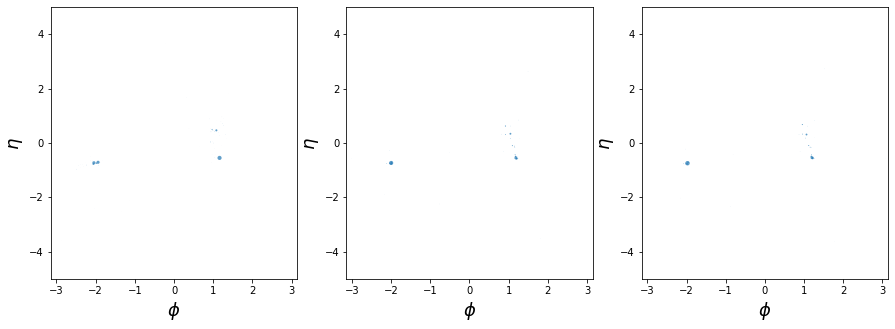

0.0 [0.91644883 0.08975783 0.16770253 0.05986441 0.11295898]
[9.9999344e-01 1.4011950e-05 3.5532773e-01 4.5069160e-06 9.8197567e-01]
[0.00065273 0.2822417  0.10579094 0.00658059 0.06876764]


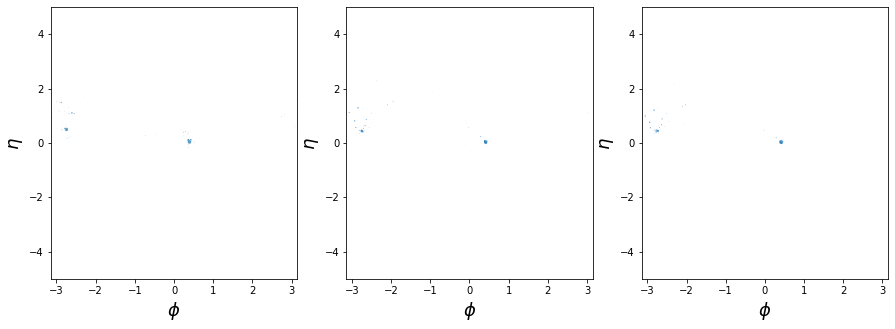

0.0 [0.920322   0.09512442 0.19395281 0.10784175 0.139025  ]
[0.05749536 0.00183654 0.0502995  0.53688    0.7291143 ]
[9.9993503e-01 3.3374965e-06 6.2393695e-02 1.8326908e-02 2.9474497e-04]


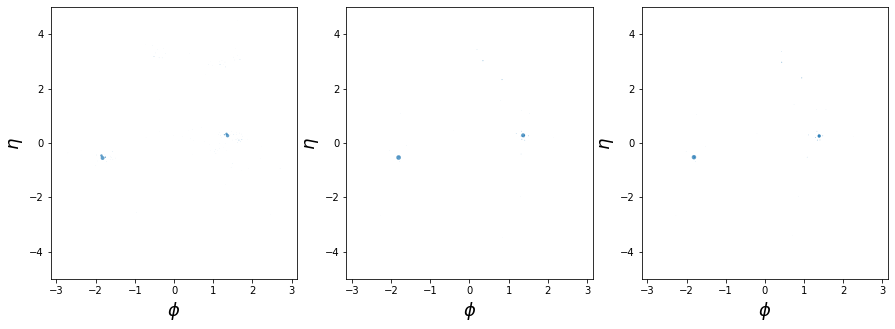

1.0 [0.9164419  0.10137983 0.16308586 0.08343628 0.11165877]
[9.9999785e-01 1.2519200e-05 1.7956285e-05 2.2892952e-02 4.8892680e-06]
[9.9983752e-01 4.4512237e-08 5.6045085e-02 3.8156995e-07 9.9803901e-01]


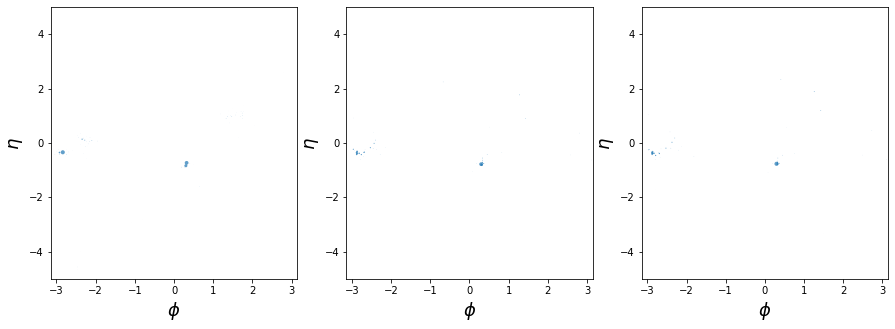

0.0 [0.9351295  0.10018843 0.21567093 0.10575146 0.1467499 ]
[9.5382202e-01 1.4969707e-04 1.4755279e-02 1.2924215e-07 8.3416700e-04]
[9.9954176e-01 2.9674649e-02 9.7680092e-04 4.7449797e-02 1.3776380e-01]


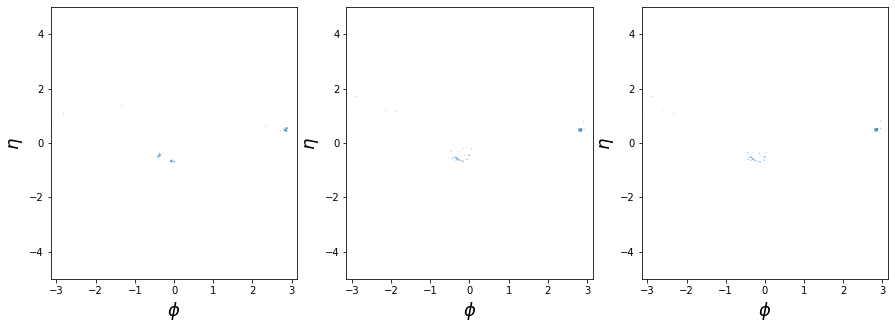

0.0 [0.9282643  0.05904312 0.18011767 0.06707665 0.10809427]
[9.8733819e-01 1.7991544e-05 9.8041922e-01 4.7733014e-05 3.4042865e-02]
[9.8742390e-01 4.5639119e-09 4.9155205e-02 3.7876427e-02 1.7705560e-04]


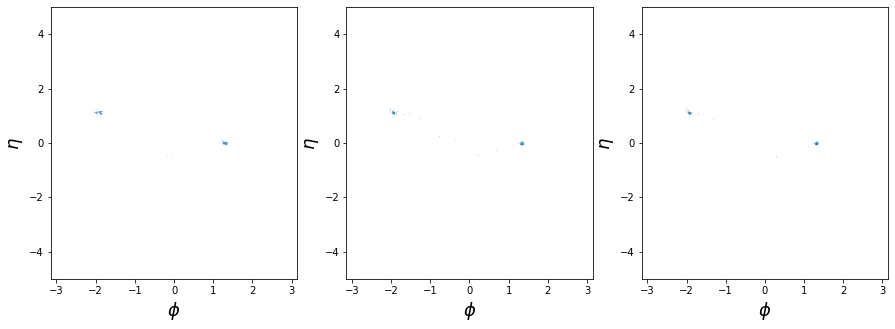

1.0 [0.91071475 0.08852836 0.17346804 0.07189345 0.12852174]
[6.3832420e-01 1.9246085e-05 5.6781337e-06 9.6201897e-04 7.3123638e-06]
[9.9986076e-01 4.5349598e-03 8.0897858e-05 1.2065172e-03 1.2820423e-02]


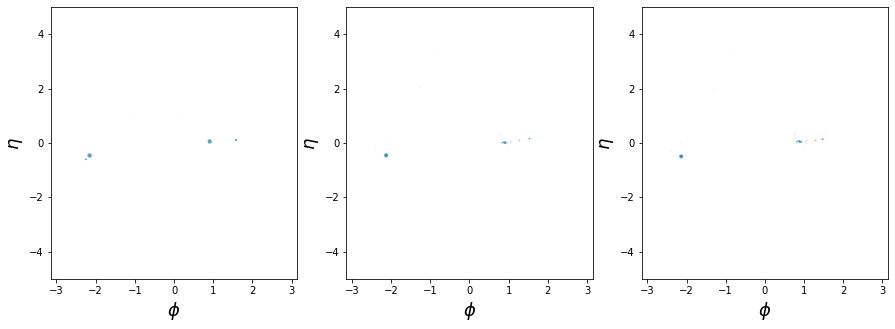

1.0 [0.949873   0.10322675 0.19408521 0.06854358 0.13322121]
[0.99835783 0.00664085 0.14079005 0.12187436 0.00102109]
[9.9651897e-01 5.5405362e-06 8.1278980e-03 3.9518032e-08 9.1909766e-03]


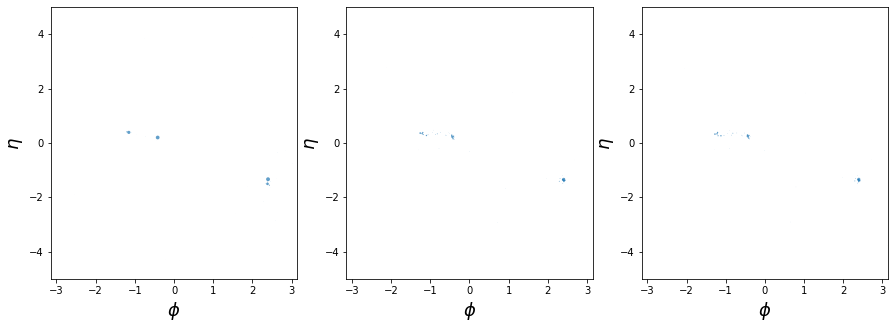

0.0 [0.9348734  0.08318719 0.13757312 0.08054506 0.07962833]
[8.3709204e-01 1.8473864e-03 7.7443272e-02 1.1001106e-05 9.1058057e-05]
[2.4897069e-02 9.1257652e-07 5.8244467e-02 1.9104064e-02 1.4856458e-04]


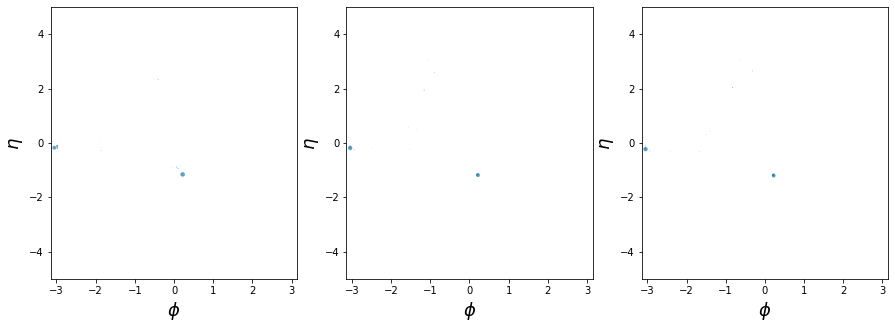

0.0 [0.92958057 0.10002766 0.17053083 0.09242021 0.15175746]
[9.96491909e-01 1.78556740e-02 1.46023035e-02 9.08831571e-05
 5.62926034e-05]
[9.9995536e-01 7.9694670e-01 6.7587338e-05 8.4236181e-06 1.9532442e-04]


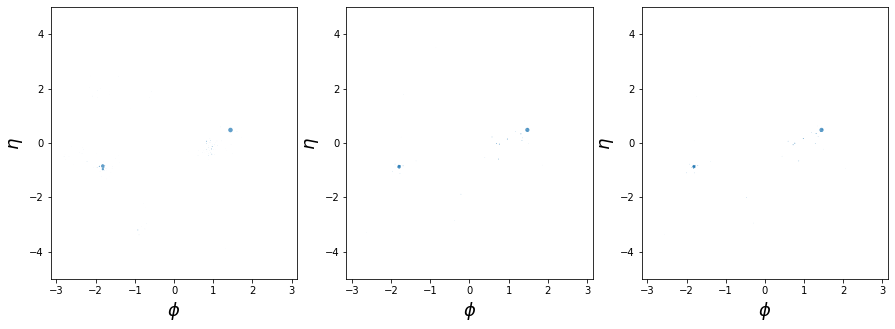

0.0 [0.93627346 0.08346396 0.15985344 0.06627846 0.09023236]
[9.99972939e-01 7.25667596e-01 3.07380148e-08 6.58373267e-07
 1.04186925e-04]
[1.0000000e+00 9.9346805e-01 2.5033136e-05 3.5456538e-05 8.7246358e-01]


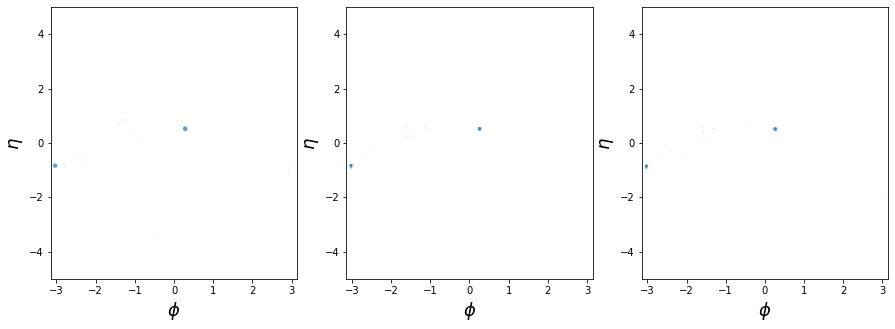

0.0 [0.9281524  0.1116011  0.23337075 0.05964604 0.09808749]
[9.9952912e-01 1.0894585e-04 1.0443628e-03 3.5417974e-03 4.3684756e-07]
[9.9999255e-01 2.2622362e-01 6.8482053e-01 8.1073294e-06 9.6672165e-01]


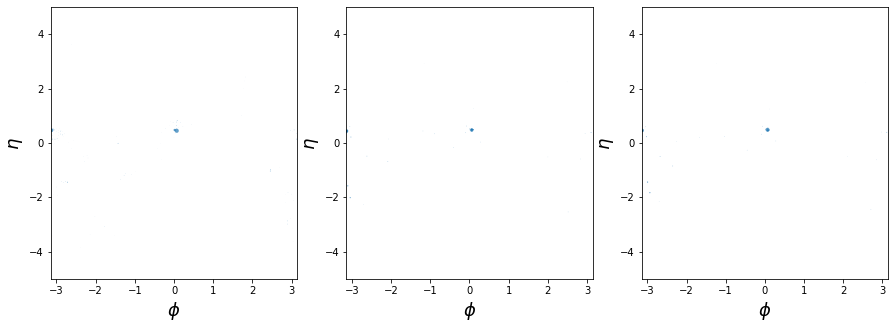

1.0 [0.9404302  0.07146937 0.22284274 0.0940173  0.13660613]
[9.9994874e-01 1.7629958e-06 7.8682739e-01 3.4547702e-05 5.6169361e-02]
[9.9884415e-01 5.4146964e-05 1.7154534e-06 8.5085630e-04 9.0117455e-03]


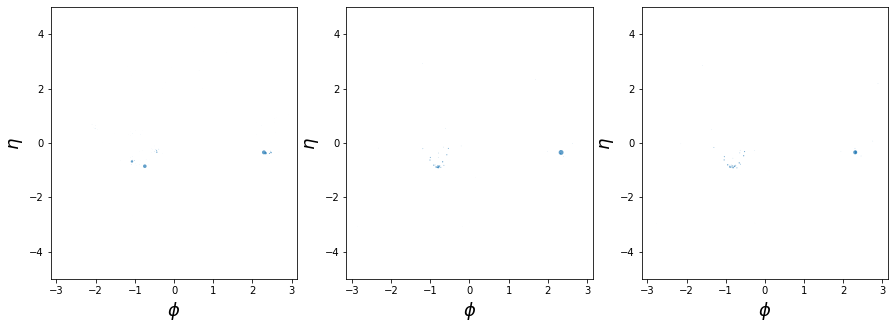

1.0 [0.91457593 0.08983006 0.20148459 0.08713119 0.11363307]
[9.0727389e-01 1.5700241e-09 5.6585282e-02 1.8767908e-01 9.6193078e-05]
[9.9999797e-01 2.1258771e-02 9.3683612e-01 3.5075020e-05 4.0144920e-03]


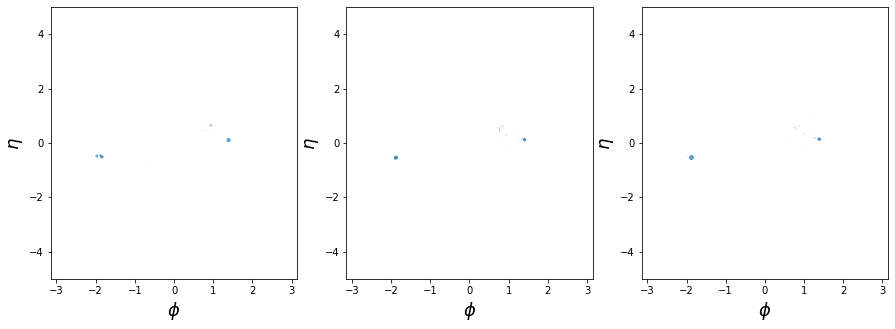

0.0 [0.9342725  0.09378896 0.21757323 0.08718836 0.16242956]
[9.9999976e-01 1.4075272e-05 1.3935102e-10 9.9999738e-01 4.9528509e-02]
[9.9999732e-01 1.8290222e-02 6.0978532e-04 6.6114997e-05 3.1135395e-01]


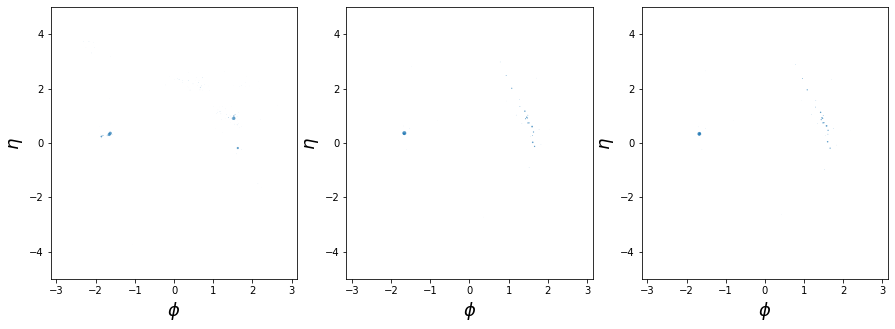

0.0 [0.931414   0.08159378 0.27311352 0.07902902 0.1564723 ]
[0.9998454  0.21027333 0.00283489 0.00583246 0.9282063 ]
[9.04648960e-01 3.70351493e-01 9.59390223e-01 1.20762976e-04
 3.61591578e-04]


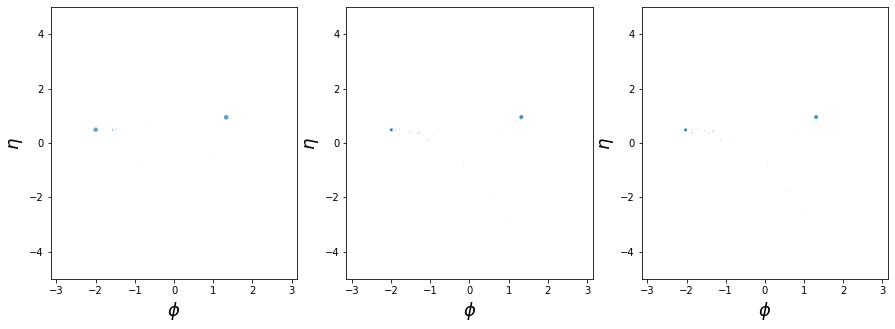

1.0 [0.93509185 0.0967513  0.27714694 0.09511942 0.14587775]
[9.9999917e-01 9.4355113e-07 9.6815825e-04 7.7231419e-01 4.1509330e-02]
[9.9601805e-01 1.3305202e-01 9.1895461e-04 5.6373830e-07 1.8278658e-03]


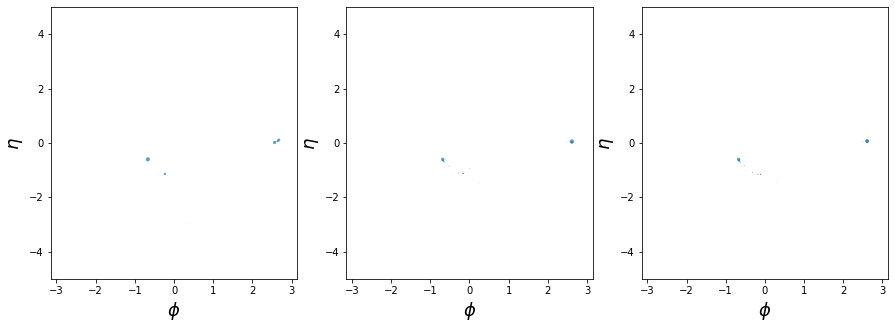

0.0 [0.9075726  0.1057372  0.22296536 0.07755128 0.12123617]
[9.9986243e-01 2.3704767e-04 1.5134515e-05 9.6764541e-01 9.8242235e-01]
[9.9986064e-01 2.8926730e-03 4.4324179e-07 3.4364473e-07 2.1690647e-07]


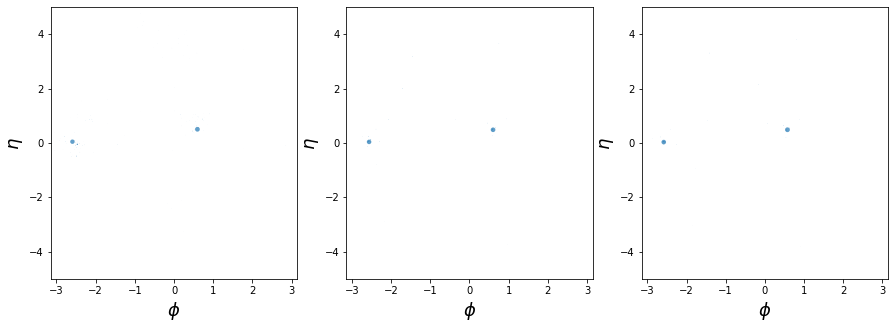

0.0 [0.9456818  0.05150327 0.29475215 0.08573361 0.11285102]
[9.9999964e-01 1.5158951e-03 9.9989307e-01 7.3466806e-09 1.3497531e-02]
[9.9817574e-01 1.1740970e-08 1.9273588e-01 1.0852986e-05 7.4846827e-07]


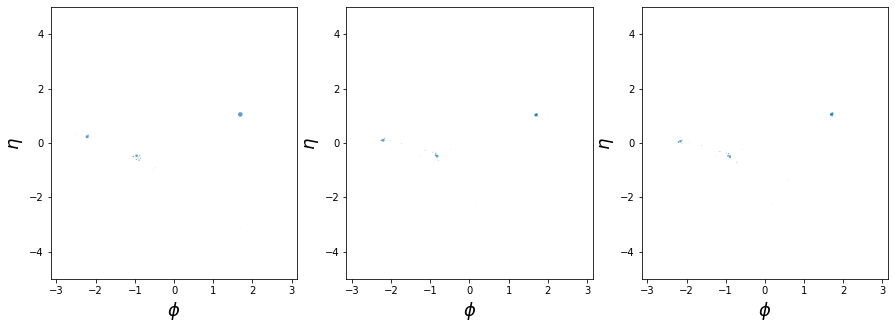

0.0 [0.95299774 0.08017259 0.2923446  0.06783452 0.16131298]
[9.1980612e-01 6.3007576e-07 3.6934018e-03 3.7309167e-08 9.9630851e-01]
[6.4172328e-01 5.0190091e-04 5.9730506e-01 9.8232420e-07 4.8300225e-01]


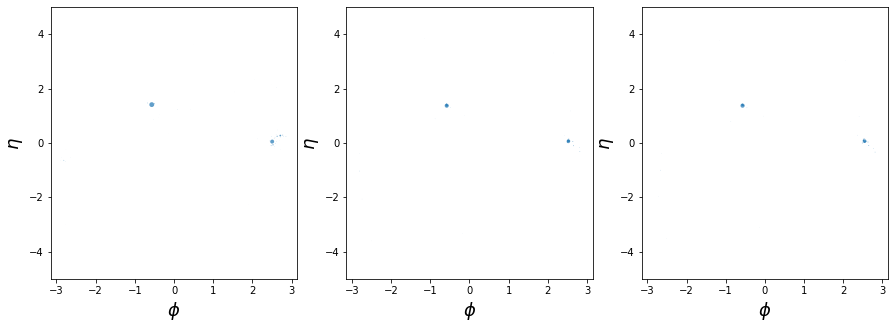

0.0 [0.9273181  0.07037792 0.19069345 0.08261383 0.1338194 ]
[9.9999952e-01 1.6558170e-04 1.7365289e-06 1.4389861e-01 4.2185295e-01]
[9.9996746e-01 2.7269214e-02 1.5243876e-01 4.8068774e-05 1.2416542e-03]


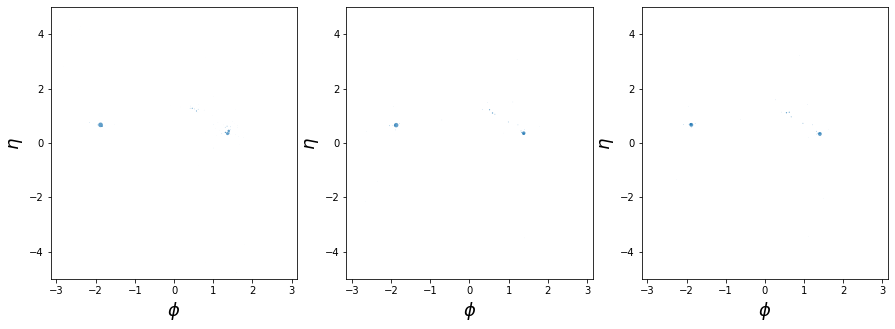

1.0 [0.92599577 0.07334555 0.22347002 0.09141994 0.12189401]
[9.9999940e-01 2.9318988e-02 9.8704356e-01 2.4725568e-05 1.6162336e-02]
[9.1157293e-01 1.9965122e-05 1.7052889e-04 7.2888434e-03 5.3880956e-07]


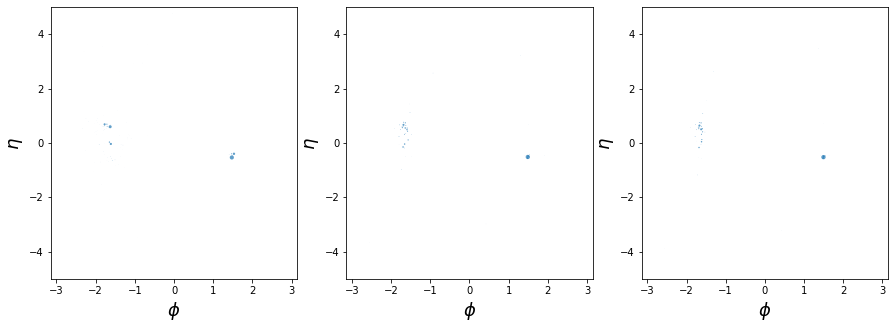

0.0 [0.9458767  0.09969713 0.30512178 0.11643798 0.19600593]
[8.9815938e-01 8.5351422e-07 5.1754445e-02 9.7361362e-01 1.5915394e-02]
[8.2249486e-01 3.0818582e-04 3.1448251e-01 3.7664175e-04 4.1973740e-01]


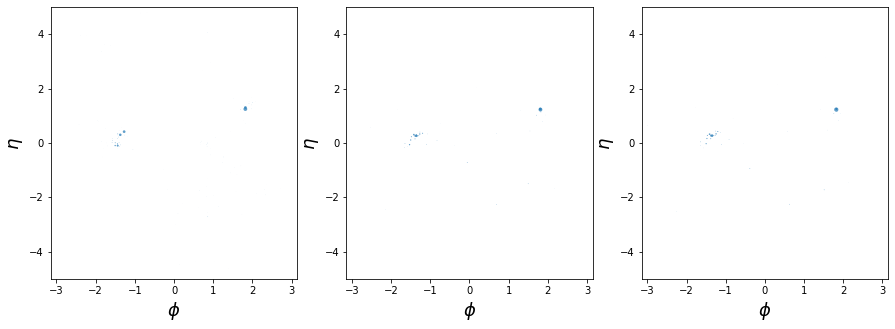

0.0 [0.92515594 0.07607077 0.16778675 0.05978064 0.1124367 ]
[9.99954700e-01 2.28464603e-04 1.21798635e-01 5.91367483e-03
 1.09413151e-04]
[6.8835890e-01 1.9575928e-06 4.4186711e-03 3.8331747e-04 1.0332307e-01]


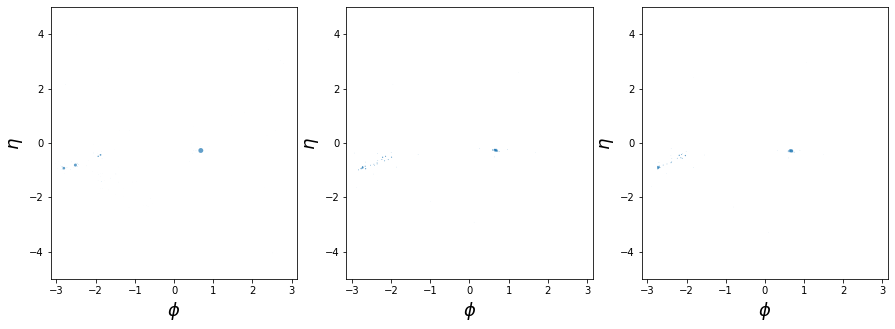

0.0 [0.92453086 0.08995676 0.24349211 0.08975901 0.1258438 ]
[9.9999559e-01 4.1763282e-01 8.4794128e-01 2.7438998e-04 8.6583805e-01]
[1.3517544e-01 3.8183123e-02 2.3102760e-04 2.0173549e-09 9.9998903e-01]


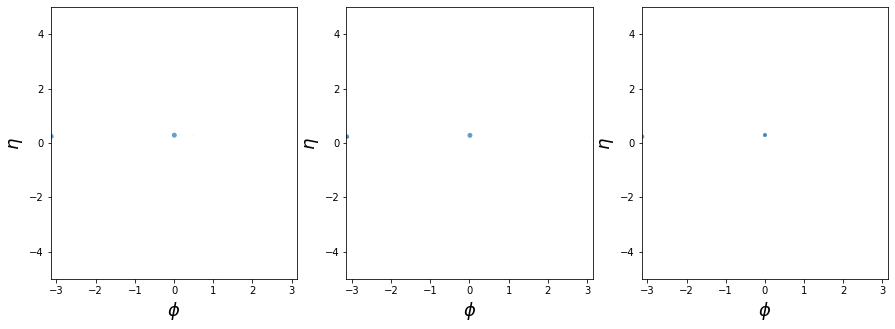

0.0 [0.92004675 0.10565178 0.23209876 0.07084123 0.13892171]
[9.8804176e-01 2.2918062e-05 4.3688677e-05 2.9118807e-09 3.7194065e-06]
[9.9999988e-01 1.0228750e-01 1.7684415e-06 5.1924304e-05 6.0913533e-02]


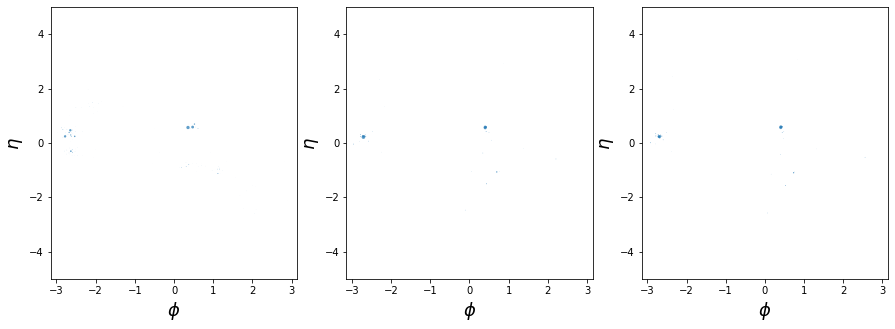

0.0 [0.94126356 0.08552381 0.25986633 0.08663292 0.13566744]
[9.9912000e-01 9.6861124e-03 3.5634637e-04 2.1409064e-06 9.2021227e-03]
[9.9530566e-01 7.4106320e-05 5.3017735e-03 6.1744986e-06 3.1301624e-01]


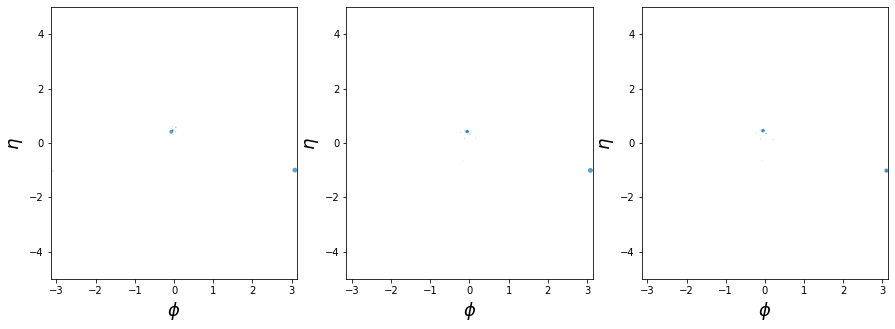

1.0 [0.9166915  0.07728027 0.19753592 0.06218824 0.12260938]
[9.9999917e-01 1.0897726e-02 3.2179385e-02 2.1050330e-06 5.8940649e-03]
[0.9999989  0.35598612 0.00776199 0.0141882  0.93662834]


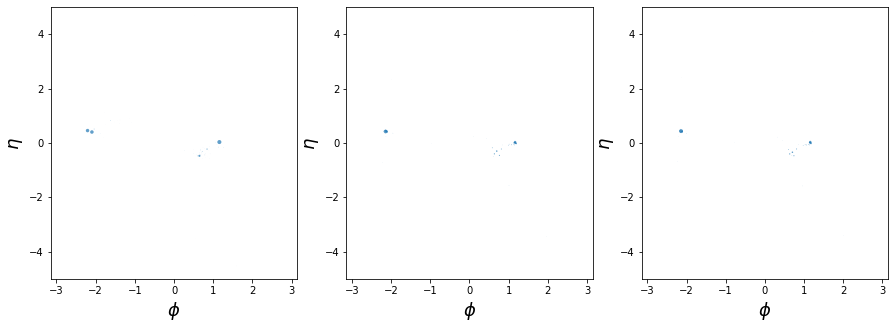

0.0 [0.95118403 0.07682665 0.22354399 0.0716942  0.16268528]
[1.00000000e+00 1.16863564e-04 1.89940529e-05 2.16402327e-07
 5.70471836e-10]
[9.9997354e-01 1.9621712e-05 1.9384027e-03 4.1263625e-08 5.9503317e-04]


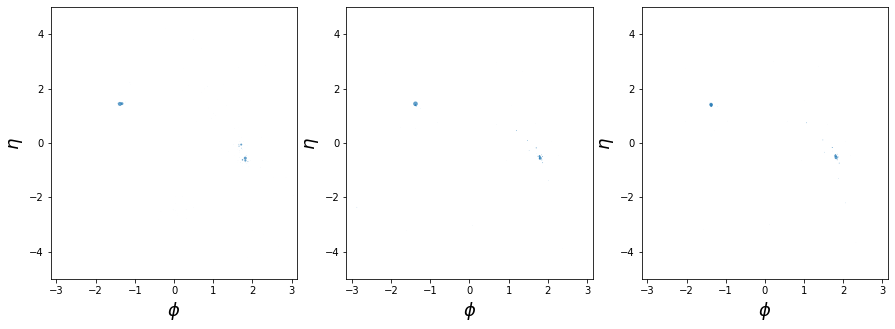

1.0 [0.9227857  0.10244009 0.22331163 0.1064226  0.17389536]
[9.99940038e-01 3.21226025e-06 5.89698553e-04 2.64873643e-06
 1.16846735e-04]
[9.8121119e-01 1.3163059e-05 7.4442983e-07 3.0741342e-07 9.9979722e-01]


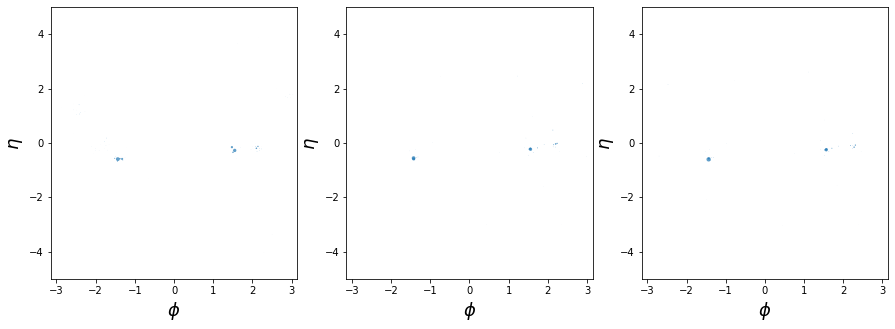

0.0 [0.9142444  0.09660242 0.18998402 0.0849164  0.11585903]
[9.99776125e-01 4.84066904e-01 7.67379999e-03 1.16484356e-04
 1.58399343e-04]
[5.1879901e-01 6.8848863e-08 5.6397319e-03 1.0774425e-01 8.7244207e-06]


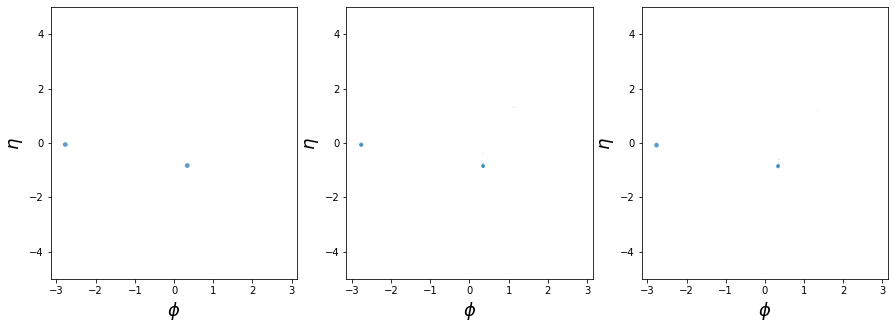

0.0 [0.9325959  0.12988533 0.18453544 0.07136885 0.15786557]
[9.9999487e-01 8.3492165e-11 1.6734302e-03 3.2578447e-07 2.0589387e-06]
[9.9999779e-01 3.2135918e-05 8.8418722e-03 3.1110644e-04 7.4210763e-04]


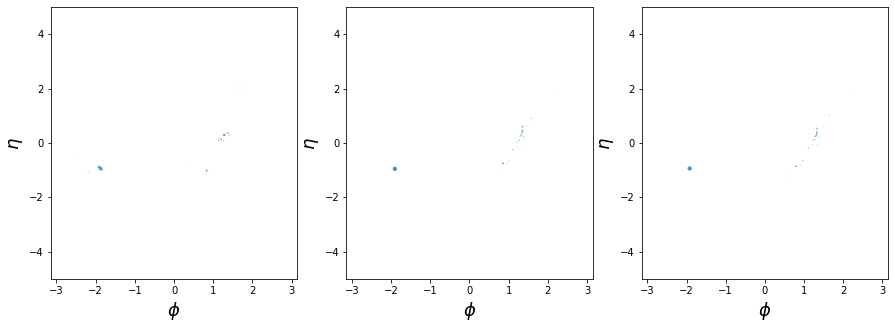

0.0 [0.9424448  0.10344312 0.26851997 0.0880921  0.18043415]
[1.0000000e+00 9.9580240e-01 8.7485125e-05 1.4955848e-02 3.4112066e-02]
[9.9999464e-01 9.3701274e-06 6.4161146e-01 9.8895776e-01 9.9745673e-01]


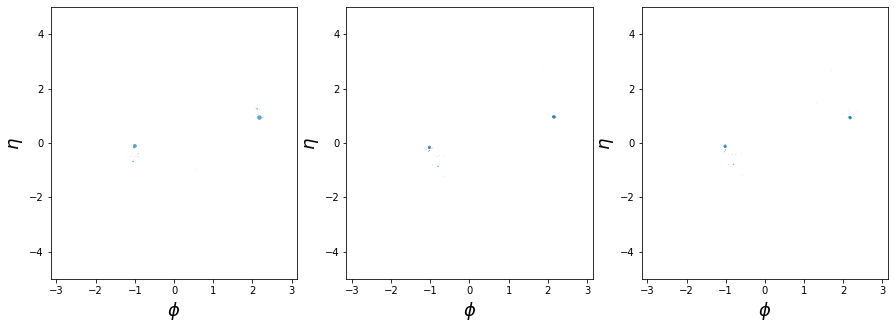

0.0 [0.9386492  0.08773682 0.23156735 0.09002413 0.14719768]
[9.9959129e-01 1.0735393e-03 9.8642874e-01 8.5537868e-05 8.0128571e-05]
[9.9948037e-01 3.1715930e-03 9.9982959e-01 4.9799770e-02 6.0205333e-05]


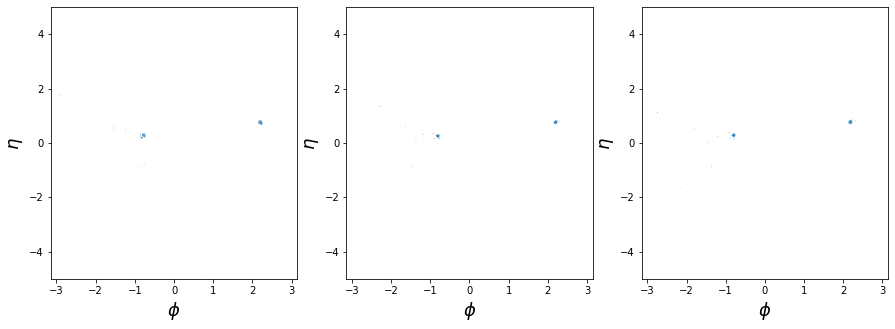

1.0 [0.94390225 0.07871213 0.17687687 0.06428602 0.13376412]
[0.88859403 0.00214657 0.00182217 0.9999149  0.00515708]
[9.99939799e-01 7.11785033e-05 1.49053037e-02 1.08697095e-04
 6.70316219e-02]


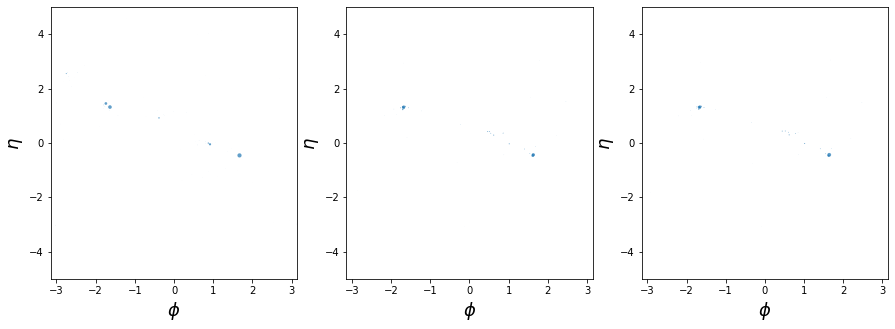

0.0 [0.94184285 0.11830477 0.1535507  0.07724637 0.13258822]
[9.9981105e-01 5.9056520e-02 4.0861709e-05 2.9052496e-03 2.8455257e-04]
[9.9998844e-01 2.7809948e-02 1.6299908e-05 2.4849176e-04 2.1272185e-01]


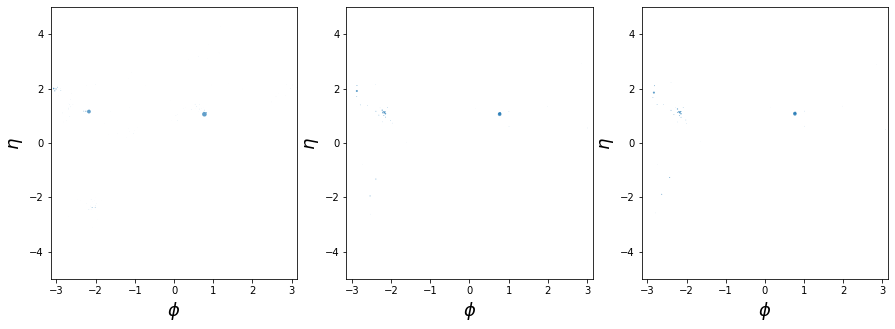

0.0 [0.93731534 0.0837919  0.24518539 0.07306524 0.13896169]
[9.9999875e-01 2.7275085e-04 4.9254298e-04 9.8478267e-05 2.2009015e-04]
[1.0000000e+00 2.2410694e-08 1.9358486e-02 7.6439977e-04 4.3353556e-13]


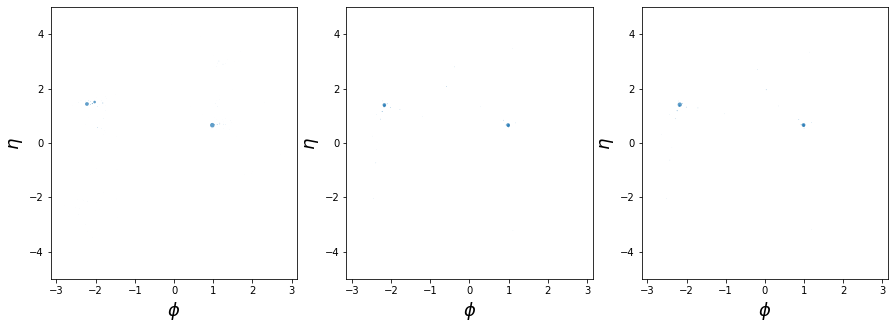

0.0 [0.9519435  0.07675426 0.18301503 0.07344959 0.10586017]
[9.9990934e-01 1.5789270e-03 2.4485588e-04 5.8960074e-01 9.5157325e-03]
[9.8033071e-01 3.1174968e-06 2.4911761e-04 6.5963526e-05 5.6159496e-04]


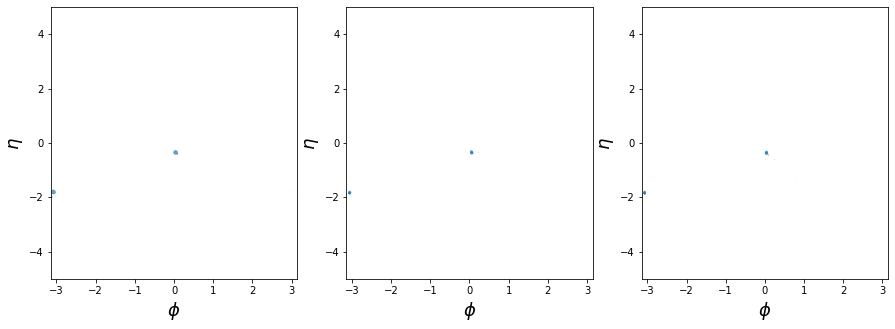

0.0 [0.9453061  0.06122233 0.12689243 0.0681725  0.07401851]
[9.7784108e-01 7.6628916e-13 9.7111217e-07 1.3226271e-04 2.4961054e-02]
[9.7502989e-01 1.9227654e-08 9.6137226e-03 9.4836950e-04 2.7004630e-06]


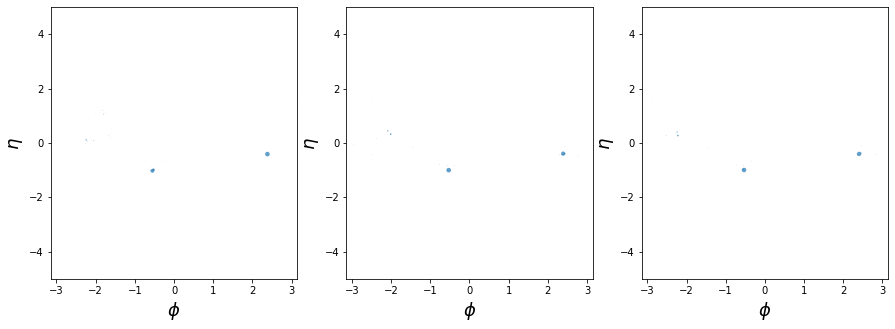

0.0 [0.9351562  0.0924454  0.22829081 0.09361251 0.15933733]
[9.9999499e-01 8.2342124e-01 6.7731738e-04 8.5595548e-03 9.2024791e-01]
[9.9977696e-01 1.3953447e-04 1.1218786e-03 1.6478439e-06 3.3961833e-03]


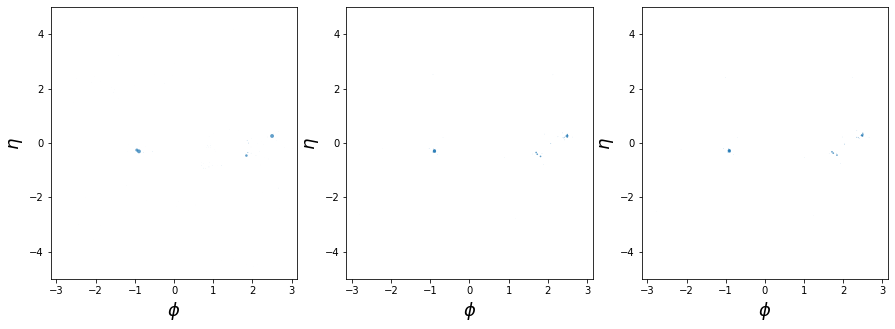

0.0 [0.9385311  0.08286563 0.21229653 0.06513694 0.14952123]
[9.9787784e-01 1.7845035e-03 8.2360804e-03 7.9731049e-05 2.7109087e-03]
[9.9986345e-01 6.5779686e-04 2.7166086e-01 2.9018521e-04 4.2397380e-03]


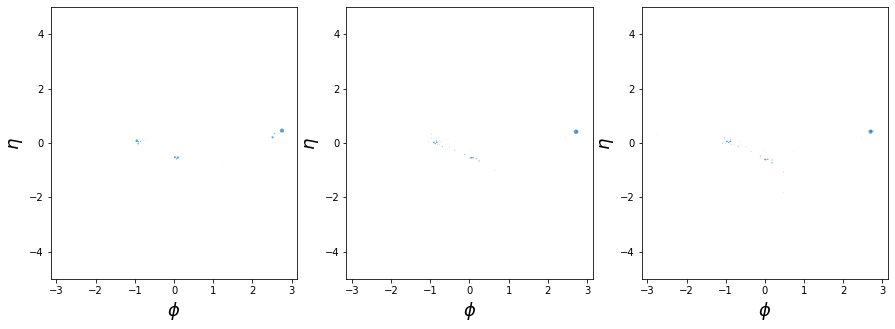

0.0 [0.9222522  0.08935136 0.2013073  0.0696964  0.1220722 ]
[9.9996066e-01 5.6576855e-06 4.7324610e-01 5.6847966e-01 1.6456842e-04]
[1.0000000e+00 2.0252141e-05 5.1536858e-03 2.0134449e-04 8.9432426e-05]


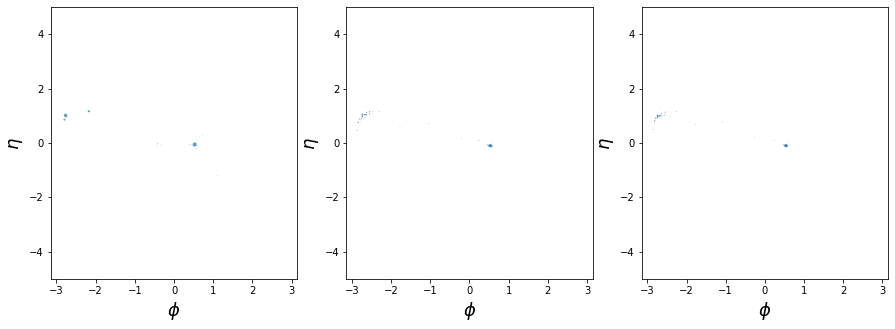

0.0 [0.94071835 0.11303364 0.2766713  0.0942749  0.16145508]
[9.9999917e-01 1.0391057e-02 1.5962869e-02 8.2383513e-02 2.7185339e-07]
[8.0183119e-01 7.7664126e-06 3.0262205e-01 7.5821168e-05 3.0704141e-03]


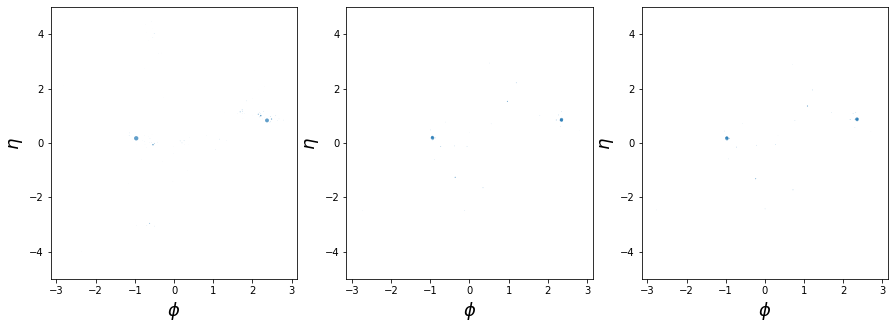

0.0 [0.9405169  0.05845491 0.22072774 0.06808968 0.11652545]
[1.0000000e+00 2.3644507e-01 2.6099980e-03 1.7056037e-06 8.3030682e-05]
[9.8380721e-01 3.0439180e-01 1.5175343e-04 3.9474618e-01 3.7556589e-03]


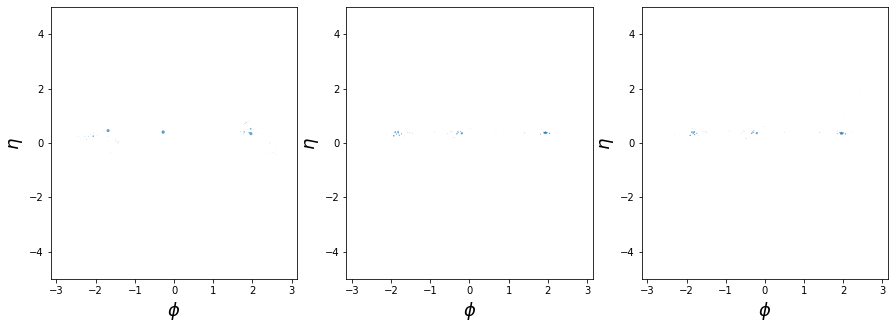

0.0 [0.93158346 0.09383482 0.2594308  0.07405336 0.11064868]
[9.9999845e-01 4.5417339e-02 2.4063652e-06 1.1807382e-03 1.7599207e-09]
[1.8957943e-02 6.8581594e-09 2.1957457e-03 2.1904111e-02 7.2702765e-04]


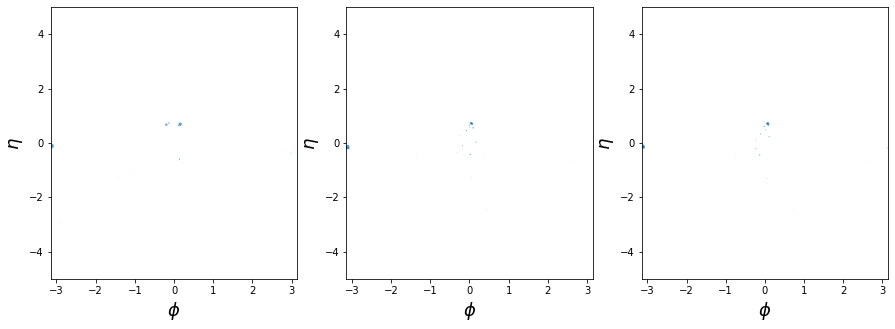

0.0 [0.9435787  0.08787885 0.26561442 0.0873261  0.13346873]
[9.9938869e-01 9.8783672e-01 3.4550941e-01 1.0615696e-04 4.0673825e-01]
[1.         0.02756828 0.06986439 0.00518808 0.00514263]


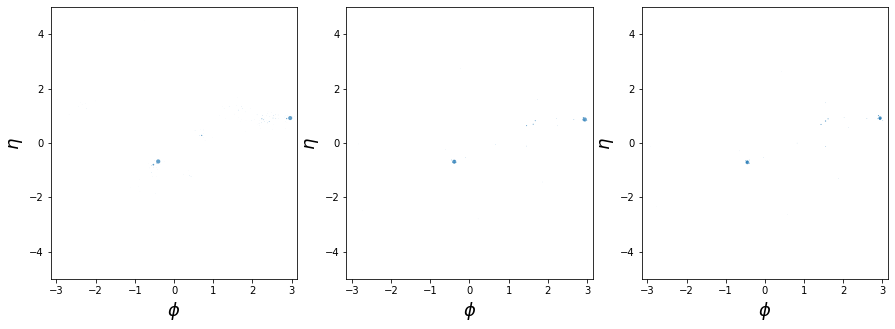

0.0 [0.9502529  0.08746907 0.25537392 0.06114336 0.15396985]
[9.9978399e-01 7.0369639e-09 1.1831363e-06 7.8733432e-01 1.8146220e-01]
[9.9985152e-01 1.5744567e-04 2.1830041e-05 7.6968342e-02 6.5829188e-02]


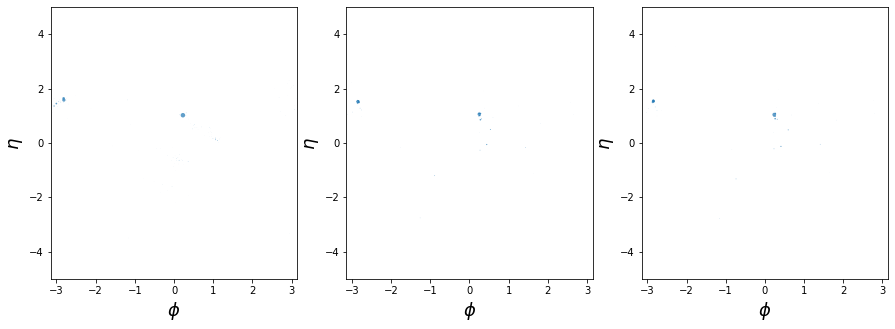

1.0 [0.92264813 0.08768021 0.17680682 0.07741112 0.14421809]
[1.0000000e+00 5.6642294e-04 1.1300147e-03 2.6013851e-03 1.7660856e-04]
[9.9985802e-01 7.6246262e-04 5.5176914e-03 9.1092363e-07 1.6806760e-01]


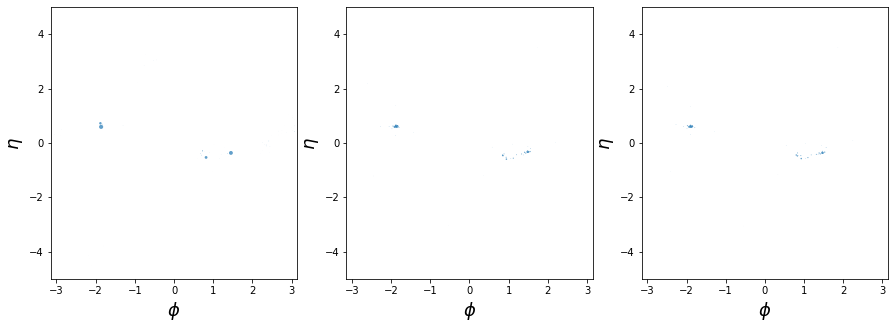

0.0 [0.9387281  0.0774411  0.2385903  0.09369081 0.17547594]
[9.9999923e-01 4.1195750e-04 3.5010159e-02 1.0557530e-06 4.5844913e-04]
[1.0000000e+00 4.0676758e-05 2.5305152e-04 5.8409572e-04 9.9999678e-01]


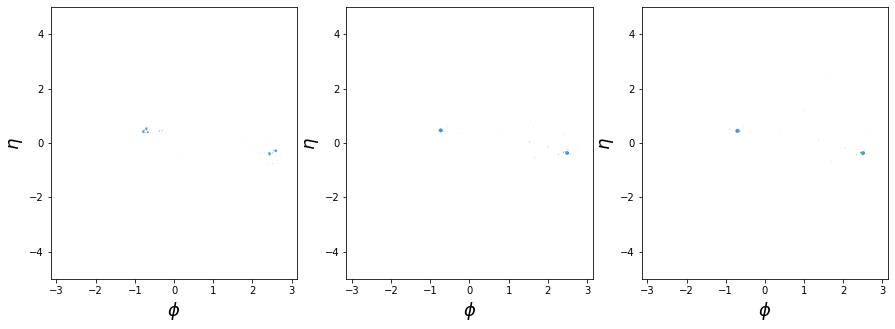

1.0 [0.9345321  0.10291535 0.2192358  0.08690102 0.18202202]
[9.9999630e-01 8.9451540e-01 1.8624328e-07 2.7539128e-05 1.6059364e-06]
[1.3010266e-01 2.6255846e-04 3.9050835e-01 4.1355318e-01 1.6343594e-04]


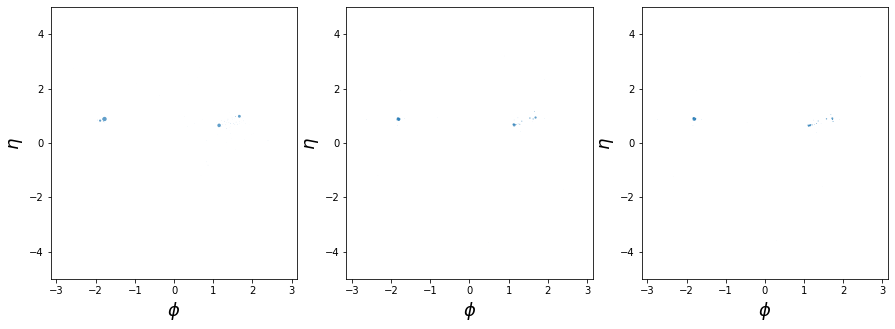

0.0 [0.93952495 0.10009607 0.2819337  0.11793527 0.15428309]
[9.9999964e-01 1.3020635e-04 2.8440356e-03 4.4295914e-05 1.0342002e-03]
[0.99999213 0.3424341  0.8115638  0.02107096 0.03334945]


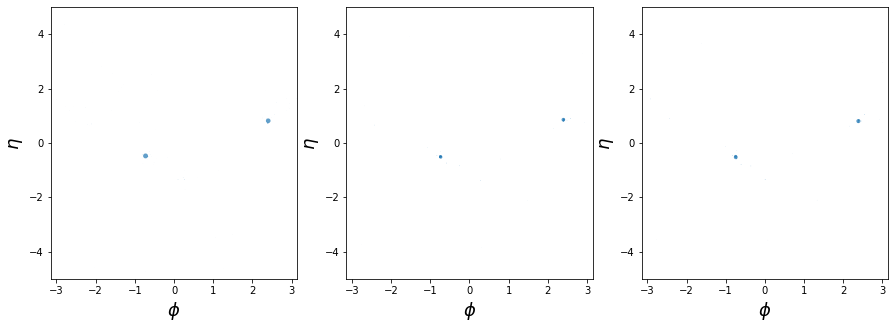

1.0 [0.9345676  0.09239767 0.22023472 0.0760835  0.15255128]
[0.9913257  0.0253807  0.01959327 0.97891337 0.4261639 ]
[1.0000000e+00 1.2169778e-02 5.9620142e-03 2.8023124e-04 7.1417093e-03]


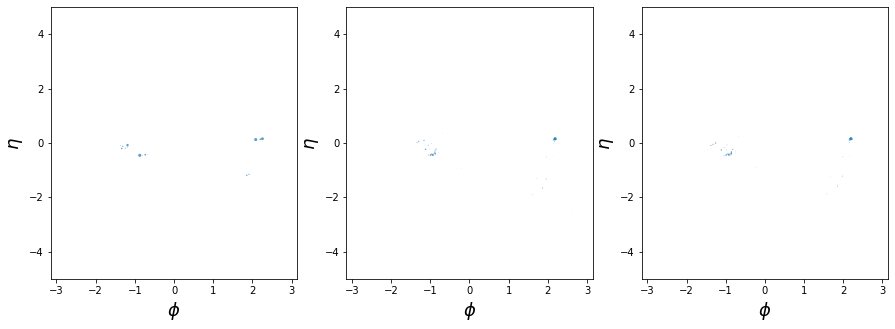

0.0 [0.92605907 0.08267743 0.21229978 0.08802488 0.13120492]
[9.9996841e-01 2.3895013e-01 9.8703206e-03 3.3444166e-04 5.4355361e-05]
[9.9999917e-01 1.8572807e-04 4.6970690e-06 2.7671030e-01 6.8628788e-04]


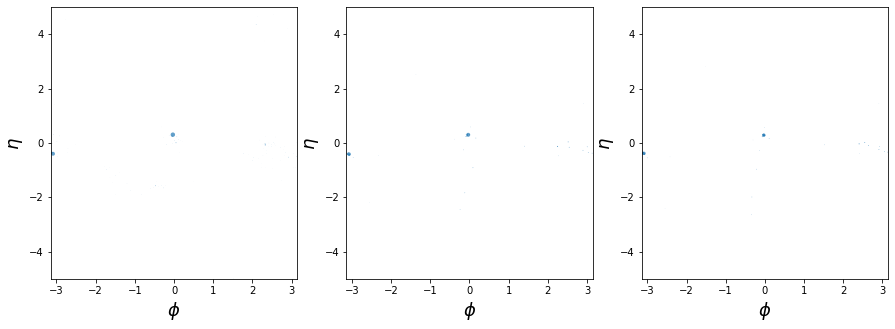

0.0 [0.9366271  0.06520513 0.16273712 0.07754372 0.15357935]
[9.9999923e-01 9.5095515e-05 6.1437398e-02 9.9968201e-01 2.4419578e-06]
[9.9999923e-01 3.7240416e-02 7.1176887e-04 2.4262071e-04 1.6827583e-03]


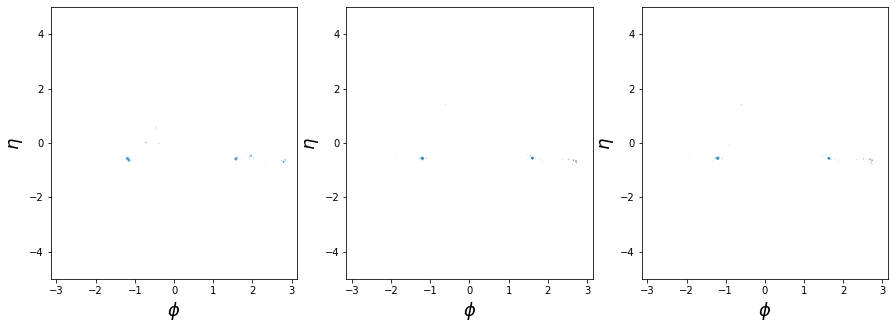

1.0 [0.9285227  0.08486159 0.18528639 0.06528408 0.10160249]
[9.9997914e-01 8.9878976e-01 2.5028896e-01 4.6465389e-05 9.8544687e-02]
[1.00000000e+00 9.55076218e-01 4.91097569e-02 1.02163135e-07
 1.46757722e-01]


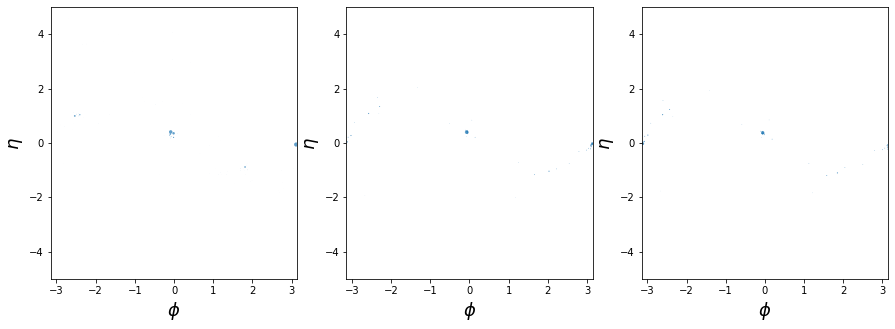

0.0 [0.9375746  0.11030614 0.32767272 0.11377645 0.21579339]
[9.8582673e-01 1.3613712e-06 1.0297000e-03 2.9548073e-05 3.1454265e-03]
[8.8232756e-01 6.9198400e-08 4.4995744e-07 4.4213533e-03 3.1077266e-03]


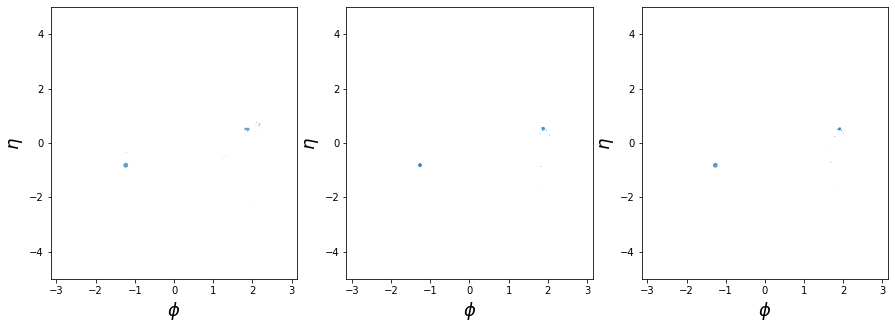

1.0 [0.94791394 0.08070175 0.17777774 0.07192291 0.11467523]
[6.5485454e-01 4.7039048e-08 3.6510825e-04 2.5124550e-03 1.1267662e-03]
[9.96461868e-01 4.23140918e-08 5.72395325e-03 1.02841208e-04
 1.03073895e-01]


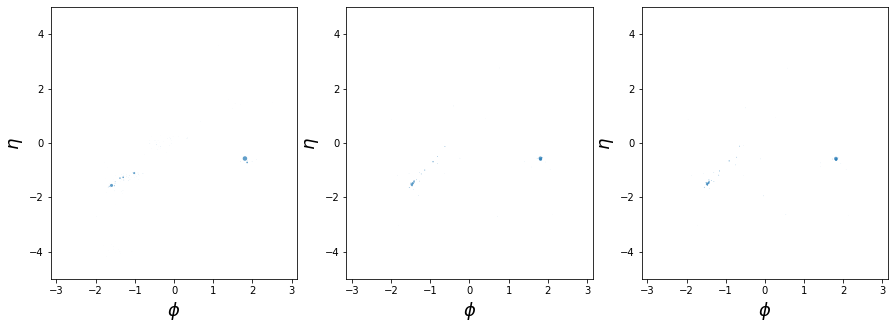

0.0 [0.93754494 0.07421043 0.17538768 0.10616756 0.1437989 ]
[6.7087305e-01 2.5992065e-05 5.0465131e-01 3.7963632e-01 5.4841448e-06]
[9.8854172e-01 9.3260574e-01 2.9593372e-01 8.8497949e-01 7.4605496e-06]


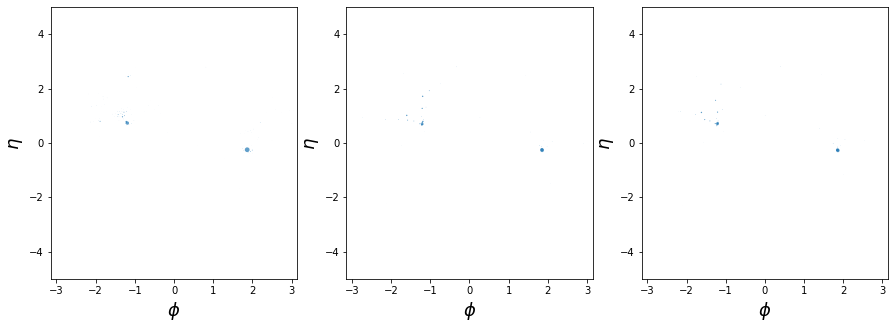

0.0 [0.9164662  0.08125667 0.20418485 0.06576538 0.09823418]
[5.2947307e-01 8.6734502e-08 9.2980373e-01 1.7944276e-03 1.9417703e-03]
[9.9997294e-01 8.3266199e-03 6.7470729e-02 1.4281273e-04 7.4176103e-05]


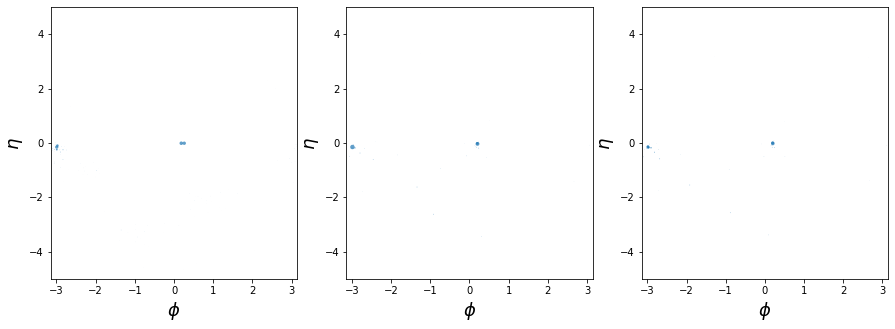

0.0 [0.94807035 0.09488345 0.25686312 0.07081601 0.22521801]
[9.9999750e-01 4.7543347e-03 2.0138562e-02 4.2821601e-05 9.2949831e-01]
[9.9999893e-01 7.5591993e-01 3.1623244e-04 6.0026854e-02 8.6292030e-06]


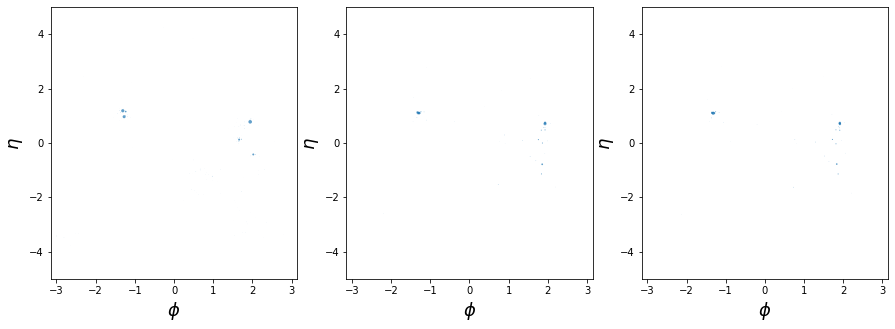

1.0 [0.9371242  0.08310808 0.26081973 0.09973244 0.1774283 ]
[9.7428048e-01 4.8031996e-08 1.0925353e-02 4.4411421e-04 4.7404170e-03]
[2.7569443e-02 2.2143126e-04 7.6078445e-02 1.5117574e-01 9.9762154e-01]


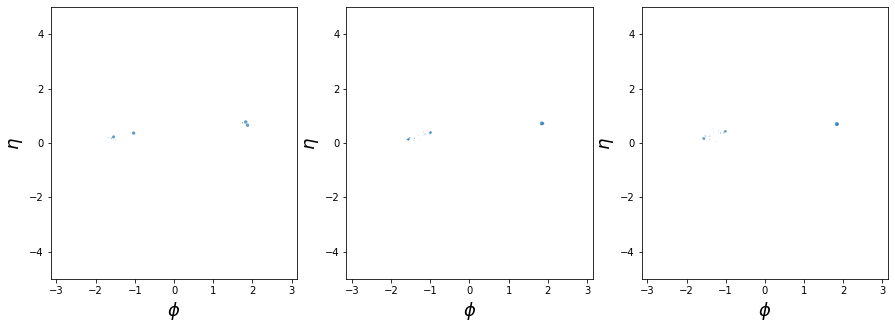

0.0 [0.94504845 0.08177851 0.29530242 0.0978125  0.12693886]
[9.3712616e-01 5.3662062e-04 1.7538667e-04 2.5779605e-03 1.4569551e-02]
[1.0000000e+00 9.4395876e-04 1.9185337e-01 3.2128607e-06 9.9988043e-01]


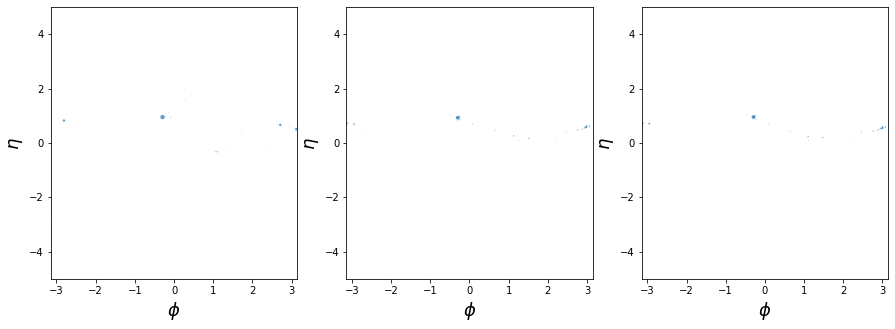

0.0 [0.9361572  0.08372946 0.17913486 0.09930684 0.13992453]
[9.8423505e-01 6.6937208e-03 9.8848438e-01 4.4053793e-04 9.9360317e-05]
[9.9502289e-01 3.5411827e-09 9.9989766e-01 2.2316009e-02 1.2869441e-06]


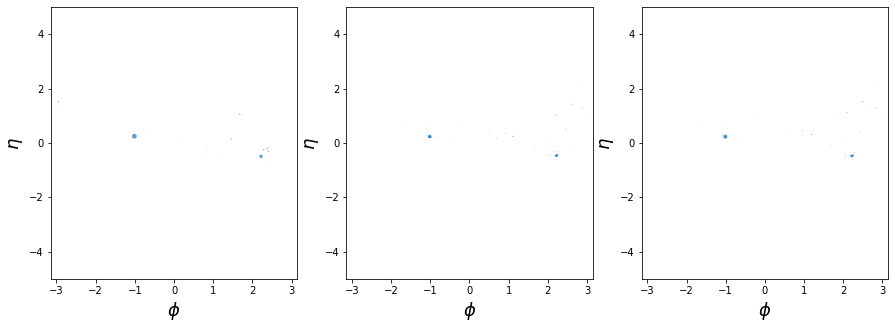

1.0 [0.94827706 0.09571324 0.24014662 0.12282407 0.16529243]
[9.9999976e-01 6.2449843e-02 1.4529824e-01 1.5731463e-01 3.0138472e-07]
[9.9878609e-01 7.8251958e-04 1.8688226e-01 8.4164350e-07 5.6917483e-01]


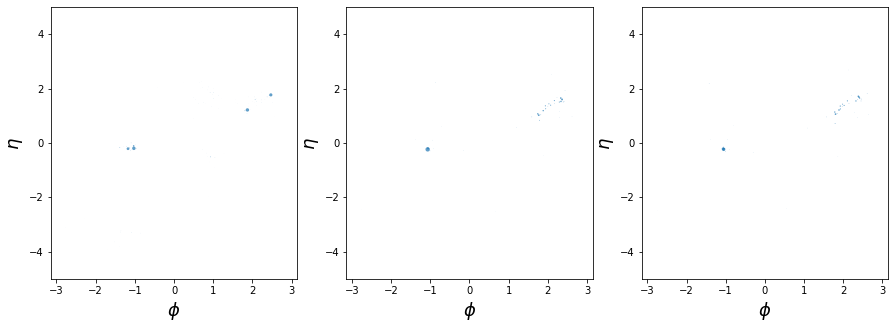

0.0 [0.91550636 0.09130519 0.20873722 0.09653313 0.14836484]
[9.9999976e-01 1.1541739e-04 9.9983990e-01 4.0300786e-03 1.3710558e-03]
[9.9983799e-01 1.2523374e-01 7.6839149e-02 1.5067705e-07 1.4425370e-01]


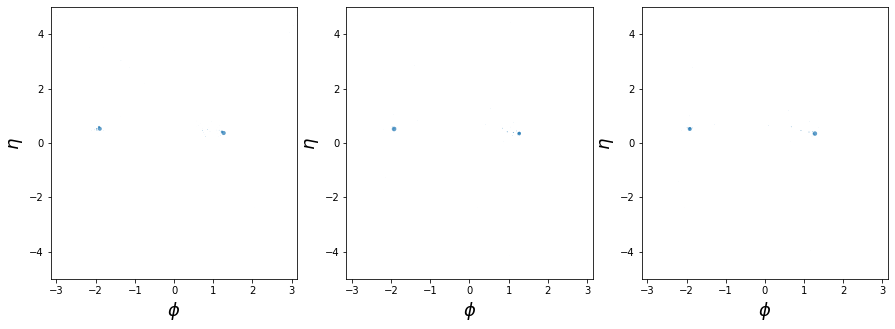

In [95]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in range(100):   

    fig, ax = plt.subplots(1, 3,figsize=[15,5])

    print(valid_labels[i], p_bern[i][bernsort_means[:5]])

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.03)
    ax[0].scatter(phis, etas, s = pts*50, alpha = 0.7,linewidths=0)
    

    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    for j in range(2):
        outjet = outs_array[j][0][i,:,1:]
        weights = outs_array[j][0][i,:,0]
        pred_labels = outs_array[j][-2][i]
        print(pred_labels[bernsort_means[:5]])
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
        ax[j+1].scatter(phis, etas, s = pts*50, alpha = 0.7,linewidths=0)
#         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
#         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(3):
        ax[j].set_ylabel(r'$\eta$',fontsize=18)
        ax[j].set_xlabel(r'$\phi$',fontsize=18)
        ax[j].set_ylim([-etalim,etalim])
        ax[j].set_xlim([-np.pi,np.pi])
    
    plt.show()

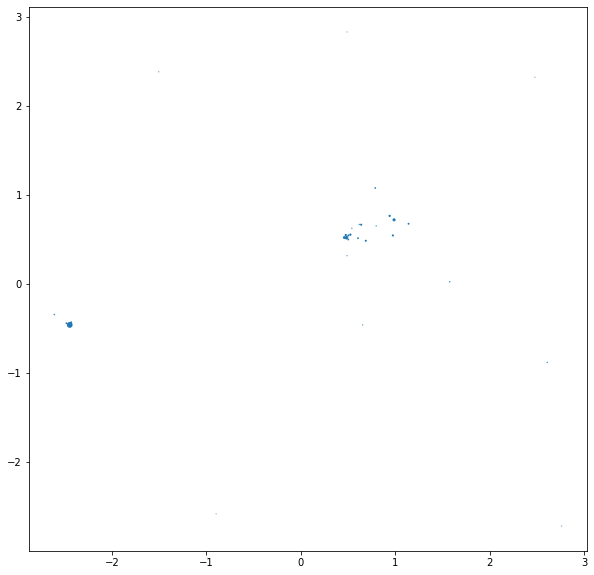

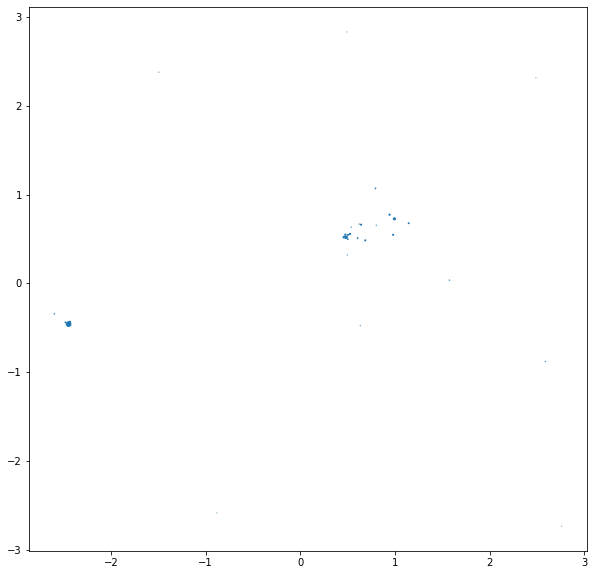

In [101]:

outjet = result[:,1:]
weights = result[:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.figure(figsize=[10,10])
plt.scatter(phis, etas, s = pts*50, alpha = 1.,linewidths=1)

plt.show()


outjet = result_2[:,1:]
weights = result_2[:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.figure(figsize=[10,10])
plt.scatter(phis, etas, s = pts*50, alpha = 1.,linewidths=1)

plt.show()


0.0 [0.87821704 0.9046756  0.9225412  0.9171478  0.8976127 ]


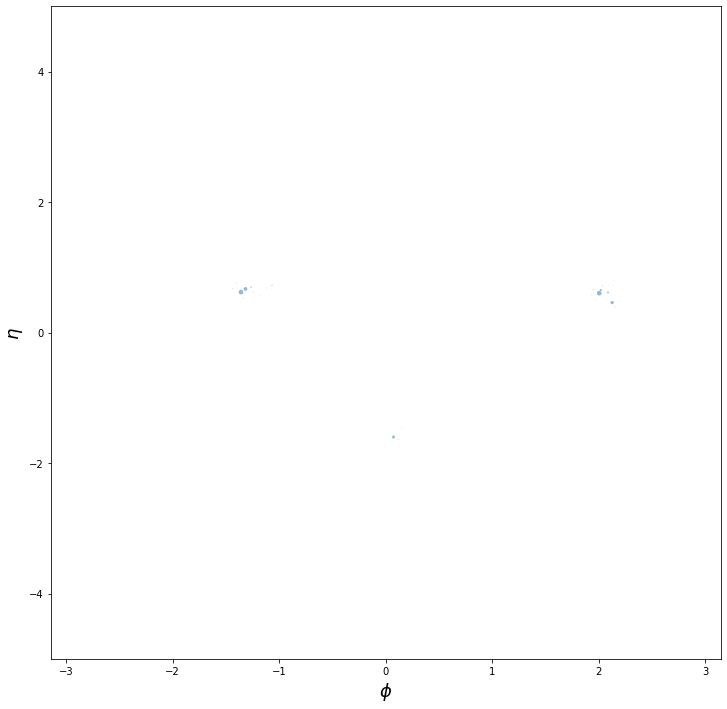

0.0 [0.85163575 0.89223015 0.9124035  0.9211341  0.89968514]


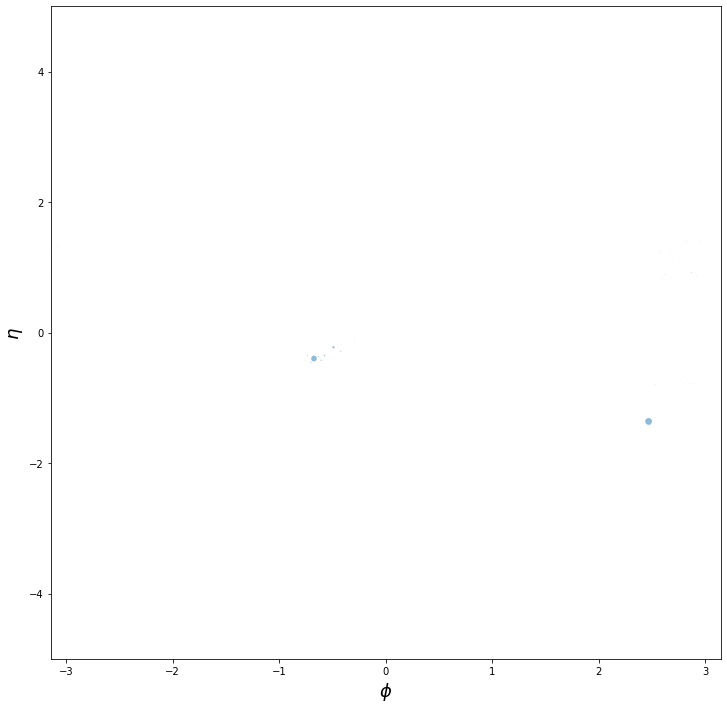

0.0 [0.86567485 0.88629043 0.9115972  0.9076654  0.8939917 ]


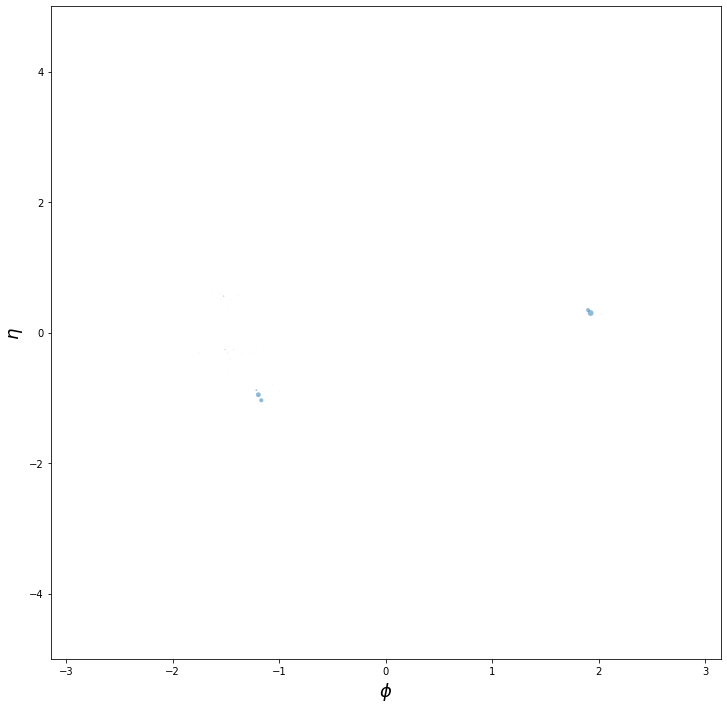

0.0 [0.8582728 0.9023283 0.9126301 0.9175935 0.9010388]


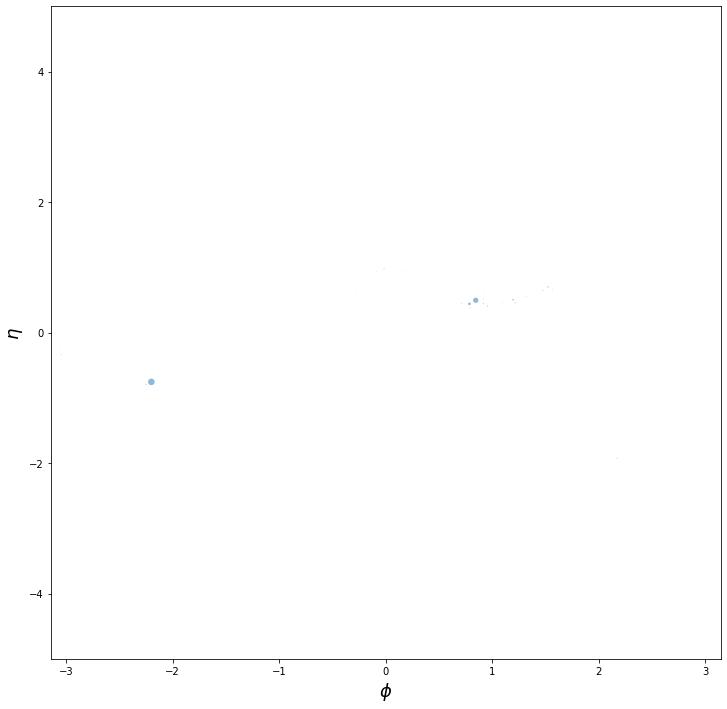

0.0 [0.94016796 0.94230187 0.93652326 0.9286091  0.91328526]


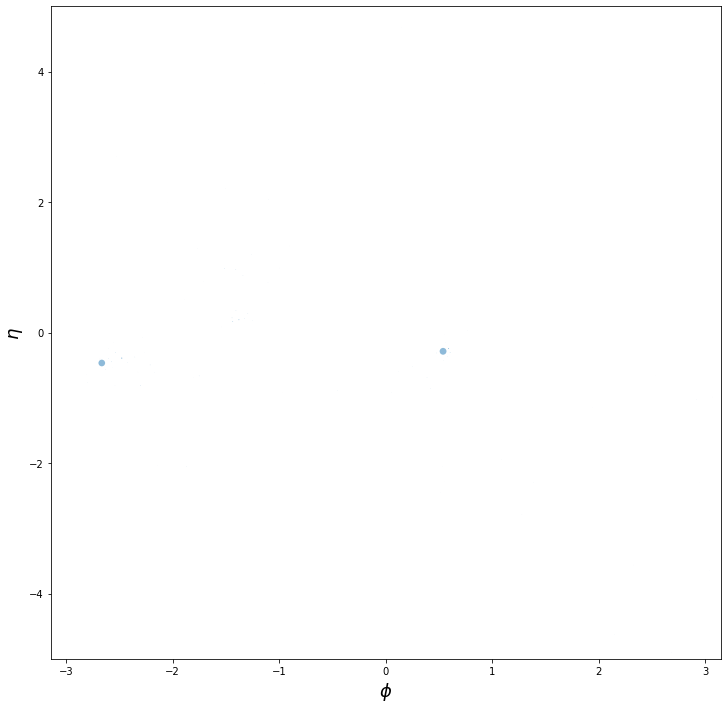

0.0 [0.85169363 0.89314723 0.90544206 0.9004631  0.893724  ]


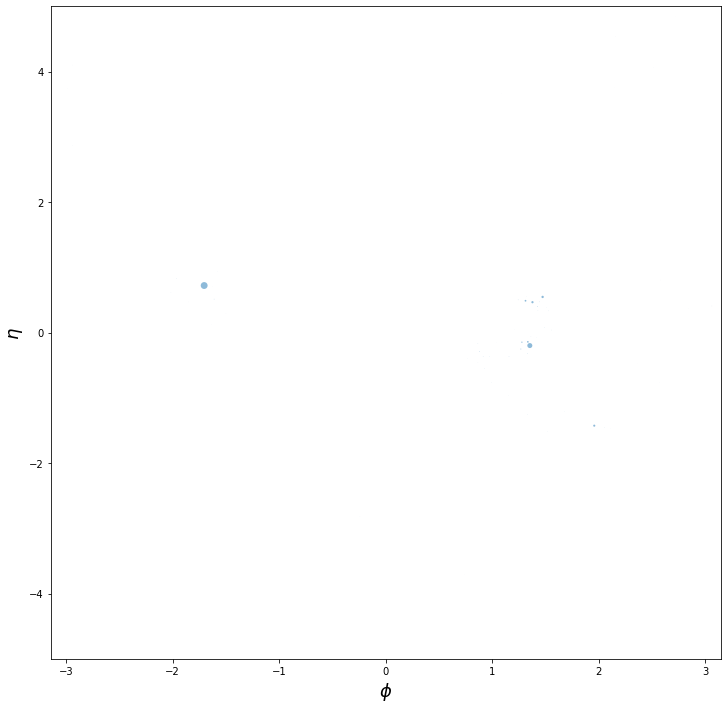

0.0 [0.9105651  0.922983   0.9312102  0.9254277  0.91470563]


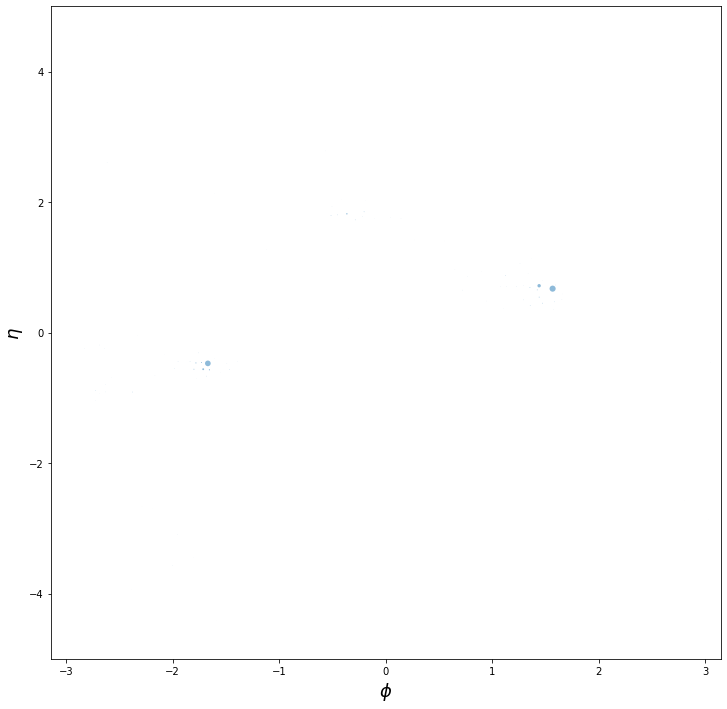

0.0 [0.81380856 0.8817104  0.9157495  0.92499405 0.9066942 ]


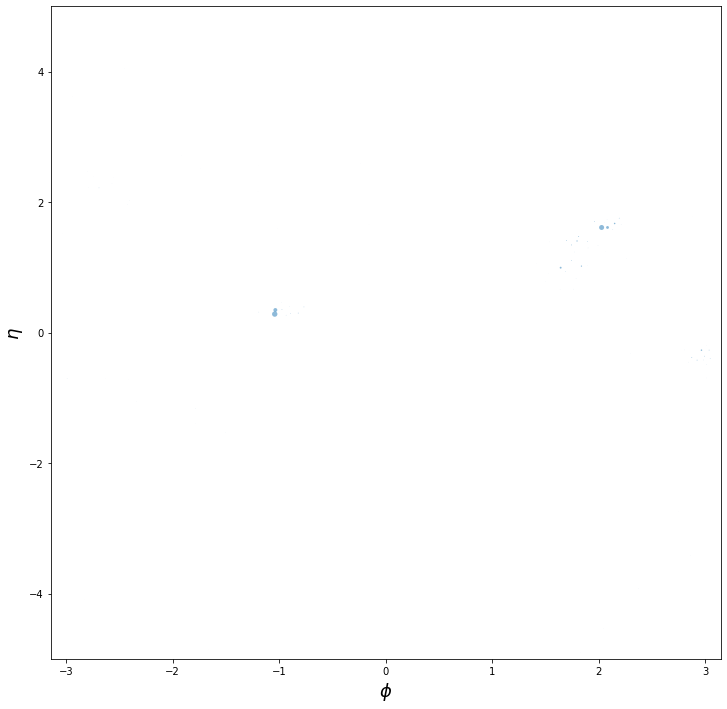

0.0 [0.90580237 0.91835845 0.9245994  0.92034227 0.9056947 ]


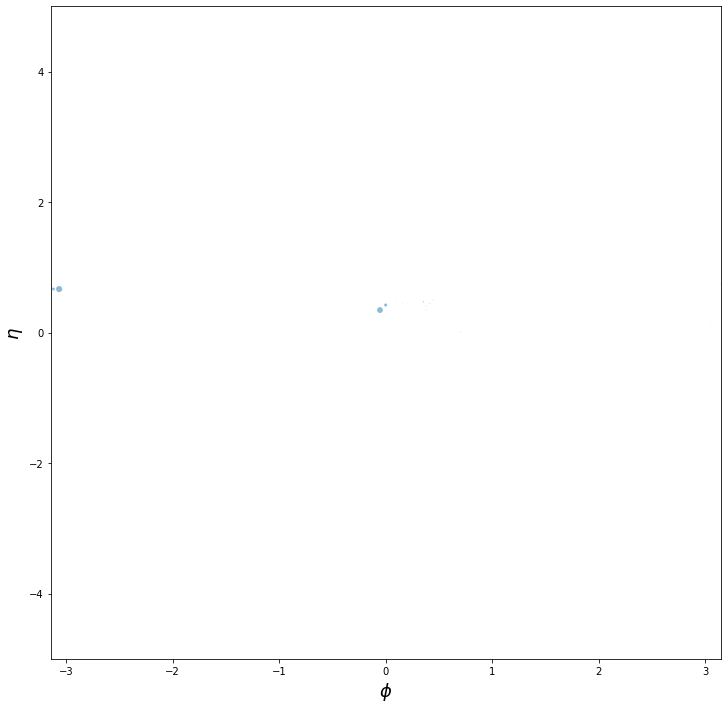

0.0 [0.9212168  0.9332018  0.93092626 0.9326352  0.92376566]


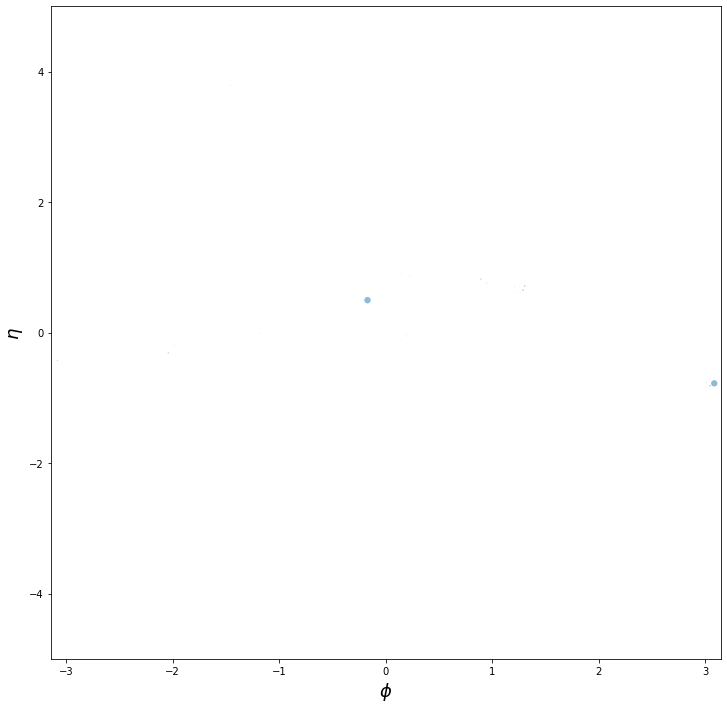

0.0 [0.91752446 0.92344856 0.92604315 0.92414534 0.90845585]


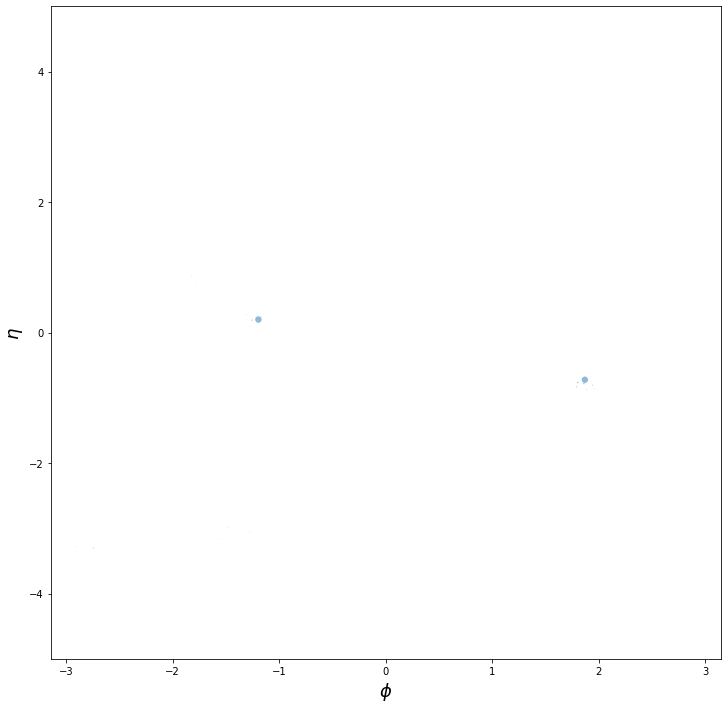

0.0 [0.00095996 0.04262935 0.80938727 0.82517993 0.8128851 ]


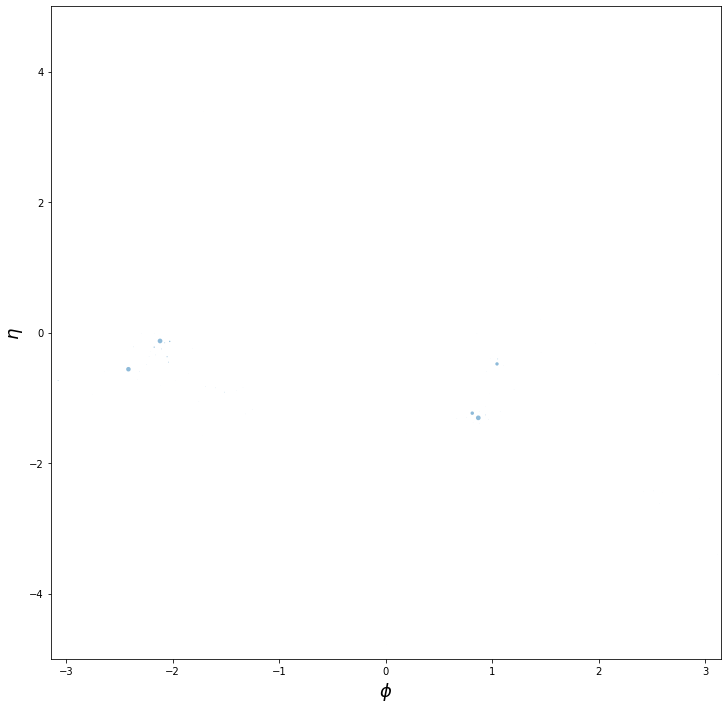

0.0 [0.9470968  0.9455359  0.9388747  0.93425566 0.9146823 ]


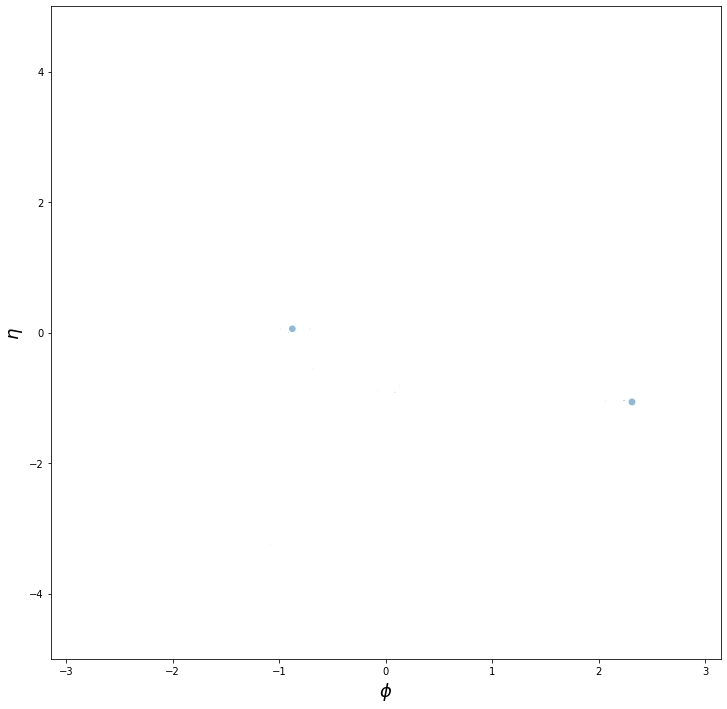

0.0 [0.10981756 0.75149876 0.8747007  0.89084774 0.8653977 ]


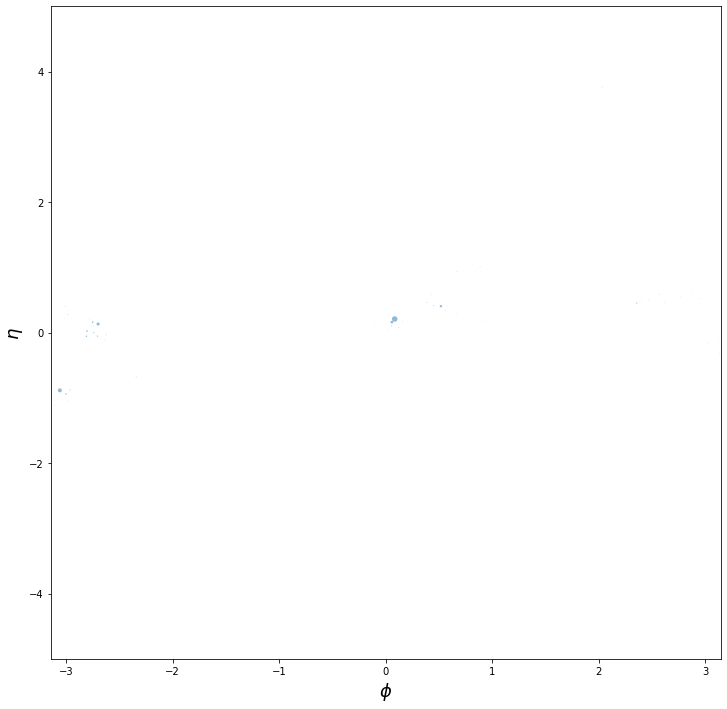

0.0 [0.41783533 0.8215361  0.88791114 0.9004261  0.89091766]


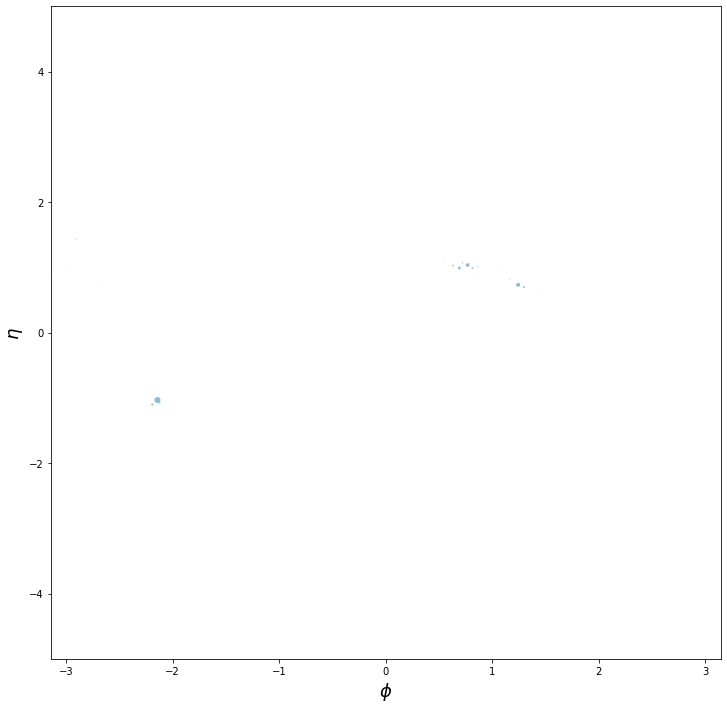

0.0 [0.92181706 0.9277503  0.92800325 0.92703265 0.9098806 ]


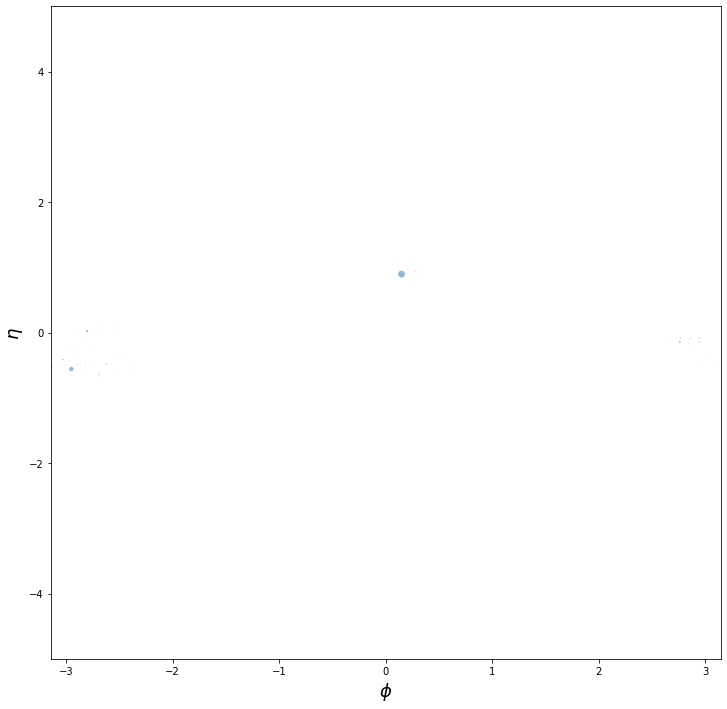

0.0 [0.9145409  0.92557466 0.927238   0.9229035  0.91645336]


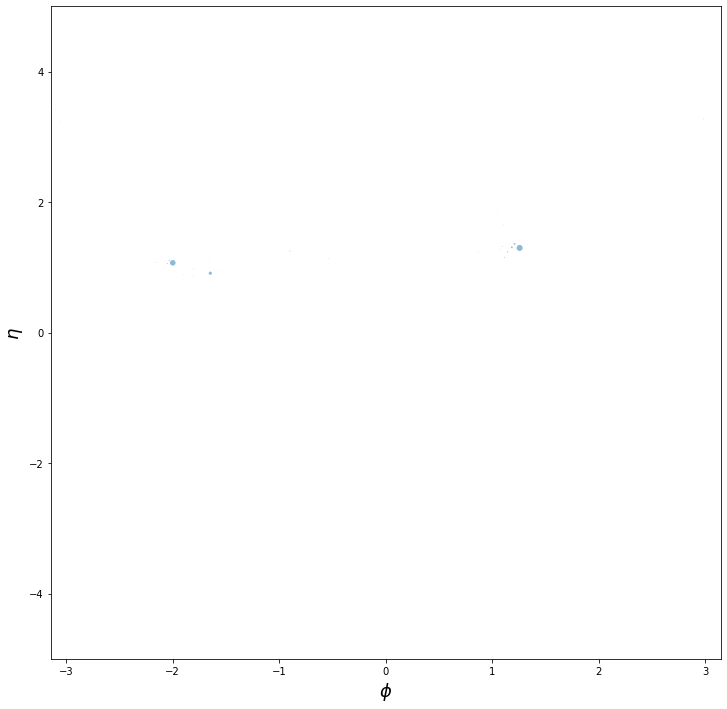

0.0 [0.93854403 0.9395009  0.9337636  0.92996365 0.9121424 ]


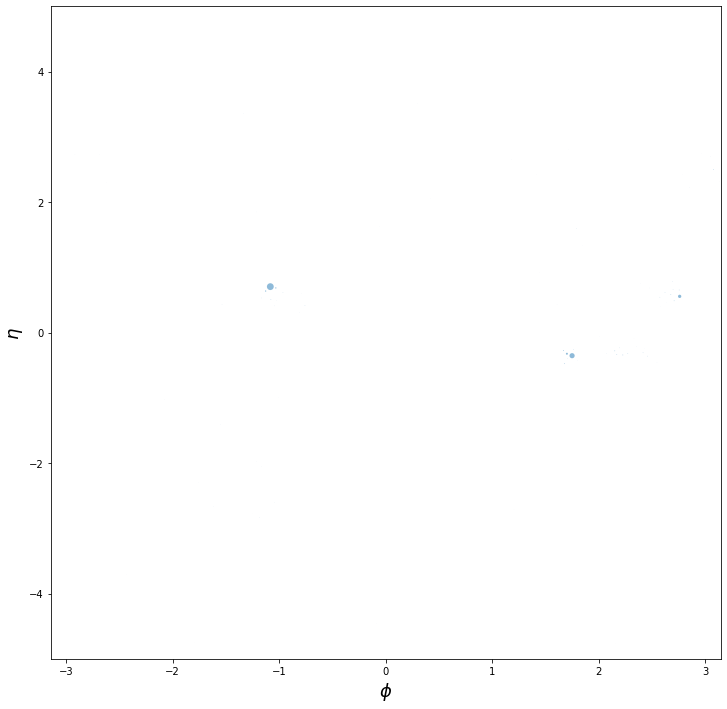

0.0 [0.33795512 0.716079   0.87999135 0.88324493 0.86307424]


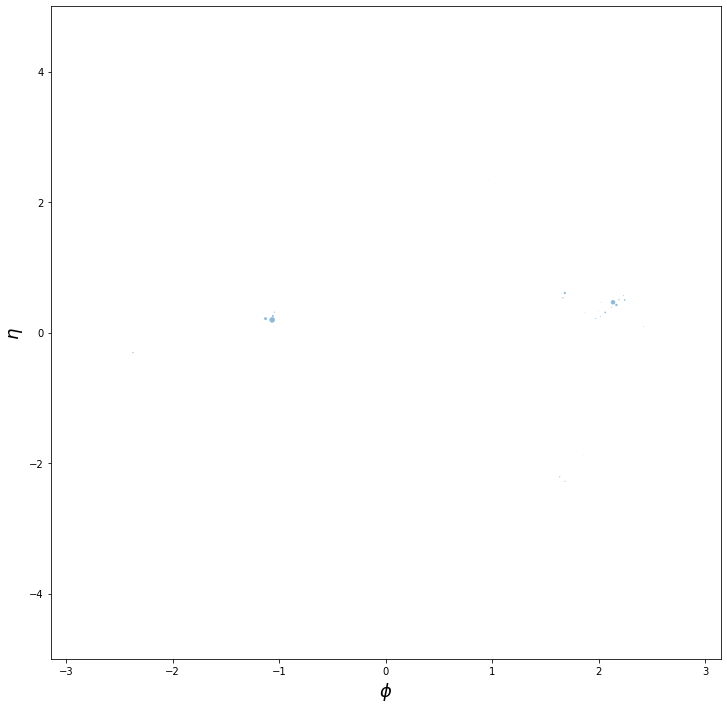

1.0 [0.91728395 0.9230465  0.923708   0.919939   0.90406686]


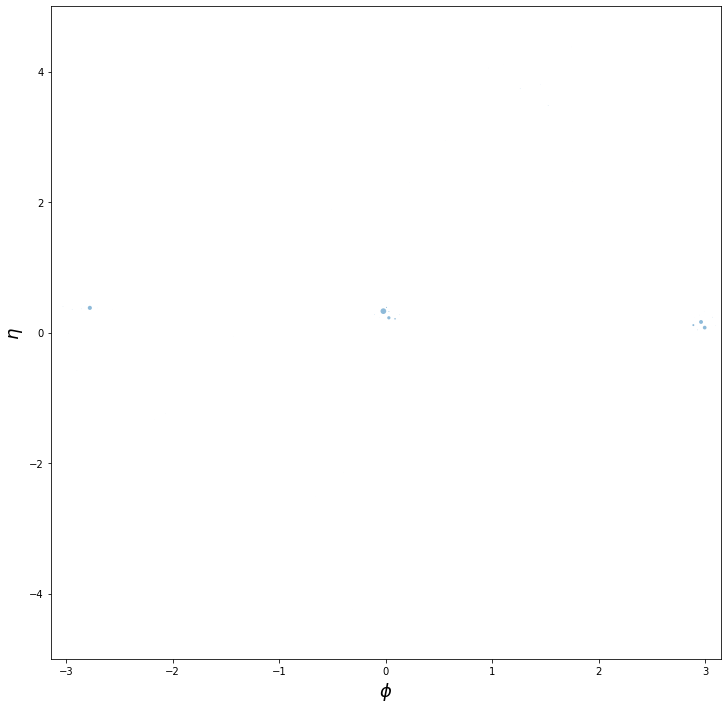

0.0 [0.8885544  0.9153278  0.9295702  0.92755765 0.92146957]


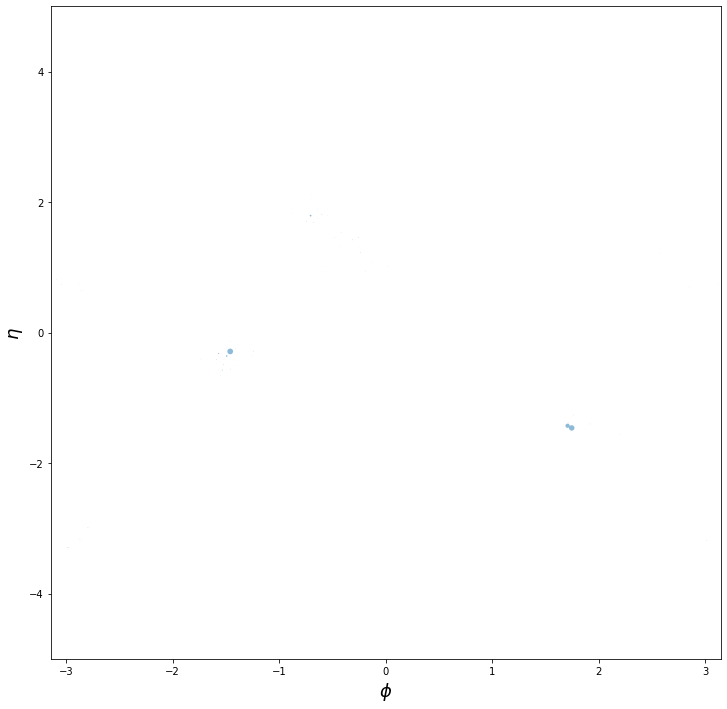

0.0 [0.86992395 0.897596   0.91548234 0.91632247 0.8935368 ]


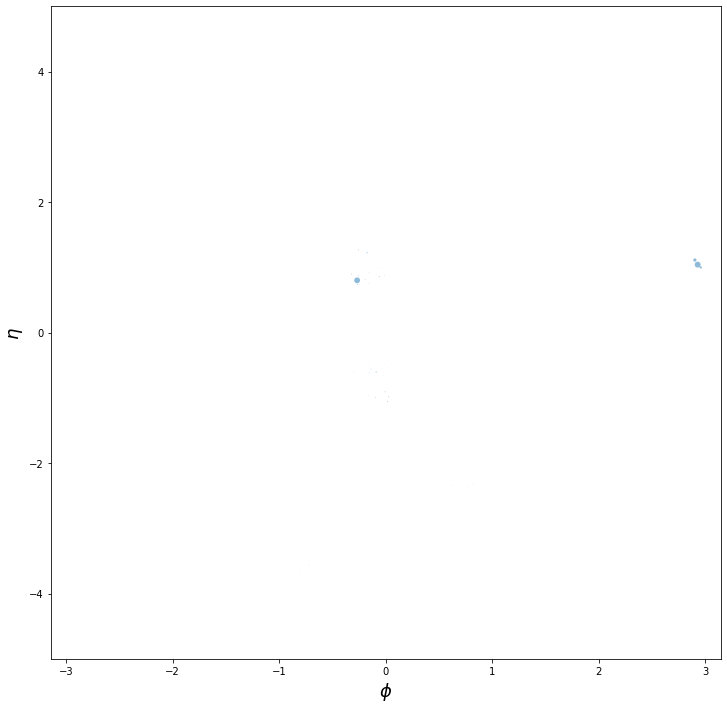

0.0 [0.8761476  0.9139901  0.918438   0.9218718  0.91213596]


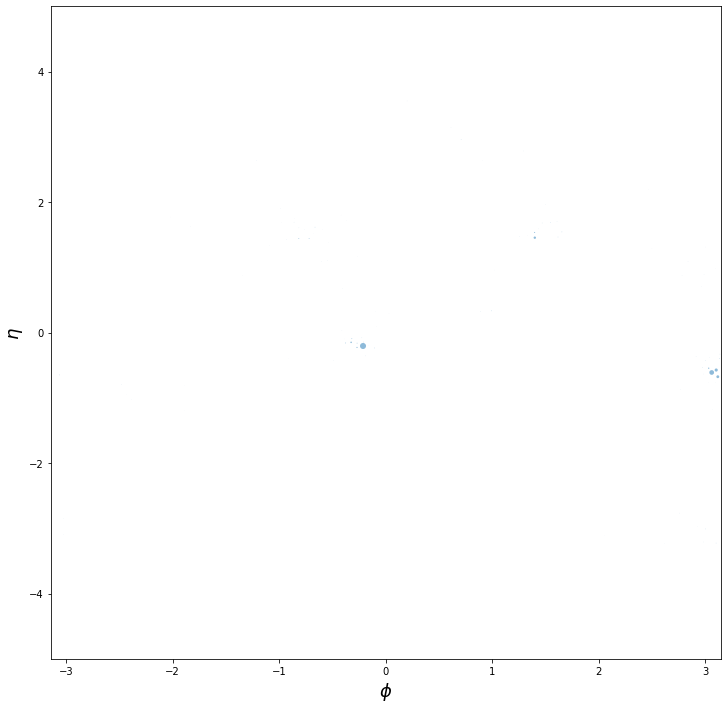

0.0 [0.9419911  0.94312716 0.94030875 0.9348476  0.915539  ]


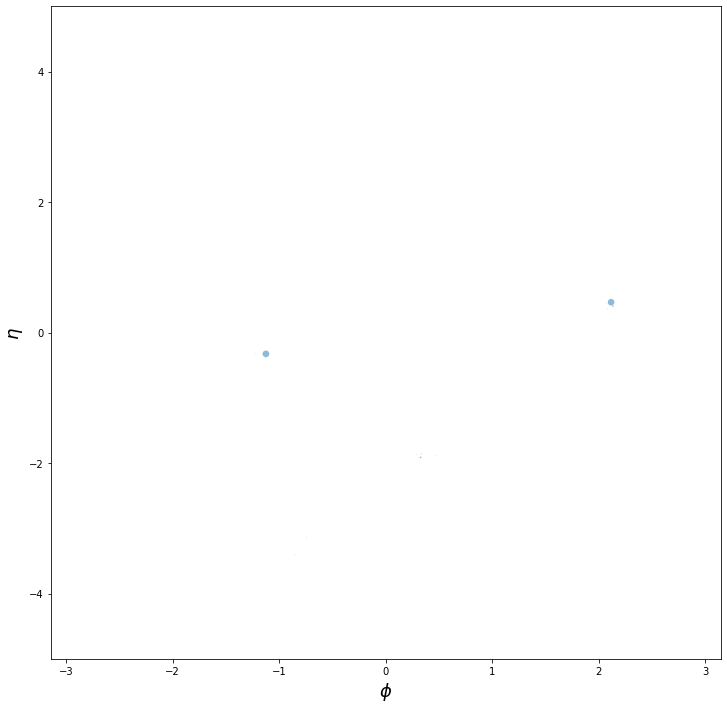

0.0 [0.9240934  0.93360186 0.93624014 0.92399275 0.9062851 ]


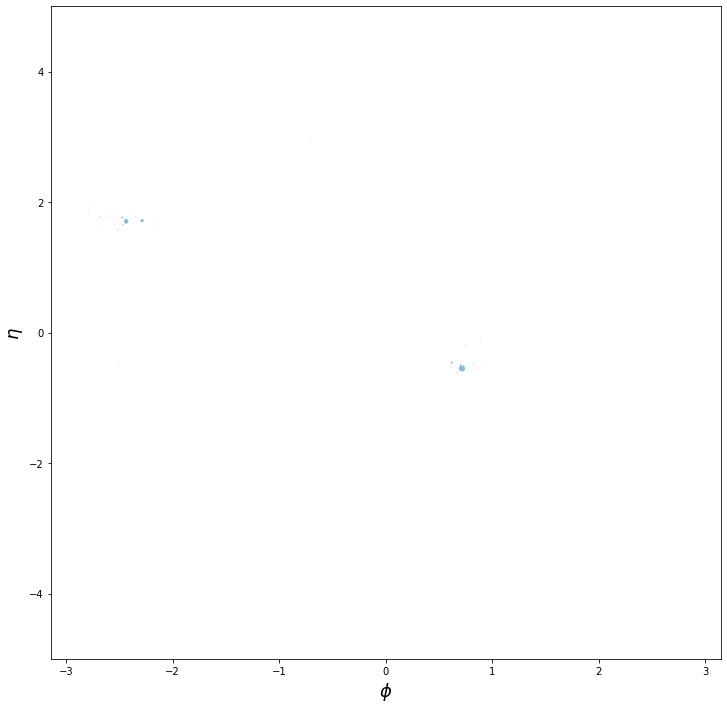

1.0 [0.60229474 0.7934674  0.88344276 0.8884846  0.8662924 ]


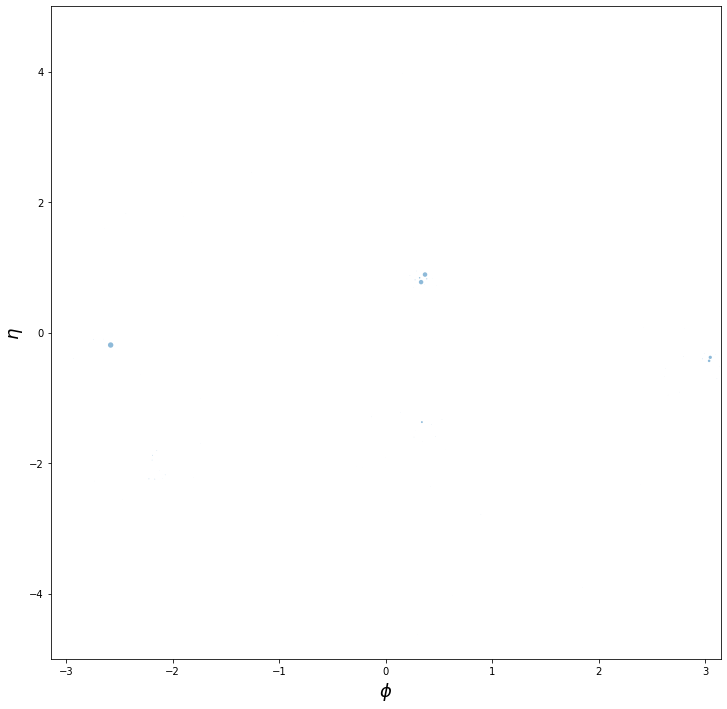

0.0 [0.8910965  0.91198045 0.9268615  0.9248063  0.9167527 ]


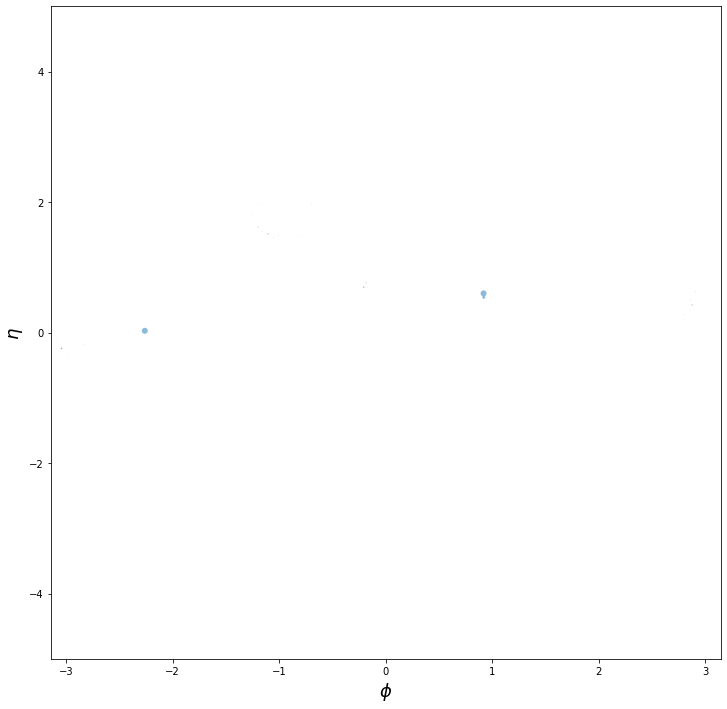

0.0 [0.8671934  0.89707756 0.911272   0.91596085 0.89760387]


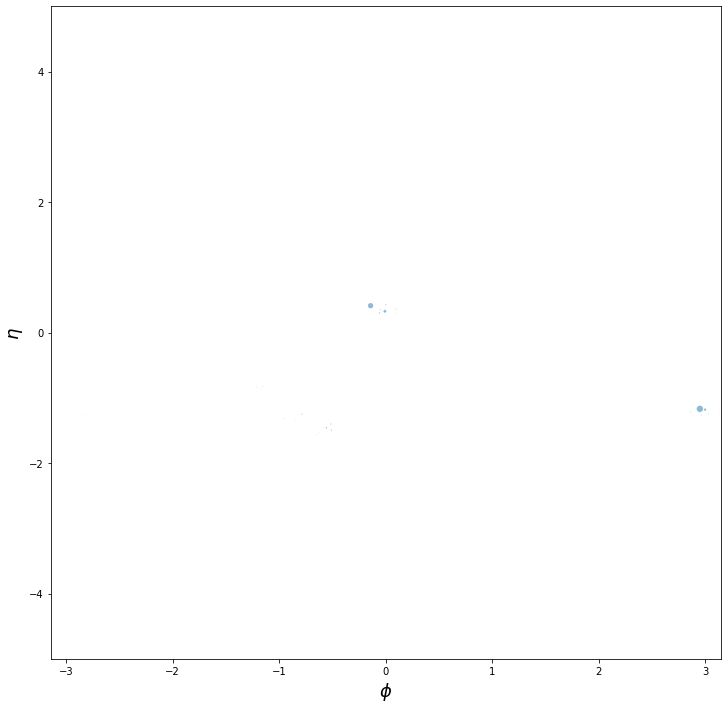

0.0 [0.9343545  0.9316518  0.9287308  0.90105546 0.883288  ]


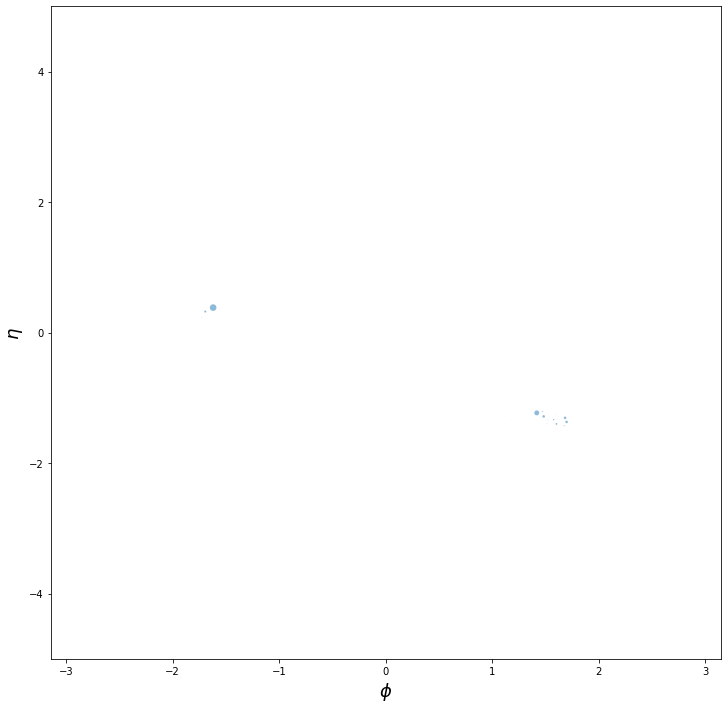

0.0 [0.92448646 0.9358264  0.9370775  0.93156517 0.9191659 ]


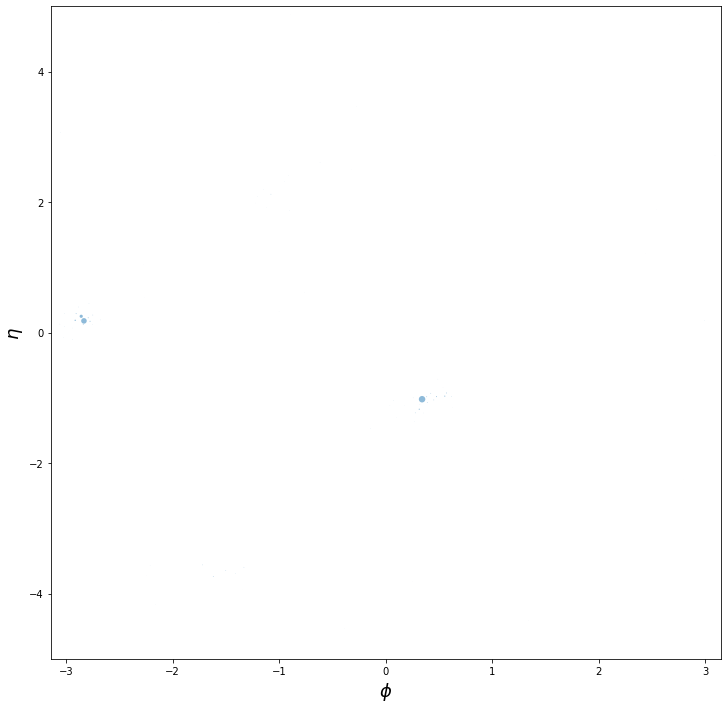

0.0 [0.9407849  0.93989706 0.9360922  0.9300637  0.9147582 ]


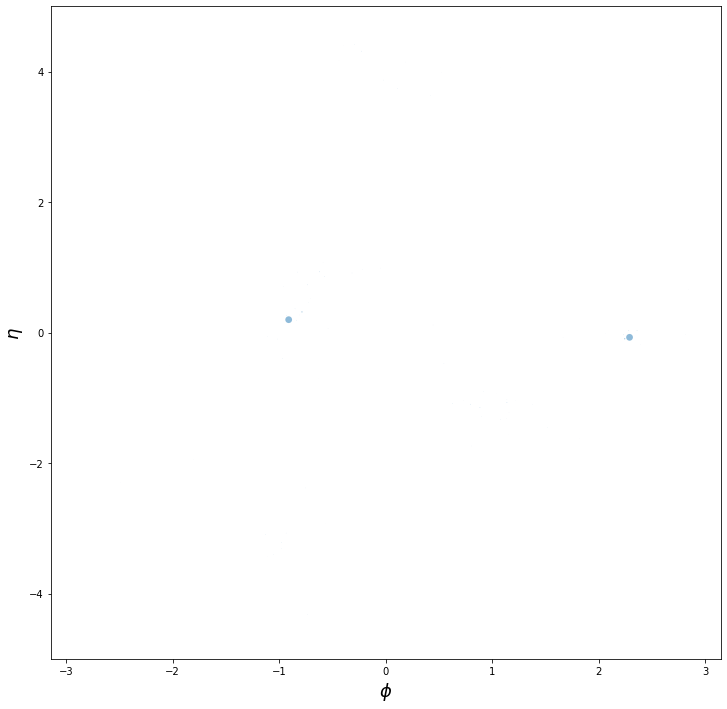

0.0 [0.8122764  0.8911513  0.909582   0.9156757  0.90892464]


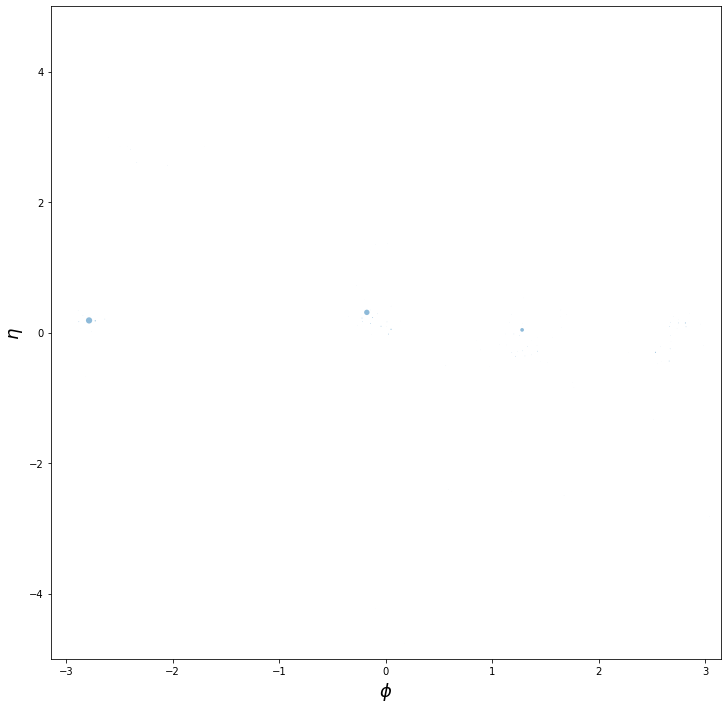

0.0 [0.88272226 0.90599906 0.91449314 0.9066416  0.9017787 ]


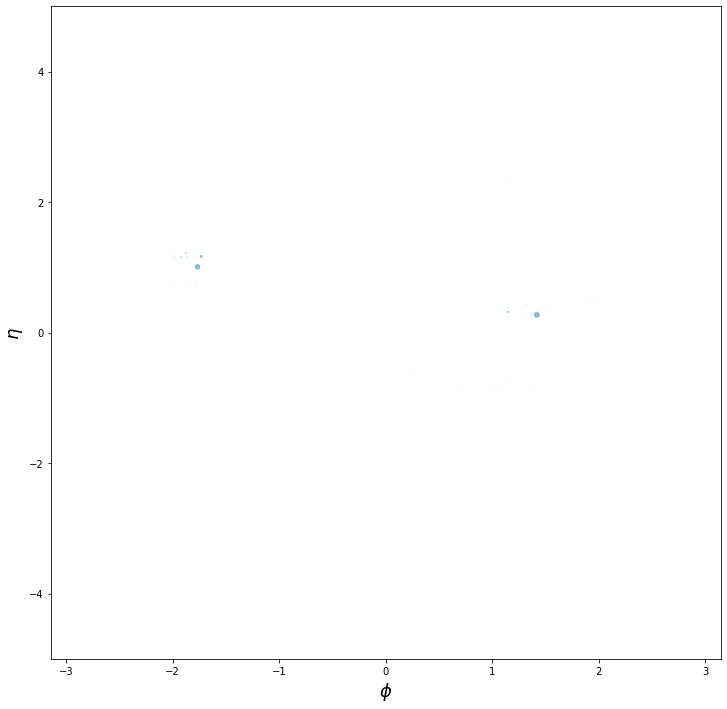

1.0 [0.3219066  0.7701688  0.8947847  0.8975791  0.88577956]


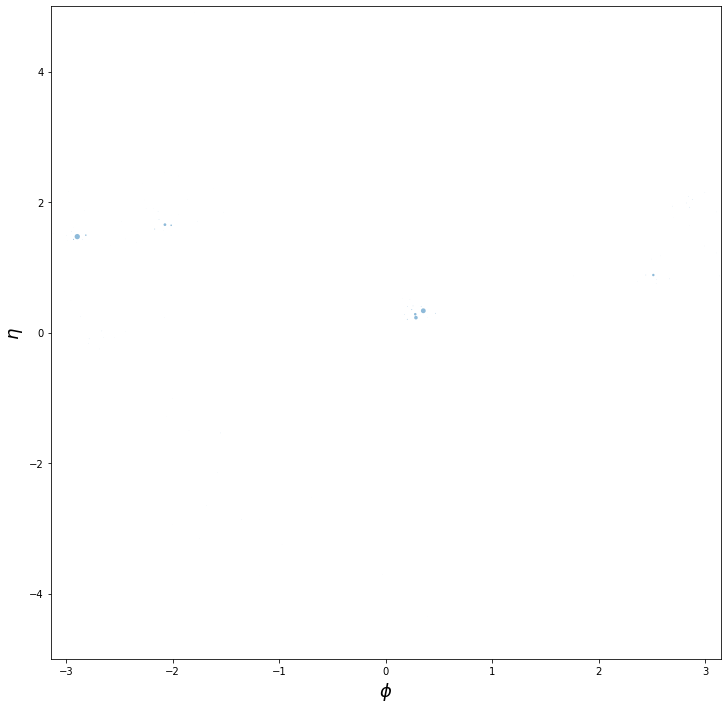

0.0 [0.94127715 0.9459754  0.9419323  0.93594724 0.92259693]


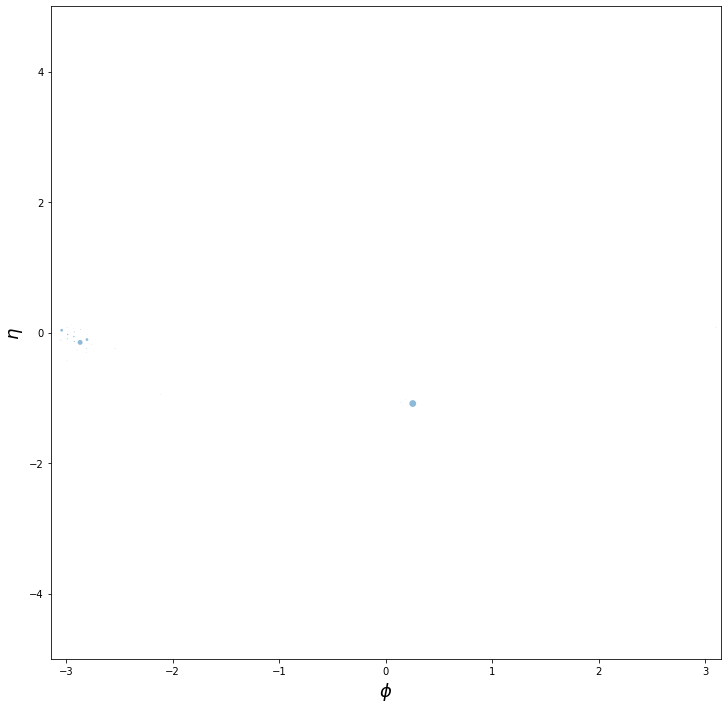

0.0 [0.15218641 0.64619243 0.8785754  0.88471824 0.8649676 ]


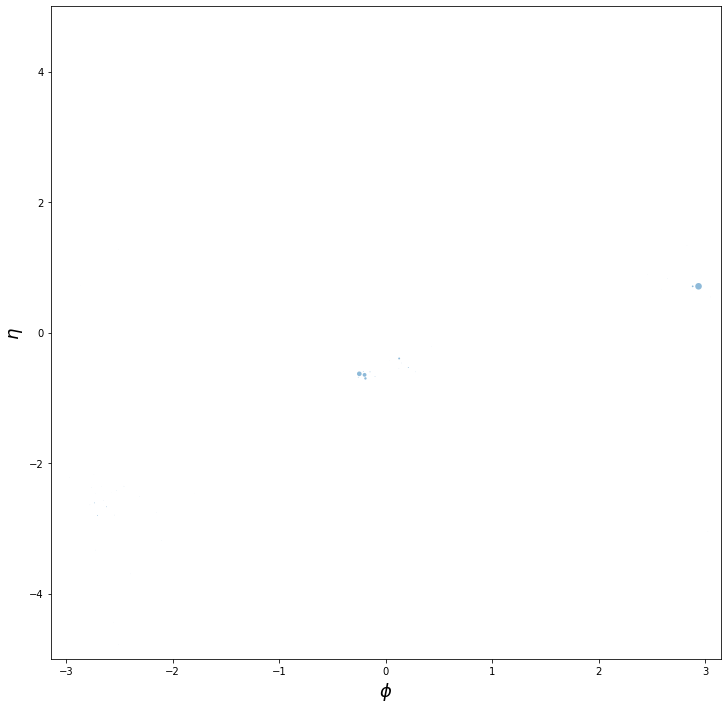

0.0 [0.8039683  0.8794628  0.90909064 0.91542757 0.89980376]


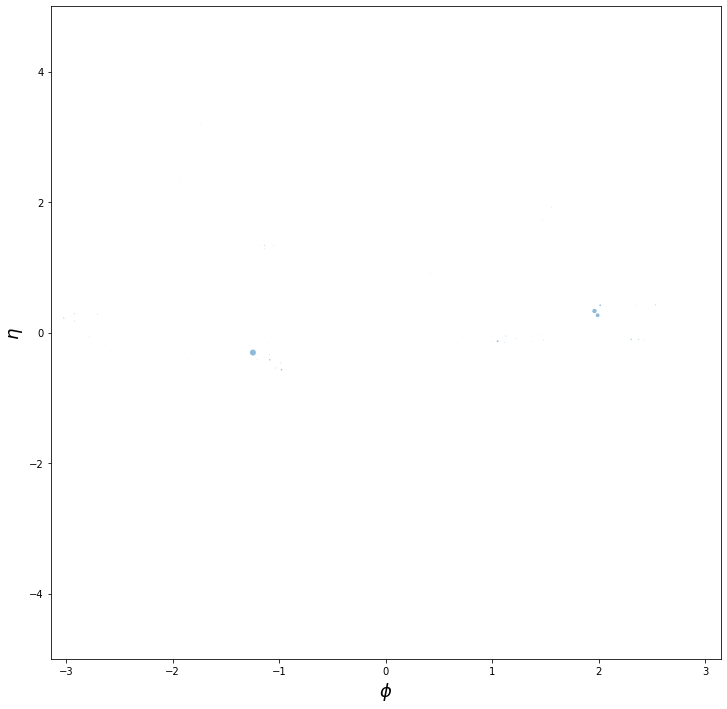

0.0 [0.94616634 0.9469384  0.93987775 0.93054205 0.9209436 ]


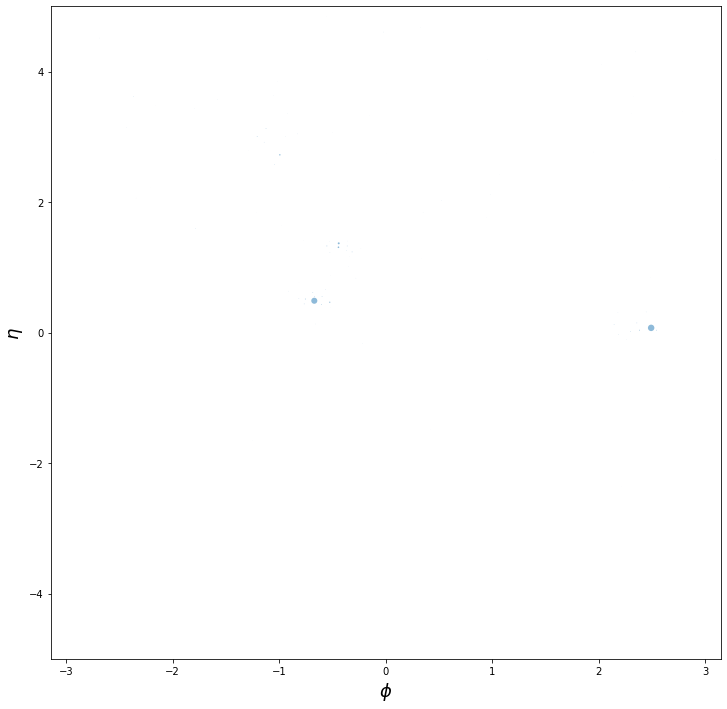

0.0 [0.5234648  0.7253299  0.8607607  0.85247654 0.81639546]


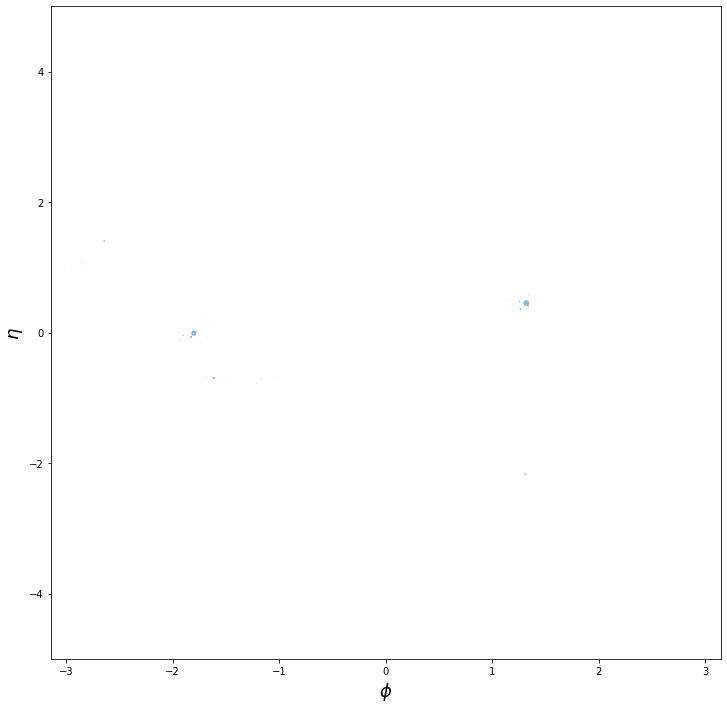

0.0 [0.9323224  0.93263596 0.93018043 0.929679   0.911628  ]


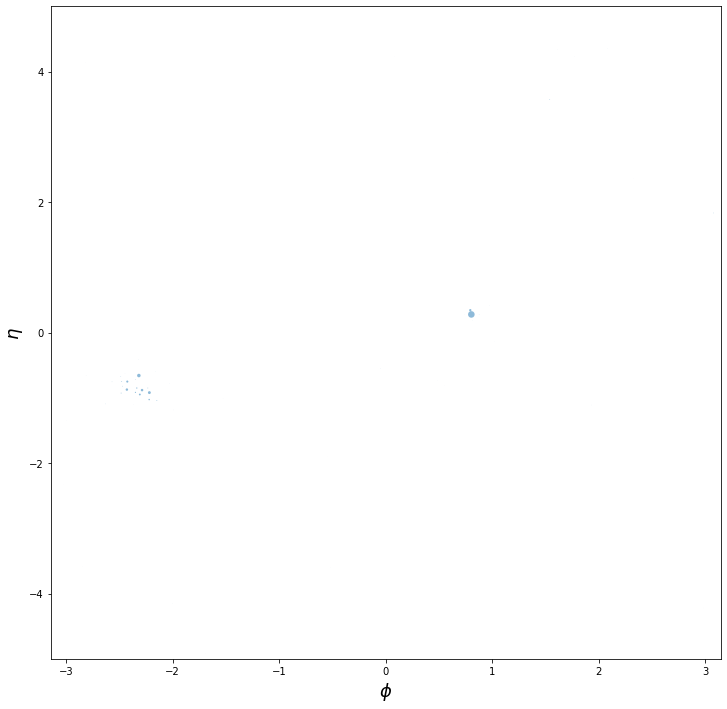

1.0 [0.00414943 0.04956303 0.8087484  0.821315   0.8068824 ]


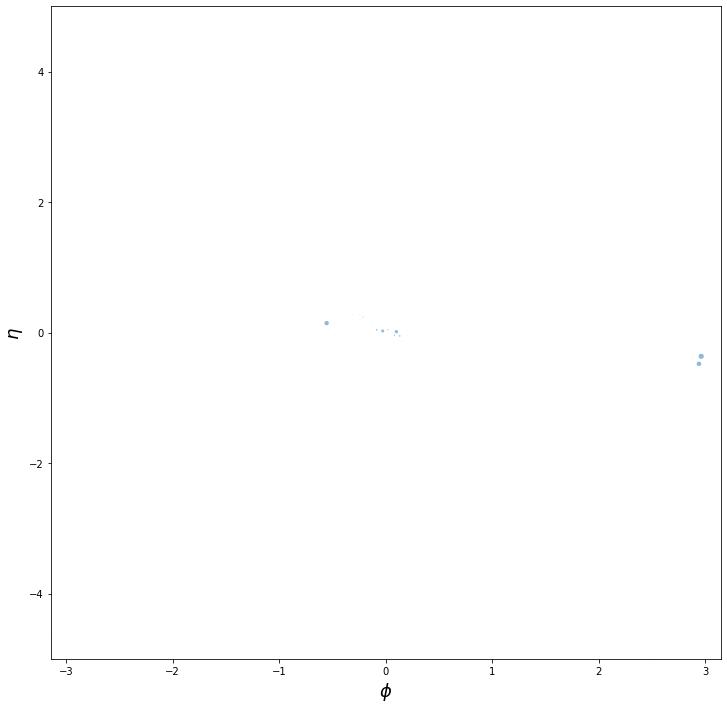

0.0 [0.90599304 0.9218395  0.9263642  0.9218739  0.90789783]


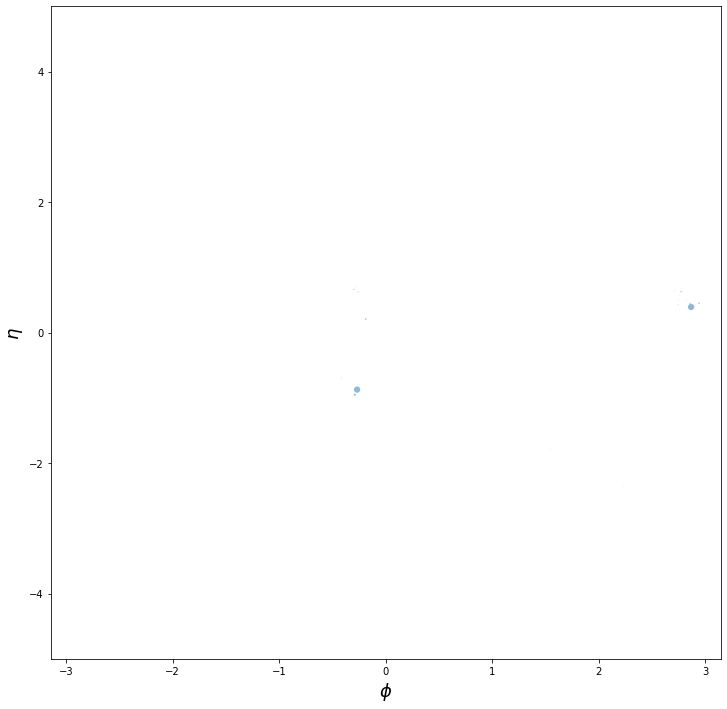

0.0 [0.8912664  0.91223234 0.92615676 0.91916525 0.91677904]


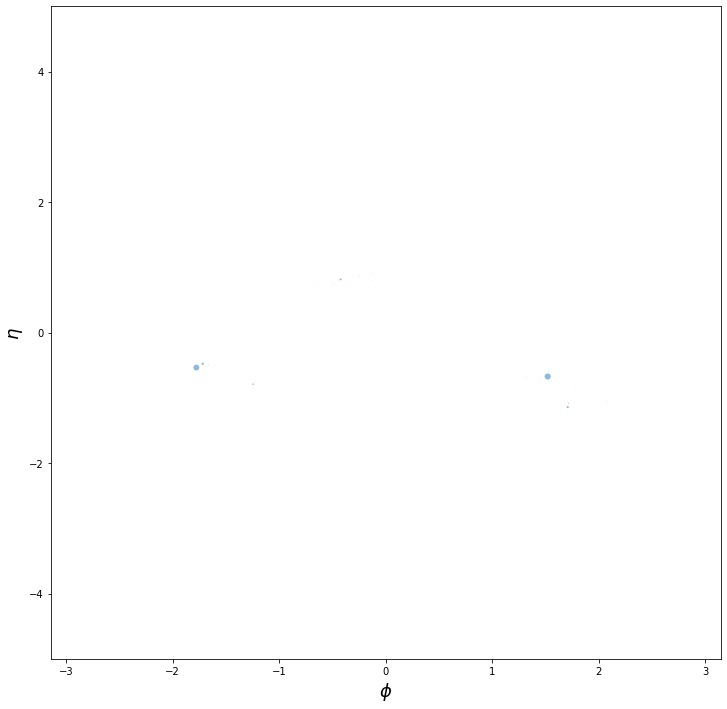

0.0 [0.63722265 0.8386504  0.90425855 0.9111254  0.8877139 ]


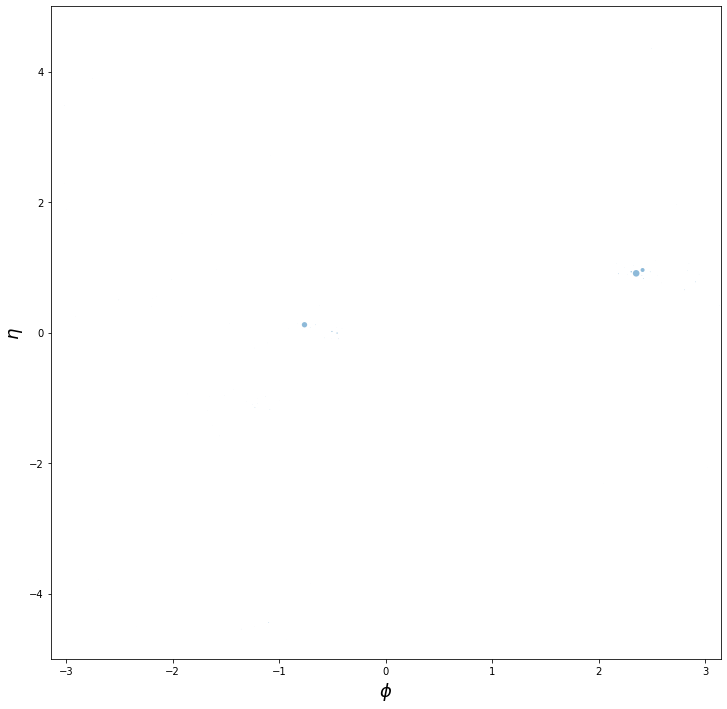

0.0 [0.78088695 0.860203   0.9099378  0.90820765 0.8961144 ]


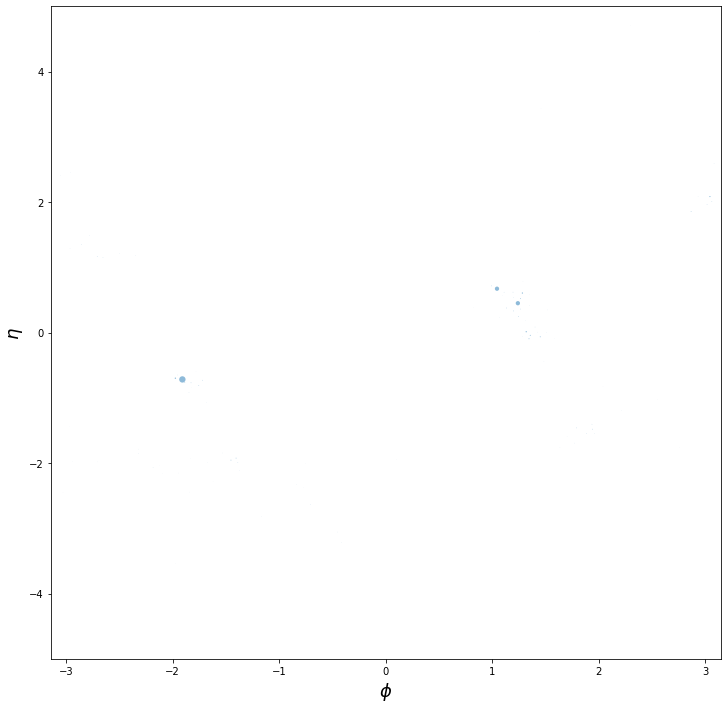

1.0 [0.89189374 0.9074281  0.91056556 0.8995552  0.8947345 ]


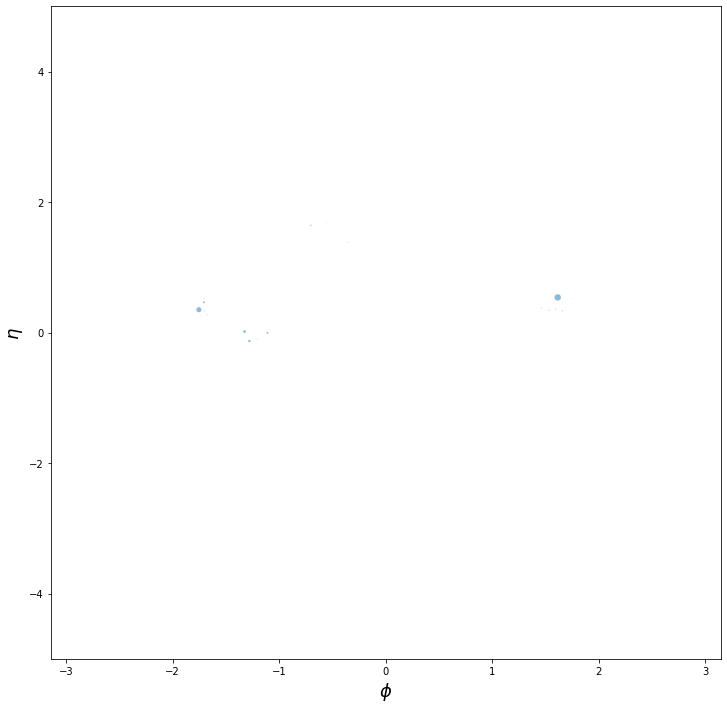

0.0 [0.82324666 0.86999905 0.9042422  0.90515286 0.89171946]


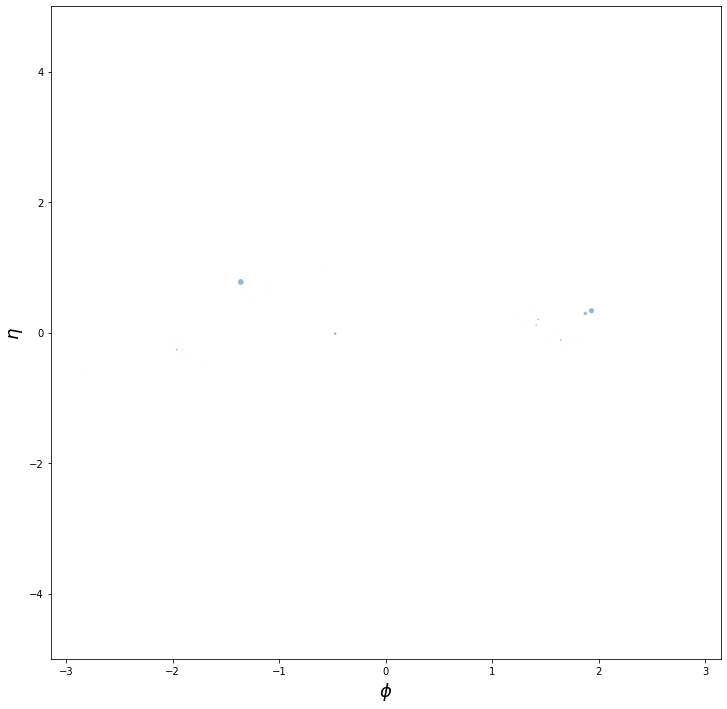

0.0 [0.740023   0.8557433  0.9142742  0.92001224 0.9109693 ]


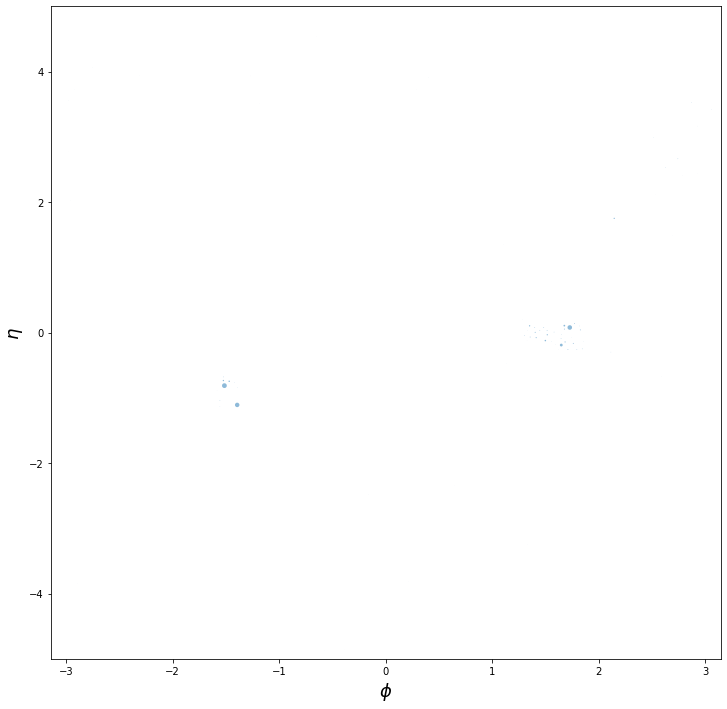

0.0 [0.8680399  0.89677054 0.91347224 0.909298   0.89134437]


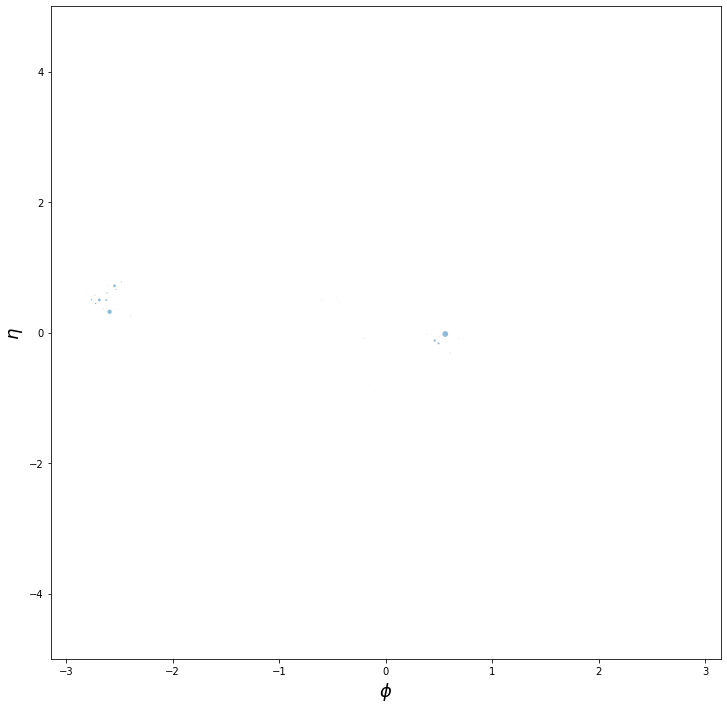

0.0 [0.91846263 0.9241848  0.9244286  0.9212514  0.8939424 ]


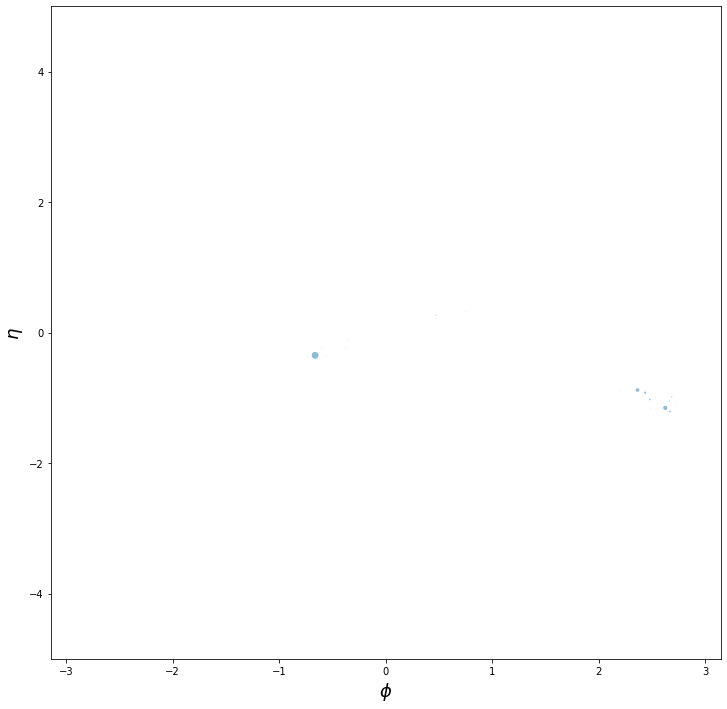

1.0 [0.9075822  0.91406137 0.925771   0.91398853 0.90596586]


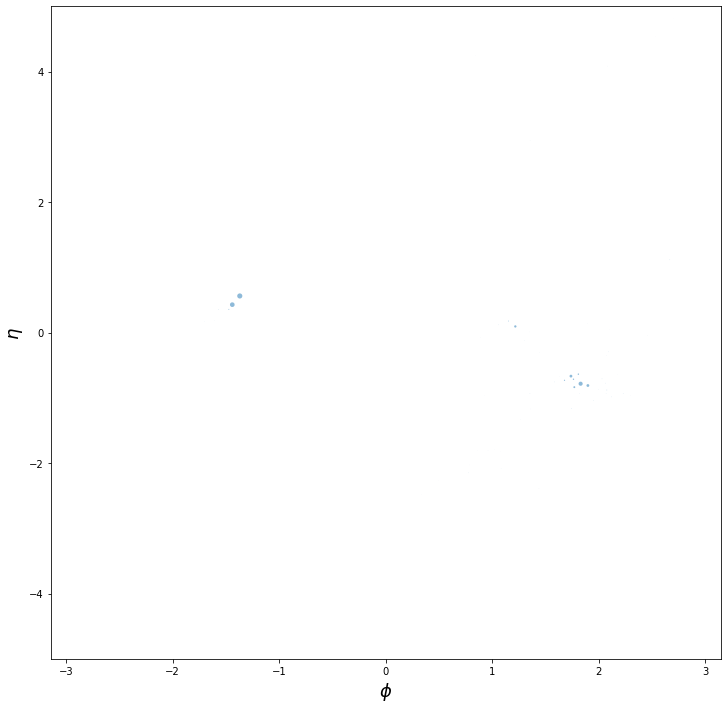

0.0 [0.92626745 0.9320735  0.9281768  0.9251774  0.9087488 ]


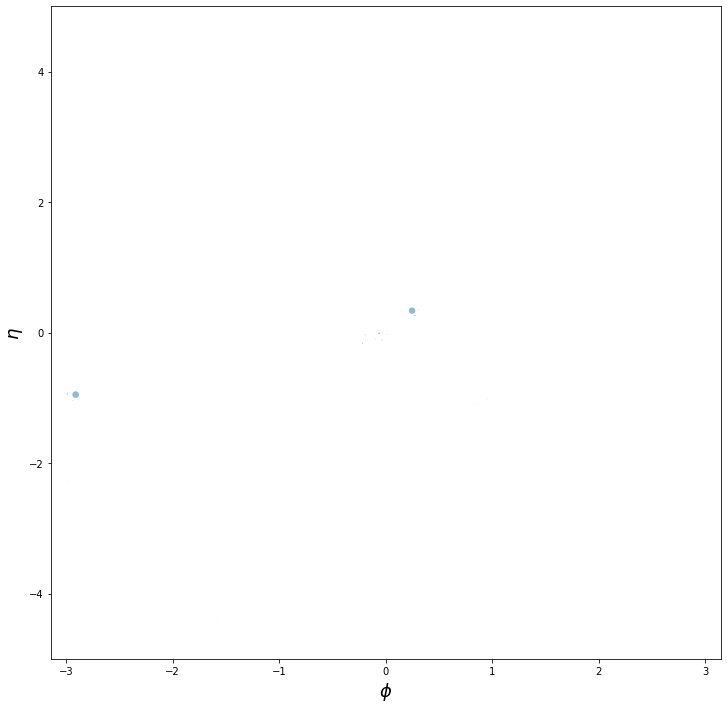

0.0 [0.9498324  0.9489564  0.94181883 0.93178594 0.9163389 ]


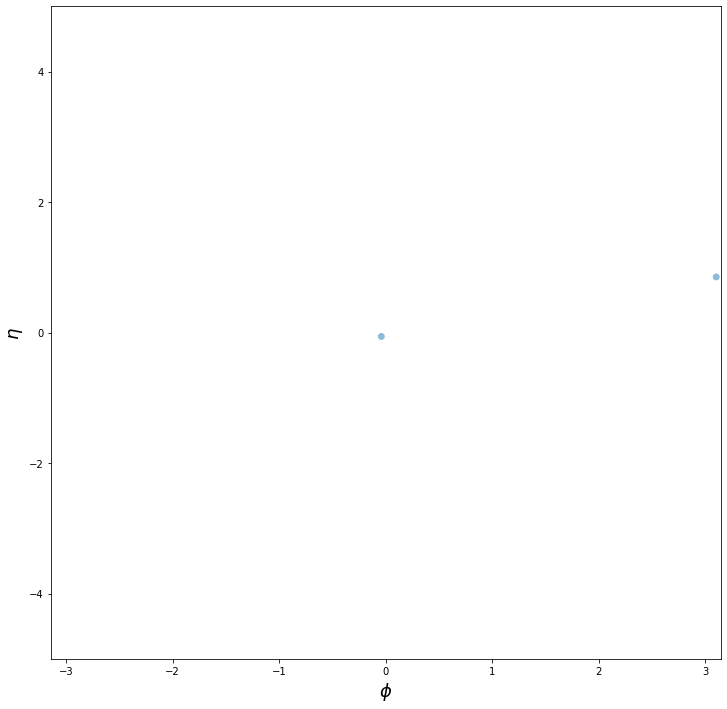

0.0 [7.7485981e-07 3.7907117e-05 2.1167637e-01 2.7142569e-01 5.7073087e-01]


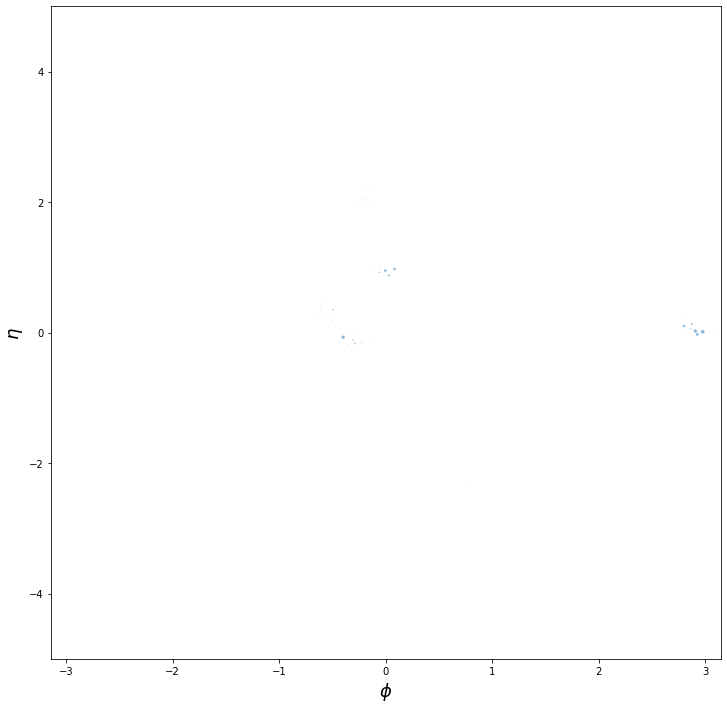

1.0 [0.8831341  0.87990755 0.90730745 0.9070923  0.88587177]


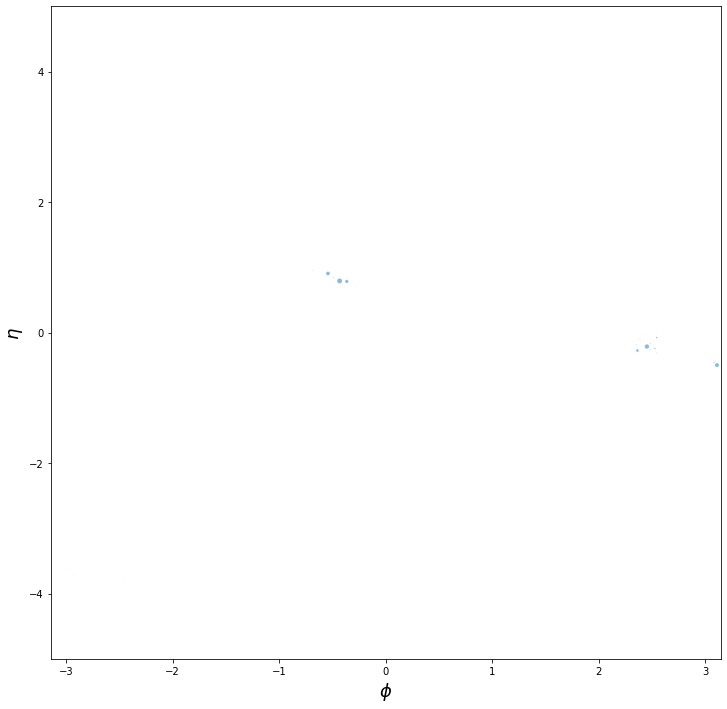

0.0 [0.8656438  0.89774793 0.9204609  0.91413254 0.9122228 ]


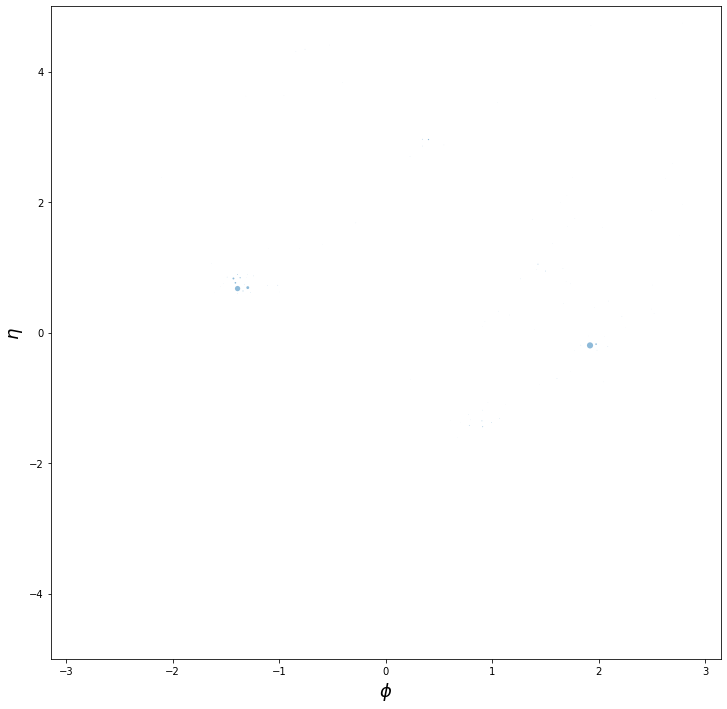

0.0 [0.57633513 0.76020163 0.88959324 0.89094484 0.87919164]


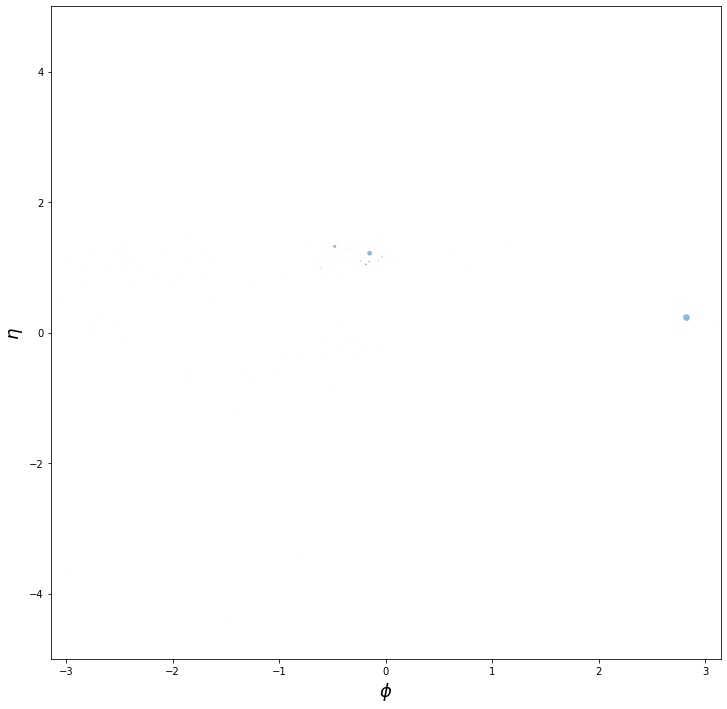

0.0 [0.90199536 0.9178302  0.9248753  0.9182264  0.910931  ]


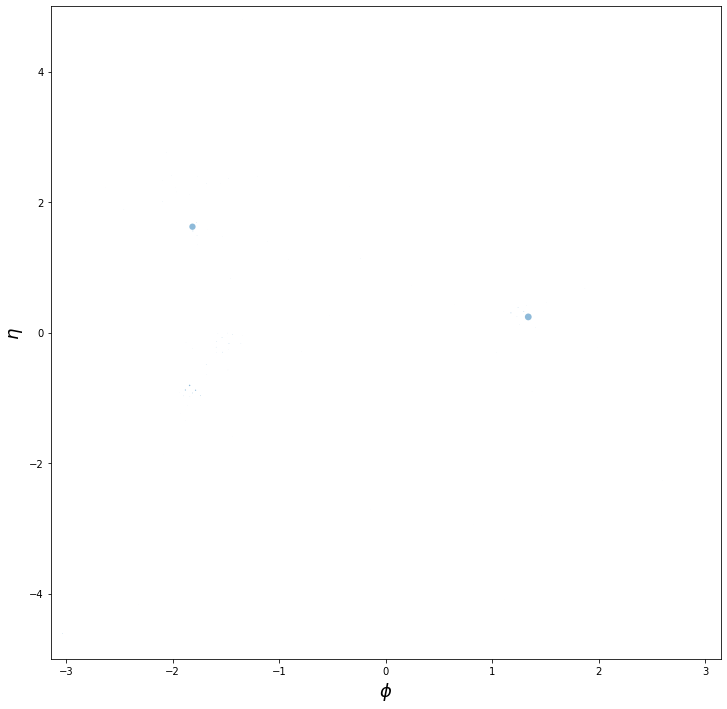

0.0 [0.7591293  0.84866536 0.90912426 0.9145689  0.902927  ]


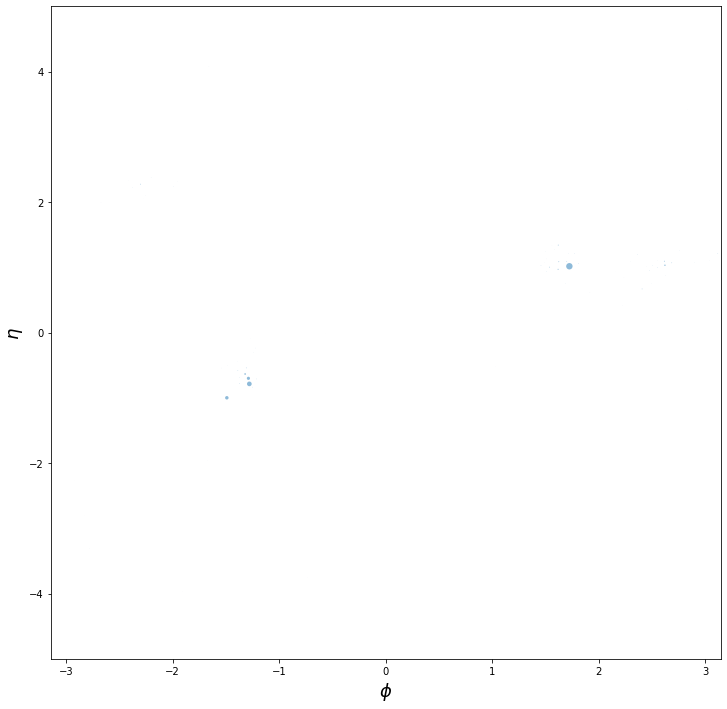

0.0 [0.89466715 0.91000974 0.92023706 0.91967016 0.89814425]


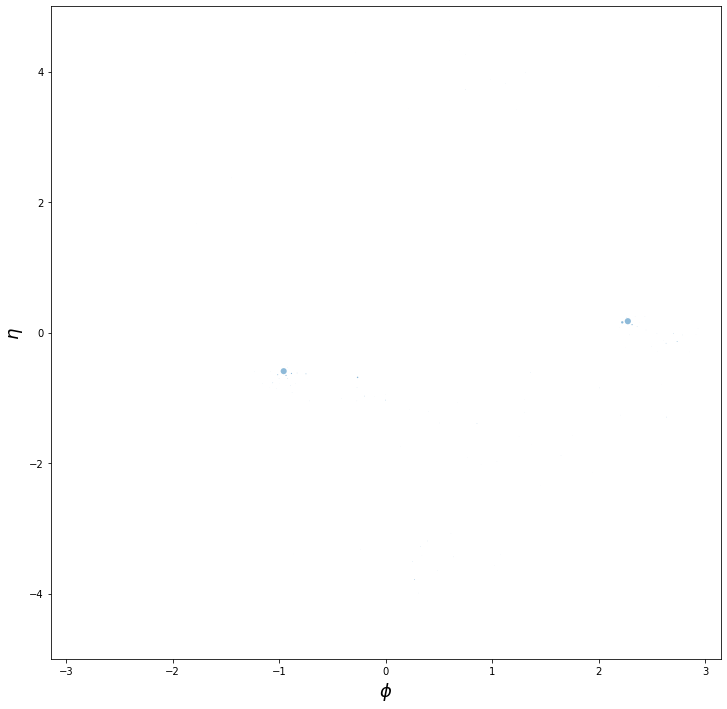

0.0 [0.9204728  0.93020356 0.9339931  0.93246114 0.9184386 ]


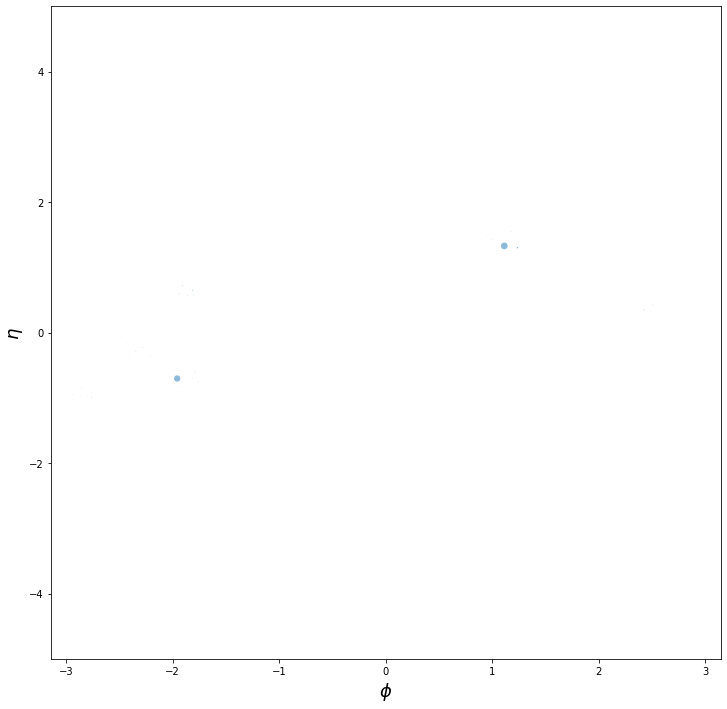

0.0 [0.91661876 0.931417   0.9315802  0.93648046 0.9226235 ]


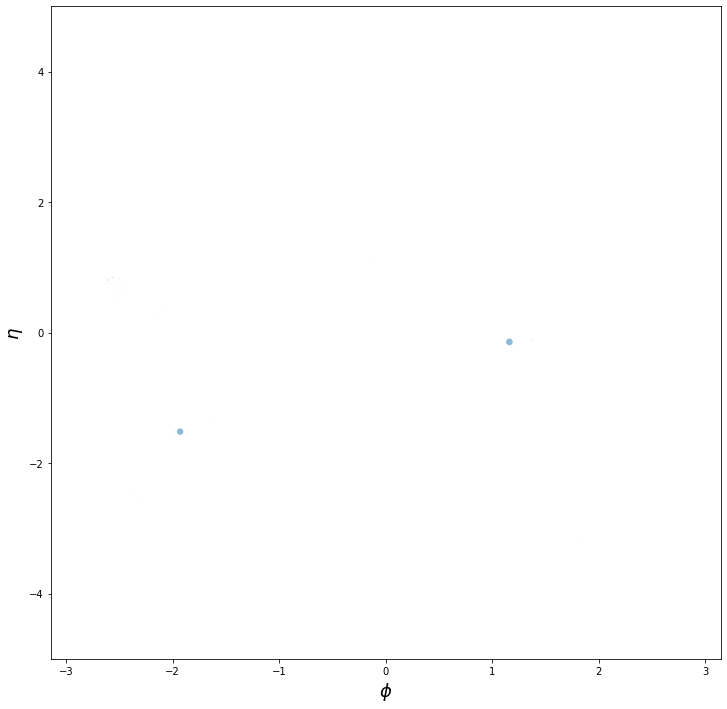

0.0 [6.348630e-04 8.070138e-03 7.452911e-01 7.746262e-01 7.499403e-01]


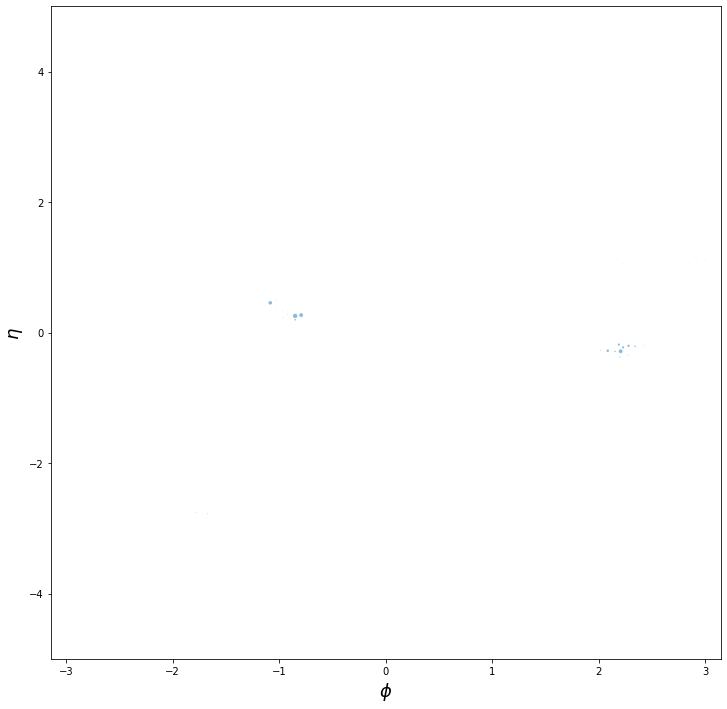

0.0 [0.88779527 0.91436285 0.92874753 0.927184   0.9185691 ]


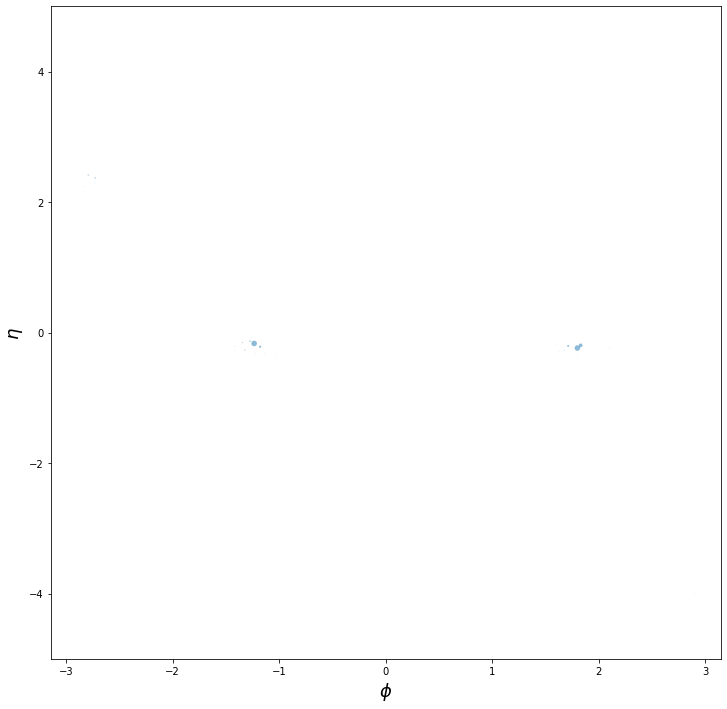

1.0 [0.88858825 0.9037273  0.90428036 0.9033962  0.87932885]


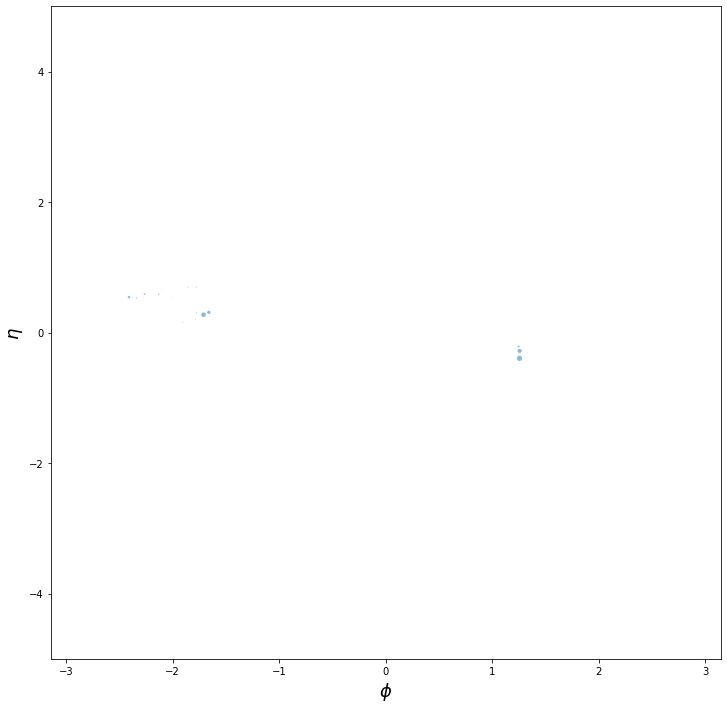

1.0 [0.6980664  0.82738787 0.90265125 0.8905433  0.87573147]


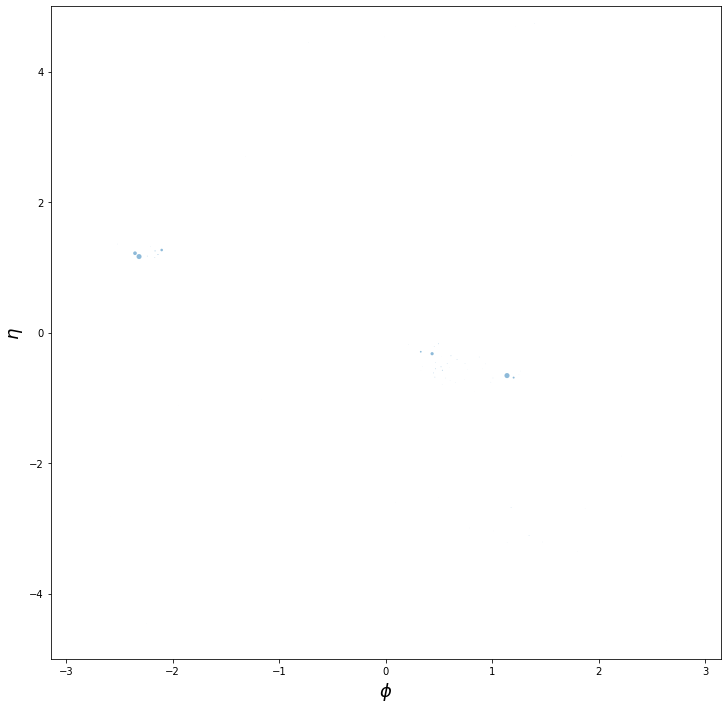

0.0 [0.01454712 0.30026692 0.8824732  0.86180675 0.86826354]


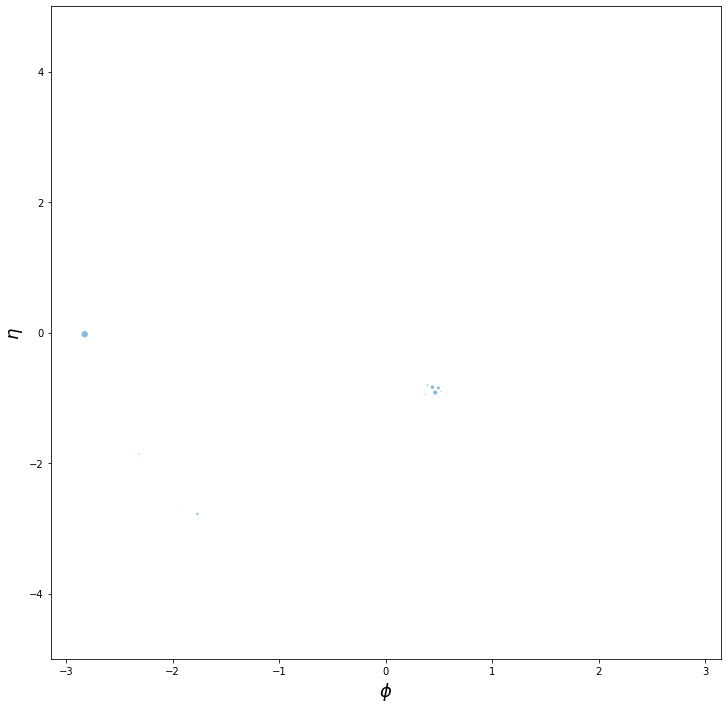

0.0 [0.9458738  0.9463055  0.9392332  0.9336278  0.92139554]


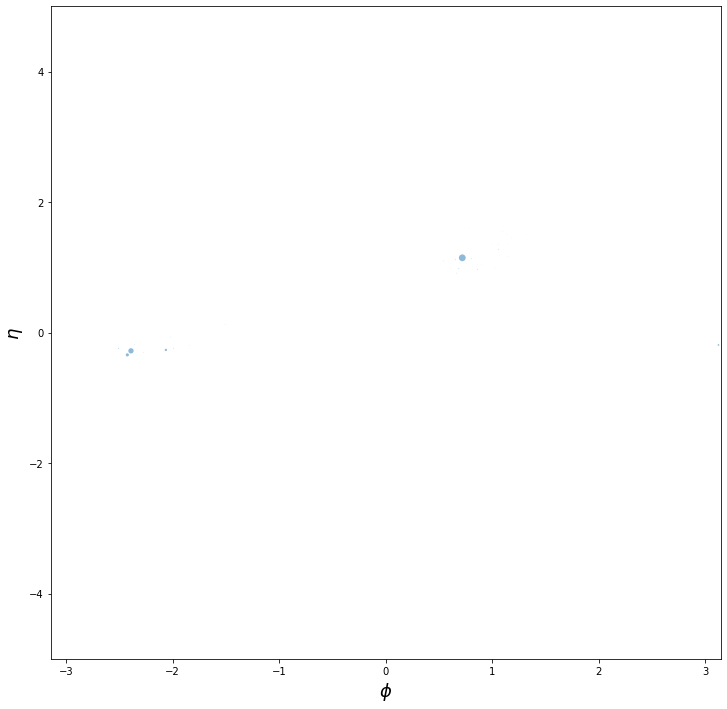

0.0 [7.4381067e-05 2.7525367e-02 6.9252425e-01 7.5397021e-01 7.8895301e-01]


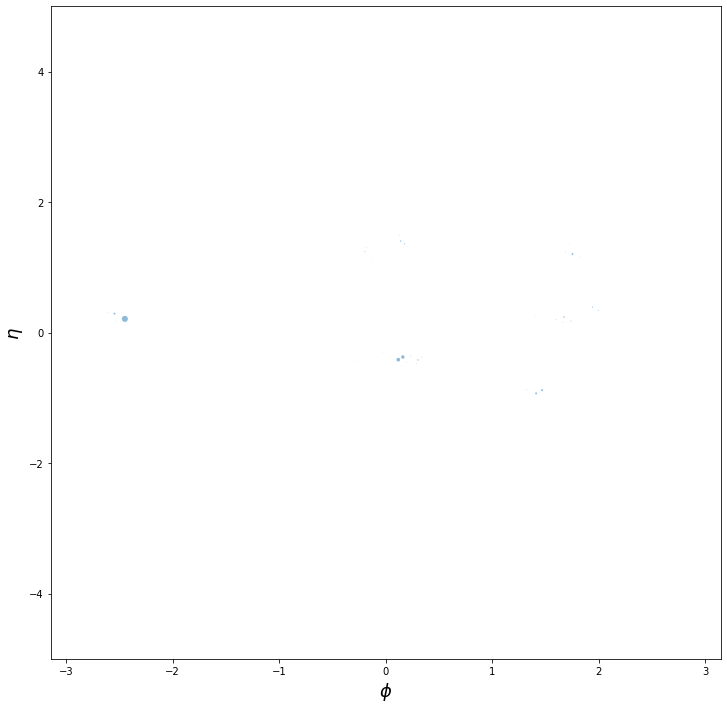

0.0 [0.8694486  0.87160075 0.9007021  0.8732937  0.87216026]


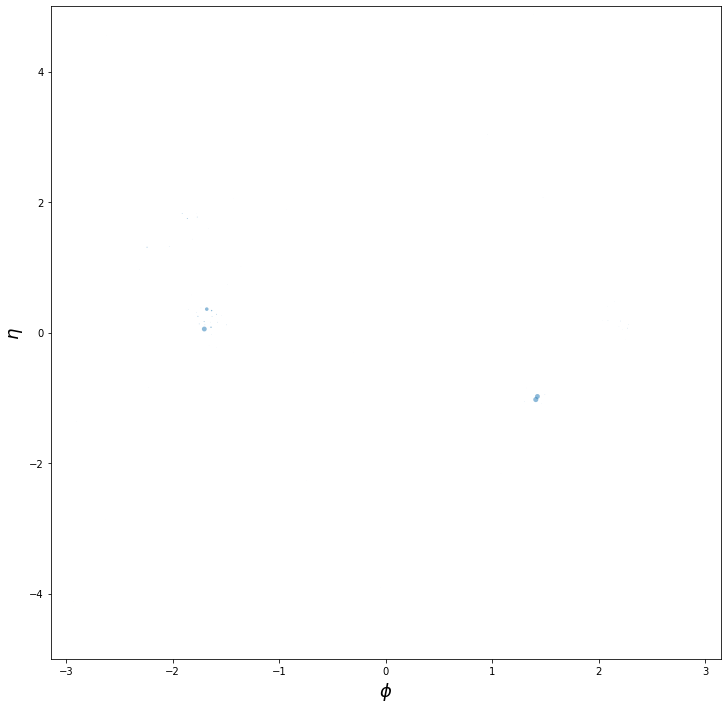

0.0 [0.871876   0.9029226  0.9162683  0.91669834 0.8974549 ]


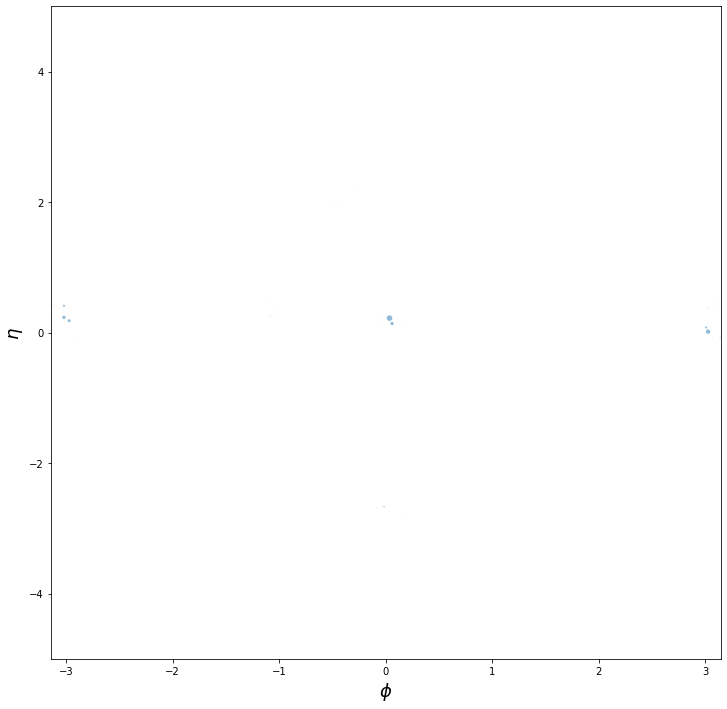

0.0 [0.94073635 0.94473237 0.94032234 0.93717396 0.92527616]


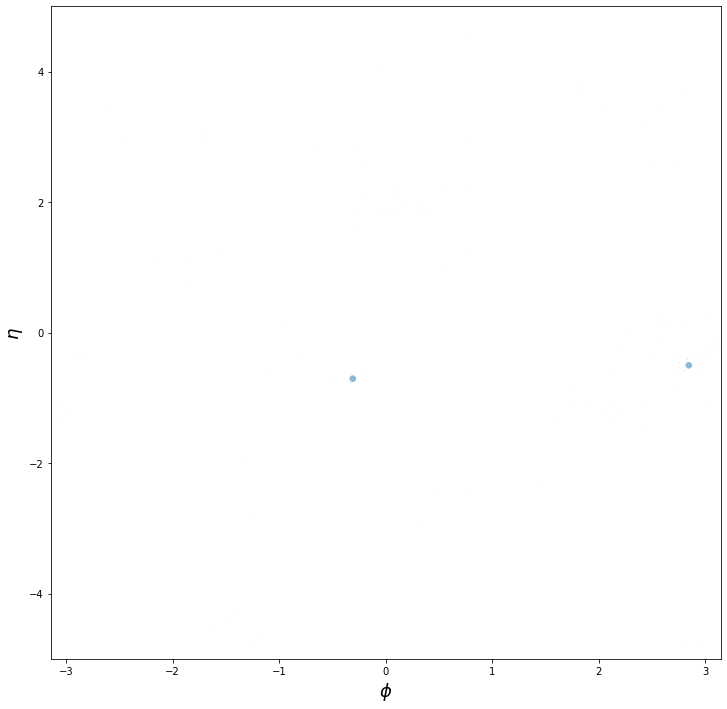

0.0 [0.00764371 0.14971437 0.827047   0.8361017  0.8194826 ]


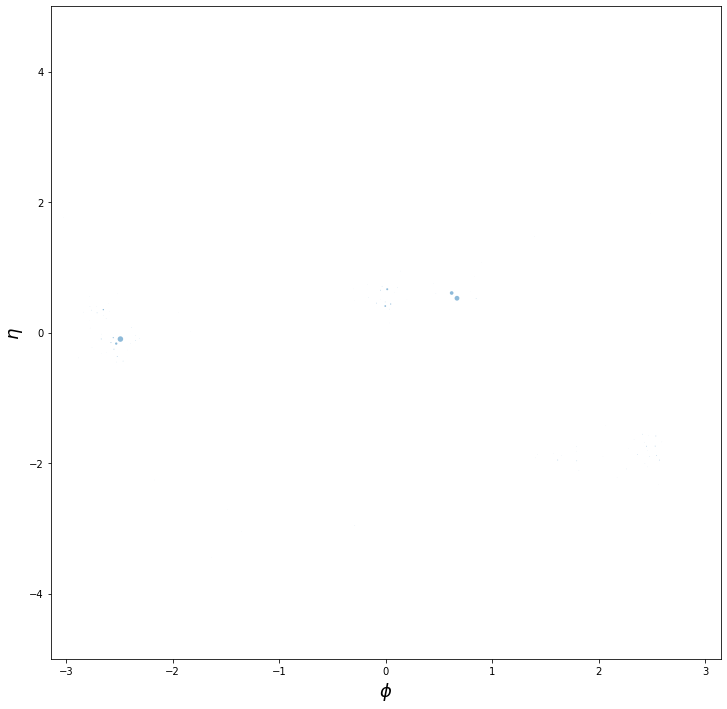

0.0 [0.88352233 0.9131914  0.9258747  0.9249147  0.9080713 ]


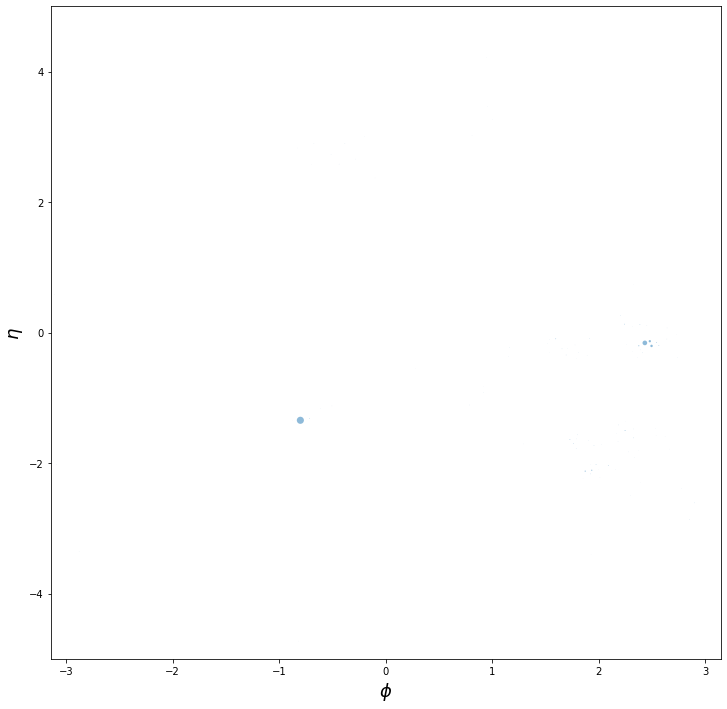

0.0 [0.9184251 0.9243868 0.9224268 0.9237459 0.9051587]


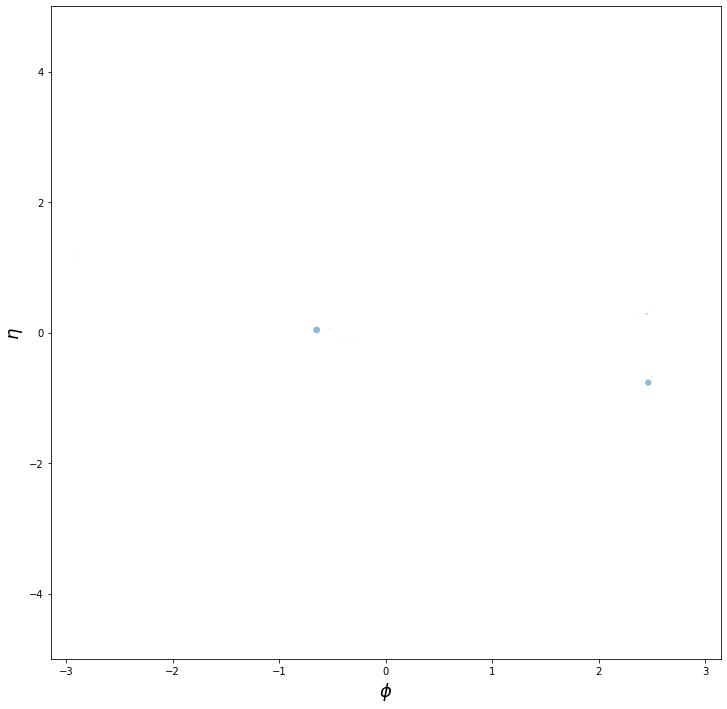

0.0 [0.0000000e+00 6.5565064e-07 1.1400188e-02 2.1598274e-02 1.2912008e-01]


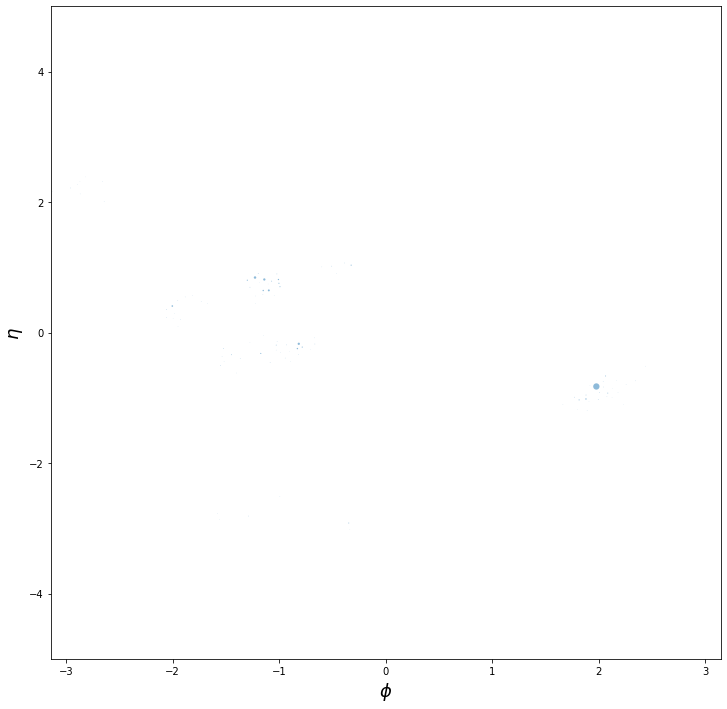

0.0 [0.926035   0.92613506 0.92829907 0.9227997  0.9047738 ]


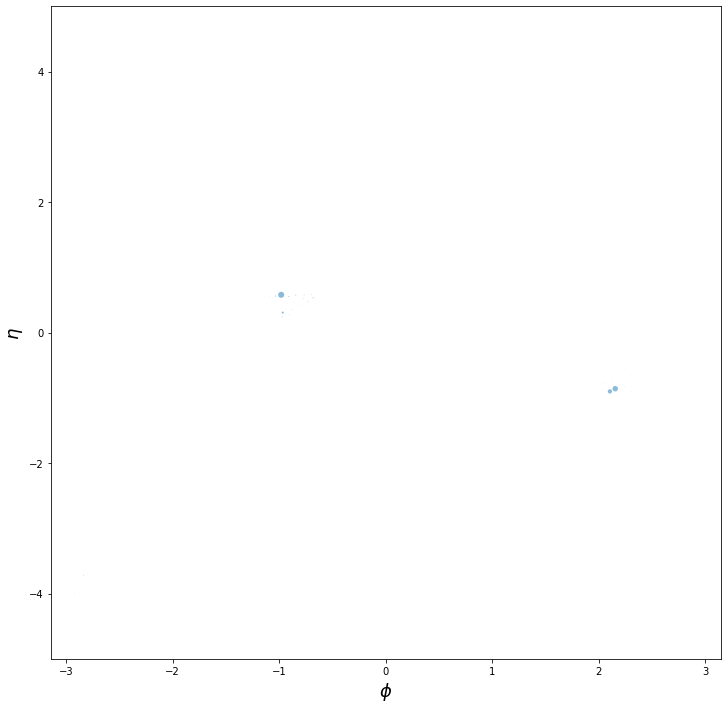

0.0 [0.90556794 0.9218715  0.927678   0.91930664 0.91111535]


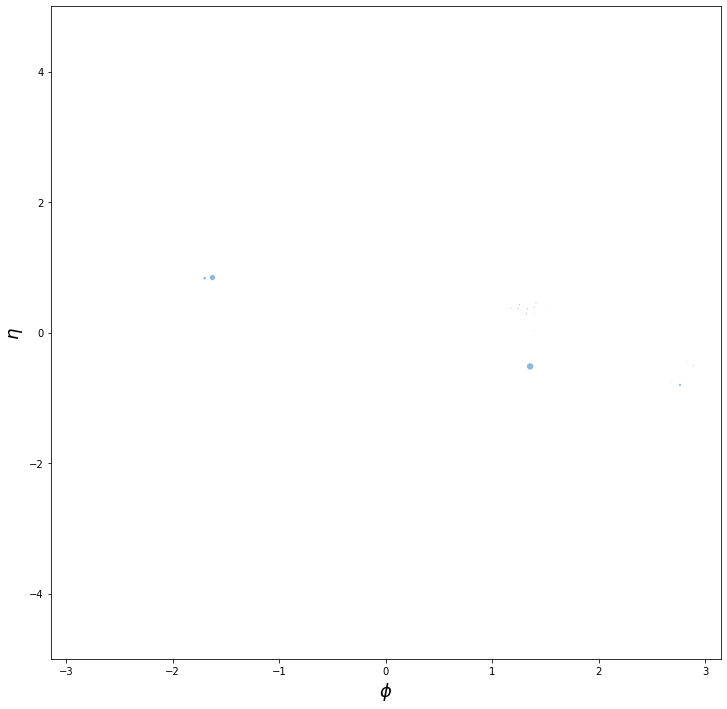

0.0 [0.6814599  0.8235975  0.9058414  0.91079974 0.8982627 ]


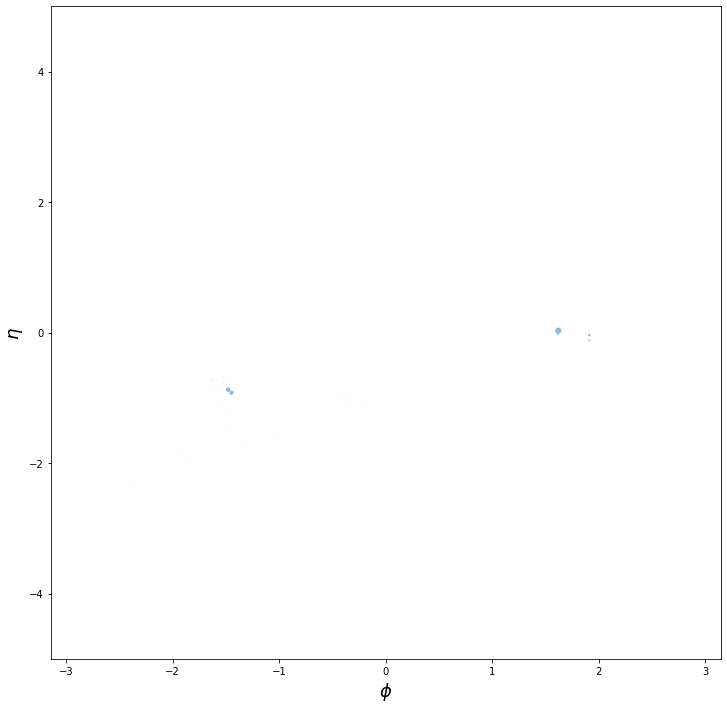

1.0 [0.91038597 0.9221743  0.92554504 0.91802835 0.9069112 ]


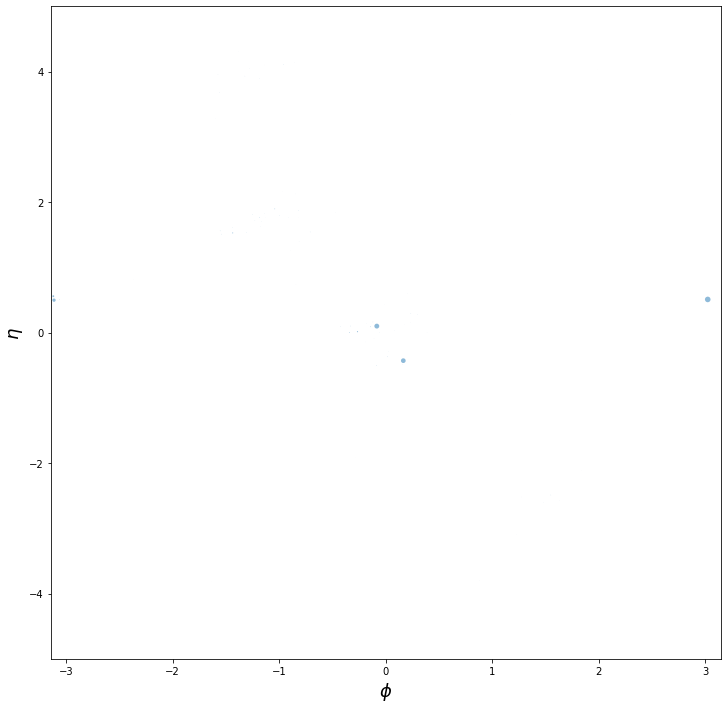

0.0 [0.93150175 0.9366008  0.93502456 0.9273592  0.9122035 ]


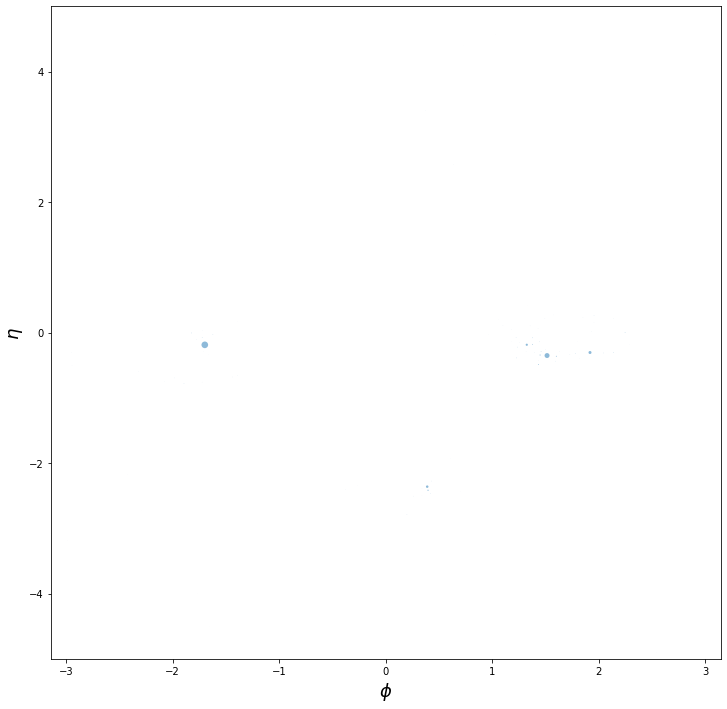

0.0 [0.7777486  0.85880035 0.900163   0.8996607  0.88486296]


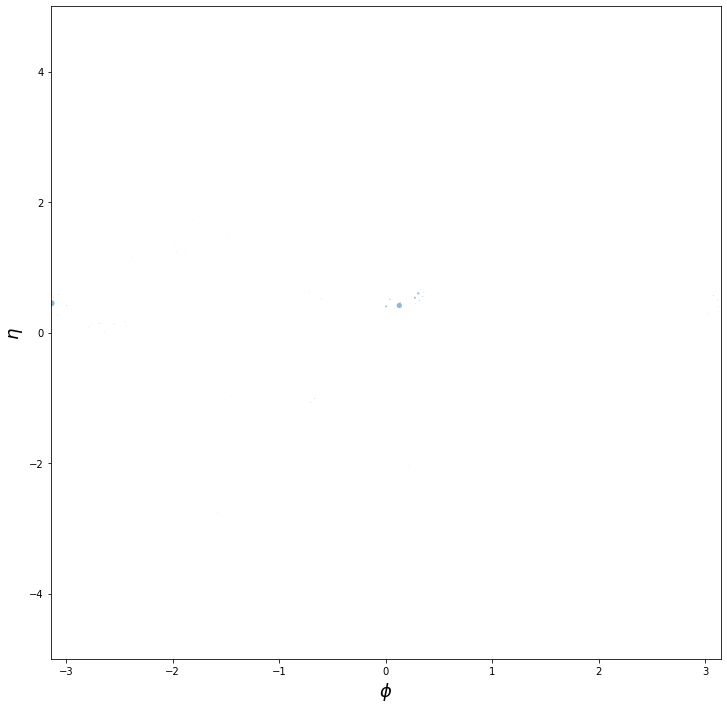

0.0 [0.90524656 0.91232204 0.9245767  0.92249286 0.90561545]


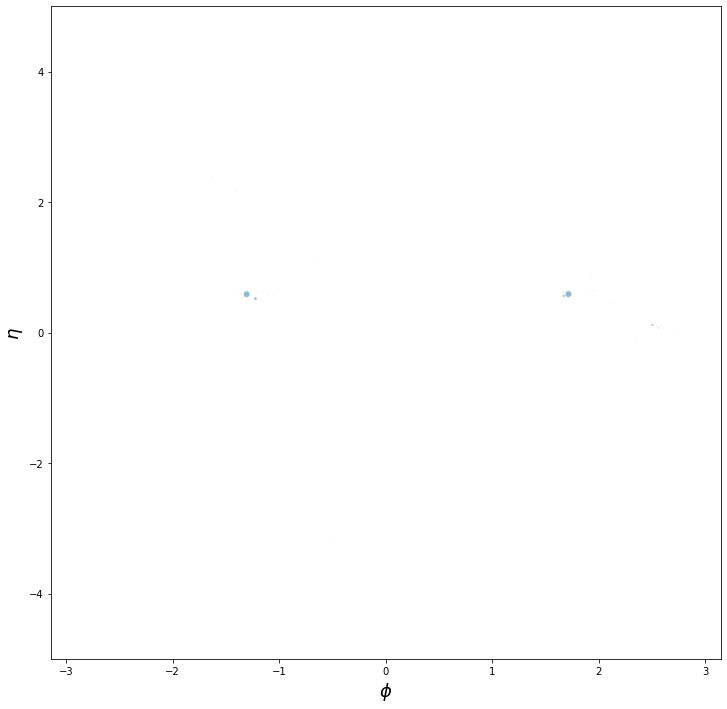

0.0 [0.8549434  0.89099455 0.9120927  0.91274506 0.88876015]


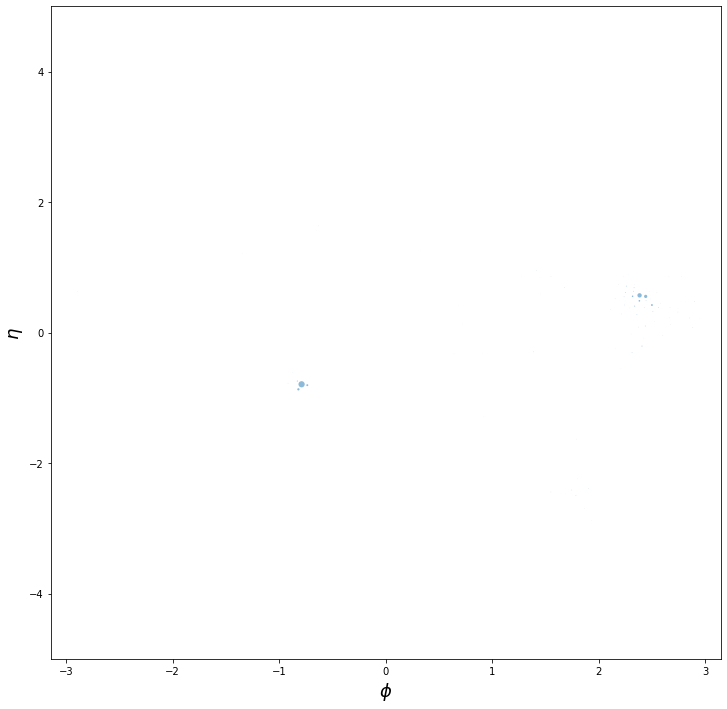

0.0 [0.8316479  0.8807859  0.9073779  0.912447   0.89334416]


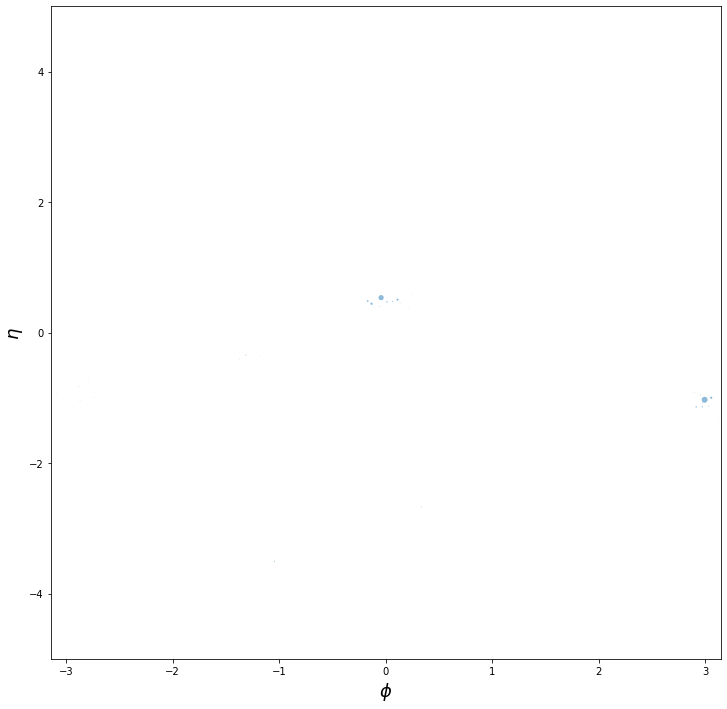

0.0 [0.954078   0.9532138  0.94562894 0.93751365 0.92434865]


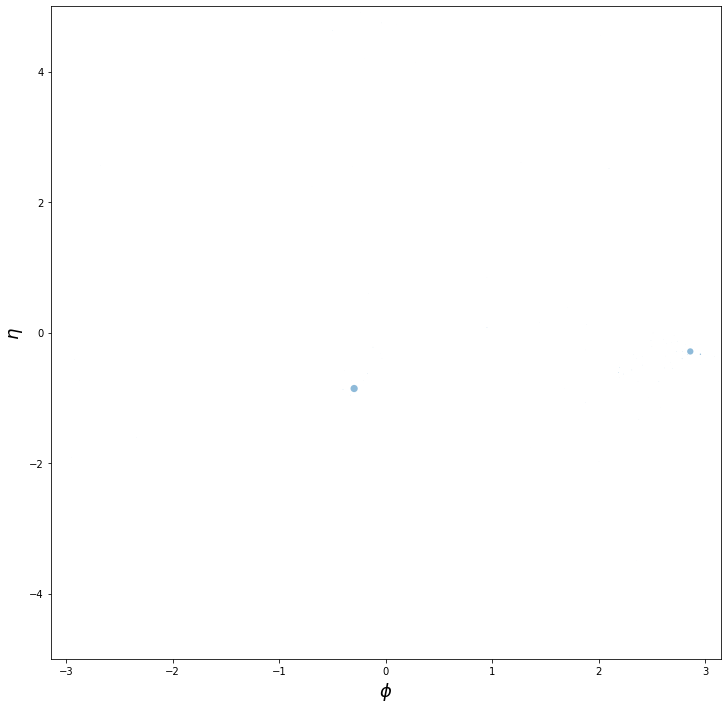

0.0 [0.95315385 0.95116997 0.9442945  0.93548334 0.91790354]


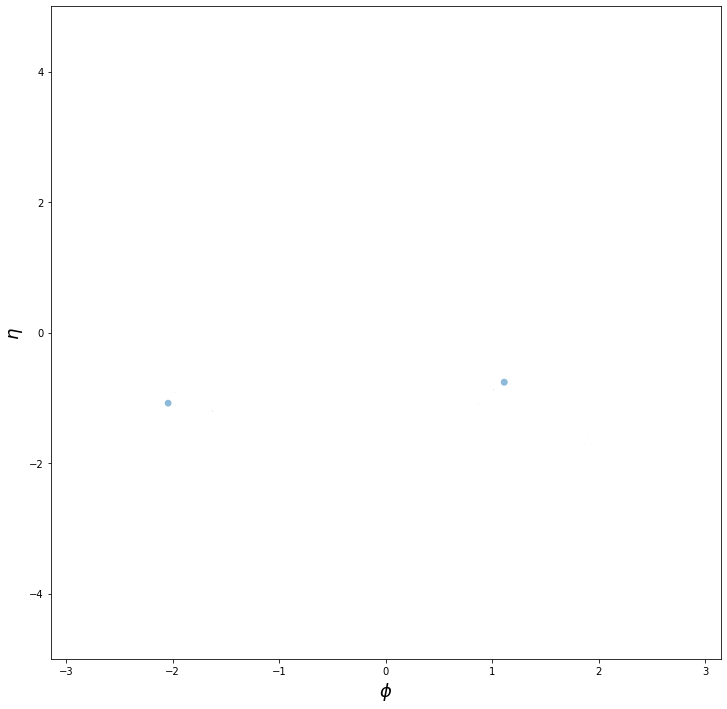

0.0 [0.9418501  0.94576025 0.9404314  0.9347138  0.918583  ]


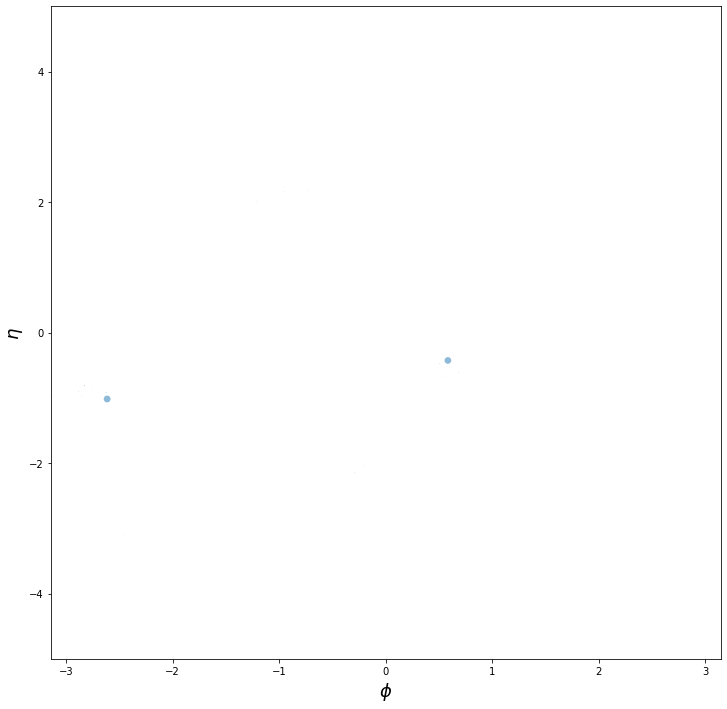

0.0 [0.89221406 0.9174751  0.927254   0.92170113 0.9071478 ]


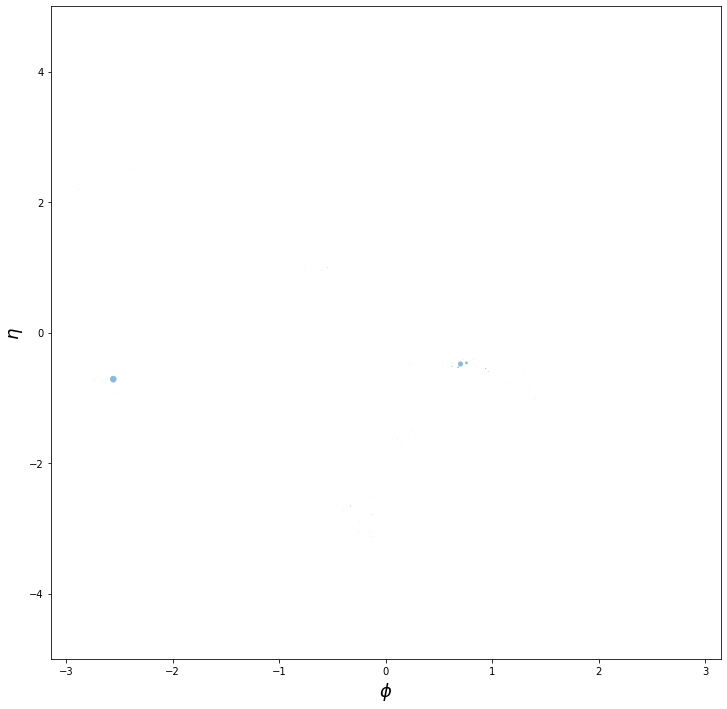

0.0 [1.1687105e-04 2.4719967e-03 7.7792120e-01 7.8036547e-01 7.6644731e-01]


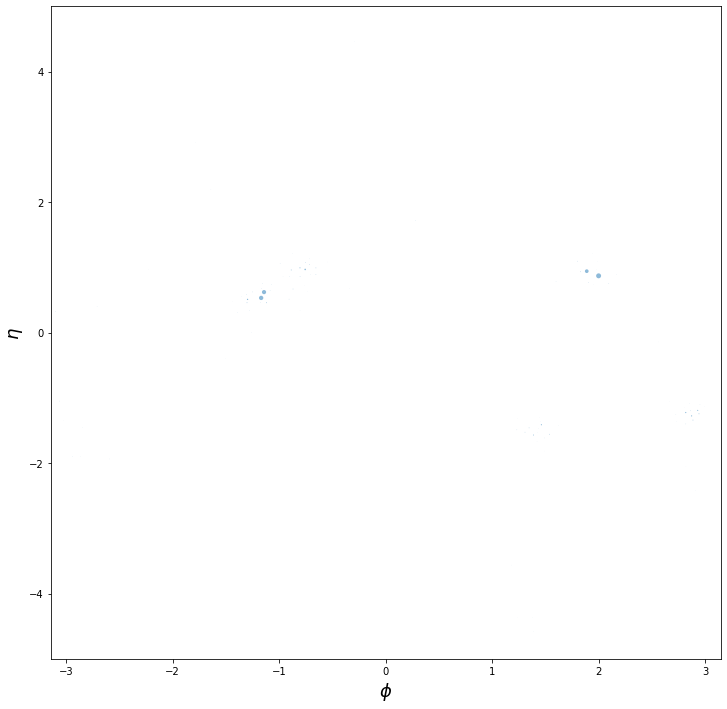

0.0 [0.92875326 0.9337587  0.93187594 0.9305741  0.91211796]


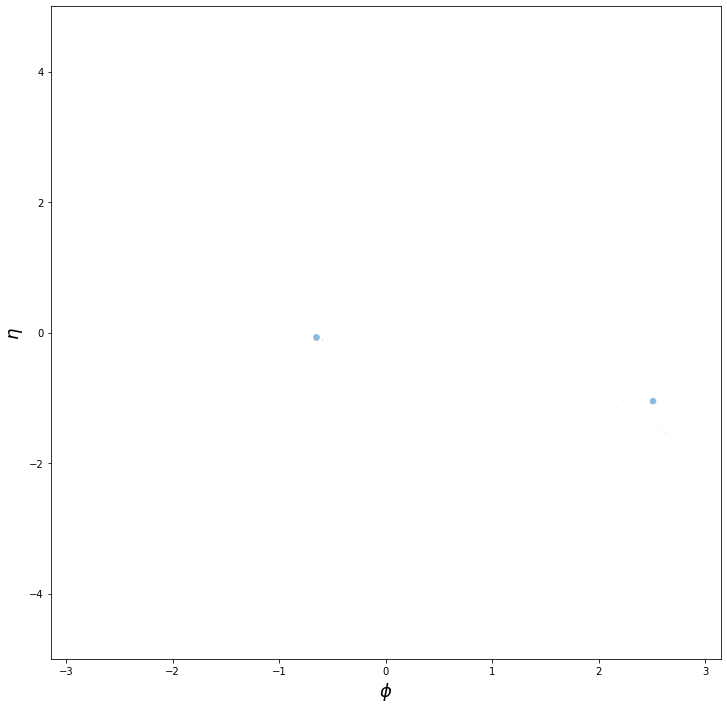

0.0 [0.9287797  0.94073814 0.9403917  0.934092   0.9209256 ]


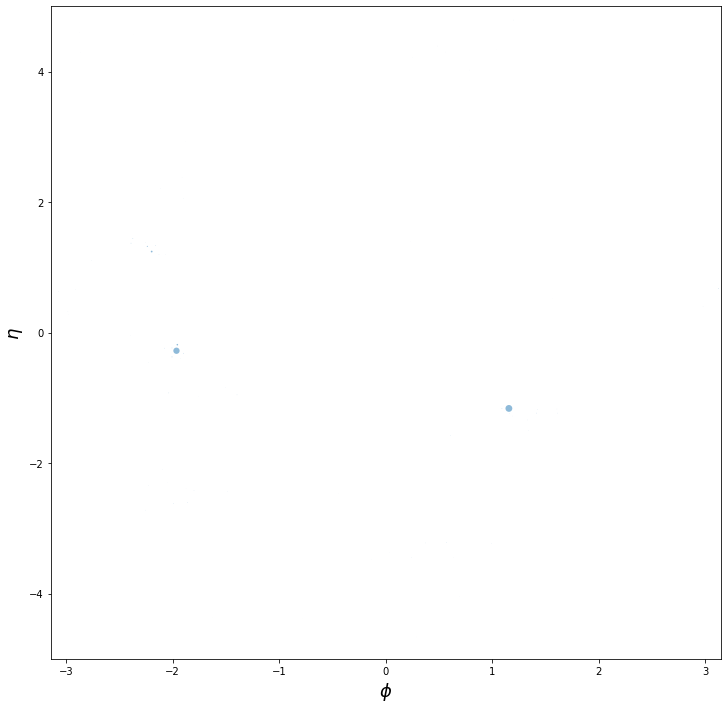

0.0 [0.93530625 0.9423836  0.9431926  0.93904996 0.9305267 ]


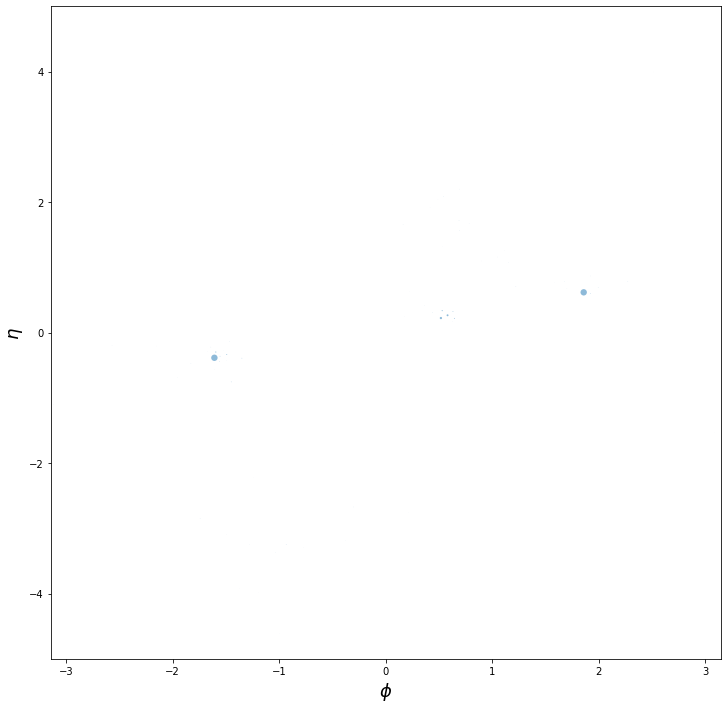

0.0 [0.90480316 0.91500694 0.9233911  0.91577023 0.9061387 ]


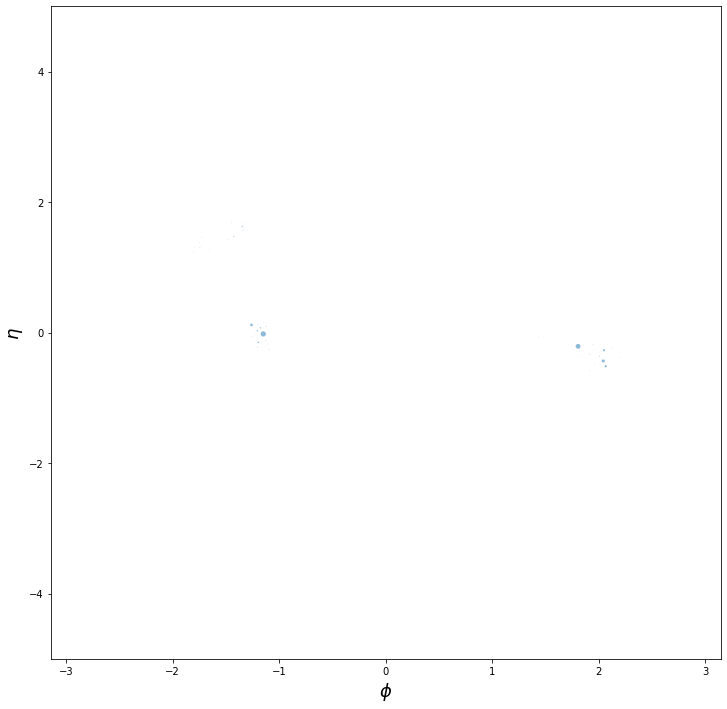

0.0 [0.92639583 0.9322864  0.9318405  0.9225565  0.91460454]


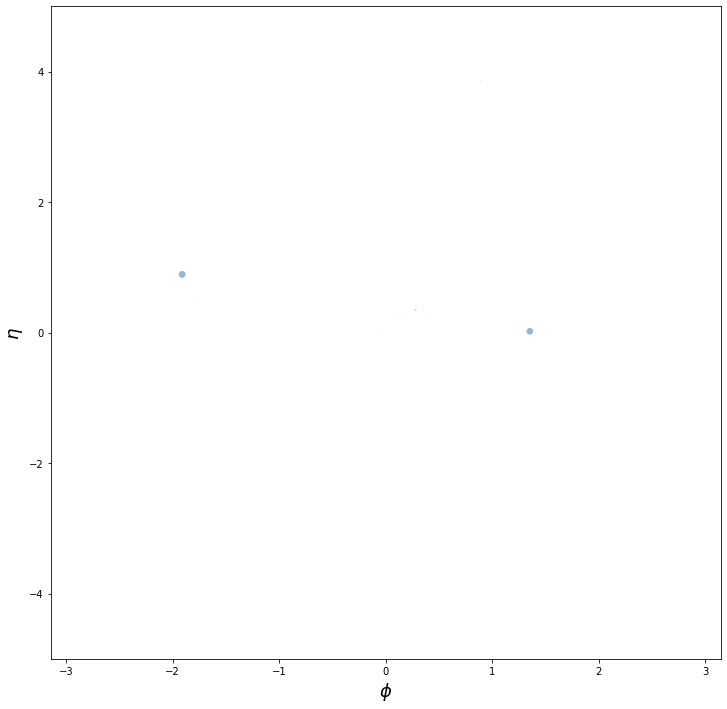

0.0 [0.9304061  0.9368039  0.9395579  0.93434227 0.9237979 ]


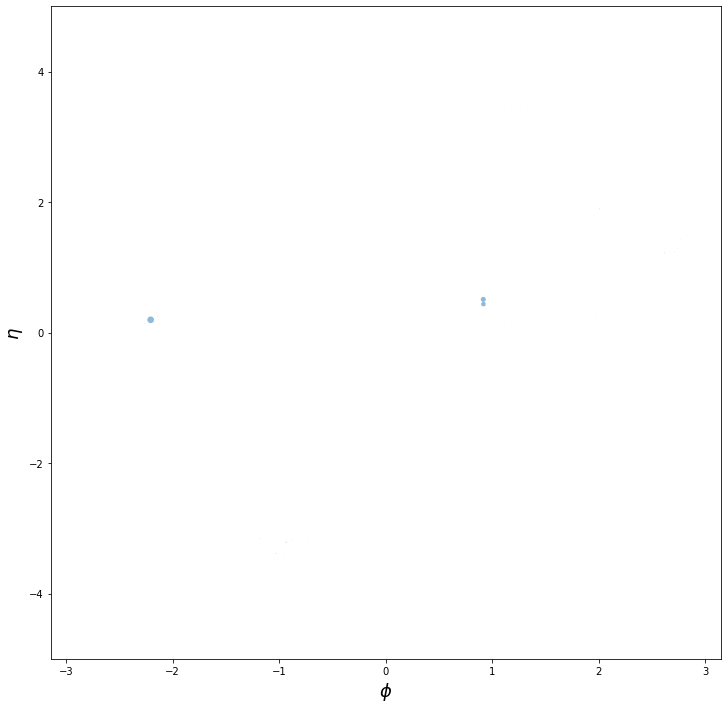

0.0 [0.58798665 0.80985093 0.88346326 0.89096546 0.86044115]


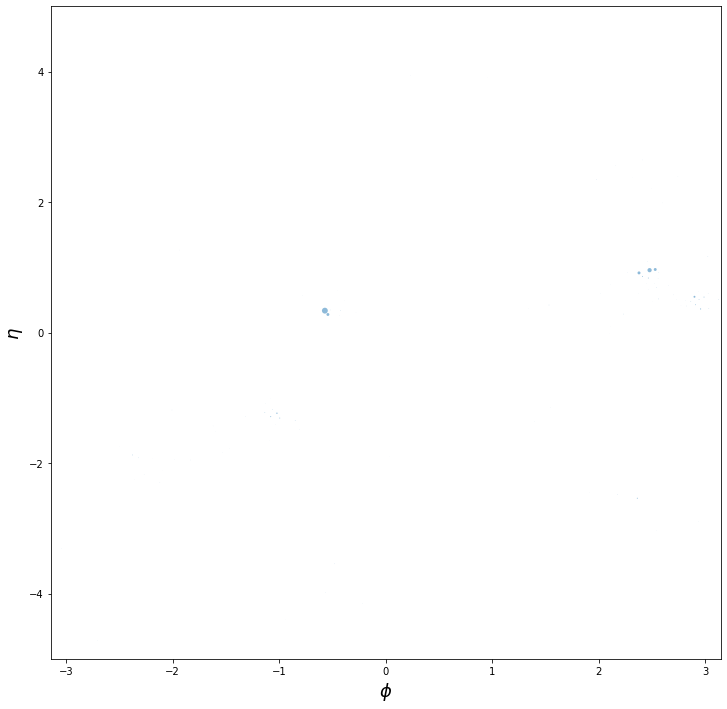

1.0 [0.8179853  0.86286575 0.901198   0.90498245 0.8756779 ]


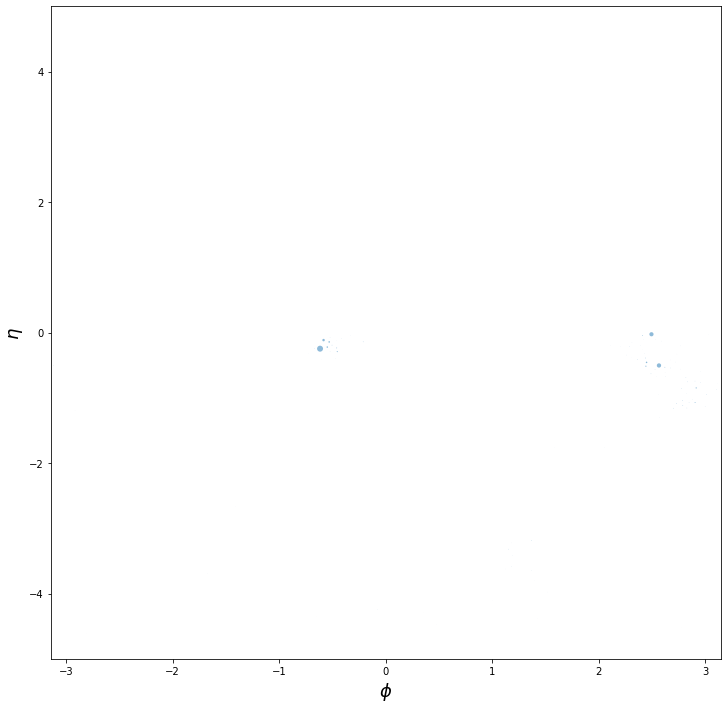

0.0 [0.78807867 0.8797892  0.90261817 0.9014831  0.8909636 ]


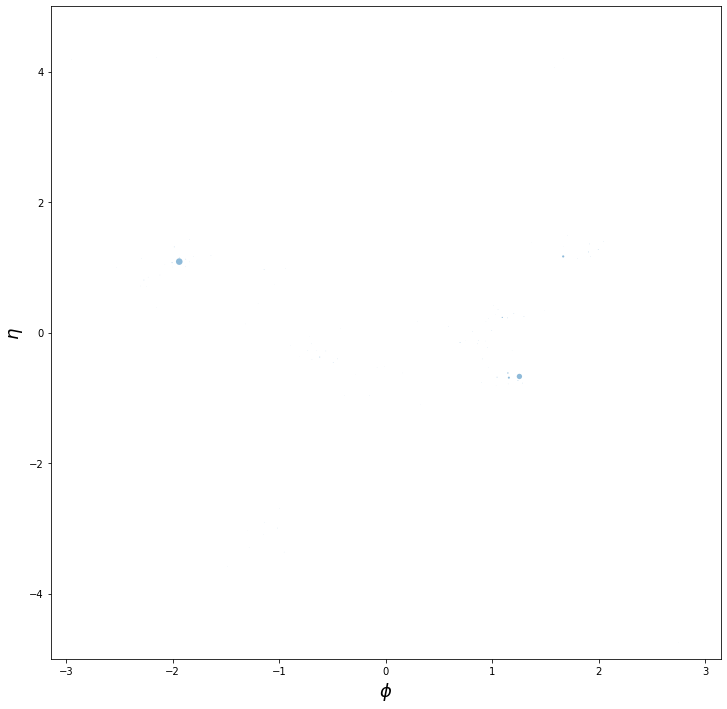

0.0 [0.83401996 0.88268465 0.9099184  0.9037787  0.88660806]


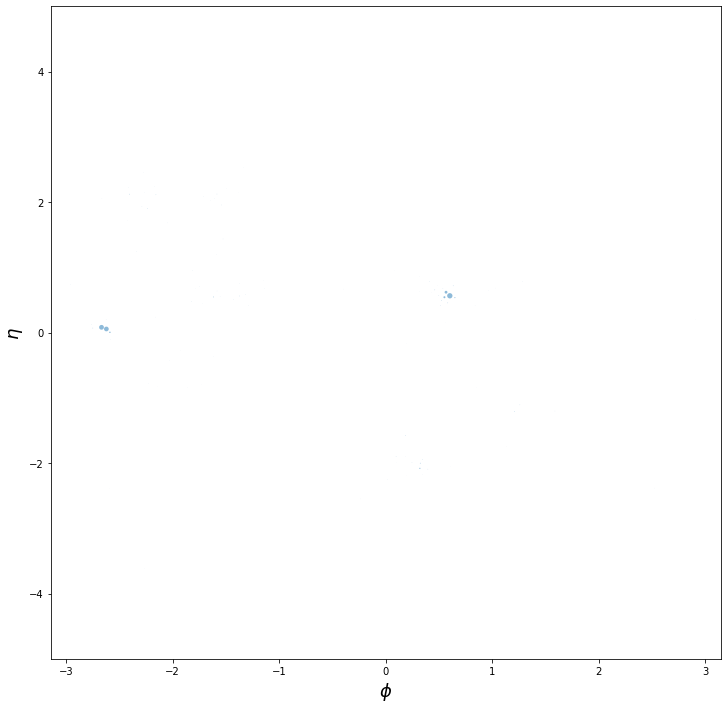

0.0 [0.9525045  0.95187694 0.9457925  0.93836325 0.92949915]


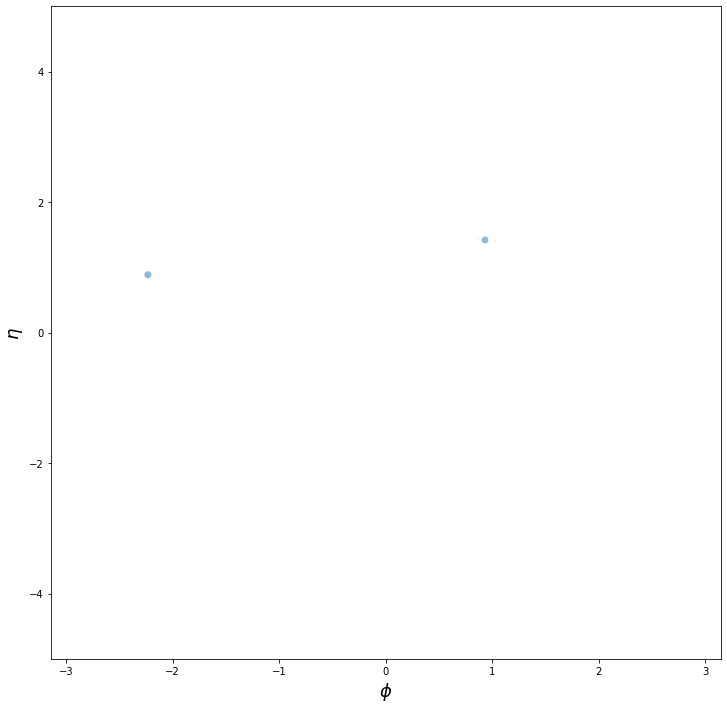

0.0 [0.9469732 0.9463046 0.9414835 0.9325324 0.9152541]


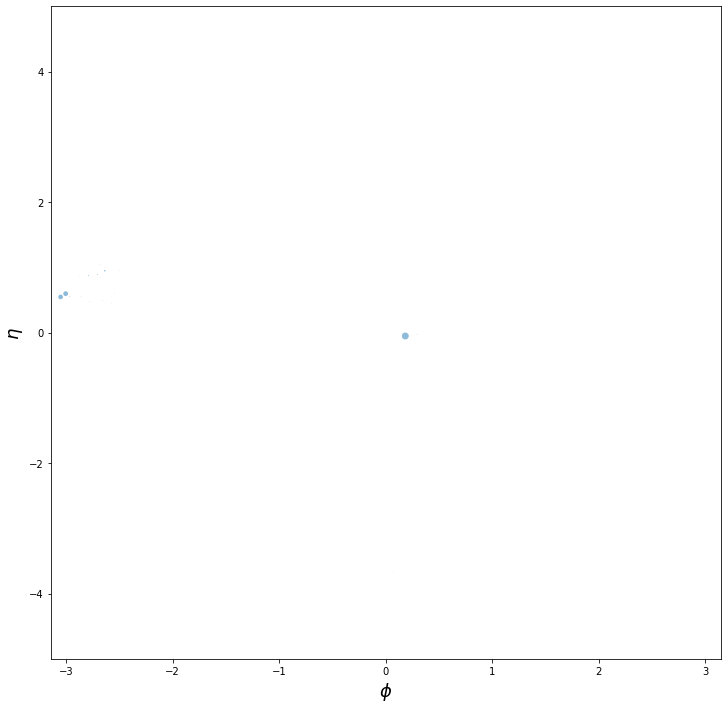

0.0 [0.95015234 0.9500891  0.94507086 0.9377828  0.9200143 ]


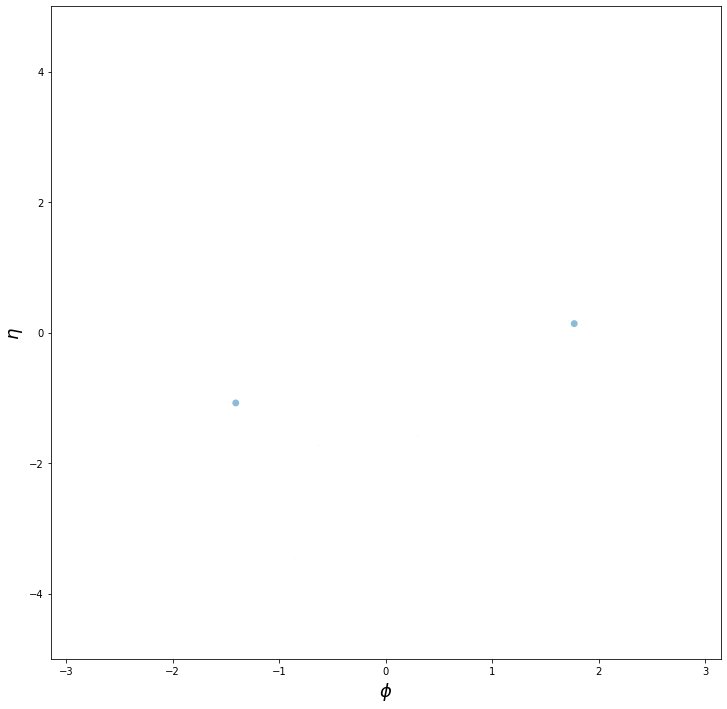

0.0 [4.2319116e-06 2.5659174e-04 5.6630200e-01 6.6630054e-01 6.9911224e-01]


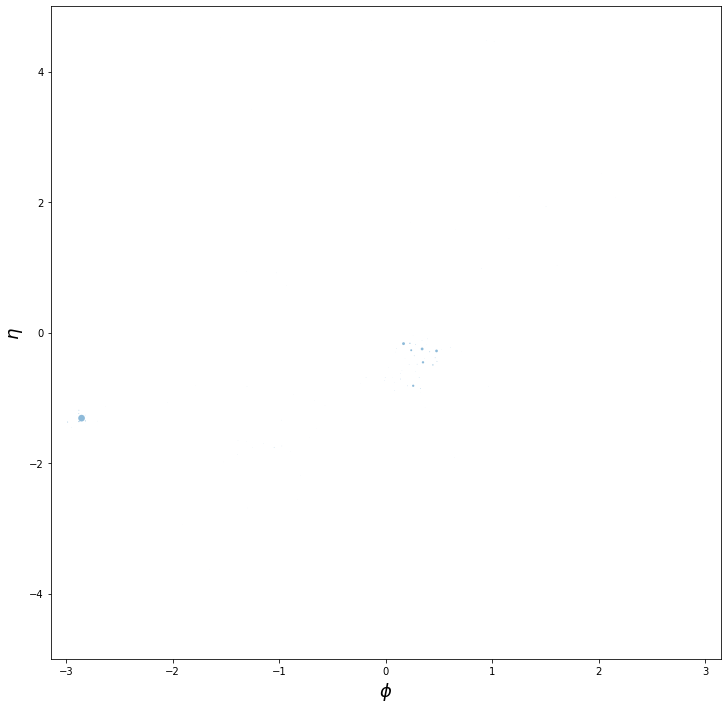

0.0 [0.70446867 0.8216345  0.8960686  0.8812496  0.86234486]


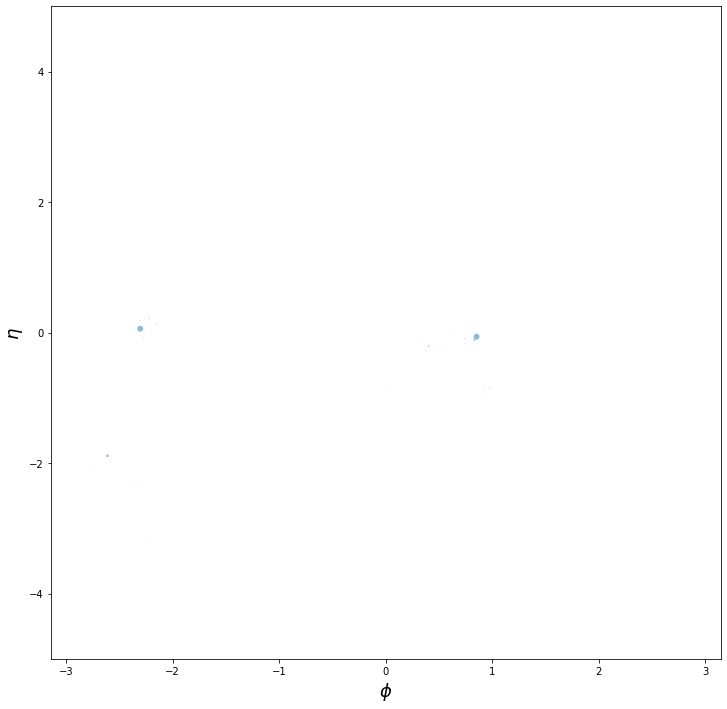

0.0 [0.950502   0.95245767 0.9473671  0.939826   0.9310328 ]


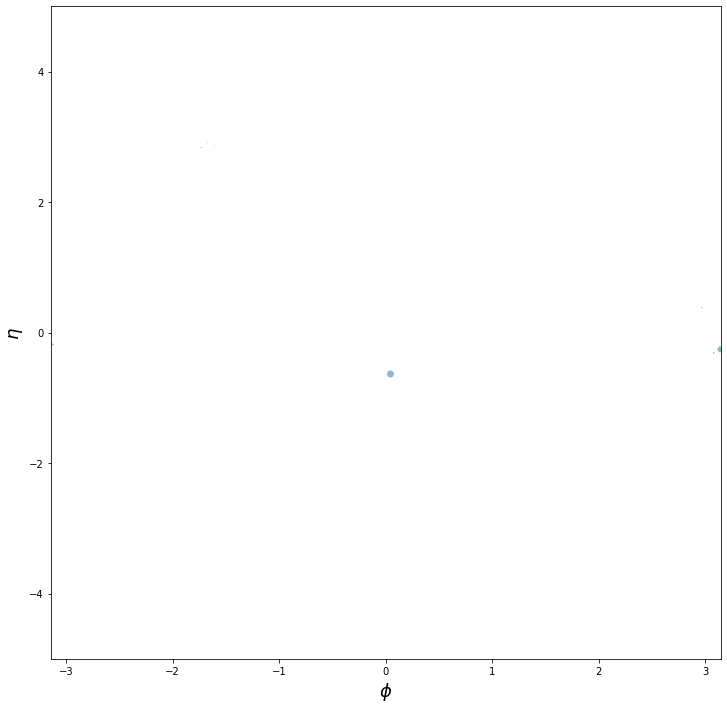

0.0 [3.8742874e-06 1.8283361e-04 3.3432832e-01 5.9217483e-01 6.1563987e-01]


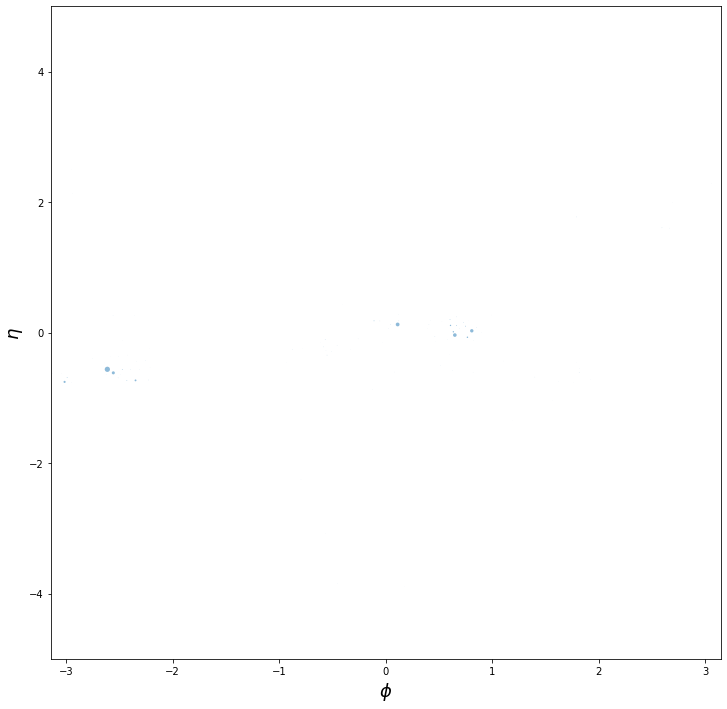

0.0 [0.9265425  0.93249625 0.9340948  0.9302203  0.9154948 ]


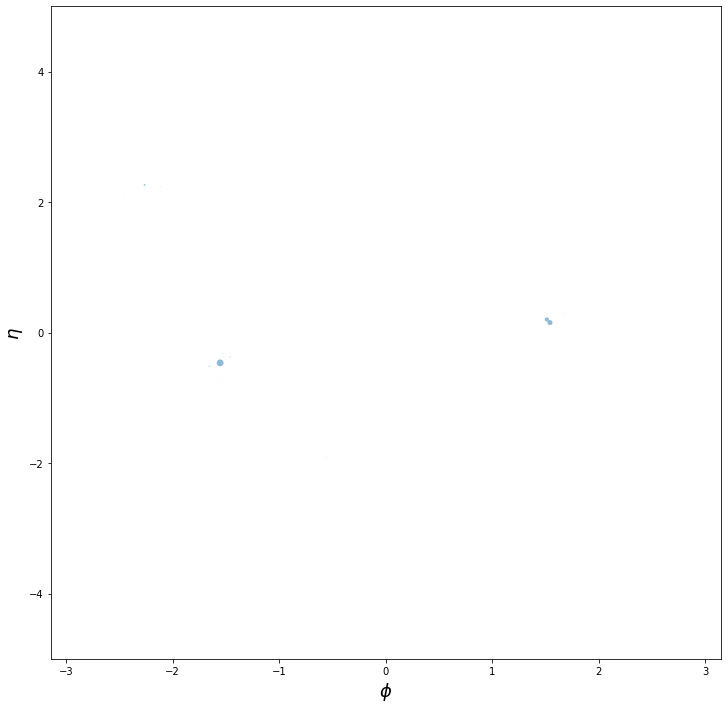

1.0 [0.8337007  0.86416423 0.9118674  0.9004989  0.88444245]


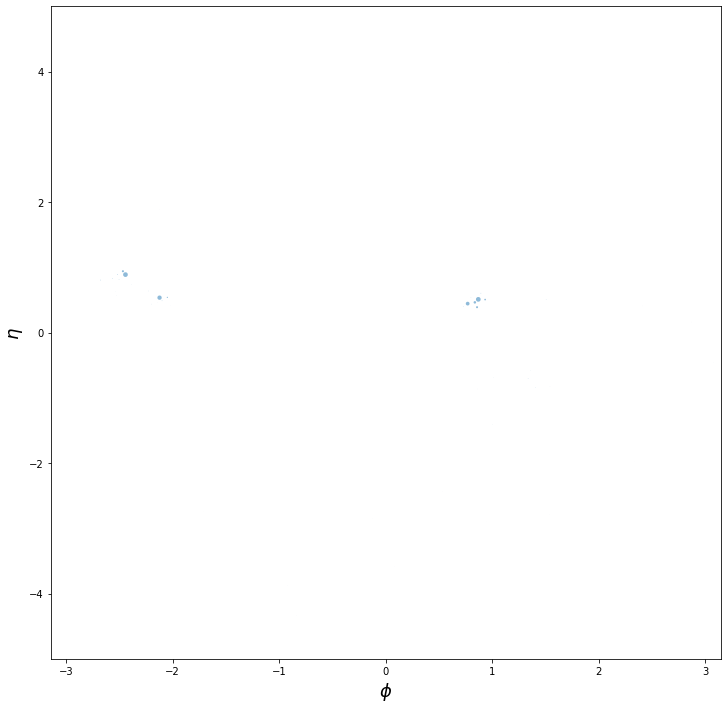

0.0 [0.72952247 0.8299531  0.89214516 0.8965694  0.8788176 ]


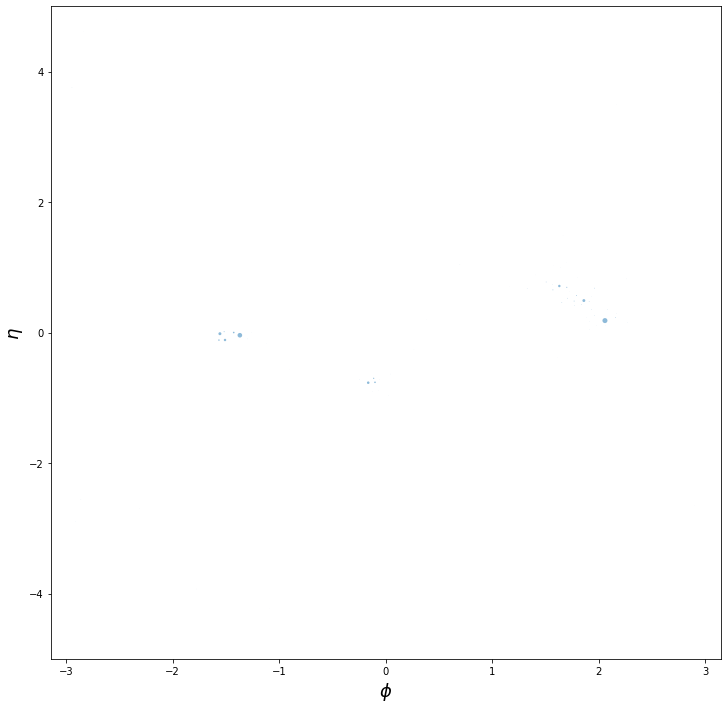

0.0 [0.6084138  0.81180555 0.8584989  0.88583827 0.84164995]


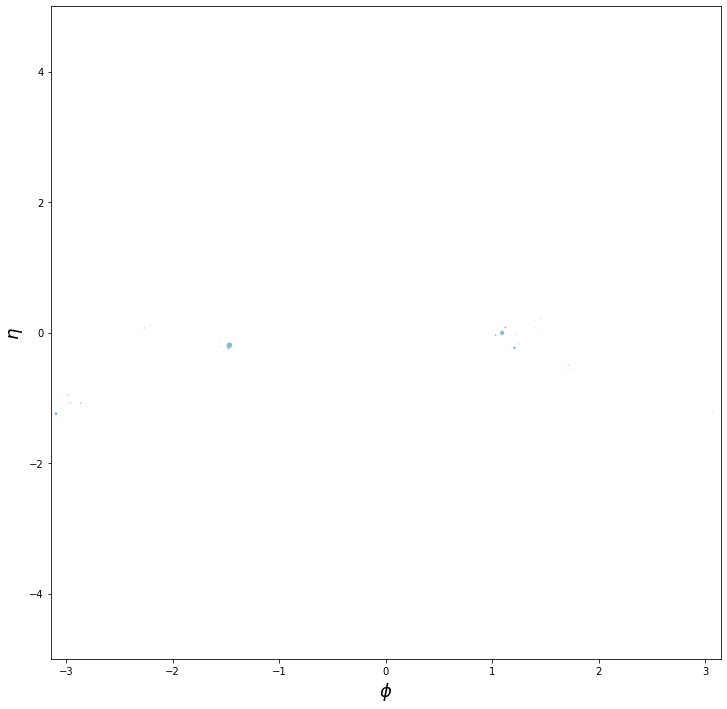

0.0 [0.91757524 0.92387056 0.927292   0.9238825  0.90792394]


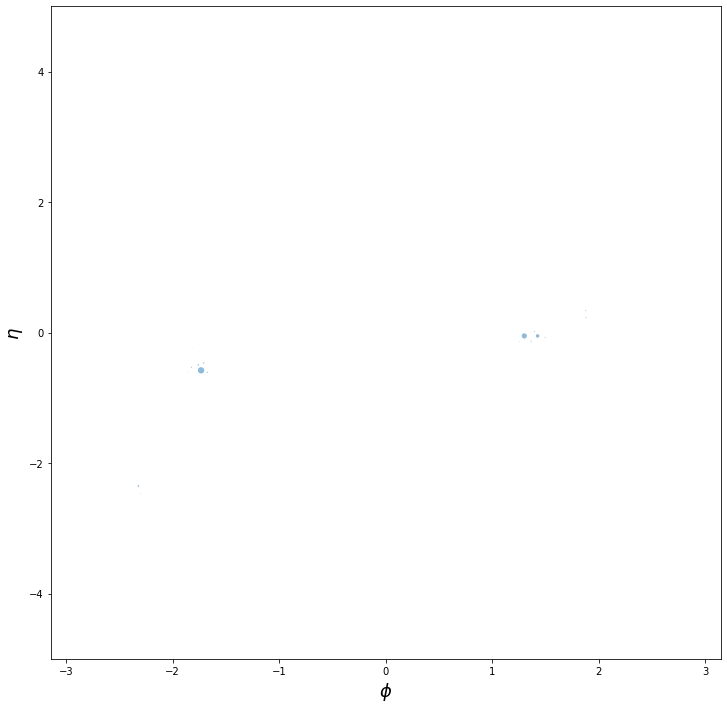

0.0 [0.85474634 0.89167833 0.91600126 0.9120952  0.8953362 ]


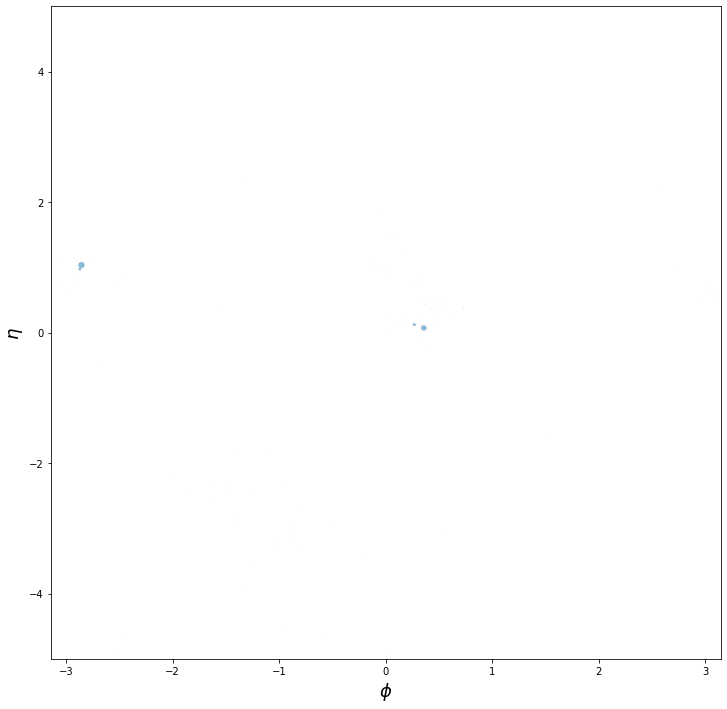

0.0 [0.9441387 0.9431877 0.9381313 0.9264654 0.9094077]


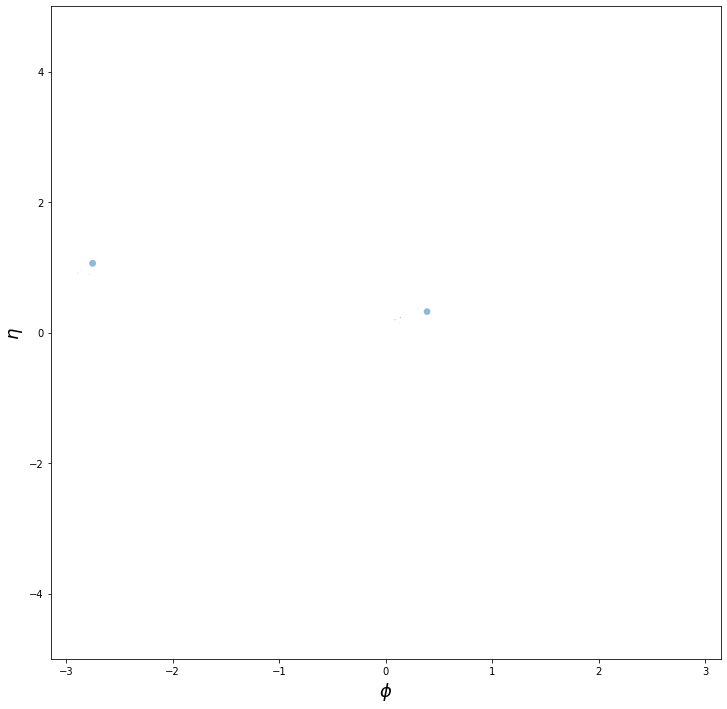

1.0 [0.0011362  0.01473949 0.80752456 0.80533344 0.7899747 ]


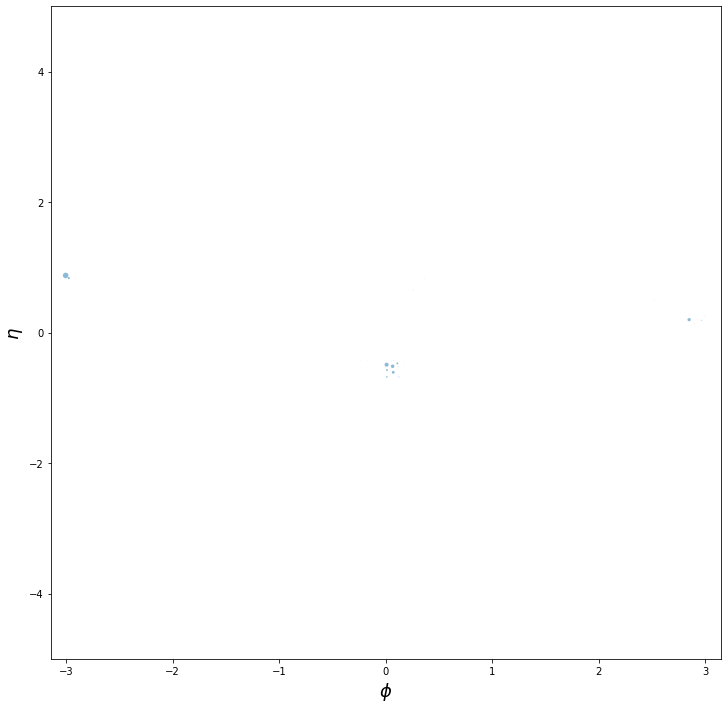

0.0 [0.7911444  0.87489384 0.90496814 0.909404   0.89728487]


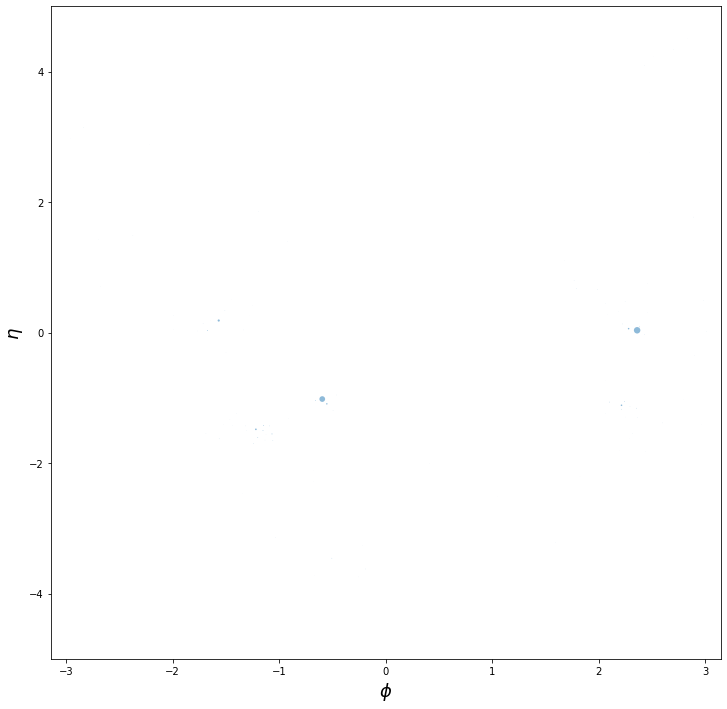

0.0 [0.00641202 0.04048004 0.81805193 0.8271327  0.82113814]


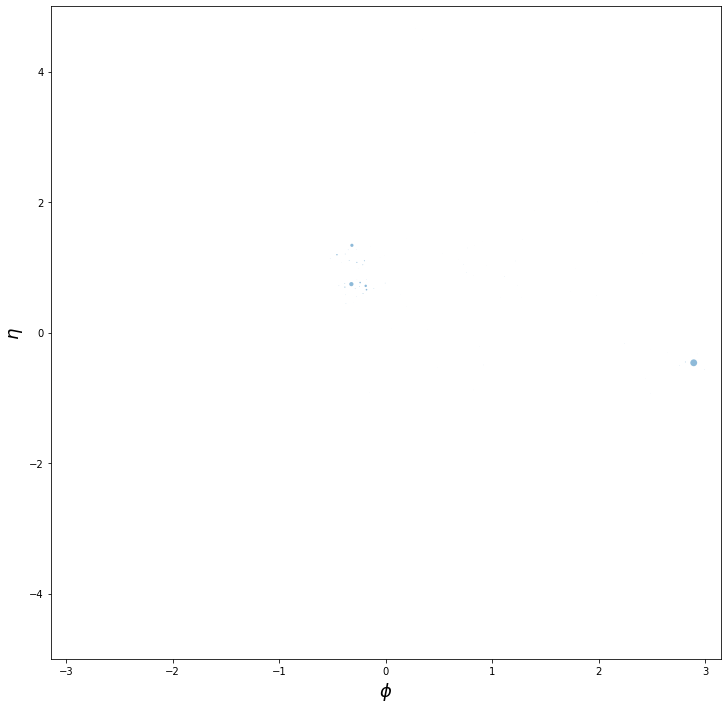

0.0 [0.63933295 0.7406315  0.8841895  0.88105196 0.8730306 ]


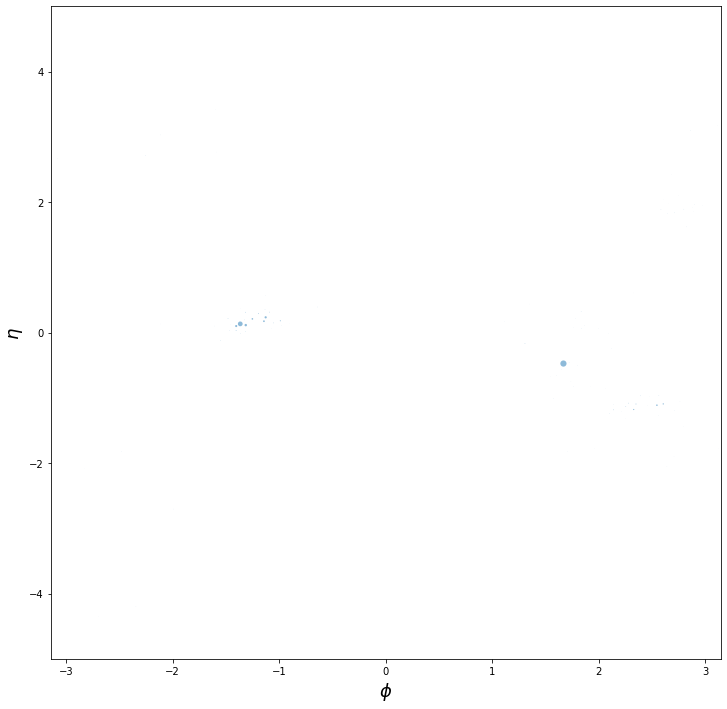

0.0 [0.952699   0.9526266  0.94577116 0.9369951  0.9229862 ]


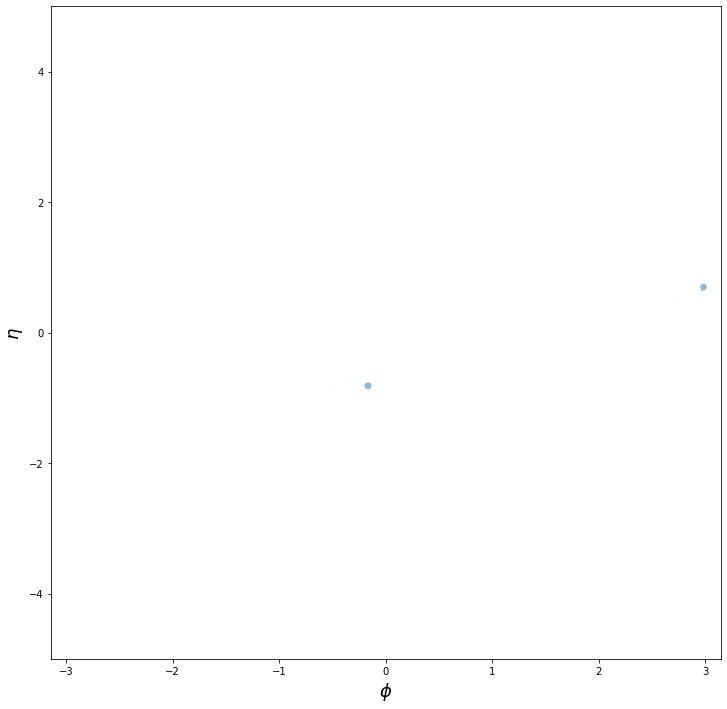

0.0 [0.9425388  0.94429135 0.93890494 0.93156457 0.9199299 ]


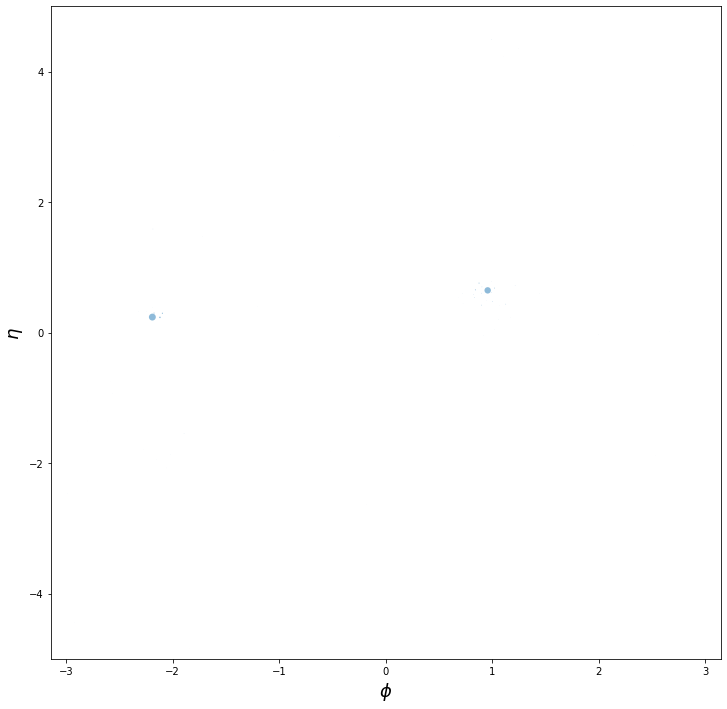

0.0 [0.89132345 0.9196811  0.9245499  0.92750037 0.9127265 ]


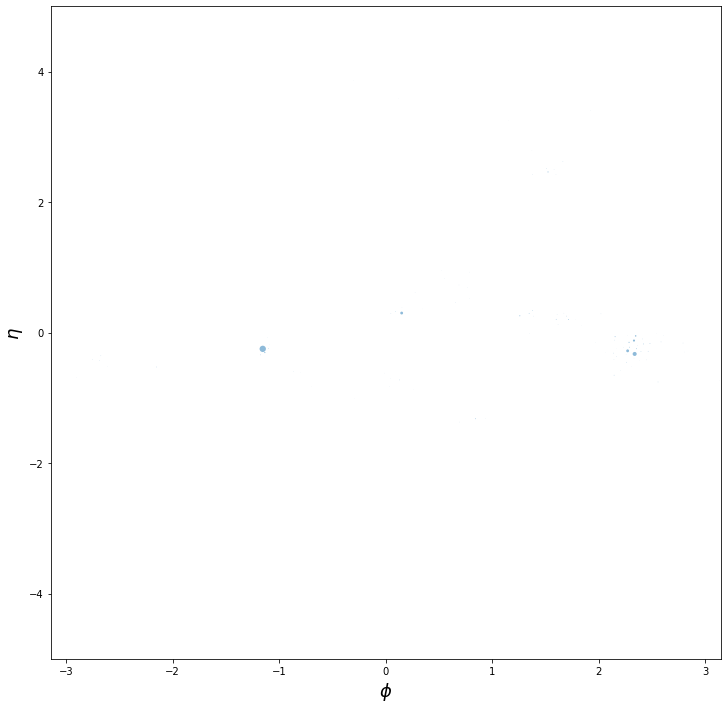

0.0 [0.8893744  0.90887684 0.9115391  0.9151566  0.89531106]


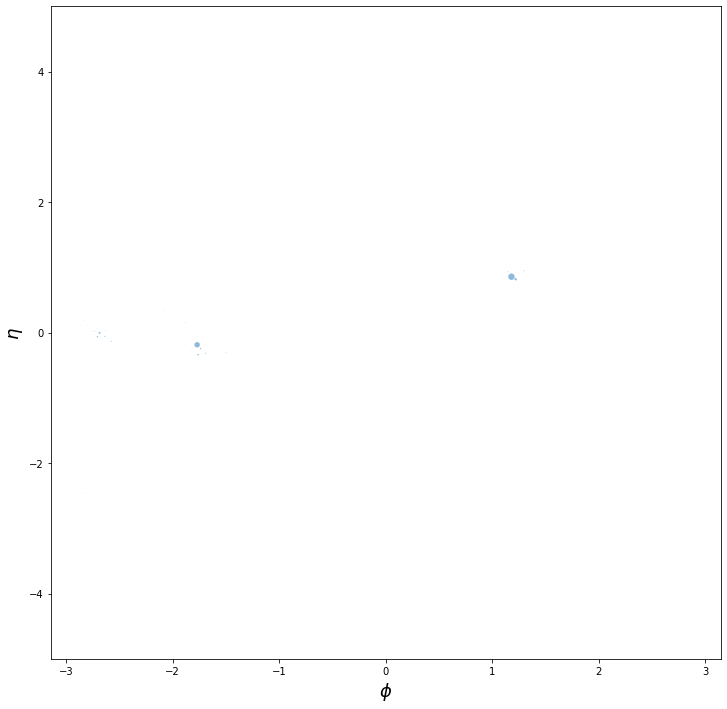

1.0 [0.8475994  0.8799712  0.9032842  0.90635574 0.8867821 ]


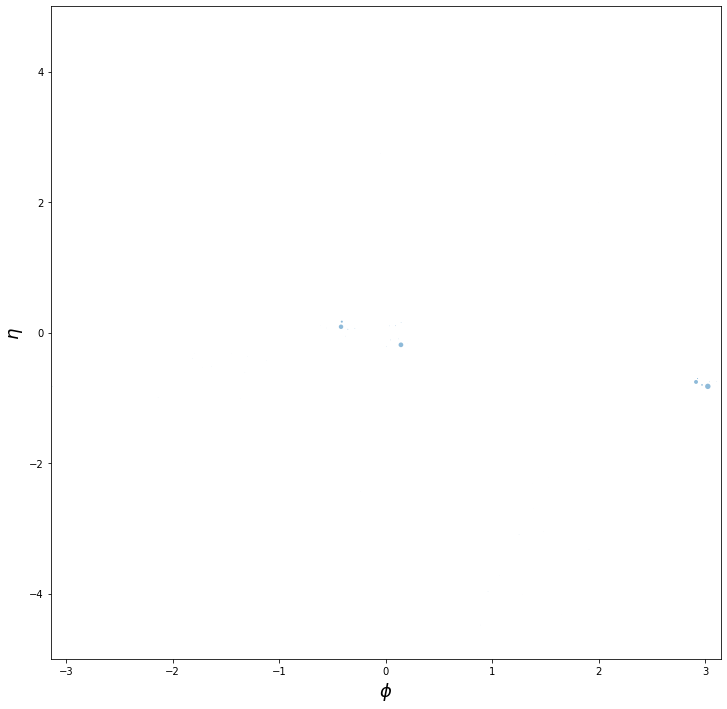

0.0 [0.93014413 0.9330734  0.9313811  0.9336277  0.9211869 ]


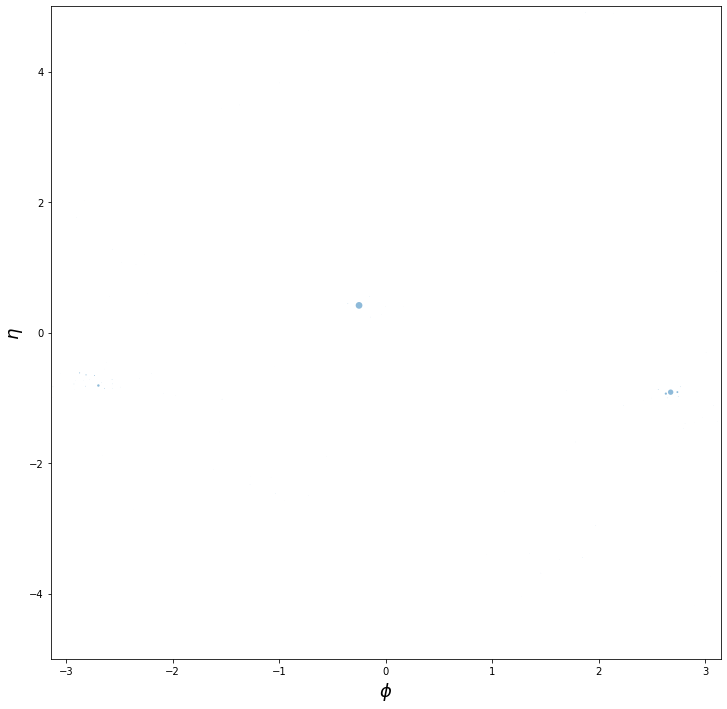

0.0 [0.829173   0.8658766  0.8664814  0.87809324 0.8579737 ]


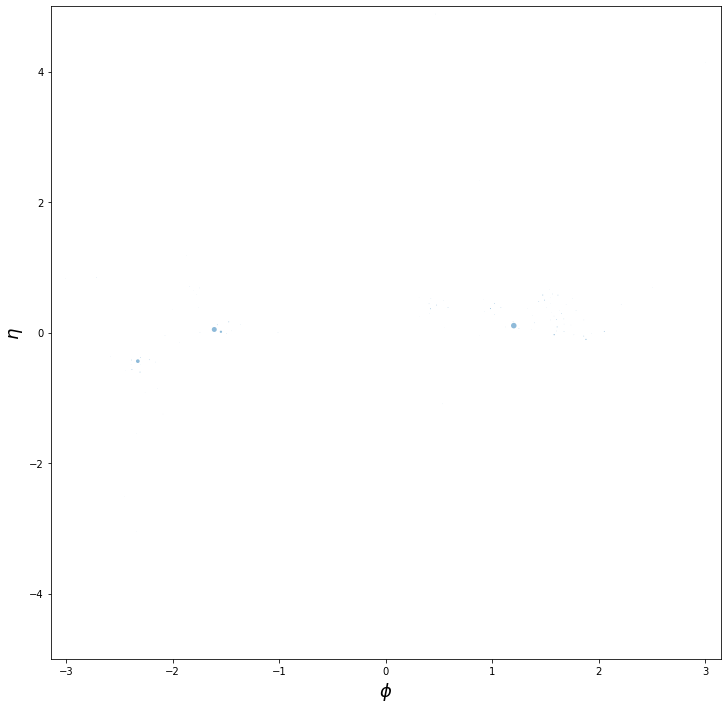

0.0 [0.9109951  0.9198687  0.92431694 0.9174282  0.9068999 ]


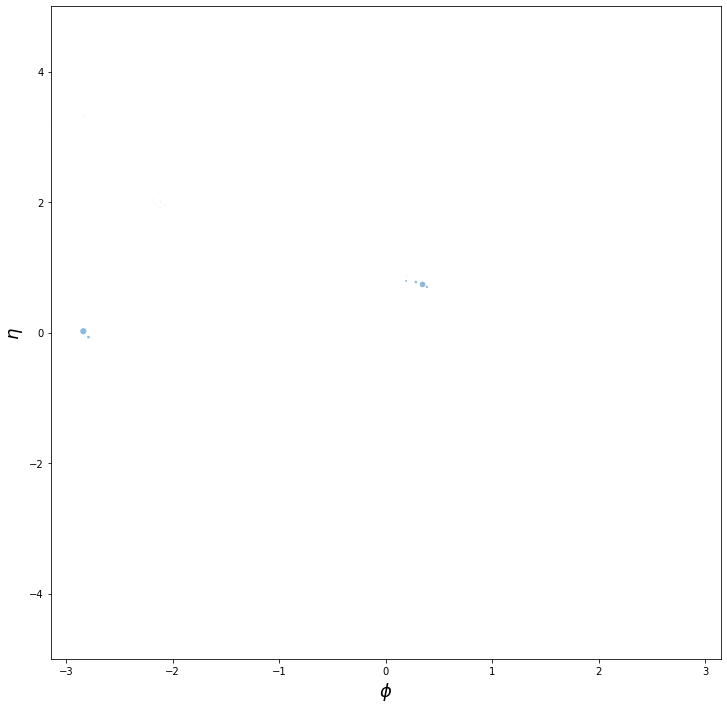

0.0 [0.95015514 0.9493374  0.9423229  0.93567485 0.92257774]


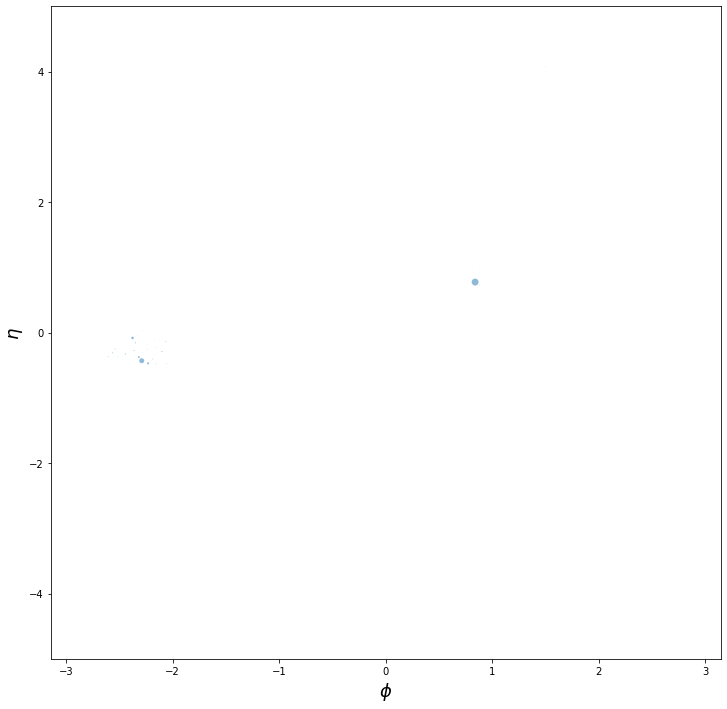

0.0 [0.93850255 0.9451809  0.938631   0.93533534 0.9216724 ]


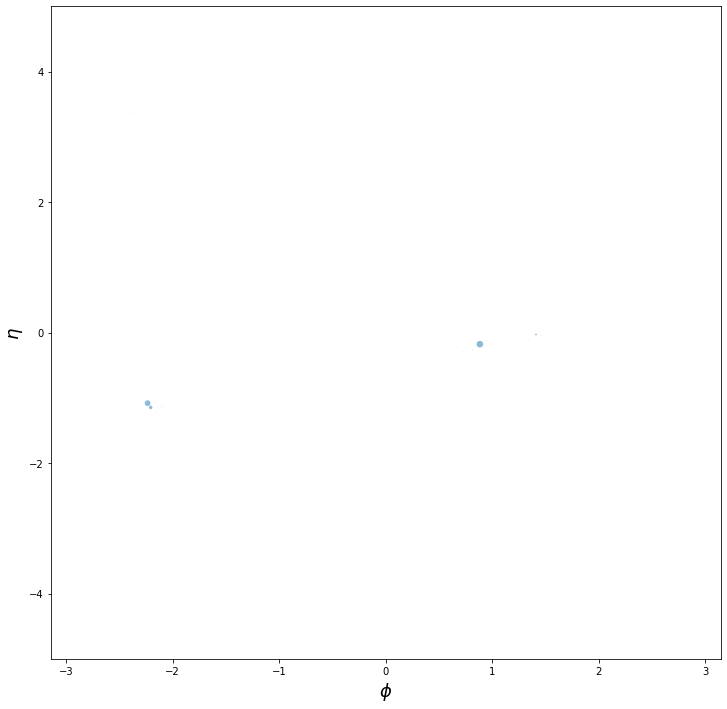

0.0 [0.04795003 0.45589647 0.8572008  0.8711945  0.85661924]


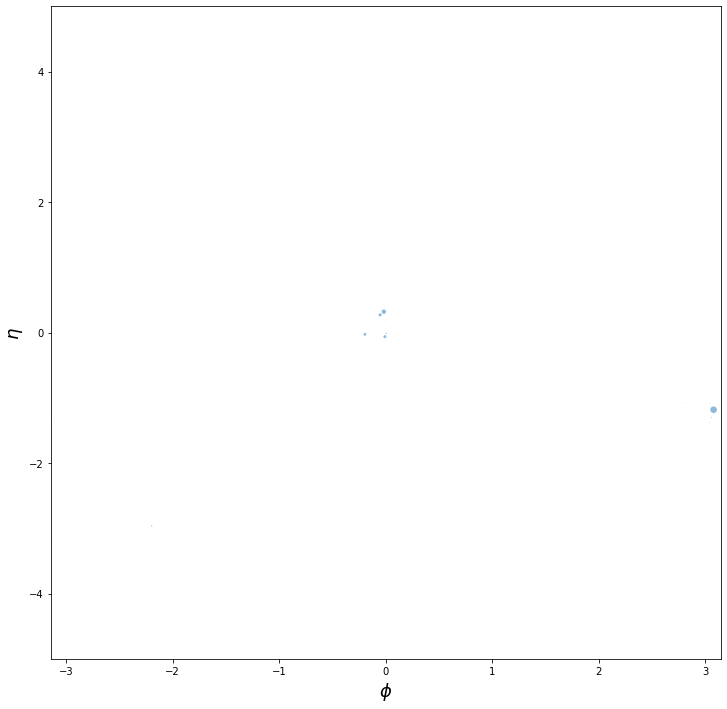

0.0 [0.27071917 0.785709   0.88868755 0.89998436 0.8917172 ]


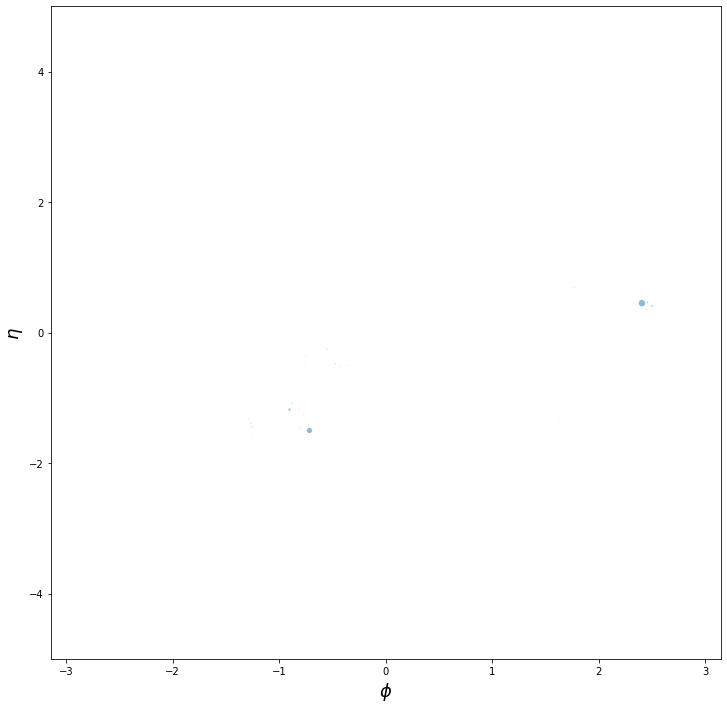

0.0 [0.13462354 0.45624626 0.87231976 0.8863381  0.8699451 ]


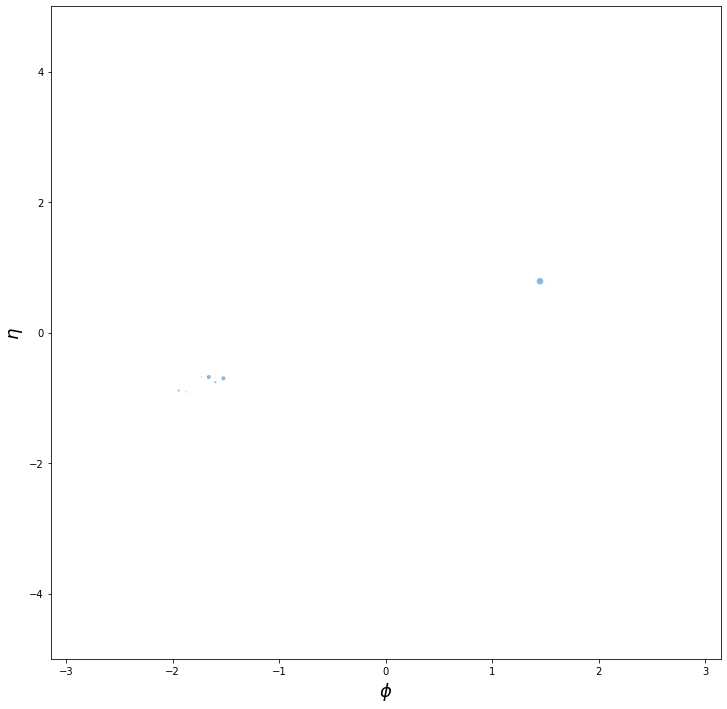

0.0 [0.8807463  0.9014669  0.9169436  0.91620725 0.8995368 ]


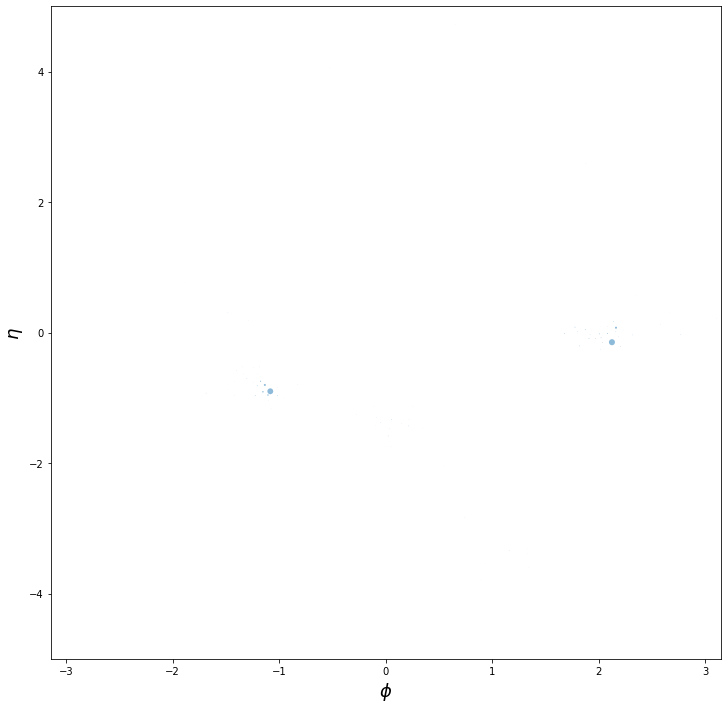

0.0 [0.9280099 0.9368781 0.9383365 0.9367123 0.9247857]


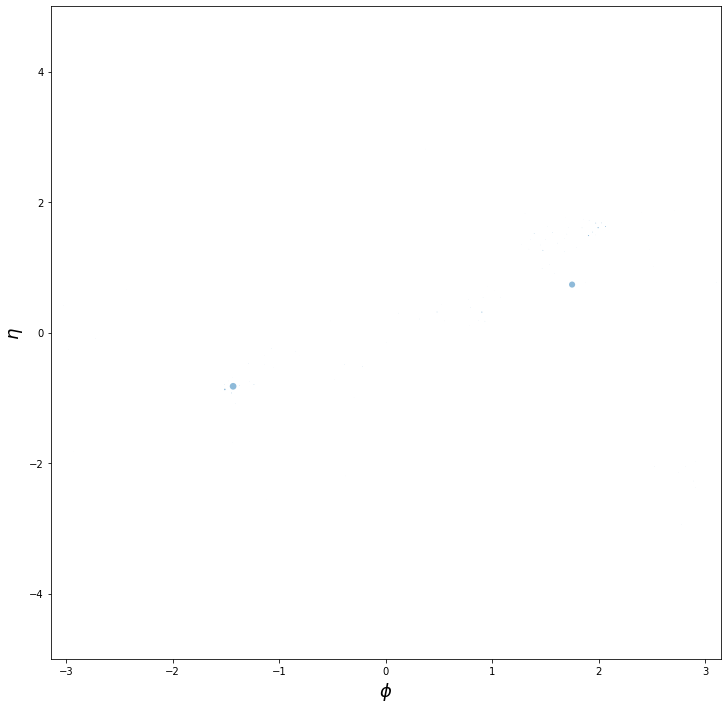

0.0 [0.8814565  0.9022662  0.91433585 0.9125329  0.8958203 ]


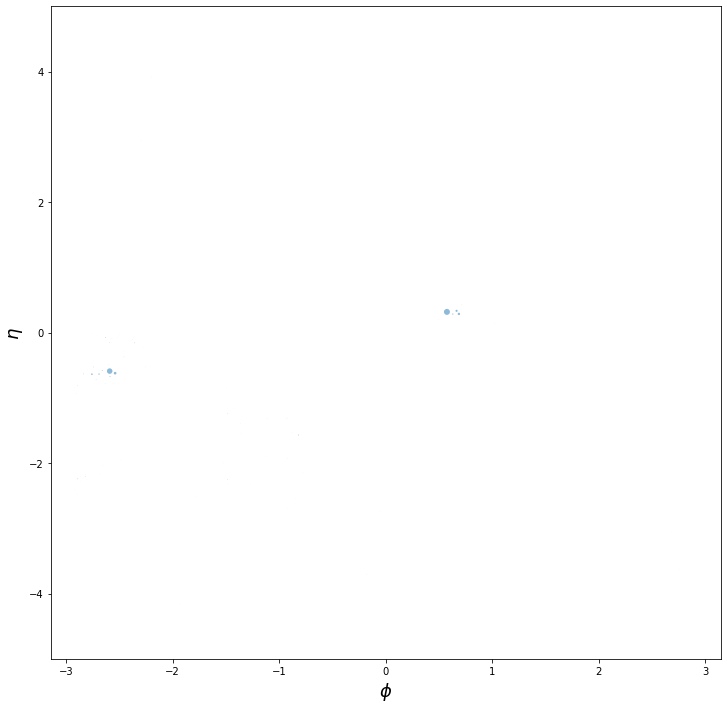

0.0 [0.86558133 0.90653926 0.9221878  0.91765285 0.91129273]


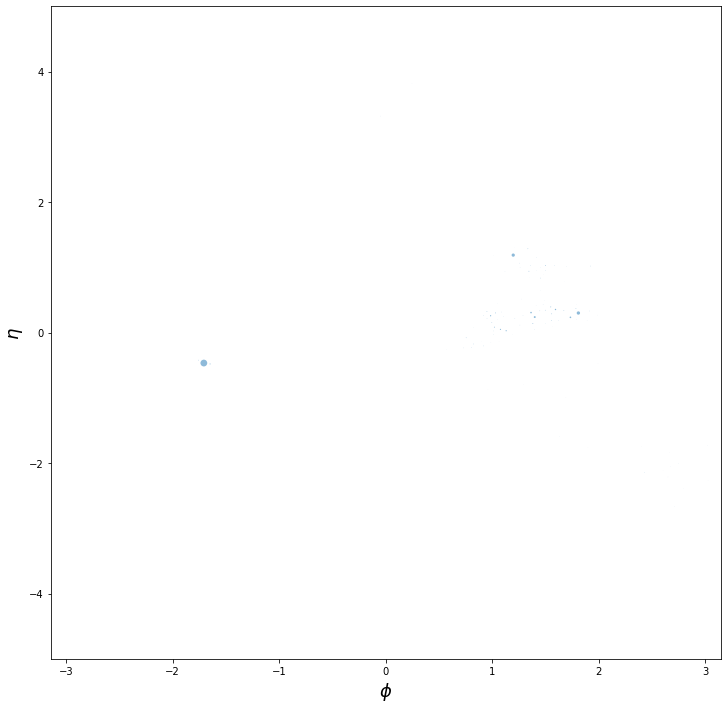

0.0 [0.9118547  0.92875016 0.9352741  0.9342529  0.9207589 ]


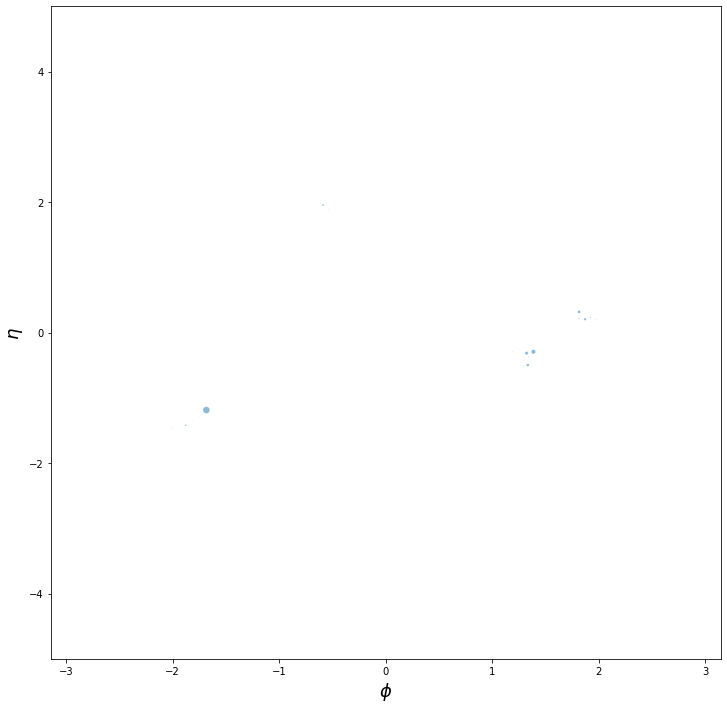

0.0 [0.91094255 0.9232446  0.9249562  0.9210943  0.909242  ]


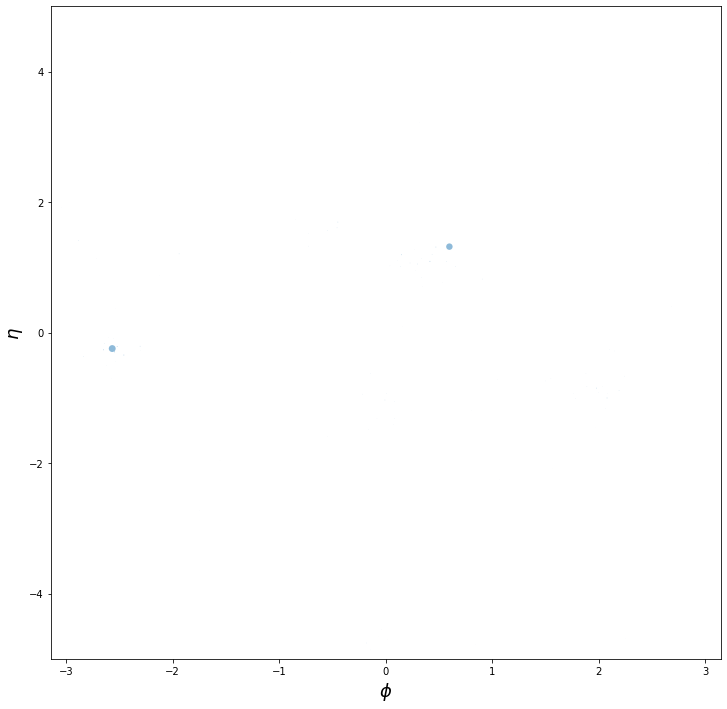

0.0 [0.8107066 0.8790081 0.9126577 0.9066677 0.894579 ]


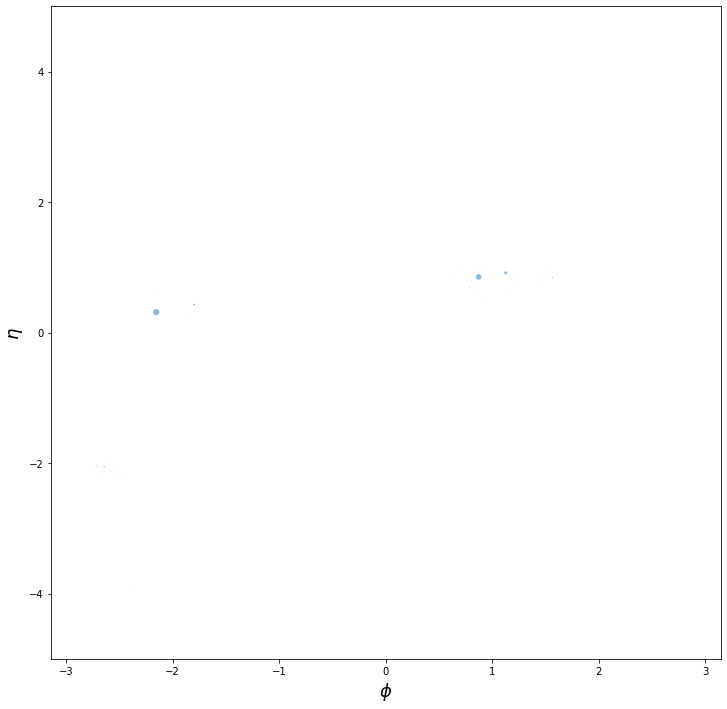

0.0 [0.00263733 0.08369273 0.8319487  0.85532504 0.84022397]


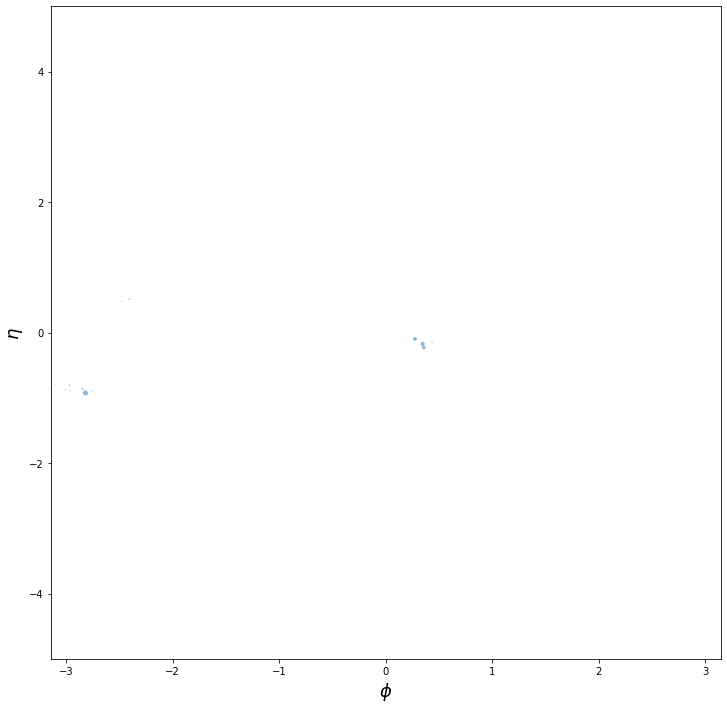

0.0 [0.9281158  0.93072593 0.92885315 0.9200124  0.9010876 ]


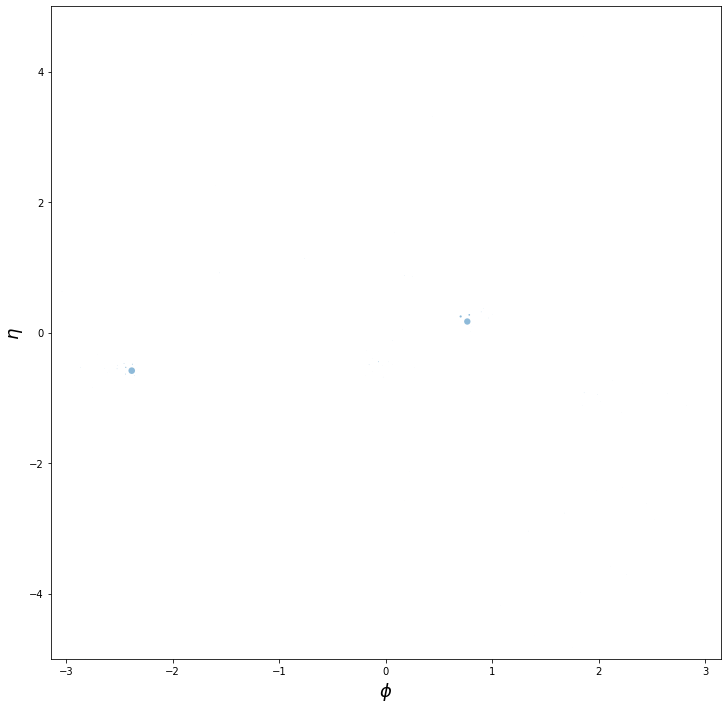

0.0 [0.90308815 0.91559124 0.91800994 0.91353536 0.9003284 ]


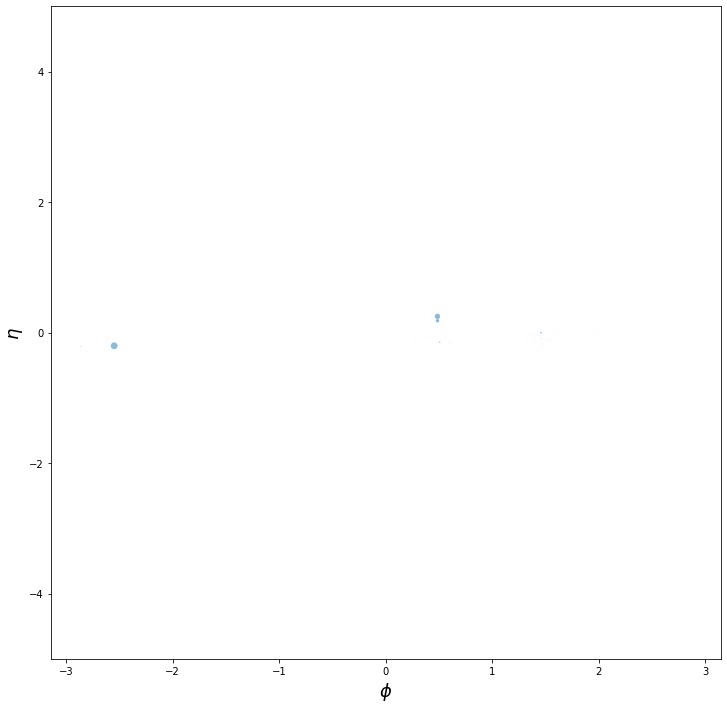

0.0 [0.87651455 0.90885514 0.92475146 0.9225524  0.9114255 ]


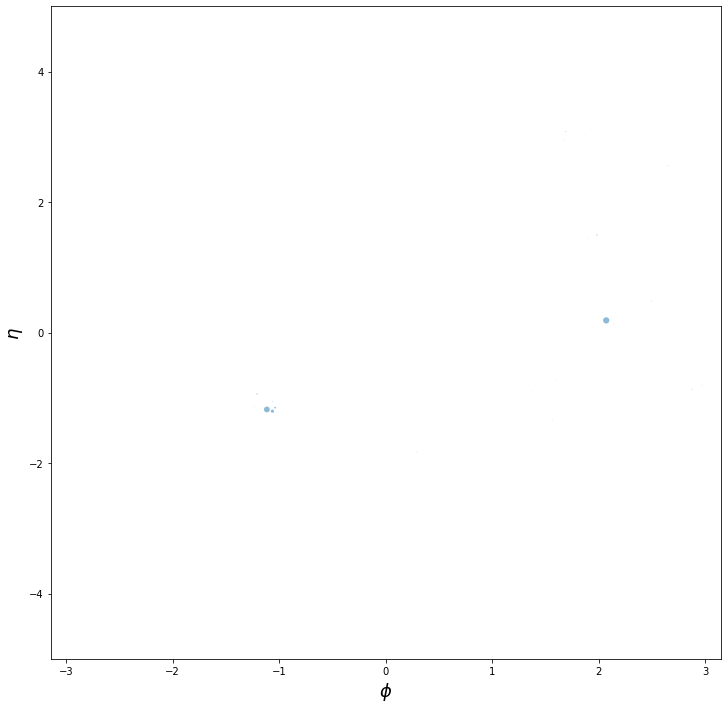

0.0 [0.7105855  0.8340131  0.89980316 0.893692   0.8844908 ]


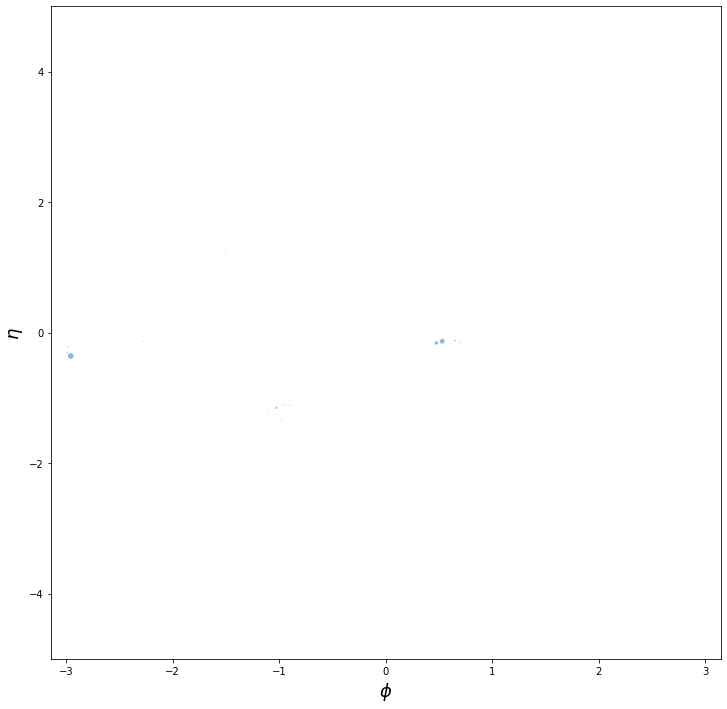

0.0 [3.5166615e-06 1.2105930e-03 7.4740529e-01 8.1239098e-01 8.2727748e-01]


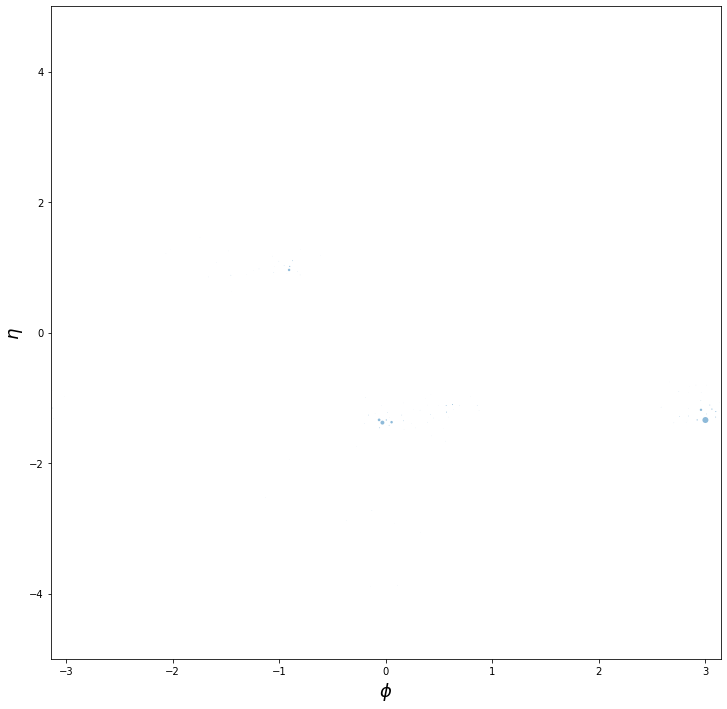

0.0 [1.8477405e-06 3.6119109e-05 3.6161765e-02 4.7648039e-02 2.2556135e-01]


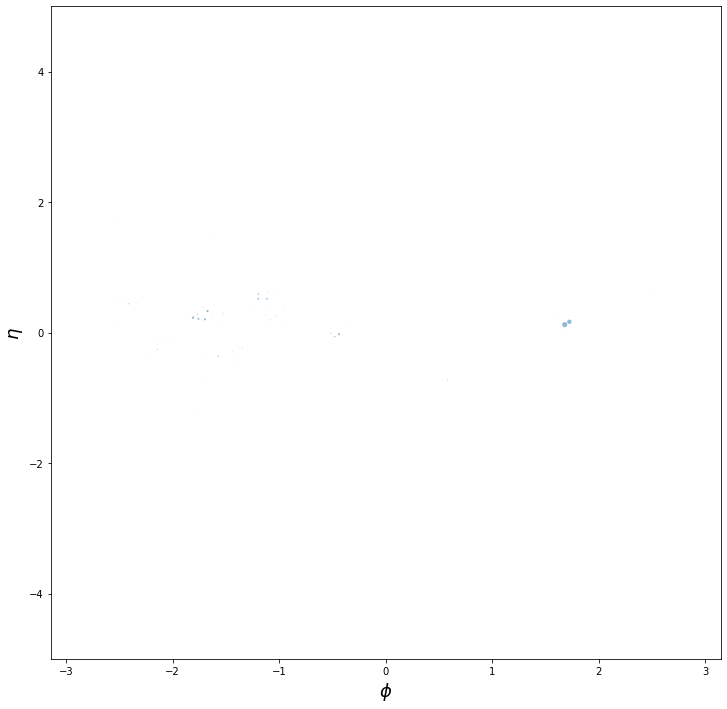

0.0 [0.5538671  0.79863054 0.8833722  0.8836525  0.87398714]


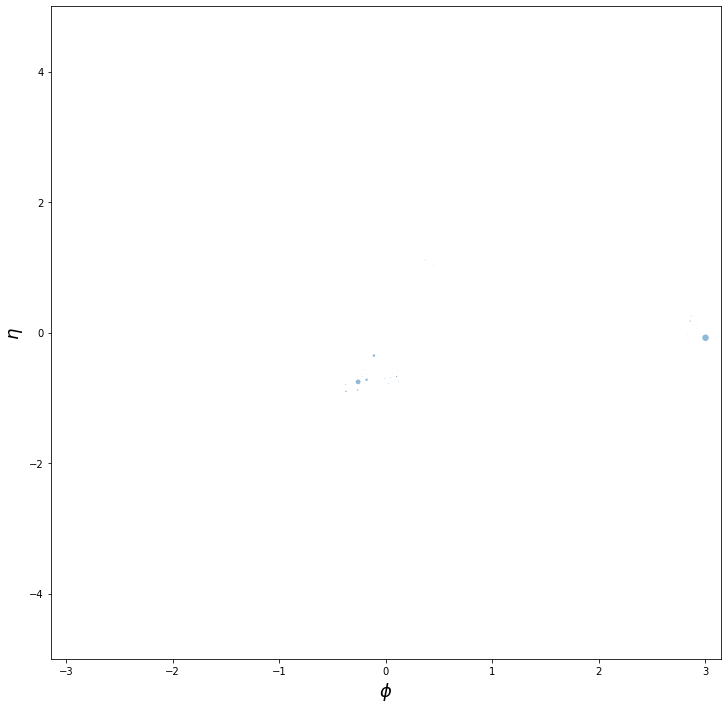

0.0 [0.9304774  0.93506986 0.93003297 0.9261163  0.9115519 ]


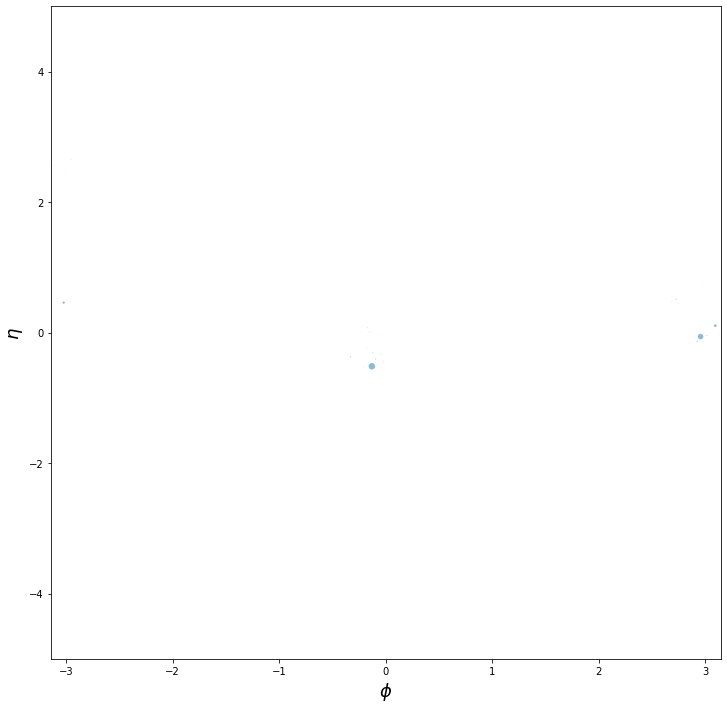

1.0 [0.9488824  0.94731474 0.9417999  0.9334895  0.91839826]


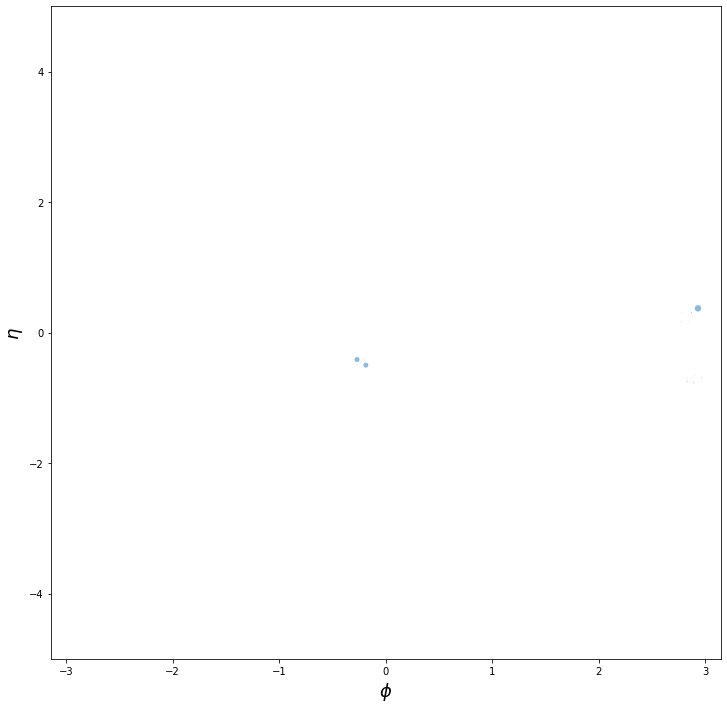

1.0 [0.8385635  0.87954366 0.901831   0.8971209  0.89900064]


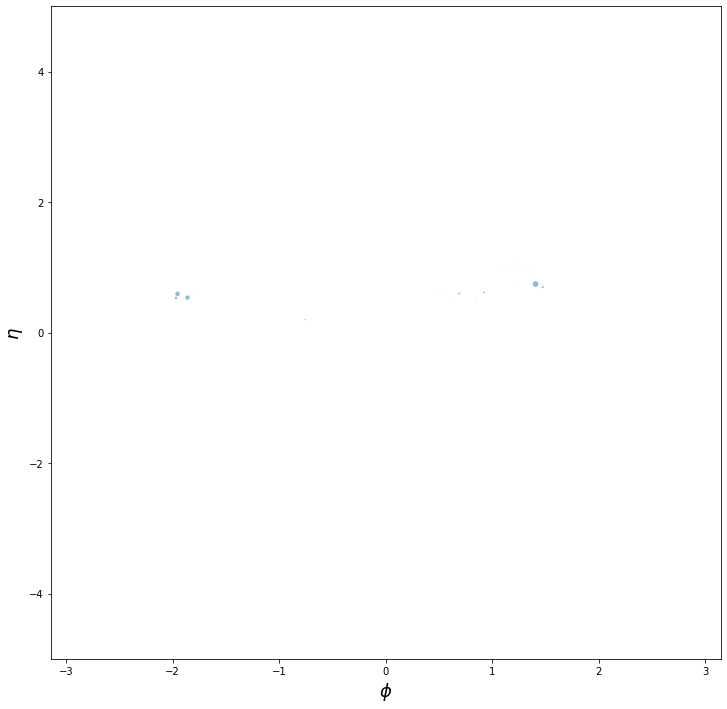

0.0 [0.85464996 0.8964835  0.90956867 0.9121962  0.9012954 ]


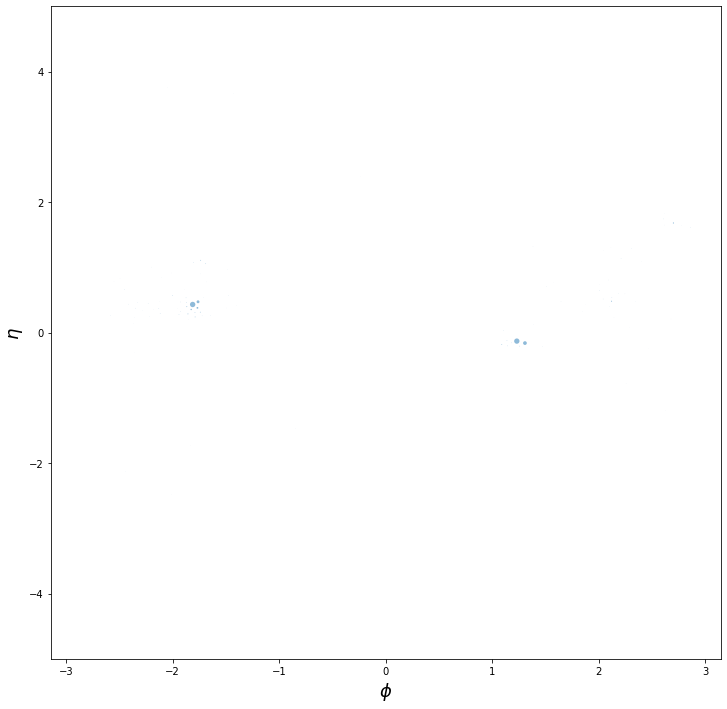

0.0 [0.9231921 0.9312466 0.9318937 0.9191758 0.9088743]


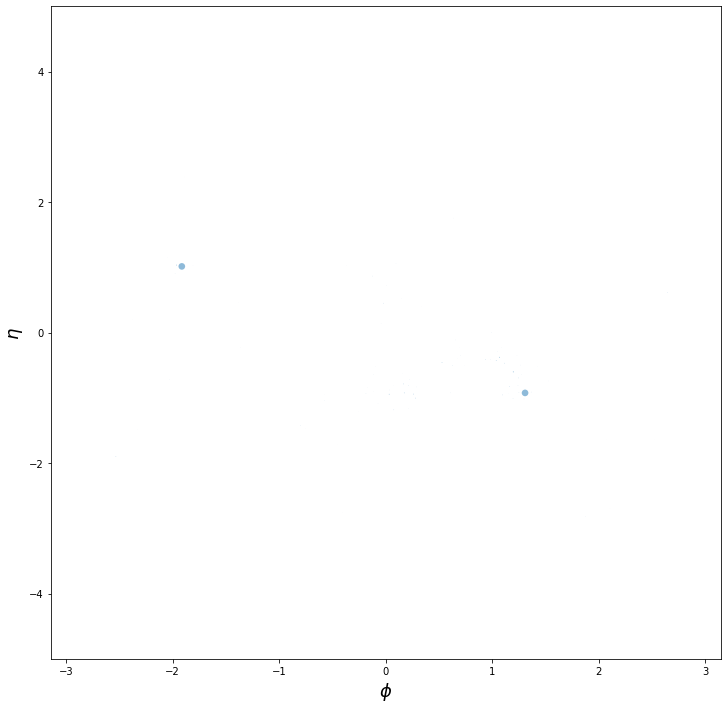

0.0 [6.6742435e-04 4.7365114e-02 7.1866256e-01 8.0934060e-01 8.0475056e-01]


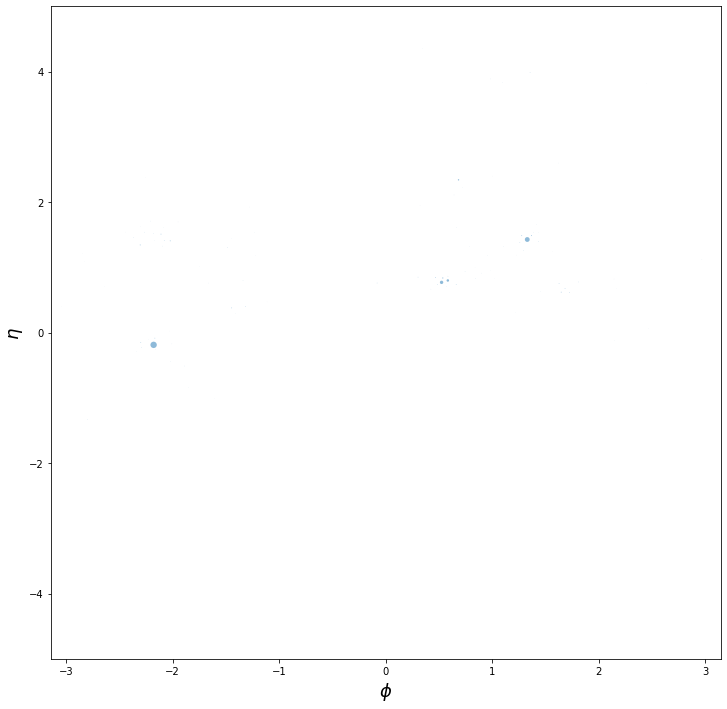

0.0 [0.05013729 0.57498217 0.8778793  0.877919   0.85863066]


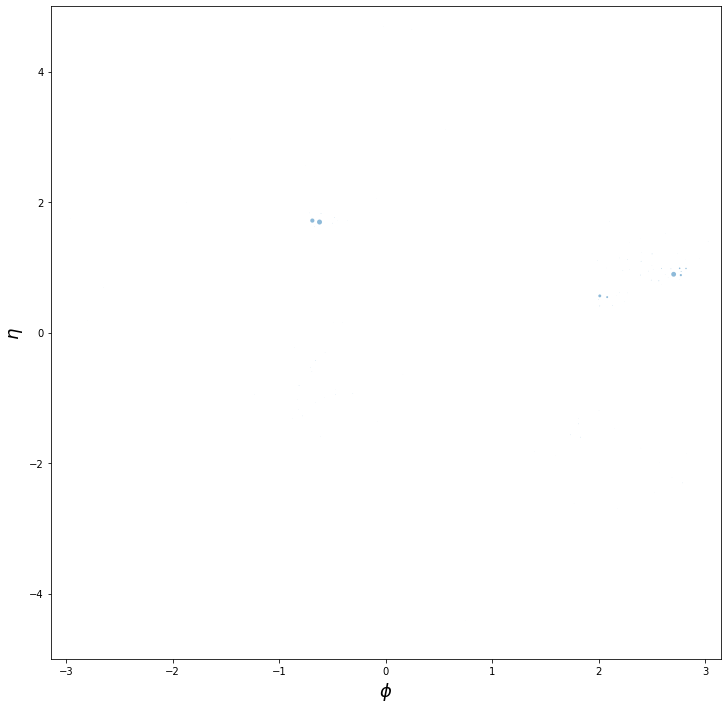

0.0 [0.79040956 0.87825614 0.90761757 0.9122664  0.89687604]


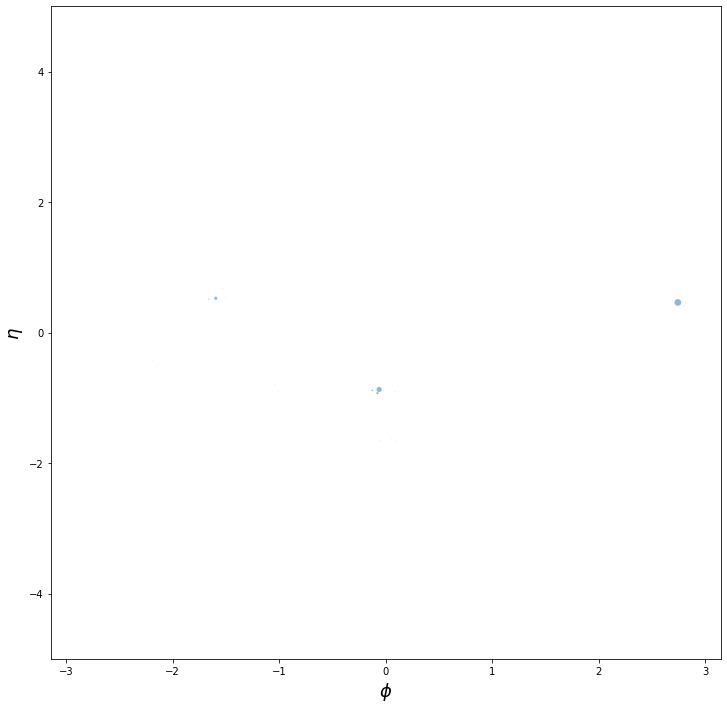

0.0 [5.9604645e-08 1.4901140e-06 1.6350349e-02 2.1126065e-02 3.3604532e-01]


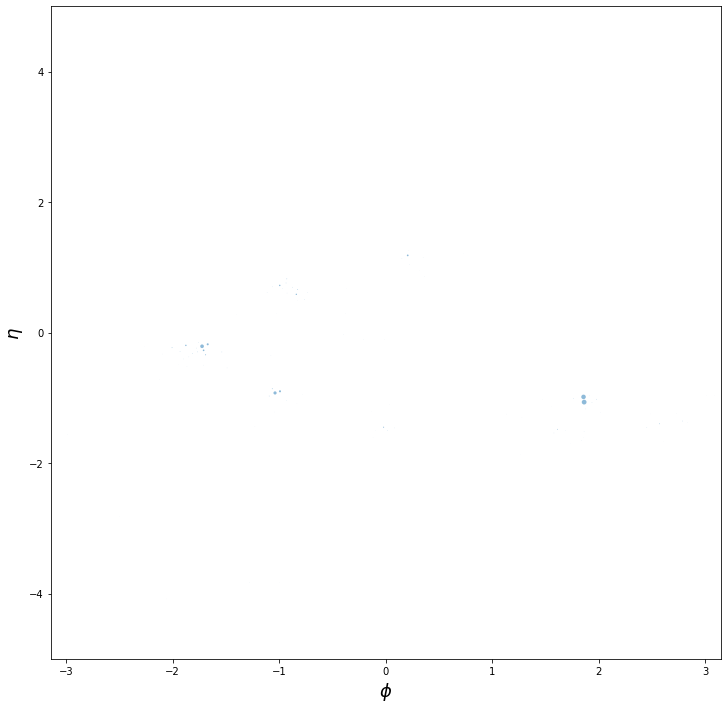

0.0 [0.9303319 0.9353541 0.9327754 0.9260581 0.9157541]


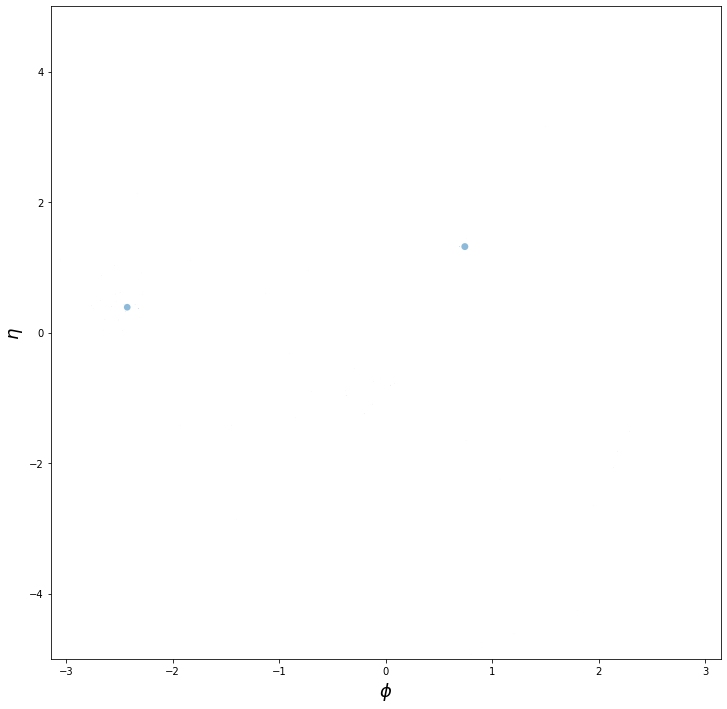

0.0 [0.94214803 0.94298124 0.93957555 0.9321709  0.9238595 ]


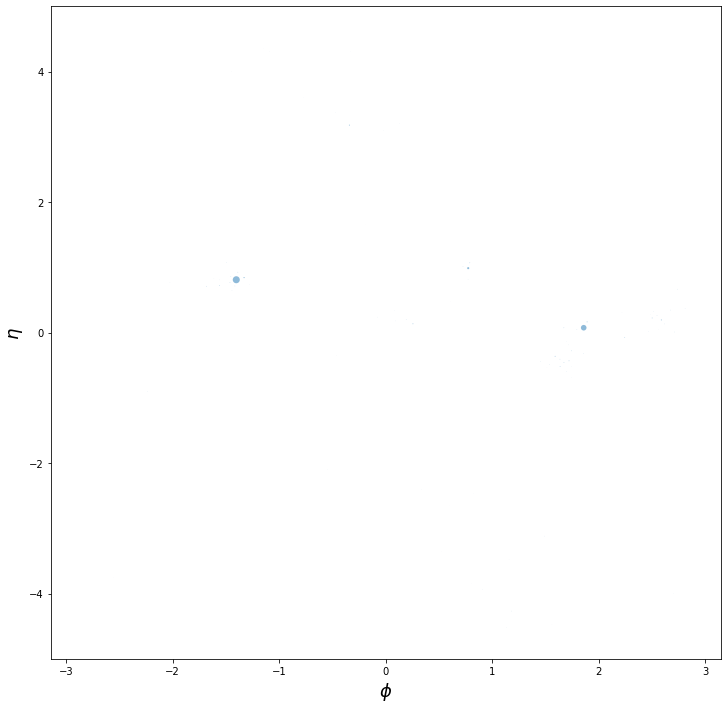

0.0 [0.90500975 0.91922665 0.9277362  0.9231545  0.9102514 ]


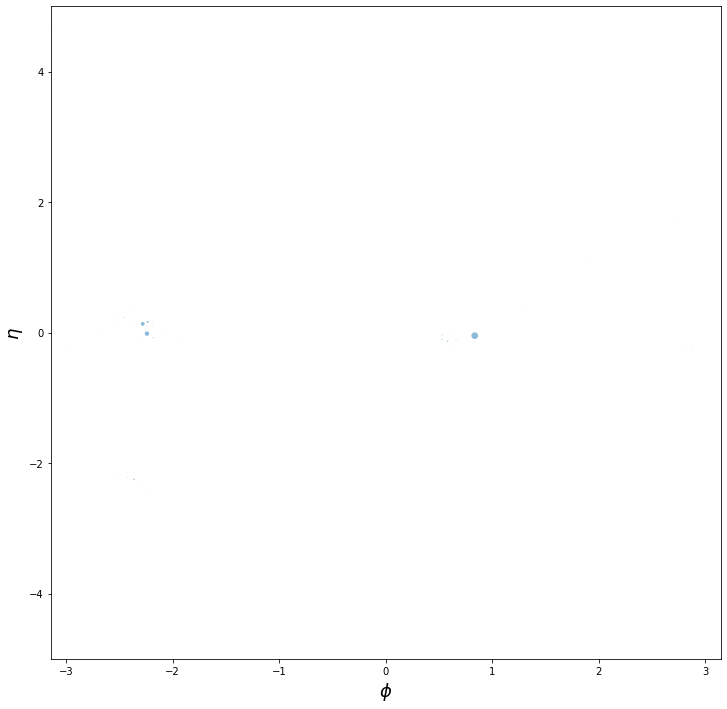

0.0 [0.8676002  0.90467864 0.9205733  0.92014724 0.9038774 ]


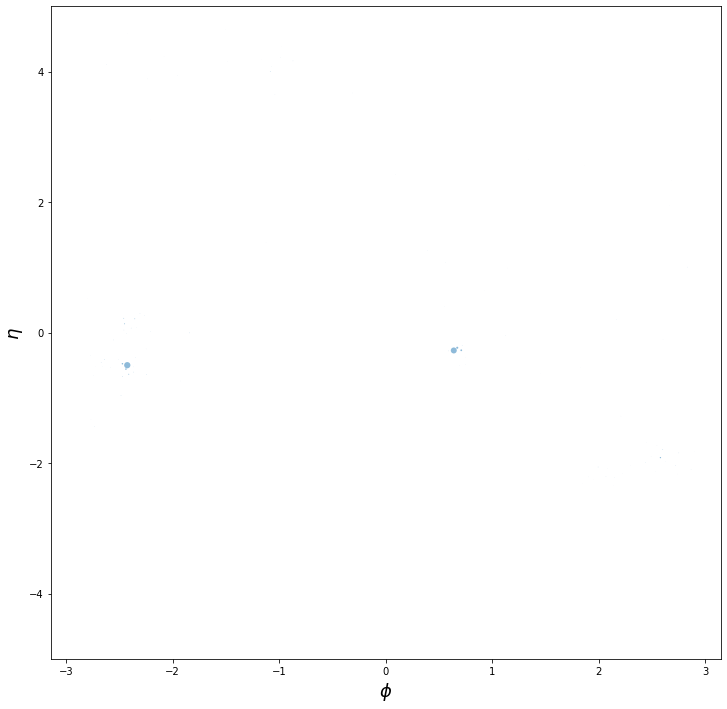

0.0 [0.87862474 0.9063961  0.9170633  0.9183003  0.9043933 ]


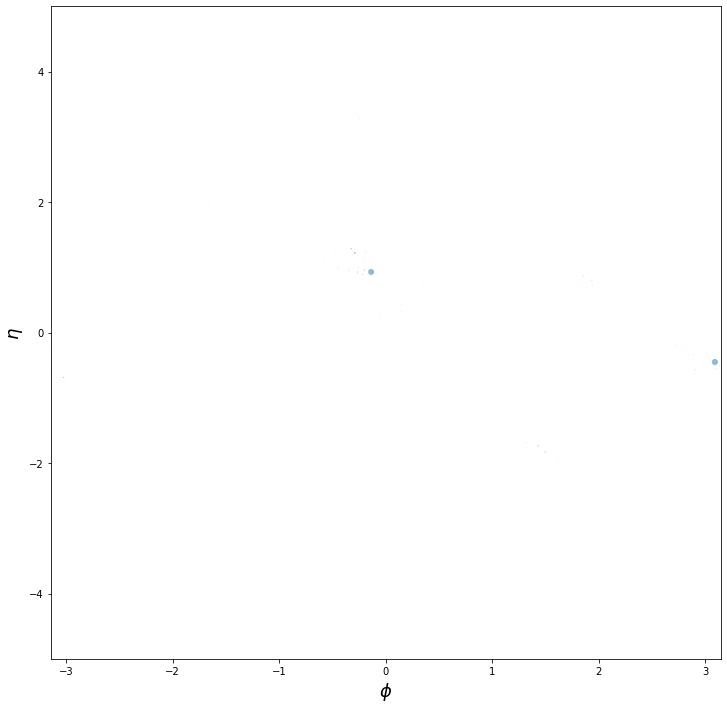

0.0 [0.9084149  0.91850924 0.92321    0.91644955 0.8971944 ]


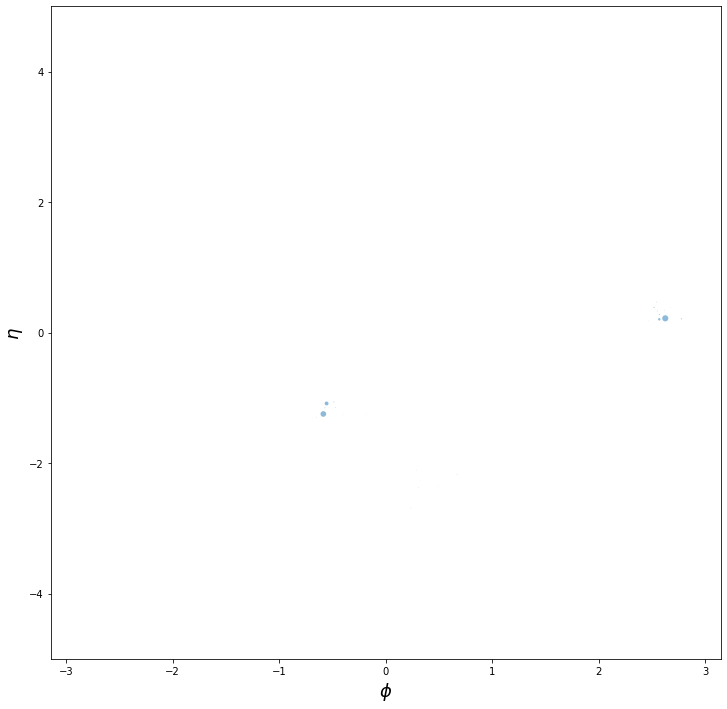

0.0 [0.50563824 0.7671895  0.88779616 0.88960975 0.87342614]


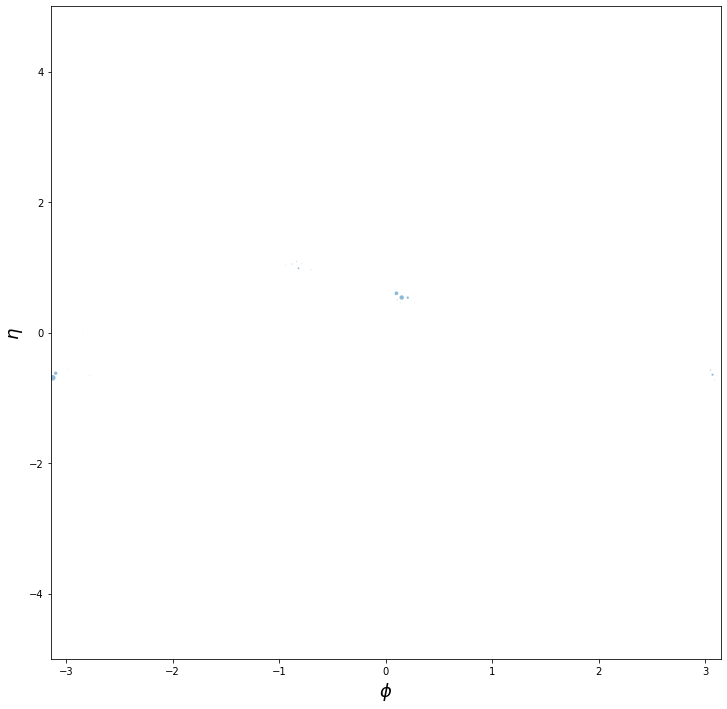

0.0 [0.00319879 0.11113437 0.84491605 0.8752159  0.8767195 ]


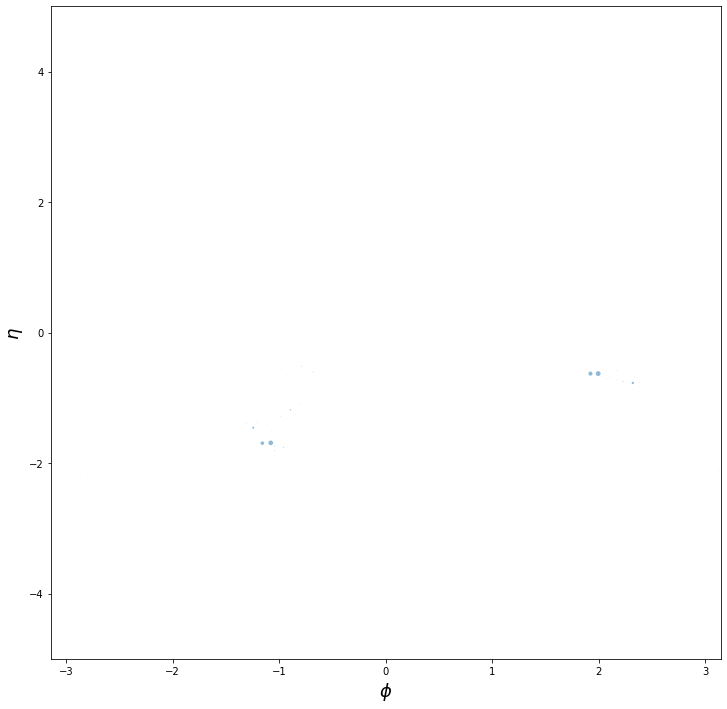

0.0 [0.25176257 0.7937901  0.90071845 0.90072423 0.8959841 ]


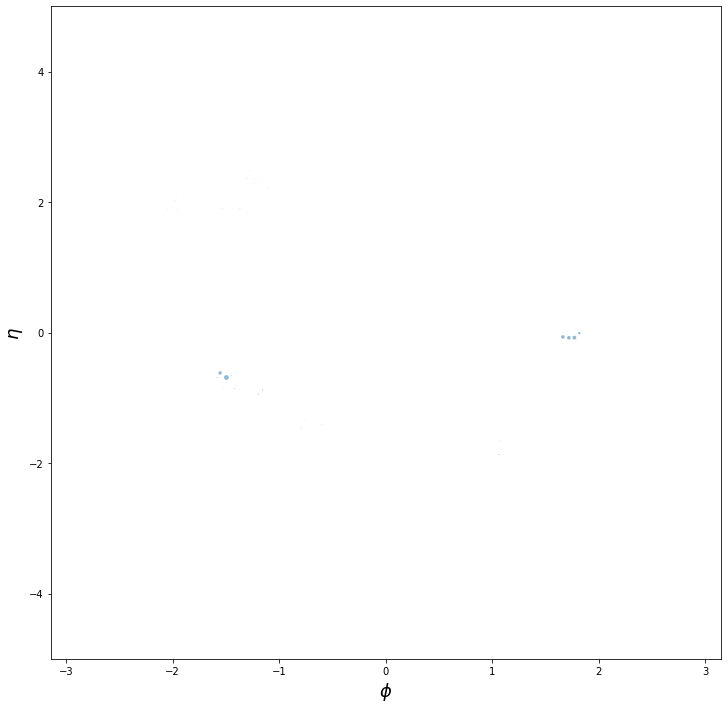

0.0 [0.7867196  0.8728657  0.89826477 0.91118425 0.89335555]


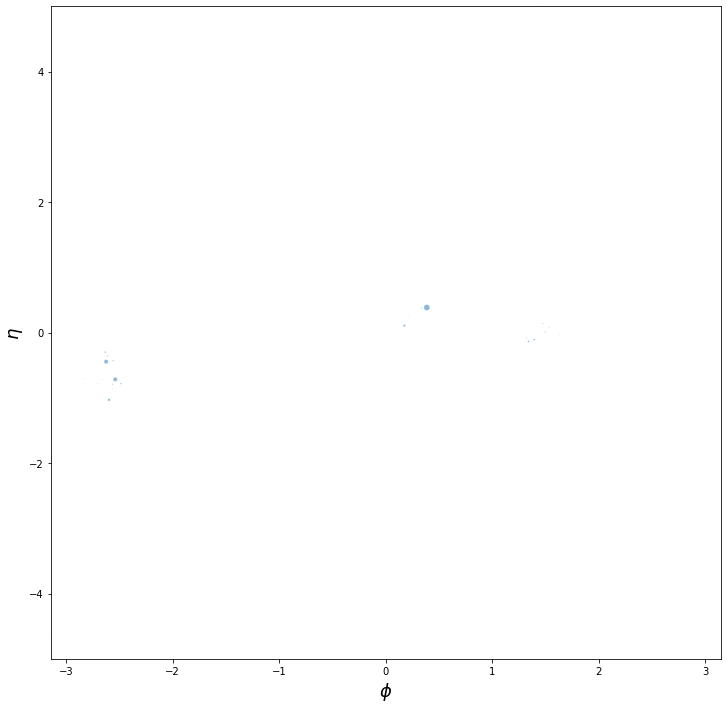

0.0 [0.87000394 0.8970469  0.9185575  0.9048108  0.90458745]


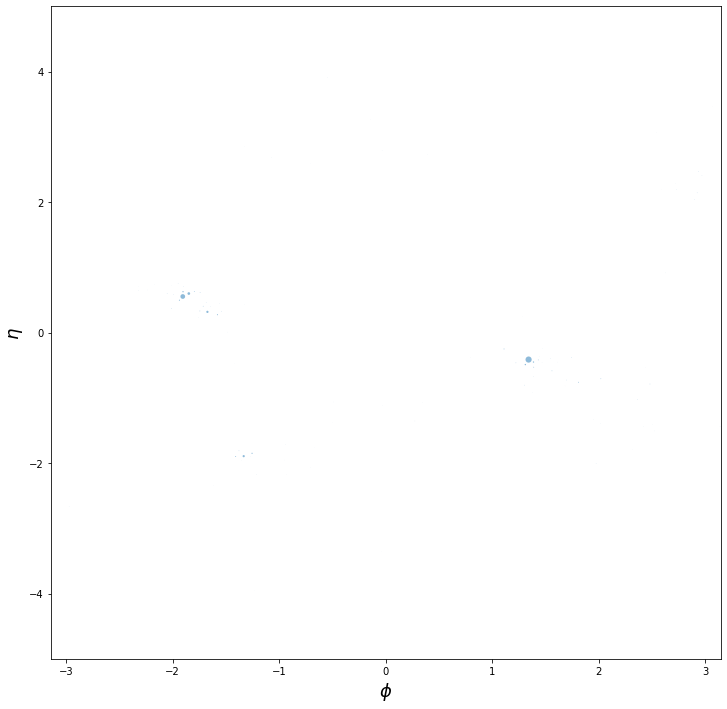

0.0 [0.9141877  0.92302006 0.9244491  0.9202228  0.9070992 ]


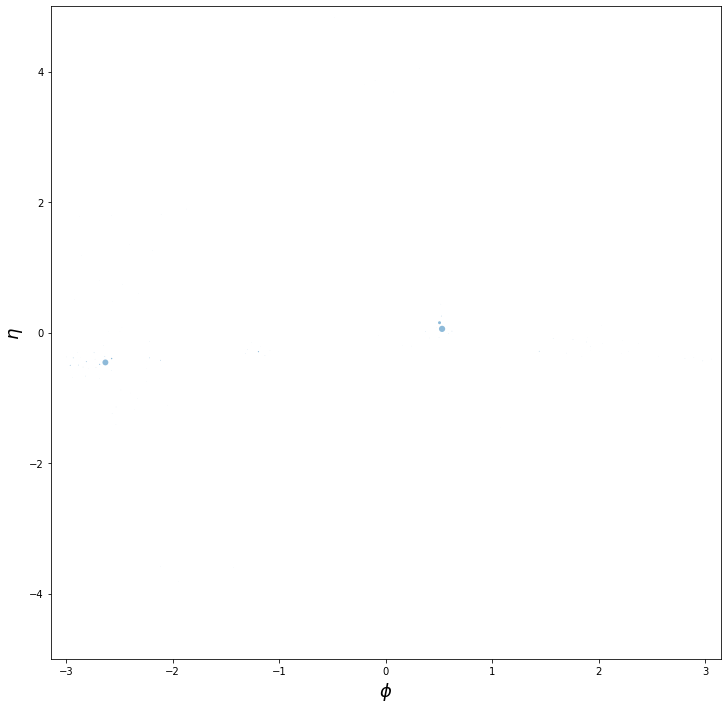

0.0 [0.00325481 0.09658943 0.7215114  0.8306189  0.805598  ]


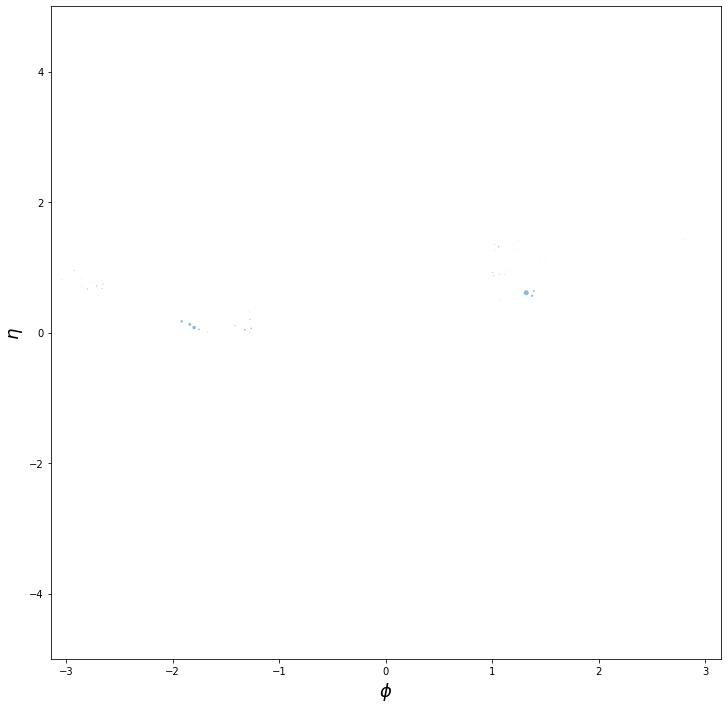

0.0 [0.9452757 0.9446503 0.9389862 0.9293458 0.914234 ]


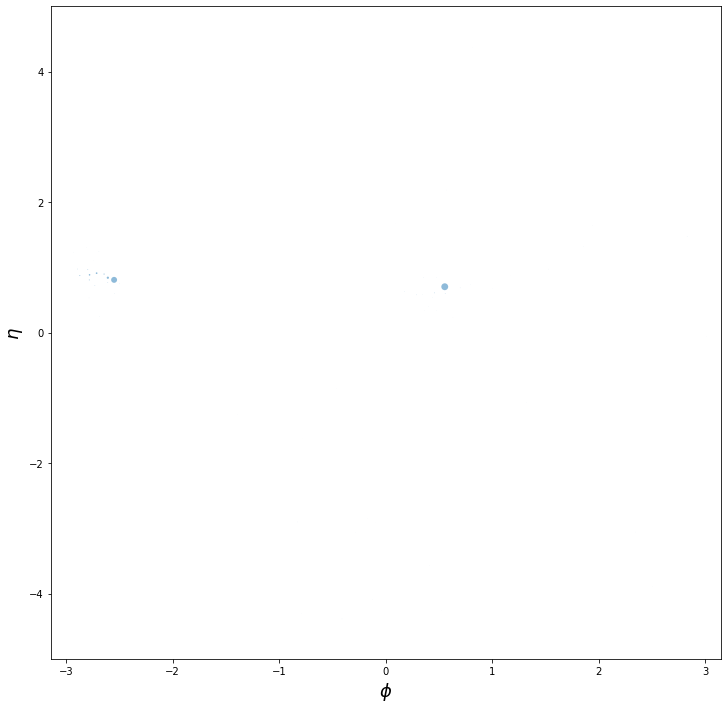

0.0 [0.90385544 0.9082776  0.9224527  0.91241497 0.898295  ]


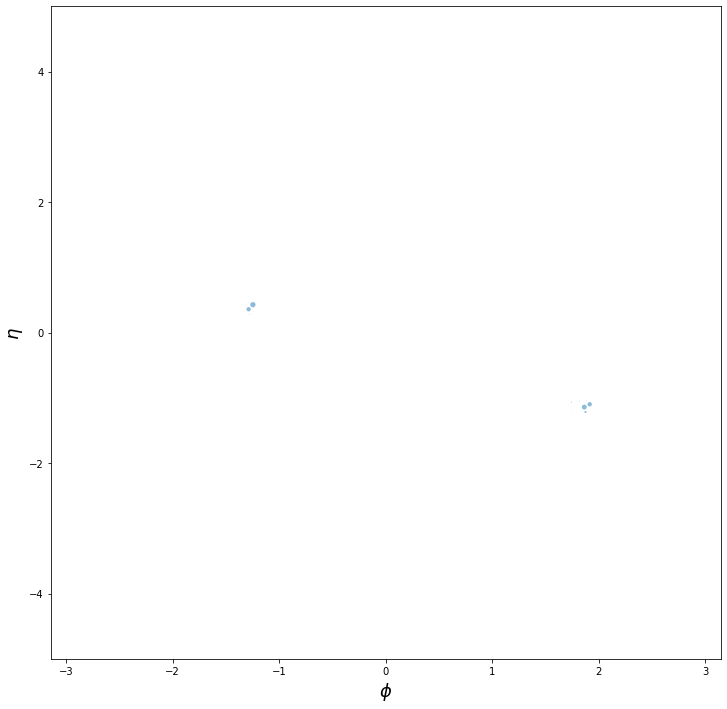

0.0 [0.89220583 0.9060266  0.91622585 0.9131794  0.89180267]


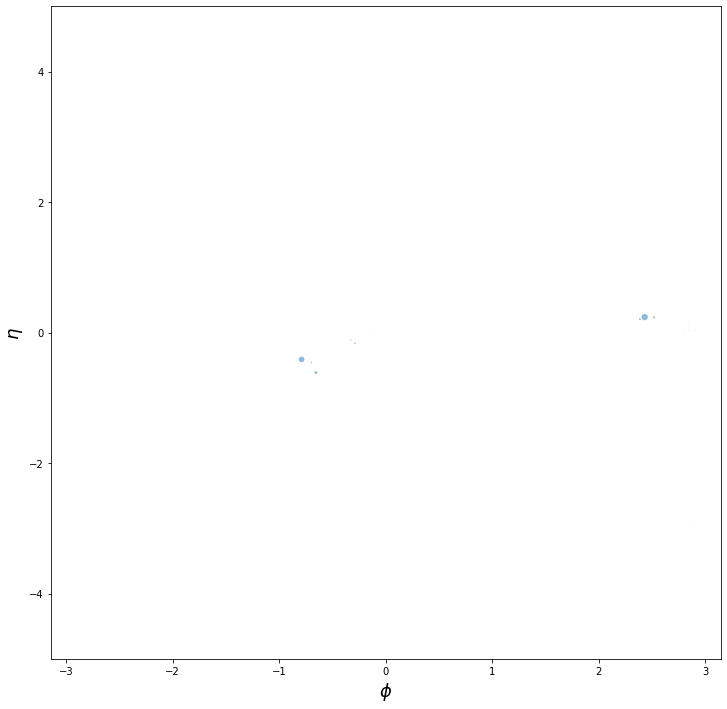

0.0 [0.8879118  0.9046255  0.9188018  0.9190623  0.90030396]


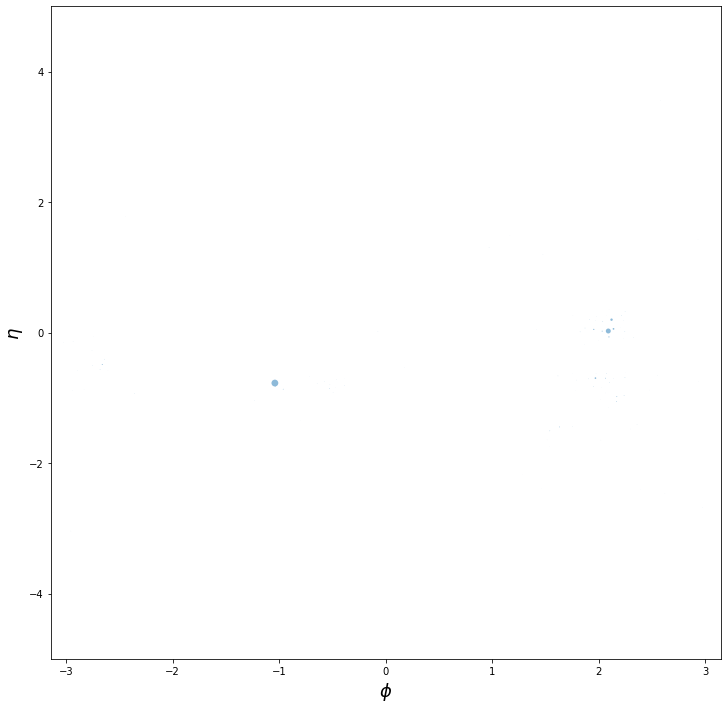

0.0 [0.90586406 0.920504   0.9221392  0.92483914 0.90977395]


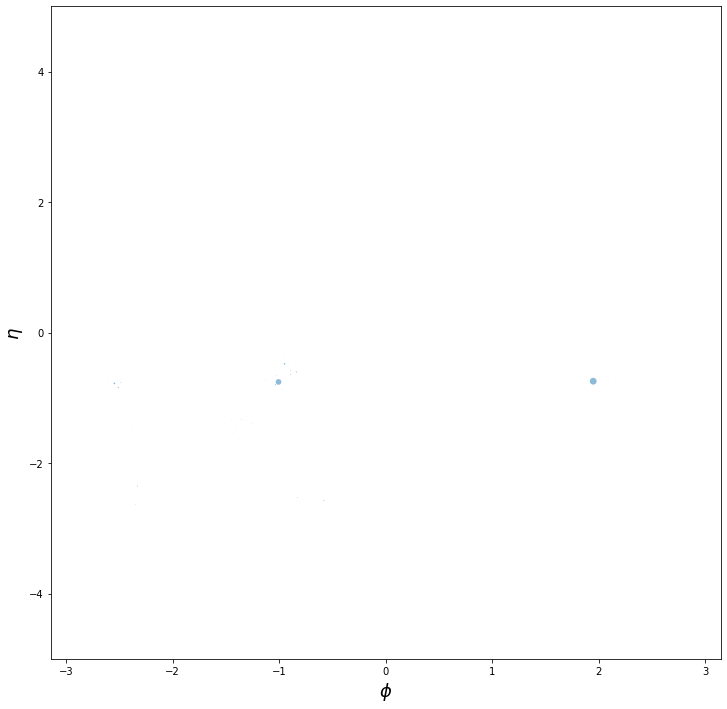

0.0 [0.89075845 0.90555334 0.91930336 0.9148202  0.8904124 ]


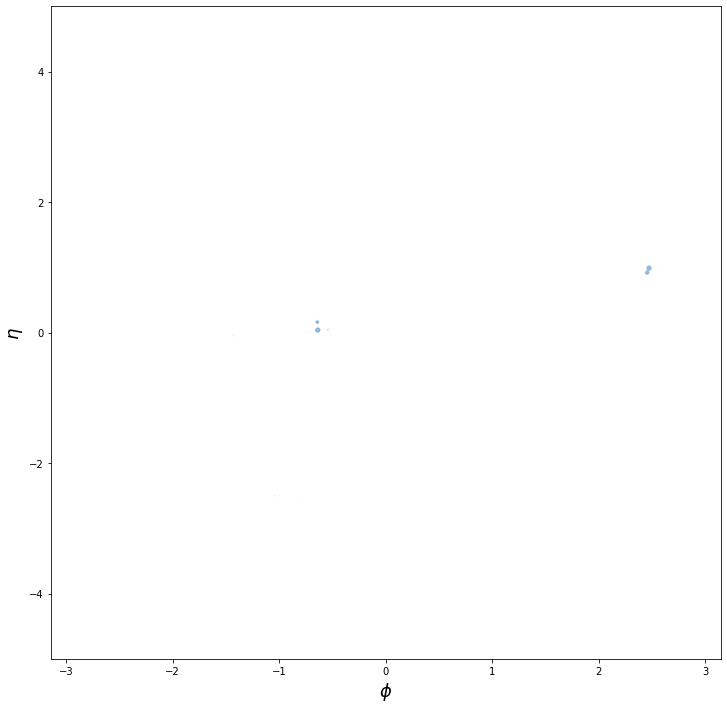

1.0 [0.2779671  0.7409269  0.88501585 0.8829146  0.8758288 ]


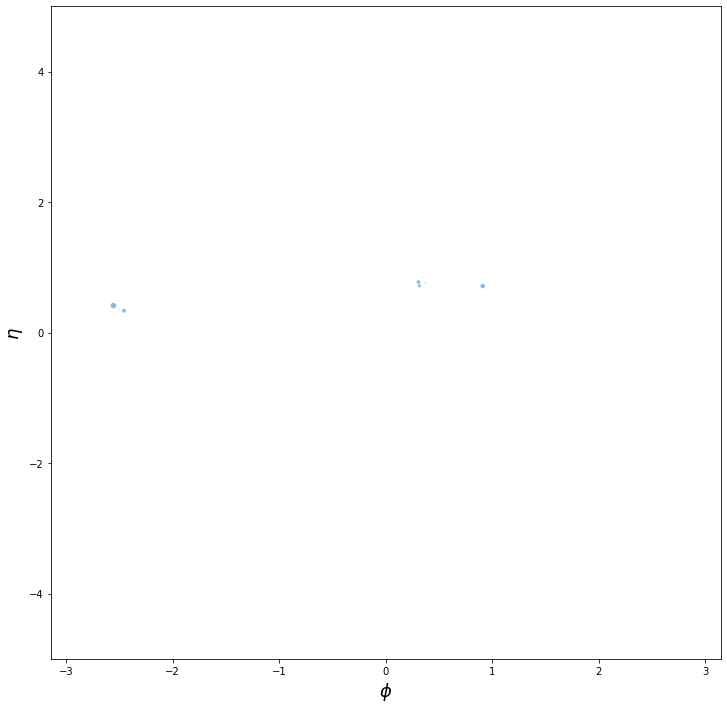

0.0 [0.9231035  0.92703235 0.92756873 0.9162747  0.89949614]


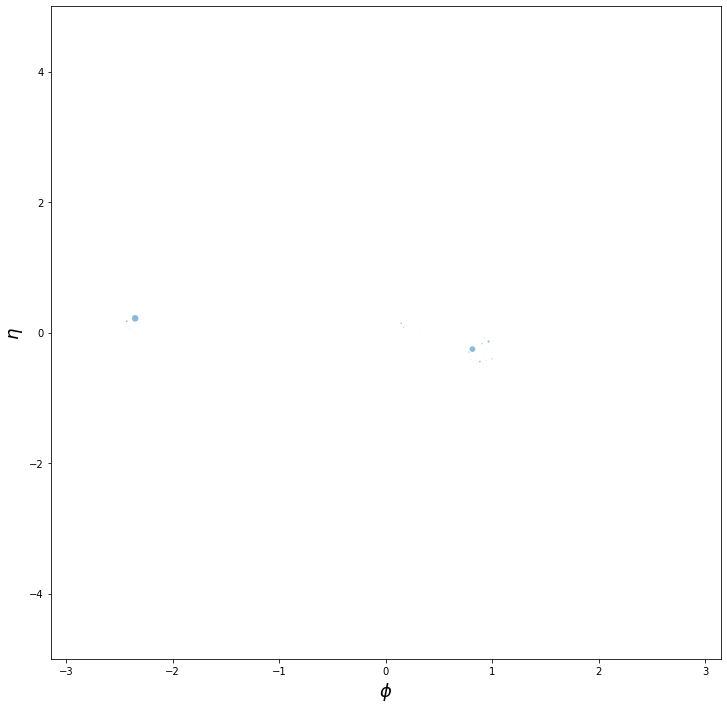

0.0 [0.90295666 0.9154354  0.9236245  0.9213925  0.90948683]


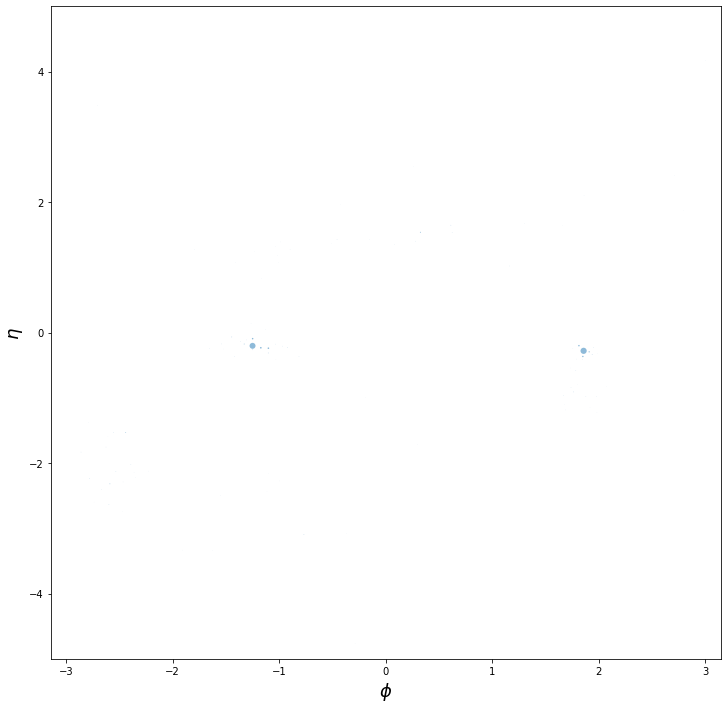

0.0 [0.839181   0.8841528  0.90960574 0.9163329  0.9031589 ]


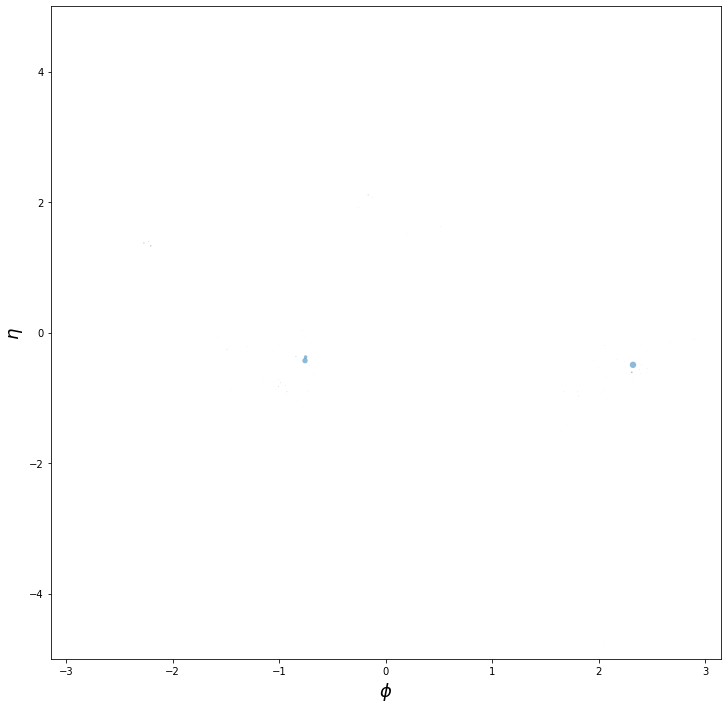

0.0 [0.8835735  0.9036419  0.92040294 0.91486764 0.89900225]


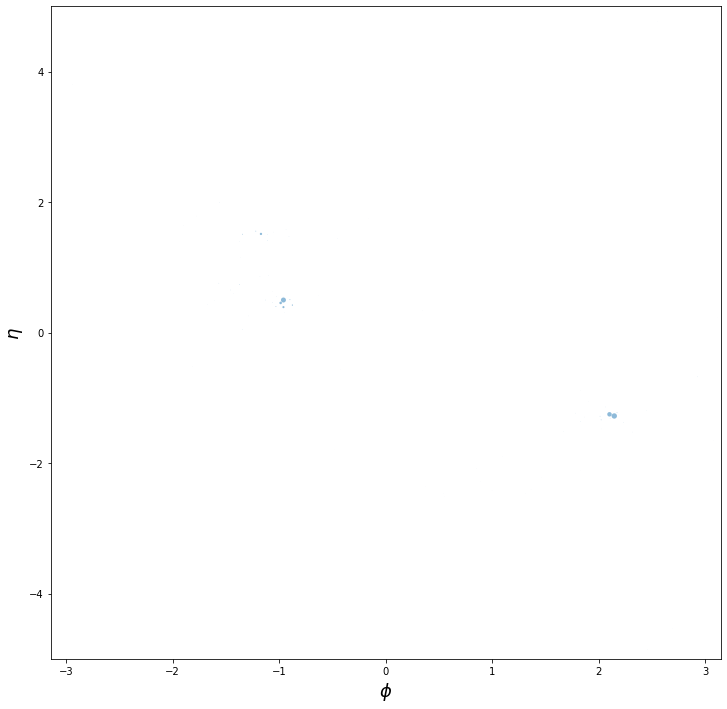

0.0 [0.8933796 0.9003876 0.9234969 0.9163551 0.8994436]


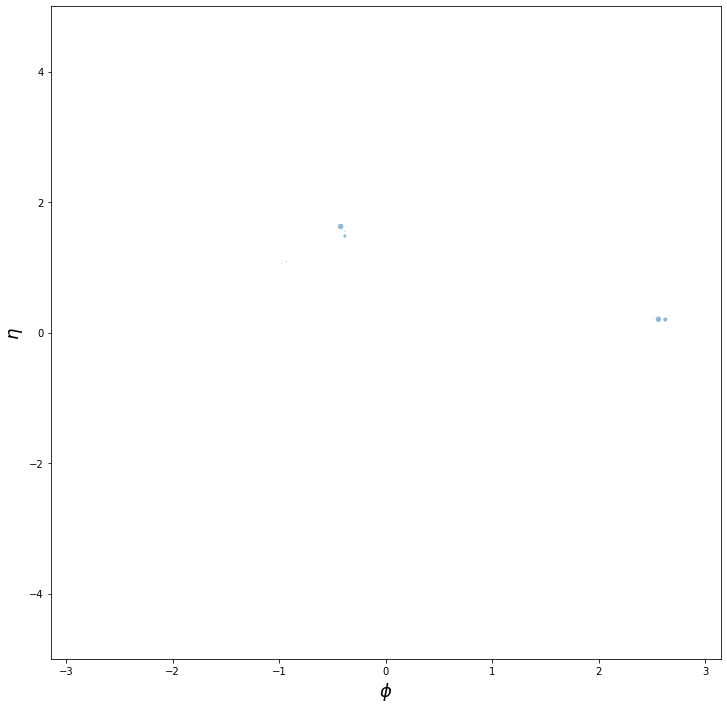

0.0 [0.89898884 0.90575886 0.9179438  0.9069996  0.8954881 ]


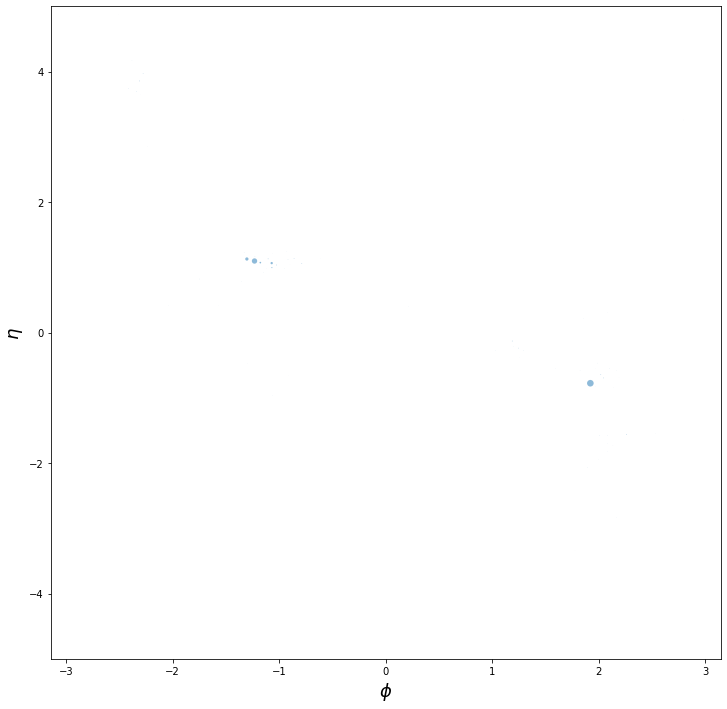

0.0 [0.7277722  0.81986153 0.89150184 0.900378   0.88821304]


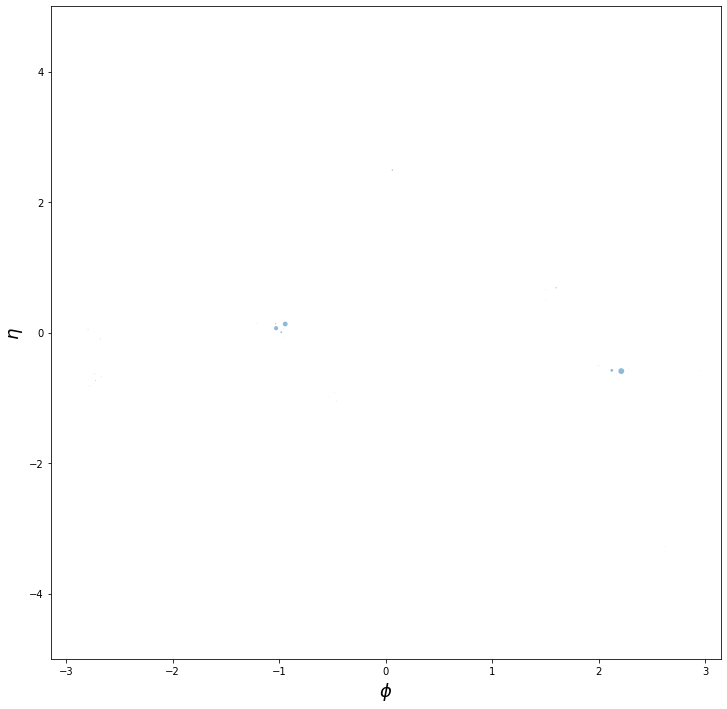

0.0 [0.9240935 0.9316939 0.9294844 0.921936  0.9043336]


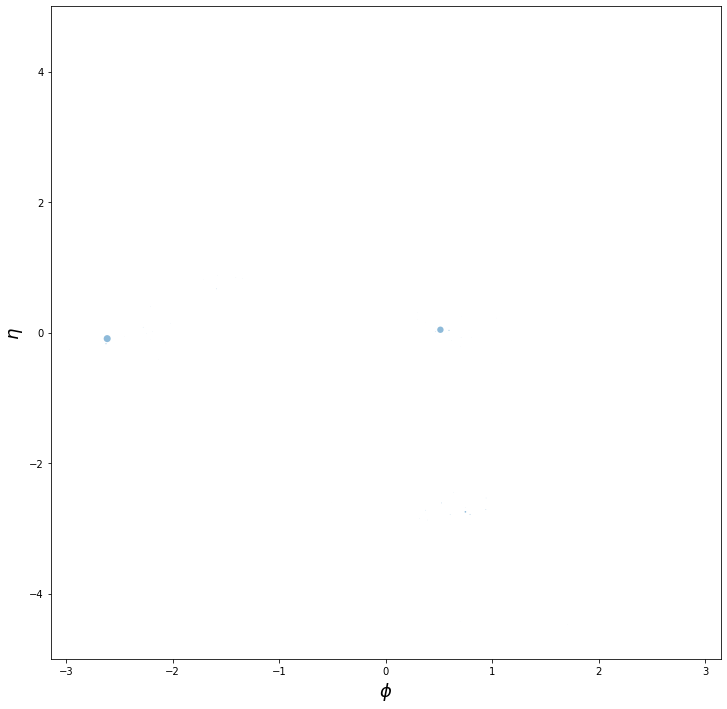

1.0 [0.8073261 0.8224046 0.8883929 0.8616337 0.8707454]


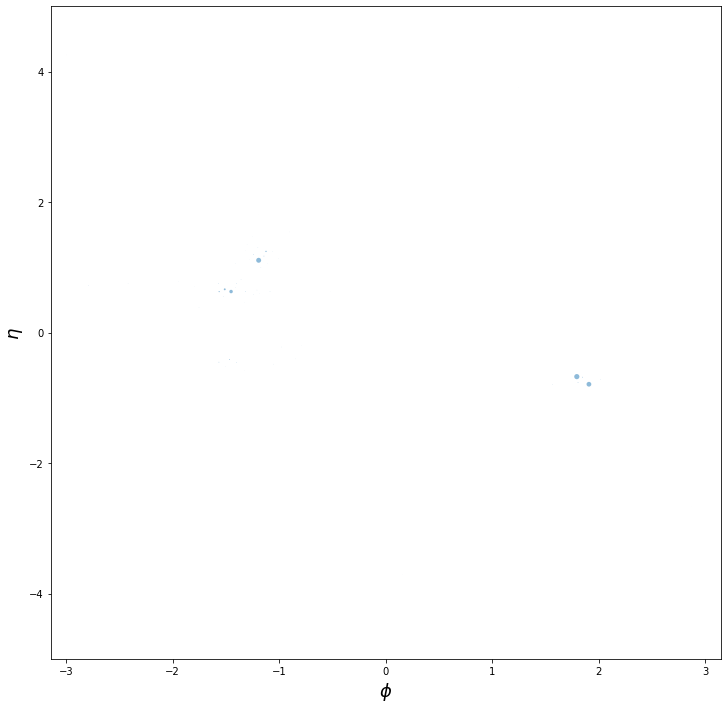

0.0 [0.902896   0.9196476  0.9257491  0.91937685 0.9148457 ]


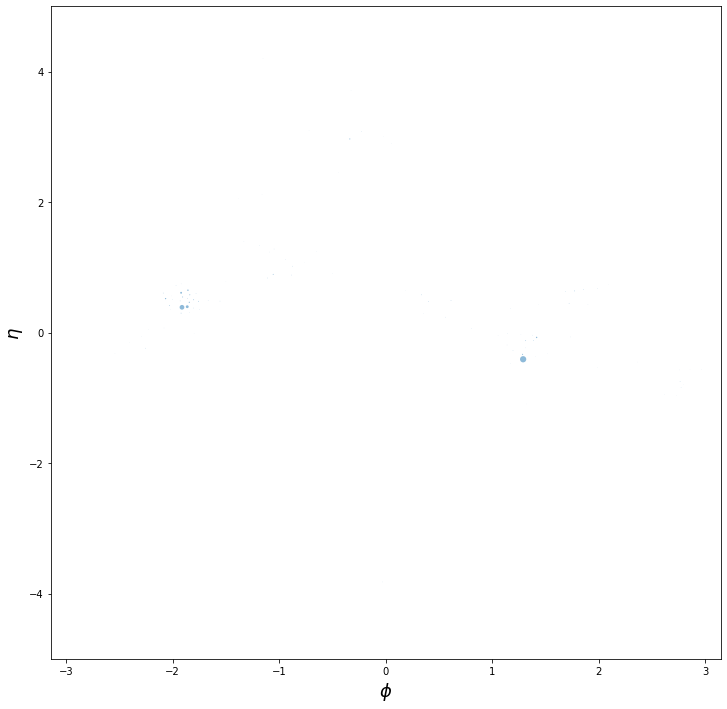

0.0 [0.9309333  0.9328061  0.93516004 0.92672396 0.9087456 ]


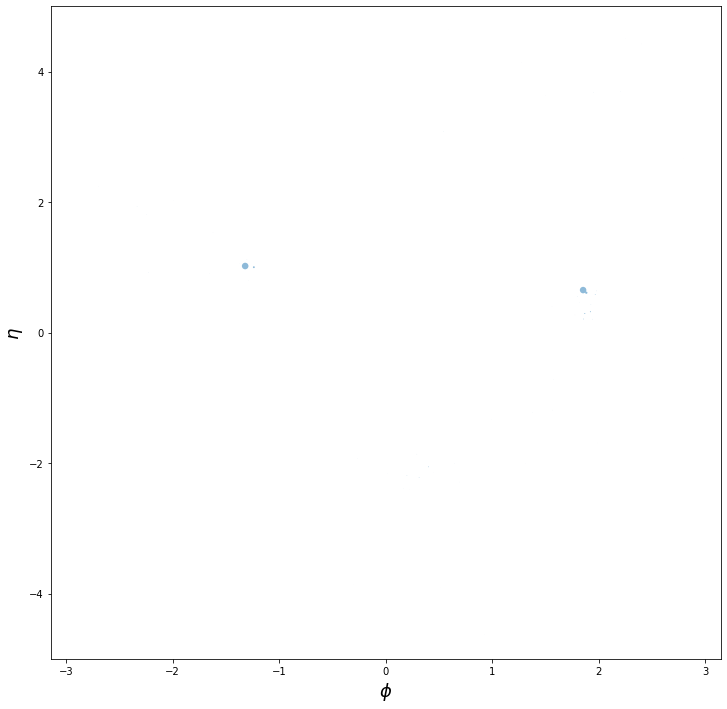

1.0 [0.7054056  0.83456314 0.901715   0.8998195  0.8793547 ]


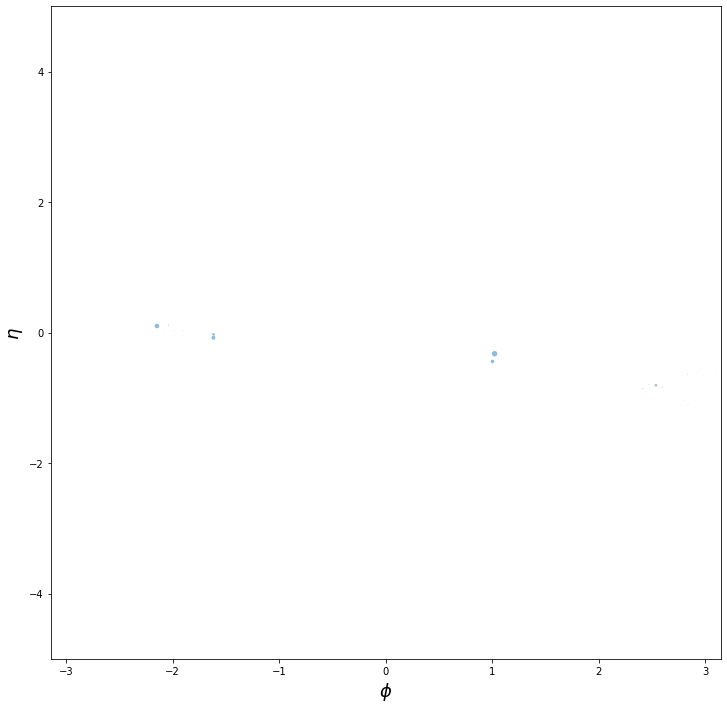

0.0 [0.8883977  0.9076358  0.9233656  0.9210879  0.90929496]


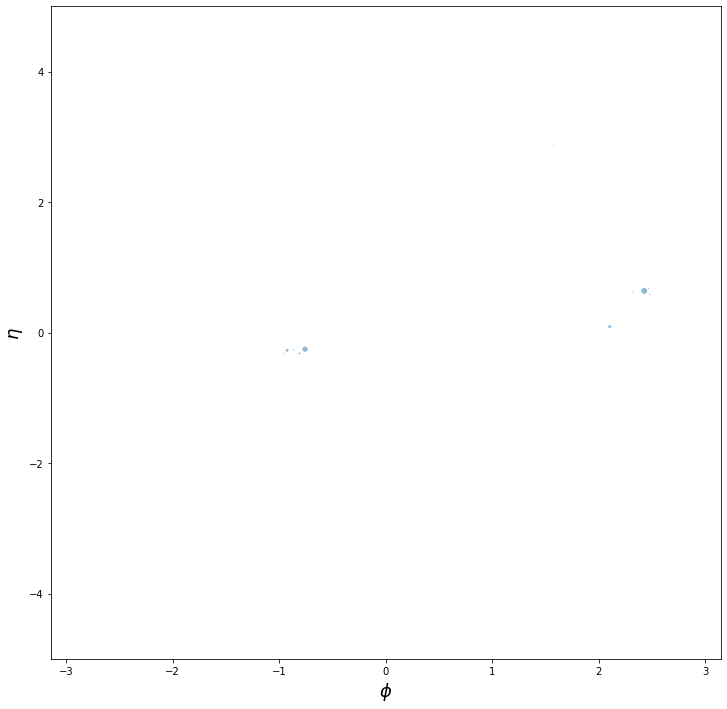

0.0 [0.88722867 0.90913504 0.9229428  0.9227884  0.90764475]


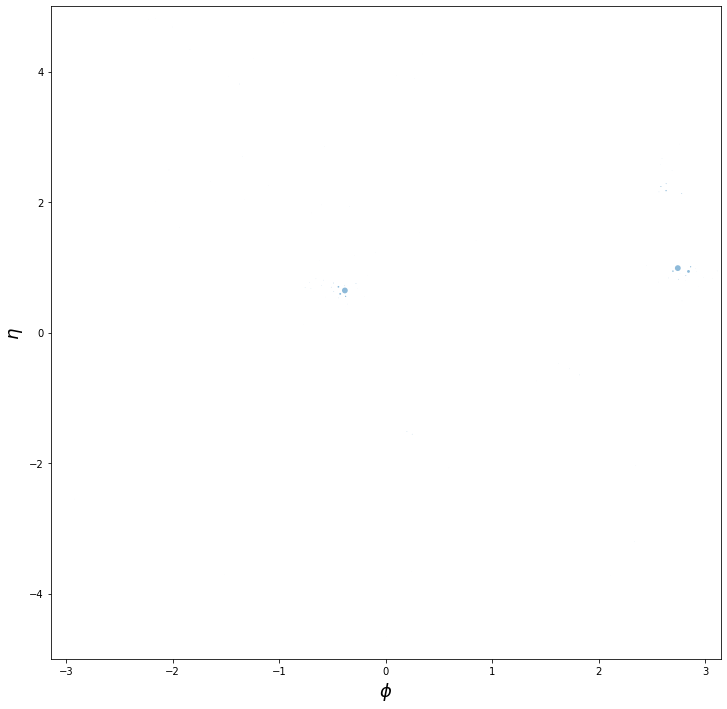

0.0 [0.8972668  0.9145746  0.92291933 0.9198036  0.90751505]


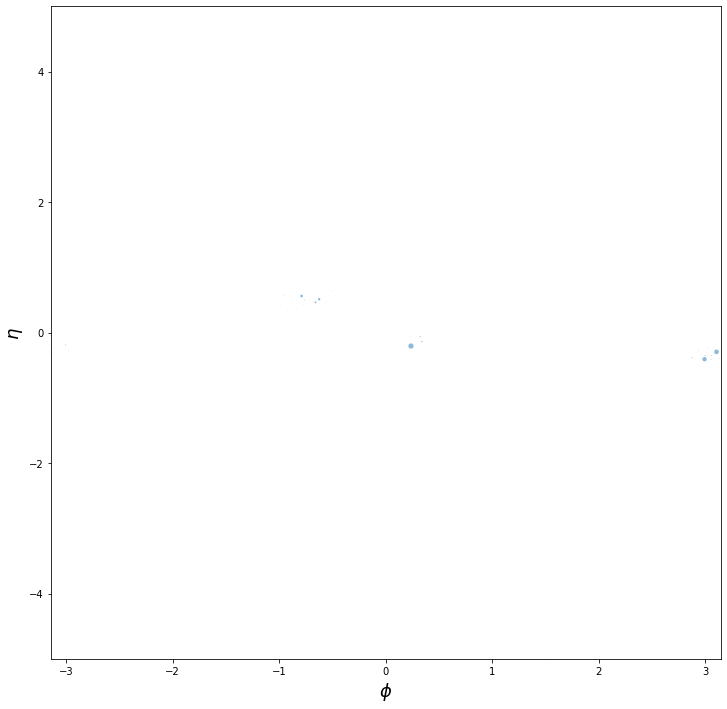

0.0 [0.928279   0.9325596  0.9324586  0.93097293 0.9138833 ]


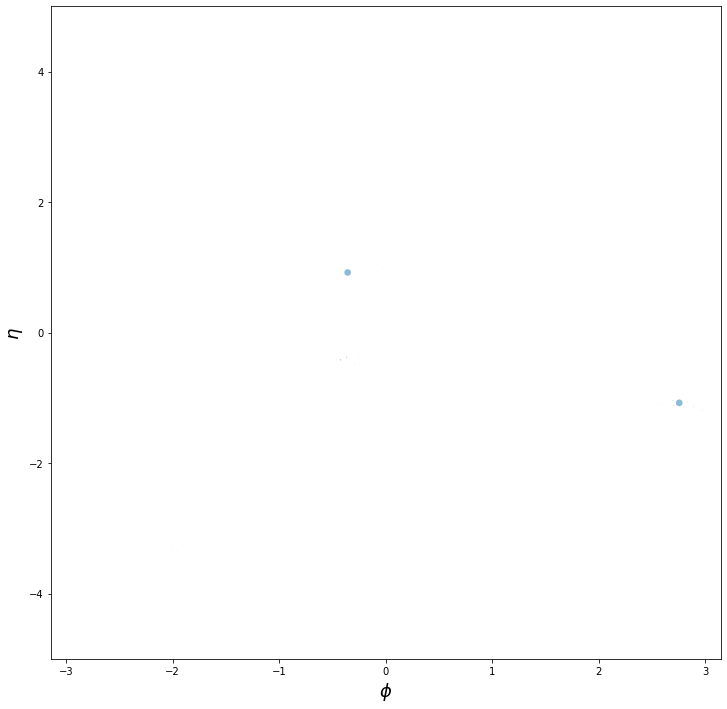

0.0 [0.8744097  0.8878744  0.91124725 0.9062374  0.8889848 ]


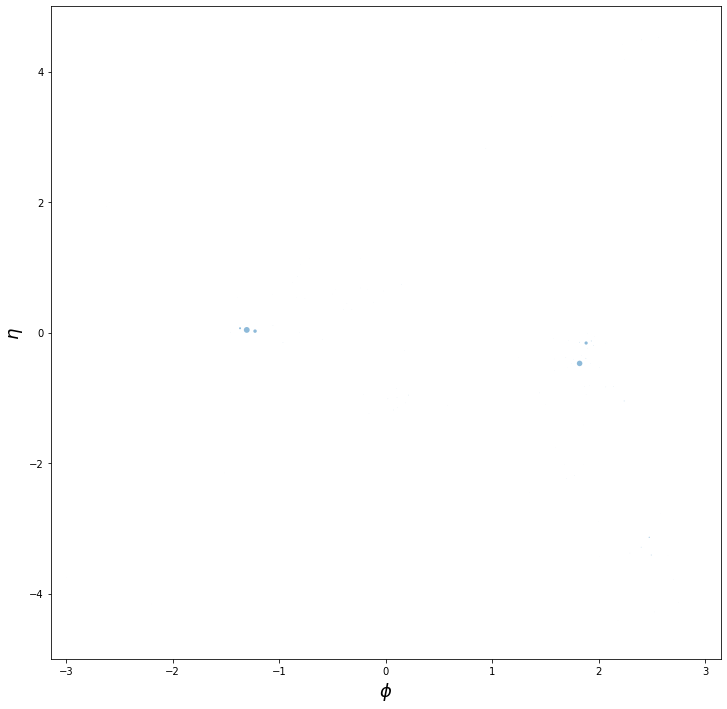

0.0 [0.1858281  0.550267   0.83971065 0.8401202  0.83123505]


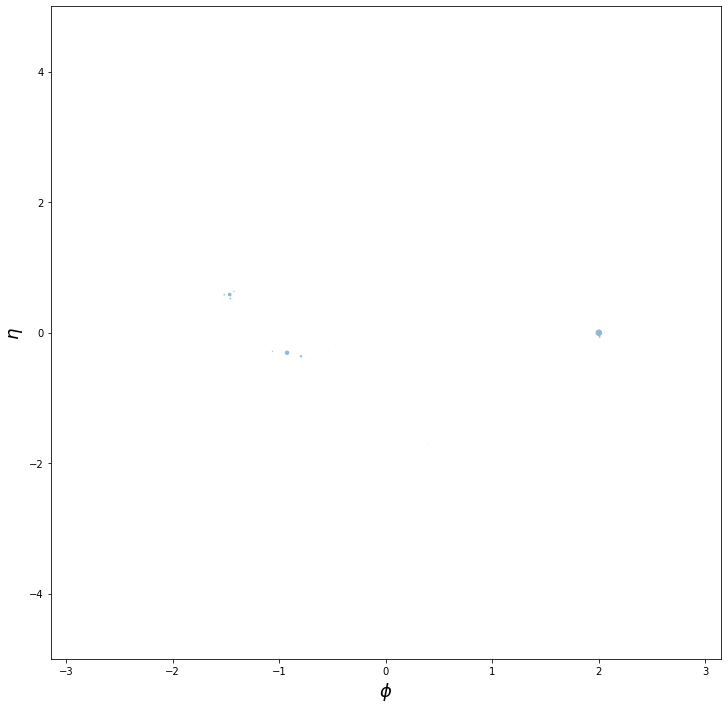

0.0 [0.6632569  0.8197562  0.8887094  0.88885653 0.87699586]


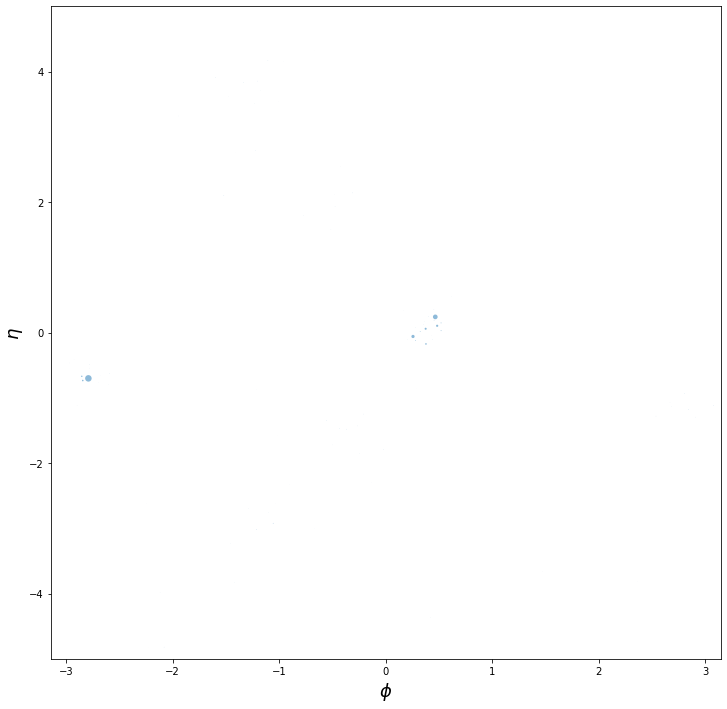

0.0 [0.94203514 0.9430595  0.93778896 0.92772895 0.9134195 ]


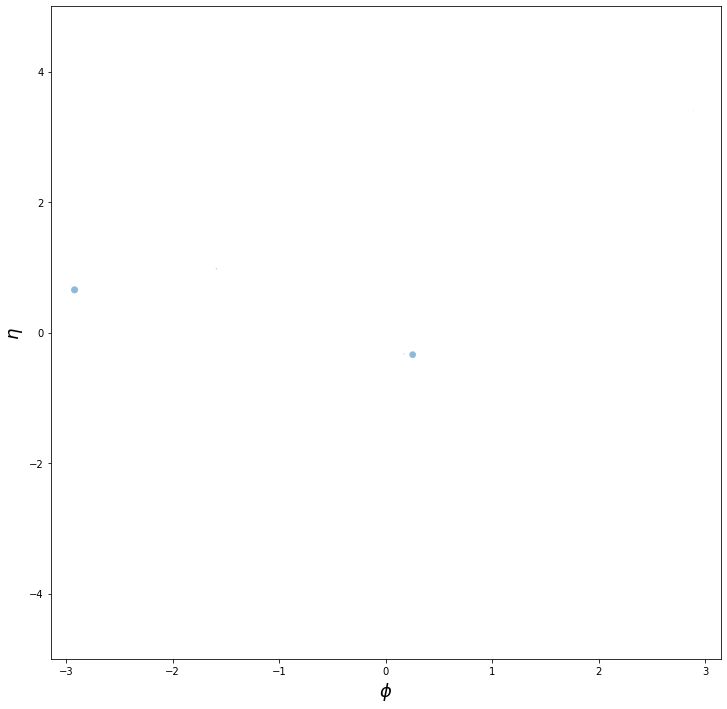

0.0 [6.5565064e-07 1.5258556e-05 2.5108957e-01 4.5618701e-01 7.5495666e-01]


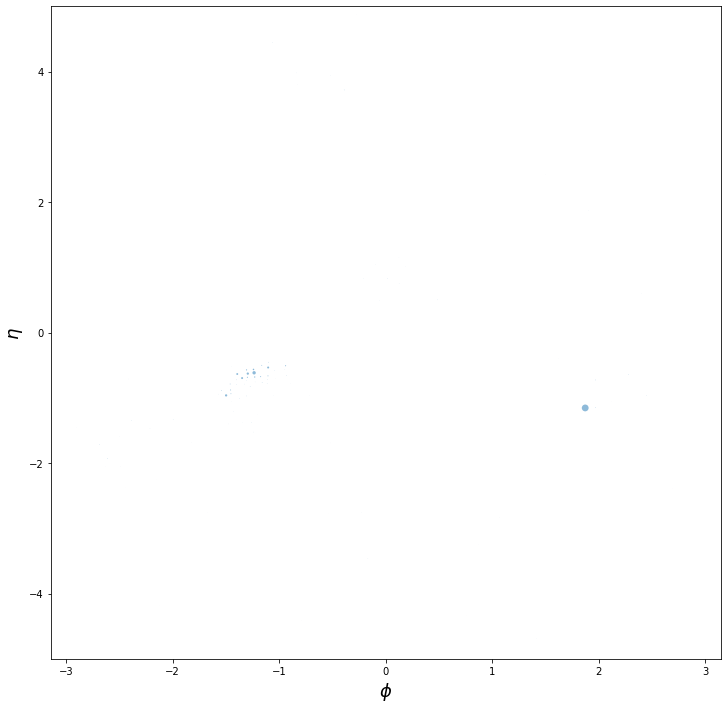

0.0 [0.92041886 0.9229398  0.92276204 0.9201102  0.9012865 ]


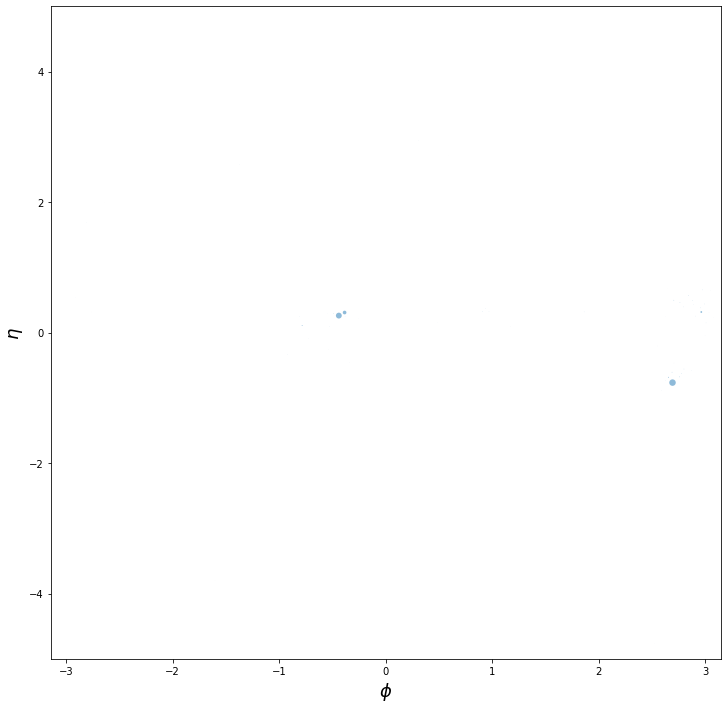

0.0 [0.8984608  0.91885495 0.9298959  0.92075473 0.90753925]


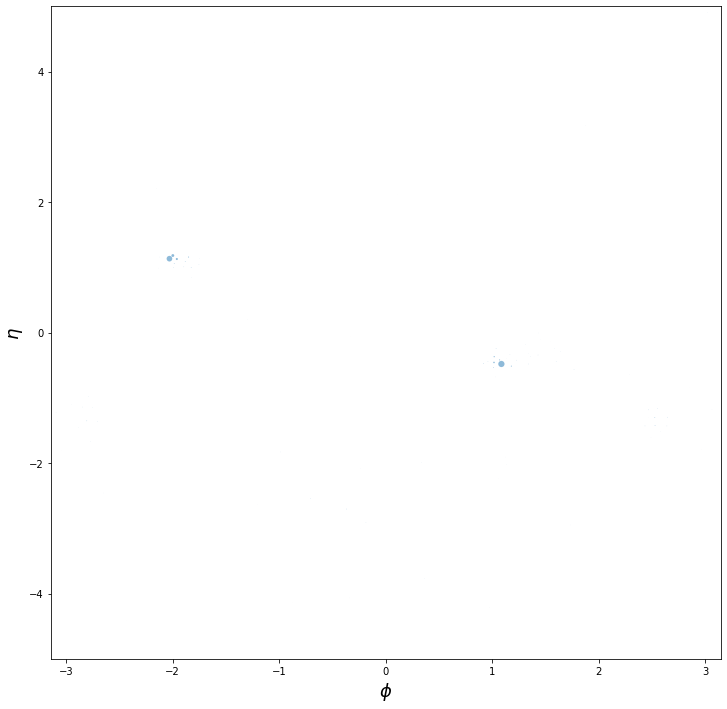

0.0 [0.9084086  0.92624336 0.93213266 0.93048173 0.9203985 ]


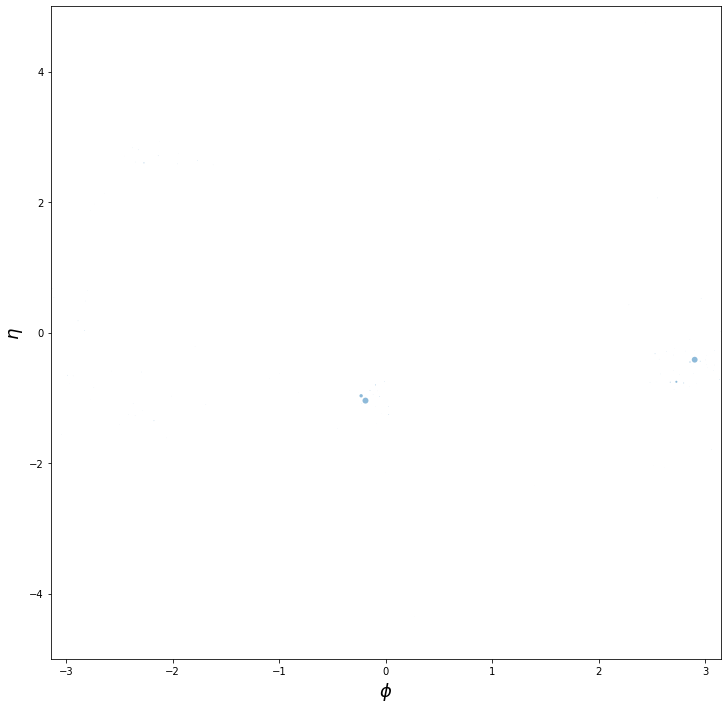

0.0 [0.86366636 0.87741935 0.90859216 0.8990061  0.8836193 ]


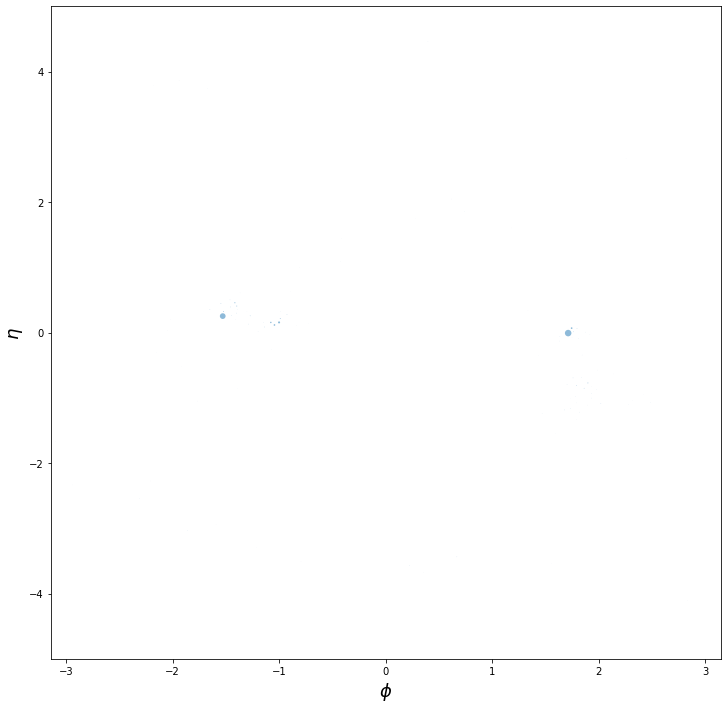

In [32]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in range(200):   

    fig, ax = plt.subplots(1, 1,figsize=[12,12])

    print(valid_labels[i], p_bern[i][bernsort_means[:5]])

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
    plt.scatter(phis, etas, s = pts*100, alpha = 0.5,linewidths=0)
    

#     #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
#     for j in range(2):
#         outjet = outs_array[j][0][i,:,1:]
#         weights = outs_array[j][0][i,:,0]
#         pred_labels = outs_array[j][-1][i]
#         print(pred_labels[bernsort_means[:5]])
#         pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
#         ax[j+1].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
# #         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
# #         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(1):
        plt.ylabel(r'$\eta$',fontsize=18)
        plt.xlabel(r'$\phi$',fontsize=18)
        plt.ylim([-etalim,etalim])
        plt.xlim([-np.pi,np.pi])
    
    plt.show()

In [277]:
pred_labels[-10]

1.342633e-10

0.0 [3.8742874e-06 3.2316554e-01 4.2153373e-03]
[1.6602369e-18 6.4934880e-02 7.6476899e-06]
[2.7918960e-17 3.6906080e-05 3.0217095e-09]
[2.3916770e-21 1.4188743e-01 1.0886861e-09]


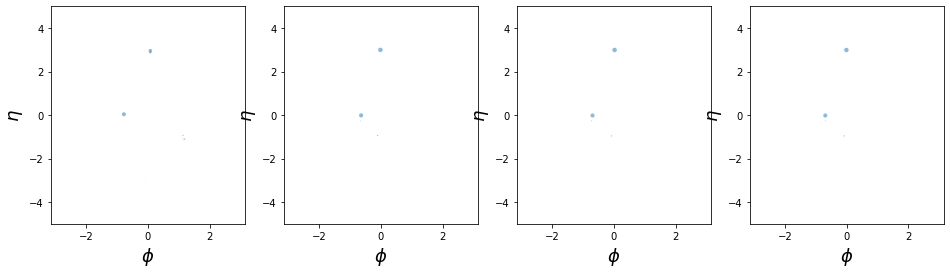

1.0 [1.0728721e-05 1.1278614e-01 1.9440929e-03]
[1.7836355e-18 7.7131093e-03 2.2198333e-11]
[2.0459001e-18 1.0538995e-03 6.1934374e-11]
[2.6785437e-19 7.5096104e-08 3.0465580e-10]


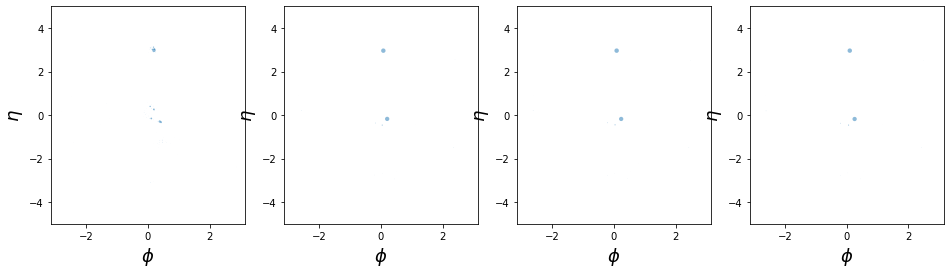

0.0 [1.5318161e-05 2.7105734e-01 1.8837661e-03]
[9.8579901e-19 9.9564850e-01 2.1181695e-13]
[3.5884381e-16 2.6881081e-01 1.0798199e-10]
[3.3717431e-14 1.0307431e-03 1.0360169e-07]


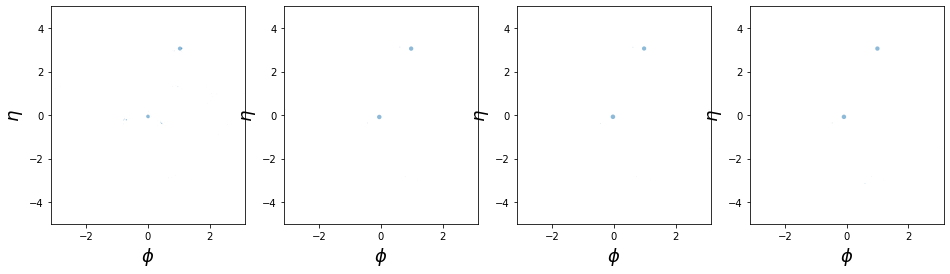

0.0 [1.5735379e-05 3.2226104e-02 1.0631095e-03]
[5.5742497e-17 1.8918514e-04 8.9036471e-14]
[6.2396047e-16 1.1957181e-06 9.6791802e-12]
[3.3296192e-15 1.2142688e-02 4.8109559e-12]


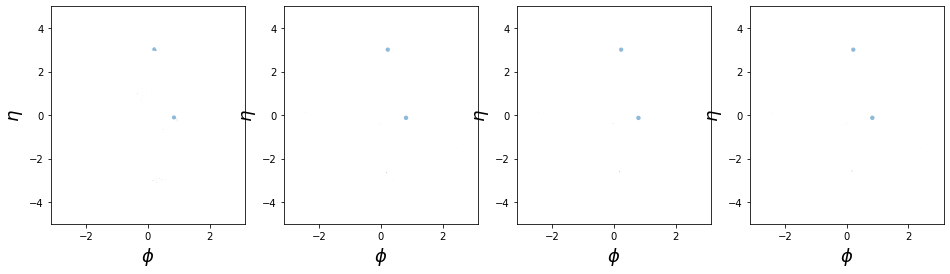

0.0 [1.6569817e-05 4.4501774e-02 8.5411966e-04]
[5.1864870e-16 2.5813588e-05 4.1294350e-11]
[8.2747423e-17 1.3869762e-02 6.5228593e-15]
[6.6731255e-19 4.5542793e-06 3.0020639e-12]


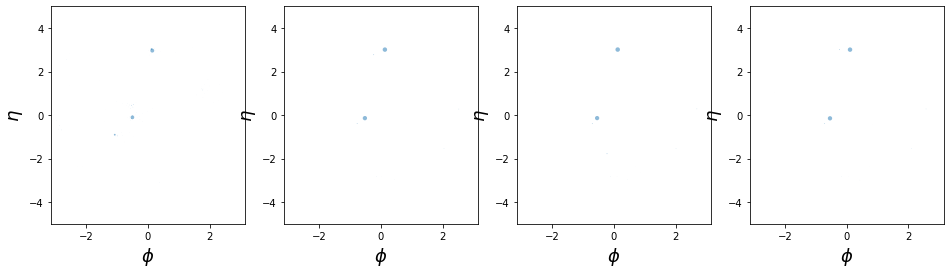

0.0 [1.6748625e-05 2.8225347e-01 1.4146790e-03]
[8.2912904e-19 4.6771193e-01 3.8817136e-09]
[2.4368263e-17 7.8418851e-04 2.3707747e-04]
[1.2495874e-21 4.5921422e-07 2.2150720e-10]


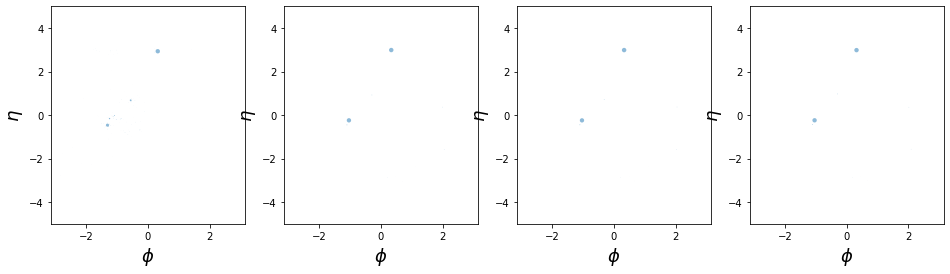

0.0 [1.8417497e-05 1.6487214e-01 1.4314991e-03]
[1.4568797e-15 1.9918978e-03 2.2126958e-09]
[2.6567563e-19 7.8180856e-05 3.3256373e-07]
[9.8944159e-20 8.2102792e-07 1.1419946e-11]


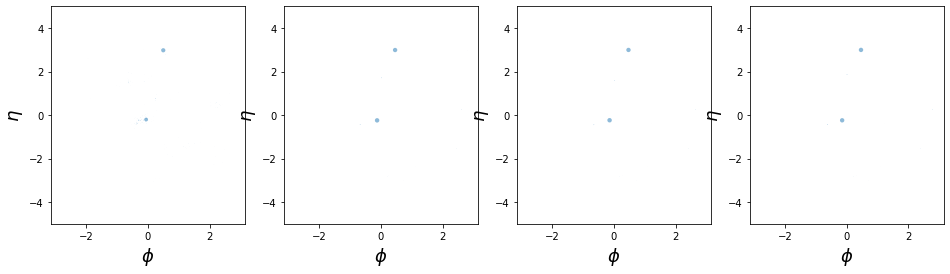

0.0 [2.2947263e-05 5.5399281e-01 4.3376656e-03]
[1.0289342e-13 9.9962711e-01 6.4411029e-07]
[2.7308980e-16 4.3686836e-09 2.2014078e-07]
[5.4015326e-13 5.6360960e-03 9.5467556e-10]


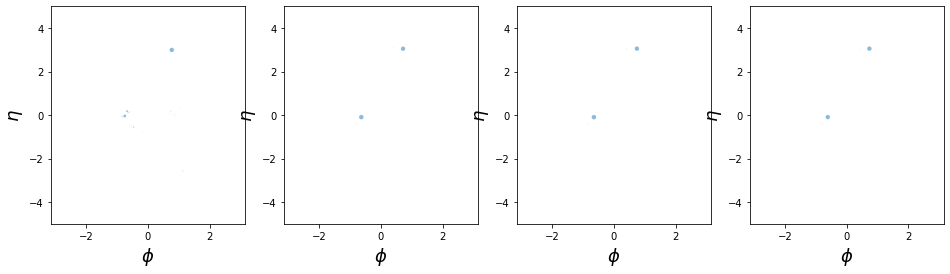

0.0 [2.8013399e-05 4.8294690e-02 1.8933264e-03]
[8.149030e-14 1.664295e-05 4.811069e-05]
[2.218048e-14 6.414652e-04 1.772475e-10]
[1.28817169e-14 1.10003352e-03 1.04048704e-04]


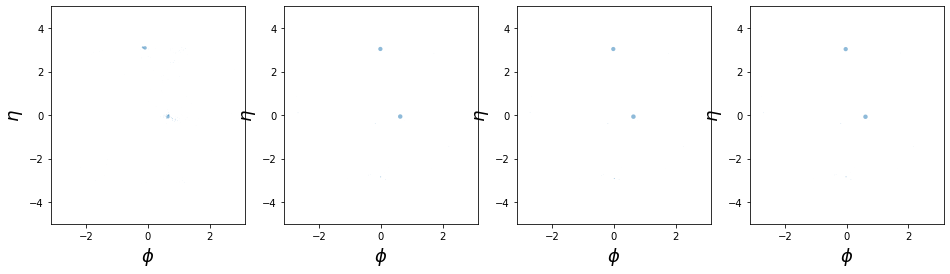

0.0 [2.8311402e-05 6.2989444e-01 1.5313073e-02]
[3.4048770e-14 2.4235785e-02 9.8558778e-01]
[1.2599596e-14 3.5373509e-02 1.6271601e-06]
[2.0585218e-16 5.8453369e-01 3.1196009e-07]


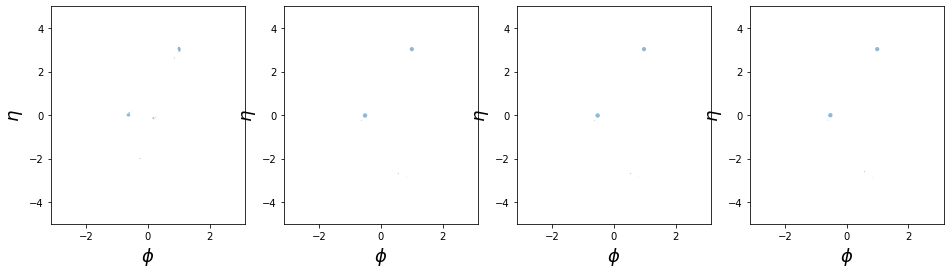

0.0 [3.0337846e-05 6.1179880e-02 3.8695820e-03]
[8.4594456e-09 2.0551879e-06 1.7329562e-09]
[1.29218122e-07 2.94300616e-01 1.15730345e-05]
[1.78219268e-19 2.27745568e-06 1.14481786e-07]


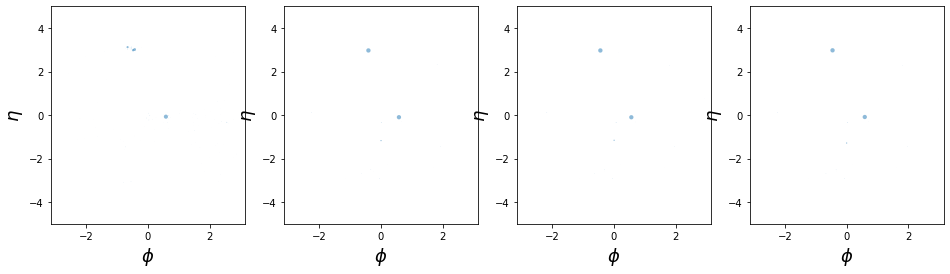

0.0 [3.5940306e-05 3.9669994e-01 1.2082505e-02]
[6.6300255e-16 3.5241159e-05 4.2955881e-07]
[6.9389030e-18 2.5240824e-01 2.3797764e-07]
[2.5712891e-17 9.9779814e-01 1.1799634e-03]


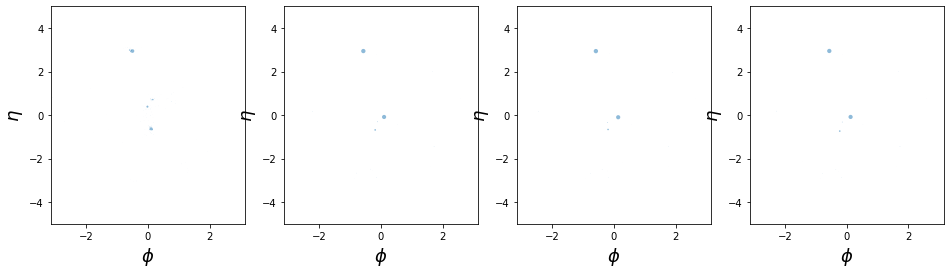

0.0 [3.647671e-05 7.035216e-02 3.065636e-03]
[6.2678473e-17 4.5839380e-07 1.5282631e-04]
[2.8137316e-15 1.2160540e-03 6.0778383e-08]
[3.3510503e-16 1.8439922e-01 3.3205476e-09]


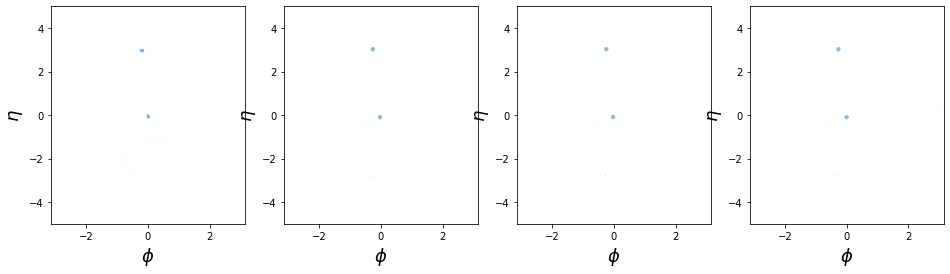

0.0 [4.1781113e-05 3.6830017e-01 4.9109091e-03]
[9.9607321e-19 6.7760473e-01 2.8521061e-11]
[6.9394695e-15 7.6252043e-02 2.8115860e-11]
[2.6232478e-14 4.3535829e-03 3.7409663e-03]


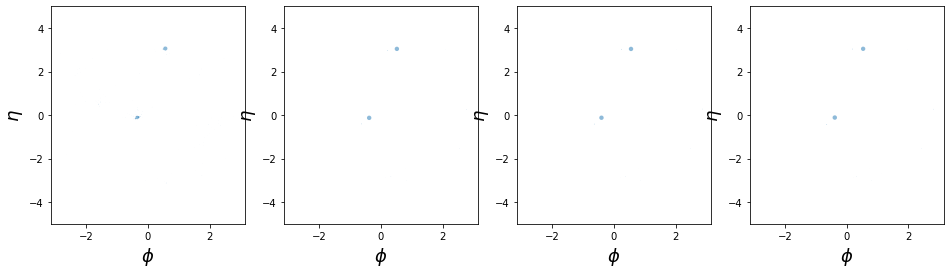

0.0 [4.4522683e-05 6.7905672e-02 1.6921093e-03]
[1.3256967e-12 7.6220436e-14 6.4769679e-10]
[9.319932e-14 9.498745e-03 5.582489e-08]
[4.7832138e-12 6.1007563e-07 3.8813987e-11]


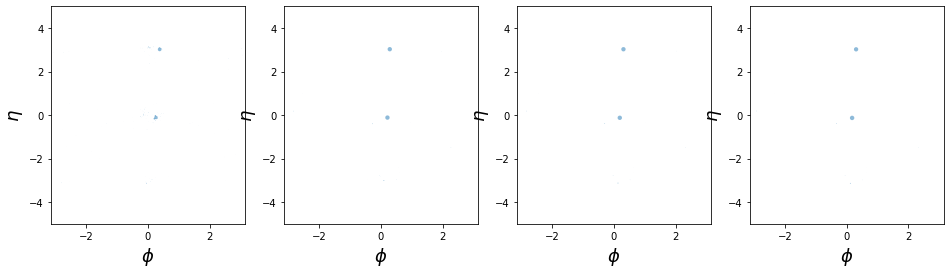

0.0 [5.5071658e-05 2.5678152e-01 3.7410446e-03]
[4.1048394e-15 2.7023846e-01 6.2084884e-09]
[3.3143491e-15 1.9109462e-05 3.3749153e-10]
[9.0335443e-19 4.1914582e-03 5.8180163e-08]


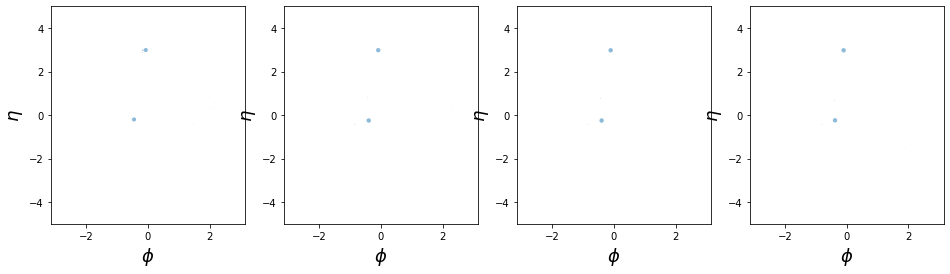

0.0 [6.4905253e-05 3.3120158e-01 1.2673711e-02]
[1.6942487e-14 1.2779236e-04 2.2914335e-08]
[8.8047264e-16 3.6616772e-01 5.5720244e-07]
[1.8420737e-10 9.9999976e-01 2.2062618e-06]


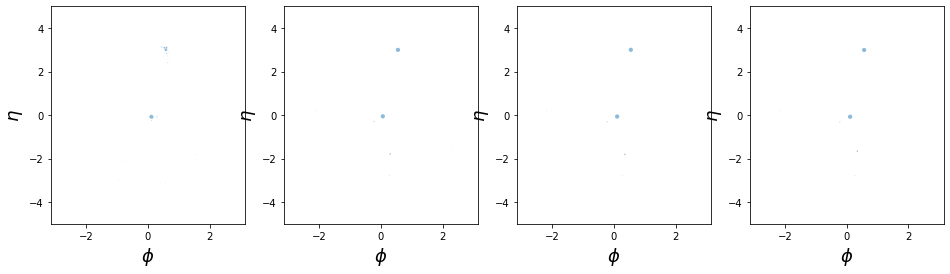

0.0 [6.5382024e-05 1.7153960e-01 6.1471527e-03]
[1.6388794e-19 5.9019923e-03 2.7448142e-09]
[6.9272768e-15 1.0737181e-03 6.6612569e-07]
[2.1135354e-14 4.4276793e-10 5.7448545e-07]


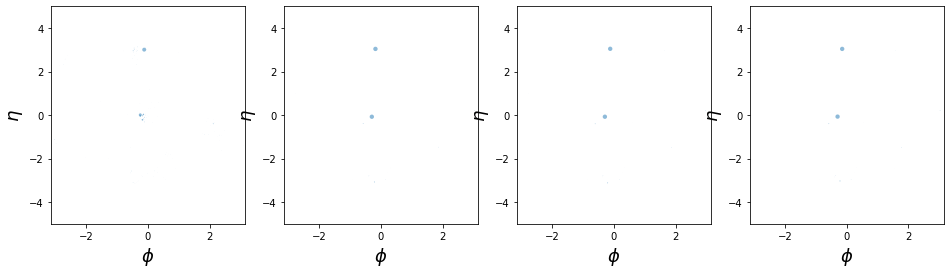

0.0 [6.8242662e-05 2.3631905e-01 1.0540087e-02]
[7.4340058e-16 1.5668005e-02 1.0007420e-06]
[4.5675662e-14 6.9966376e-02 4.2209029e-04]
[6.5257591e-11 8.2441449e-01 1.7696284e-07]


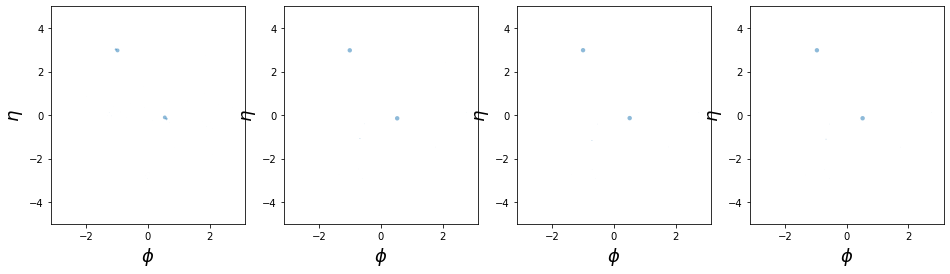

0.0 [6.8779031e-05 2.3915371e-01 6.6859117e-03]
[6.3744074e-15 4.9853712e-02 2.1158601e-07]
[2.8444796e-14 3.0133128e-04 2.8600256e-08]
[6.246741e-11 9.803823e-01 9.930241e-13]


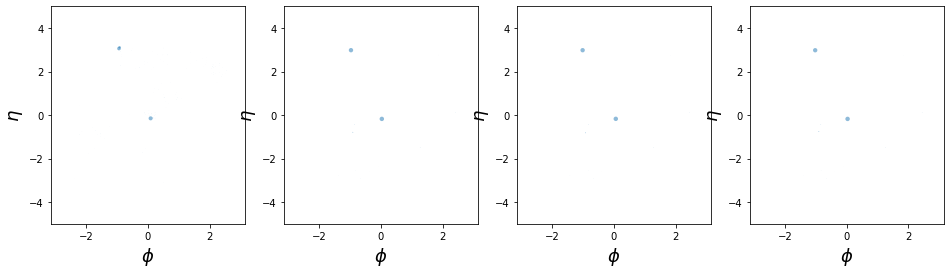

0.0 [7.4738637e-05 1.9270709e-01 1.0033075e-02]
[2.3479774e-14 9.9563110e-01 8.8053122e-07]
[2.5957809e-16 2.5832653e-04 1.2366297e-06]
[1.669898e-14 5.925600e-01 7.102807e-06]


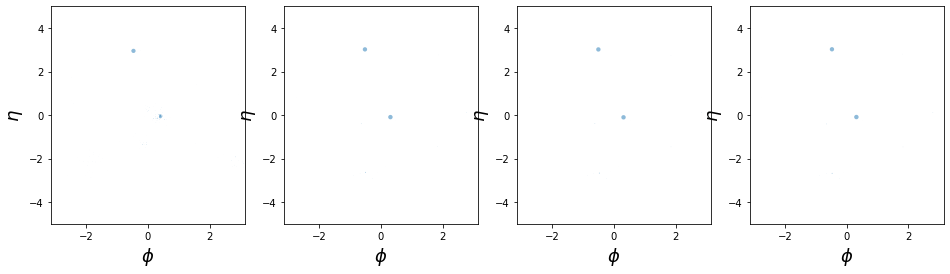

0.0 [7.6526507e-05 5.0530296e-02 3.6276227e-03]
[5.6948814e-13 1.7560528e-11 2.0174232e-10]
[6.5197494e-15 4.2533875e-04 4.5291642e-07]
[9.2596601e-20 5.6099185e-07 9.1708273e-07]


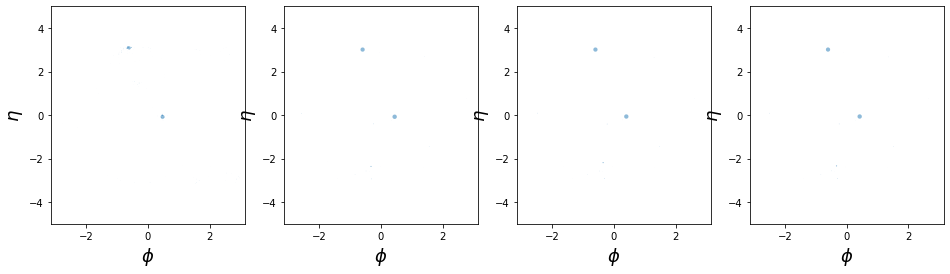

1.0 [7.95062733e-05 1.66056752e-01 1.18299695e-02]
[1.1442842e-18 1.5873671e-02 9.0846015e-08]
[1.9647915e-08 6.9858625e-06 4.3324694e-06]
[1.5491967e-15 5.9247911e-03 1.7563385e-01]


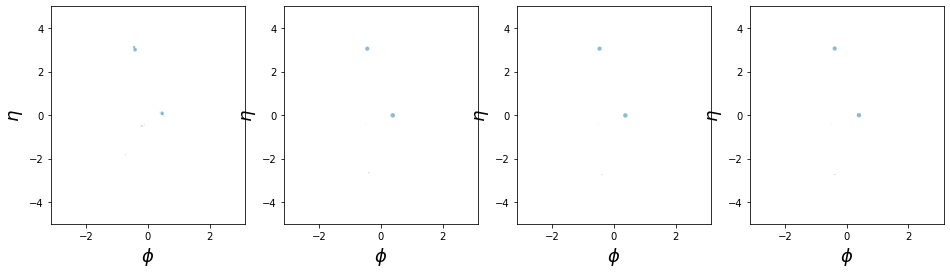

1.0 [8.2366831e-05 1.5227616e-01 8.6731268e-03]
[3.1372444e-15 1.2227297e-03 1.4460190e-06]
[1.1173253e-10 1.0812333e-07 1.2008711e-17]
[2.6265597e-16 2.3308427e-05 6.1573711e-11]


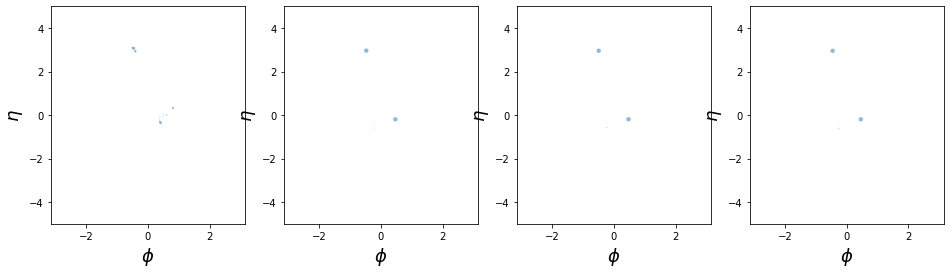

0.0 [8.7372777e-05 2.5933027e-01 8.5008265e-03]
[6.7649739e-15 9.1706502e-01 8.2695484e-04]
[2.2949323e-12 9.8868978e-01 5.0993707e-09]
[1.4792989e-13 8.8879853e-02 1.4605263e-07]


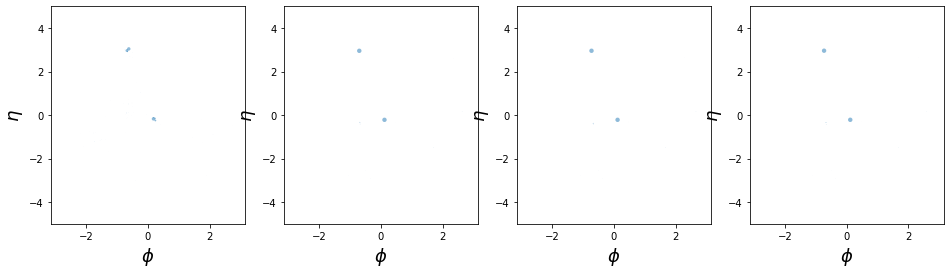

0.0 [8.737278e-05 8.579928e-02 5.117911e-03]
[1.56203619e-10 1.02066905e-11 1.26462812e-10]
[1.852518e-13 4.240811e-03 2.687887e-07]
[4.5843787e-13 1.2194743e-05 5.8220428e-09]


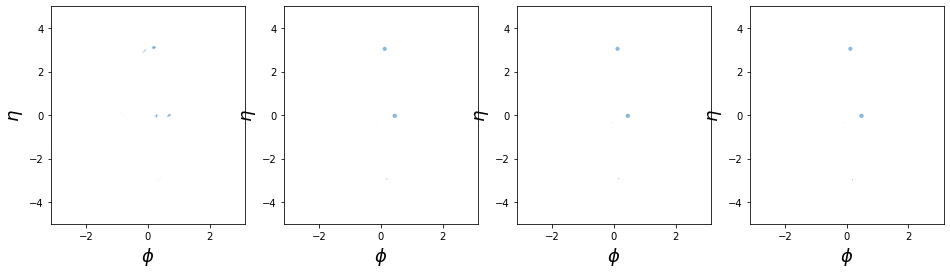

0.0 [8.8087902e-05 2.8517342e-01 1.2281184e-02]
[5.3739150e-15 9.6364164e-01 6.1687359e-08]
[1.6346729e-13 8.9634514e-01 1.9759027e-06]
[6.3918082e-14 9.9893820e-01 1.2623531e-10]


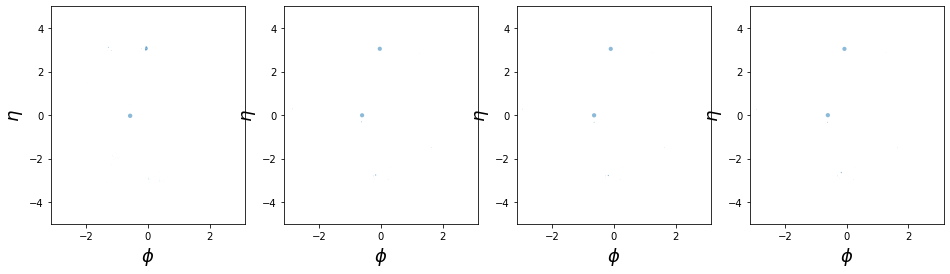

0.0 [1.0131763e-04 7.7718705e-01 3.4297675e-02]
[2.9465225e-11 9.9579036e-01 5.0630188e-05]
[8.5197458e-13 9.9999714e-01 1.8878877e-03]
[6.1591028e-17 9.9989676e-01 5.2459145e-06]


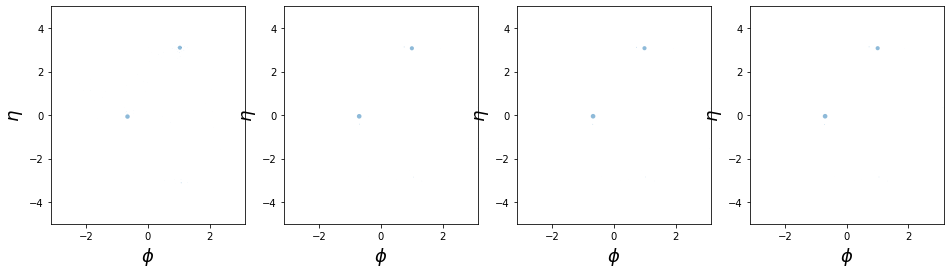

0.0 [1.0179437e-04 3.9123449e-01 7.2088712e-03]
[3.9114004e-15 4.9621165e-03 1.7345228e-10]
[1.3517484e-12 1.6947776e-02 6.0792008e-06]
[5.2682208e-13 1.7343581e-02 5.0081472e-09]


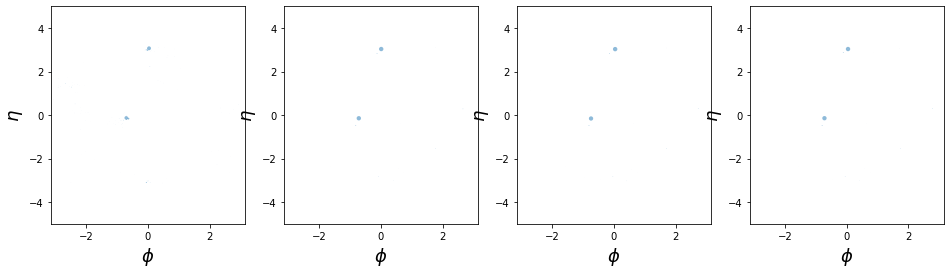

0.0 [1.0924339e-04 4.2040214e-01 1.2008678e-02]
[4.4708994e-14 5.9136355e-01 5.8819172e-08]
[2.7529788e-12 1.8785298e-02 3.2571859e-09]
[3.7988368e-13 2.3952603e-01 4.9147321e-08]


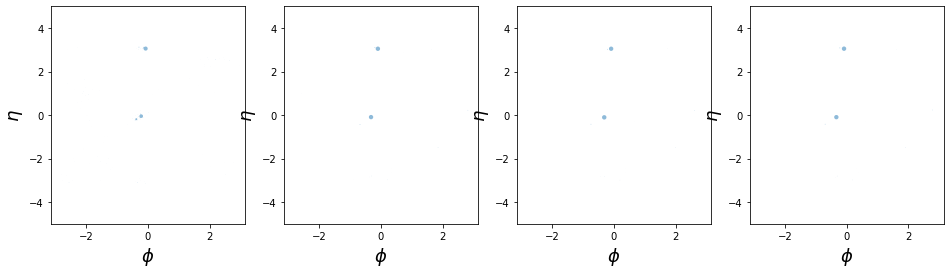

0.0 [1.1567924e-04 6.2078941e-01 2.5117500e-02]
[8.6562653e-11 4.7292417e-01 1.7712637e-06]
[3.3476899e-16 1.2253061e-01 1.5197694e-03]
[3.3357293e-18 9.9671459e-01 3.3673376e-02]


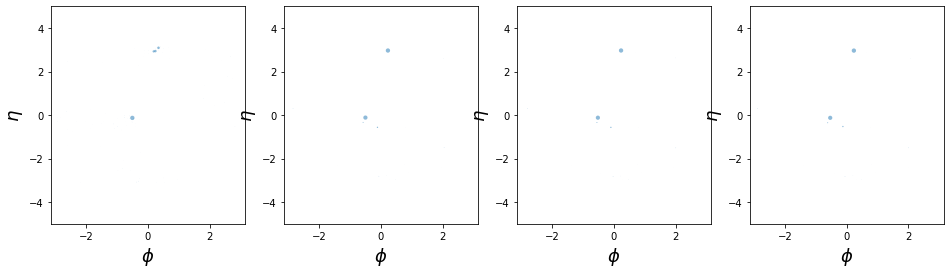

0.0 [1.3510547e-04 6.8222725e-01 2.6717102e-02]
[2.9173535e-11 9.9974871e-01 1.4655087e-05]
[7.058453e-18 6.906488e-01 2.121363e-06]
[4.9758155e-19 9.9998146e-01 7.1477018e-08]


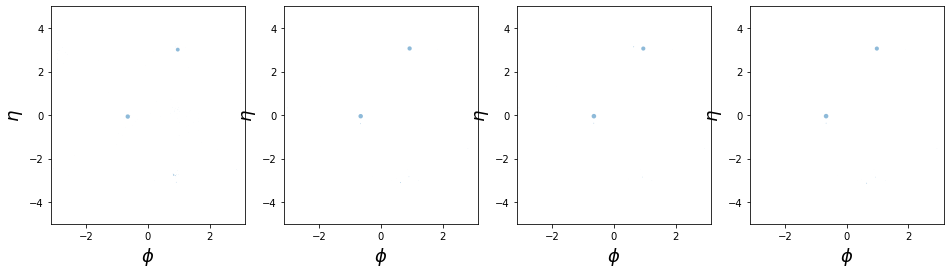

0.0 [1.690102e-04 6.856749e-01 3.124572e-02]
[2.5133828e-10 5.6662793e-05 1.0082284e-06]
[5.3116571e-13 1.1077812e-01 3.9049235e-05]
[4.079440e-12 9.418011e-03 3.034267e-08]


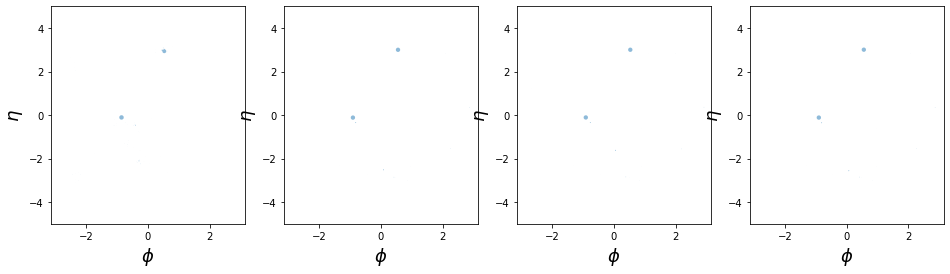

0.0 [0.00018283 0.1545524  0.01396784]
[2.05123418e-10 1.38141195e-05 5.36245359e-09]
[4.9372620e-12 1.7279506e-02 1.2913695e-05]
[3.3030653e-15 7.5131357e-03 3.1601508e-07]


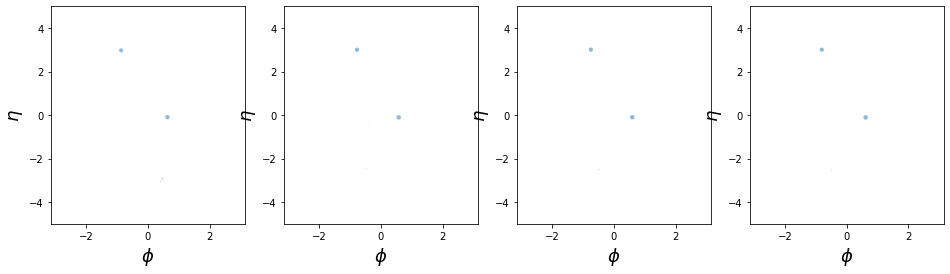

0.0 [1.9105598e-04 1.9828752e-01 1.2445661e-02]
[1.1754156e-10 9.8637307e-01 7.2312355e-04]
[2.40990387e-12 2.85300612e-03 1.03930274e-10]
[5.6411362e-11 9.3182415e-02 8.0159013e-10]


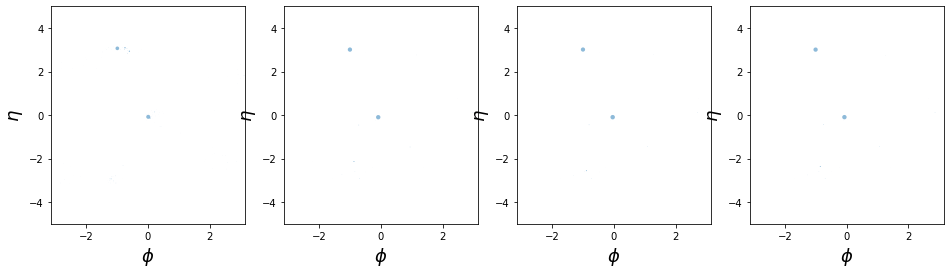

0.0 [2.1661594e-04 6.5418857e-01 3.1479765e-02]
[1.9884398e-13 2.2414327e-04 1.5621607e-07]
[5.6059094e-12 9.9990296e-01 1.1451405e-01]
[6.0517895e-15 9.9827409e-01 8.4668666e-02]


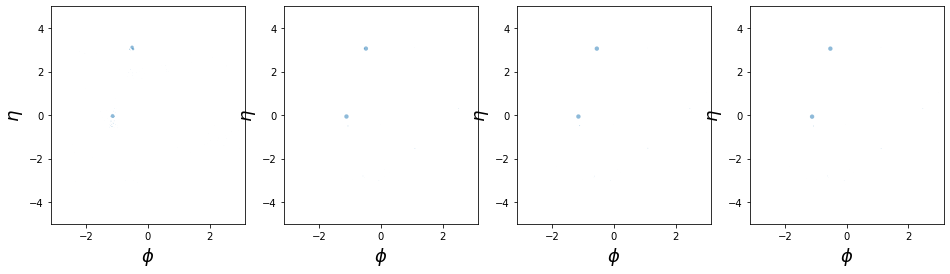

0.0 [2.4473635e-04 5.4150558e-01 1.5735069e-02]
[4.1003596e-13 2.1876752e-02 2.1340424e-01]
[2.2646885e-13 9.9723148e-01 2.5112457e-10]
[2.1192431e-04 2.8474809e-05 8.2200256e-07]


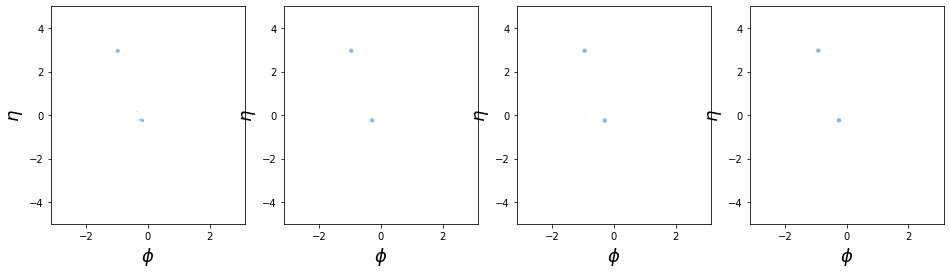

0.0 [2.5432793e-04 7.8934556e-01 8.0991149e-02]
[6.4184262e-11 5.1160305e-07 2.4205028e-07]
[6.9374948e-12 1.0919869e-03 8.4298063e-06]
[7.0805002e-14 2.5631664e-07 6.1261654e-04]


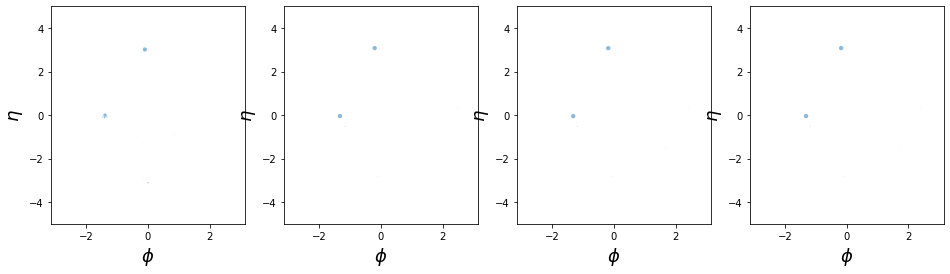

0.0 [2.9864925e-04 8.4623283e-01 1.9126189e-01]
[1.634517e-13 9.997041e-01 8.406913e-02]
[2.1322775e-15 9.9542379e-01 2.6990201e-05]
[2.4732334e-09 9.9342692e-01 3.7053525e-03]


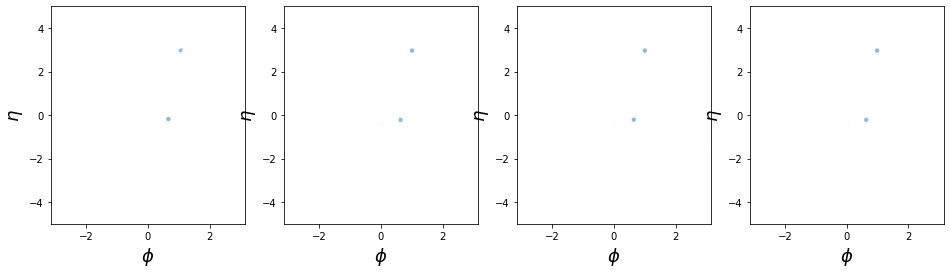

0.0 [3.2301244e-04 7.0647120e-01 5.8429122e-02]
[2.8708244e-16 1.7599493e-02 4.1966310e-08]
[1.2322348e-12 9.9970734e-01 2.3859739e-04]
[3.5329943e-23 9.9999523e-01 1.9175466e-06]


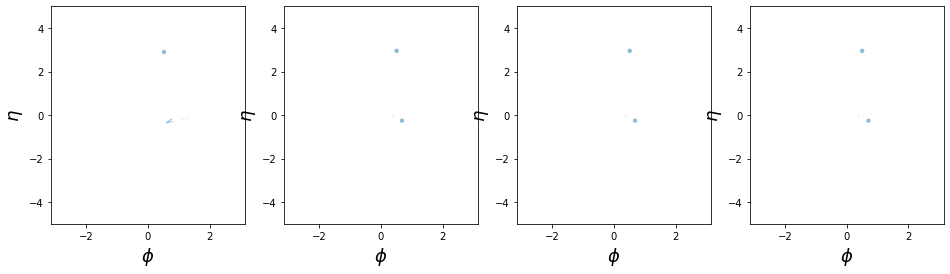

0.0 [3.4868476e-04 7.1048909e-01 6.0052708e-02]
[9.3335187e-15 4.1562122e-01 8.8882446e-04]
[4.2879321e-08 5.2072167e-01 3.6455036e-05]
[2.9857793e-11 2.4187627e-01 6.1731233e-09]


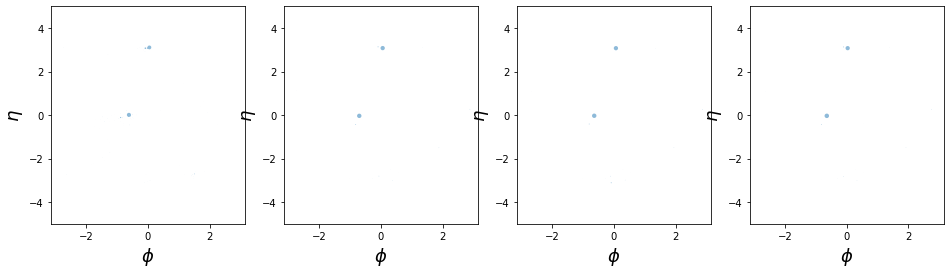

0.0 [0.000365   0.15772961 0.01236264]
[2.9427777e-10 5.4457784e-03 3.8986899e-13]
[4.7110377e-14 7.7437043e-01 9.9079662e-05]
[1.5755584e-06 2.0990729e-02 3.2913562e-07]


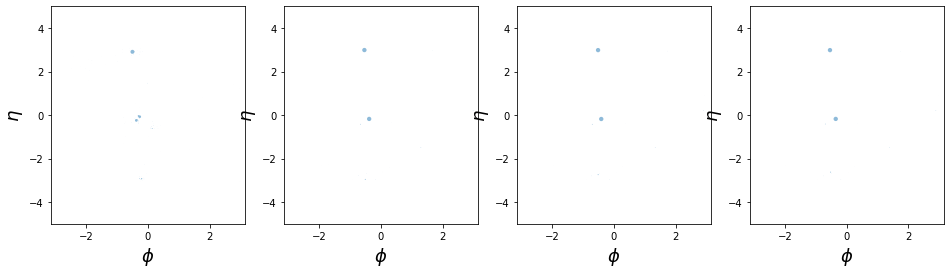

0.0 [0.0004298  0.2356216  0.02454672]
[7.9800028e-11 1.6108453e-03 3.5216264e-05]
[1.0536176e-10 1.4326921e-01 3.9373636e-03]
[4.7689027e-12 2.2937006e-01 7.8601779e-08]


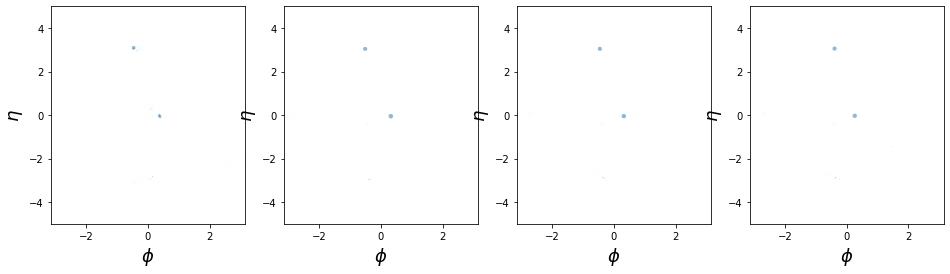

1.0 [4.3349538e-04 5.0071084e-01 3.1741414e-02]
[6.0349267e-11 9.6685529e-01 4.0508166e-05]
[7.6253996e-11 3.6910474e-03 1.3014674e-04]
[6.8129905e-22 4.5356154e-04 1.5551162e-01]


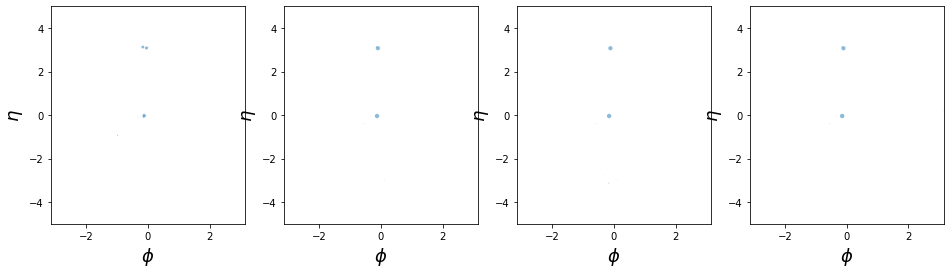

0.0 [4.7482346e-04 5.9814256e-01 4.6304323e-02]
[1.8365010e-12 5.7797790e-01 1.4009774e-03]
[1.9177080e-15 9.9456805e-01 8.3905756e-03]
[1.3410600e-16 9.9995536e-01 9.2708375e-05]


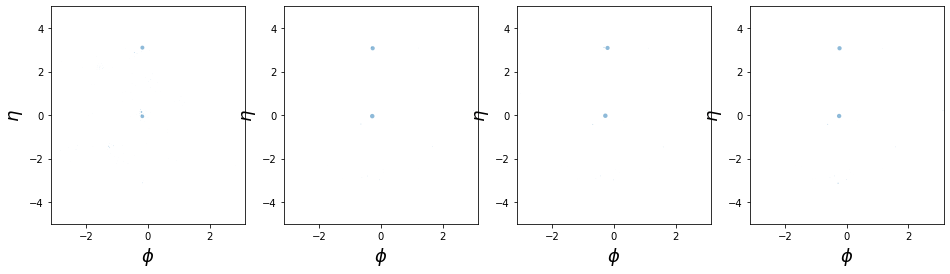

0.0 [5.4085784e-04 7.1892548e-01 6.4929619e-02]
[3.8503067e-10 4.3898821e-04 3.3325079e-05]
[3.6616357e-09 9.0458363e-01 6.2495261e-02]
[1.87389268e-14 9.91264343e-01 1.32761825e-05]


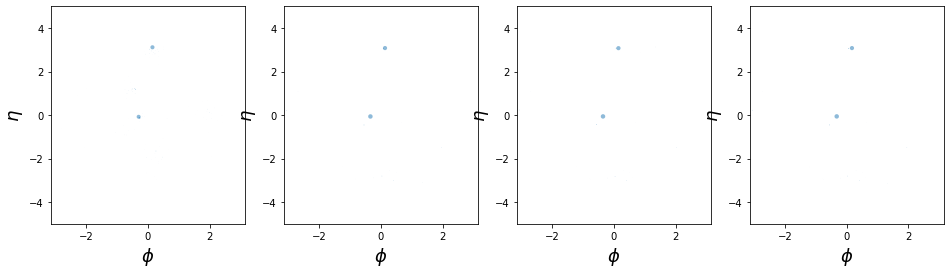

0.0 [0.00073641 0.70164794 0.11707599]
[1.4268435e-08 8.3328897e-01 3.6038756e-03]
[5.0623300e-10 6.8671435e-01 7.1880221e-04]
[4.3158993e-10 9.8807615e-01 8.7322688e-01]


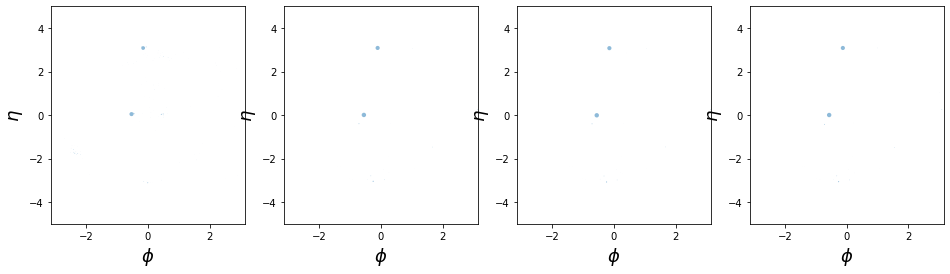

0.0 [0.00082496 0.72058755 0.11983808]
[1.4321002e-08 1.3937888e-01 4.8359525e-01]
[1.5320248e-07 9.0396702e-03 7.9805464e-02]
[9.1602072e-07 4.2722338e-01 6.2936083e-06]


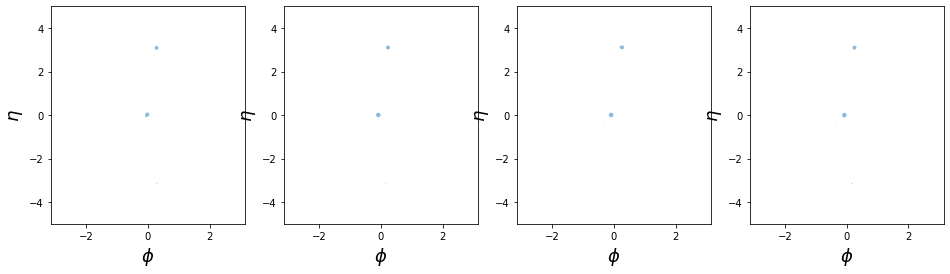

0.0 [0.00085531 0.7470618  0.15327841]
[2.7083340e-12 3.1338930e-02 5.1092924e-05]
[1.9360353e-12 2.0679533e-03 8.9376247e-01]
[9.2442837e-10 5.5750030e-01 1.2366325e-02]


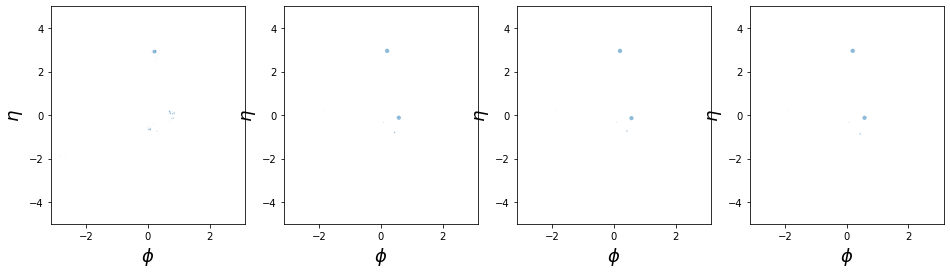

0.0 [0.00087048 0.84360325 0.14589305]
[2.4298301e-11 9.9850613e-01 6.6933751e-02]
[1.9792433e-11 9.9999475e-01 3.2004714e-04]
[2.1753808e-09 9.9773514e-01 4.2029700e-01]


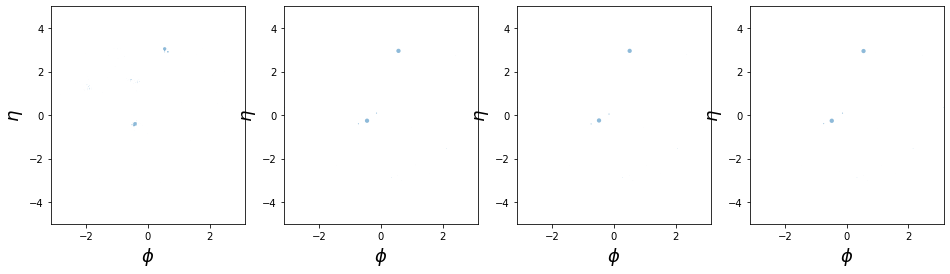

In [22]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in bernsort[:50]:   

    fig, ax = plt.subplots(1, 4,figsize=[16,4])

    print(valid_labels[i], p_bern[i][[6,10,15]])

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, phis, etas = get_clustered_pt_phi_eta(weights, outjet,R=0.02)
    ax[0].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
    

    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    for j in range(3):
        outjet = outs_array[j][0][i,:,1:]
        weights = outs_array[j][0][i,:,0]
        pred_labels = outs_array[j][-1][i]
        print(pred_labels[[6,10,15]])
        pts, phis, etas = get_clustered_pt_phi_eta(weights, outjet,R=0.02)
        ax[j+1].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
#         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
#         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(4):
        ax[j].set_ylabel(r'$\eta$',fontsize=18)
        ax[j].set_xlabel(r'$\phi$',fontsize=18)
        ax[j].set_ylim([-etalim,etalim])
        ax[j].set_xlim([-np.pi,np.pi])
    
    plt.show()

In [129]:
this[2]

NameError: name 'this' is not defined

In [57]:
history = vae.fit(x=train_x[:200], y=train_y[:200], batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = (valid_x[:200],valid_y[:200]),
                callbacks = callbacks
              )

Epoch 1/5
2/2 [==============================] - 0s 40ms/step - loss: -1.5820 - val_loss: 1.4060
Epoch 2/5
2/2 [==============================] - 0s 40ms/step - loss: 1.6568 - val_loss: -3.0890
Epoch 3/5
2/2 [==============================] - 0s 42ms/step - loss: 0.7661 - val_loss: 1.3552
Epoch 4/5
2/2 [==============================] - 0s 39ms/step - loss: 1.7170 - val_loss: 1.5426
Epoch 5/5
2/2 [==============================] - 0s 41ms/step - loss: 1.5745 - val_loss: 1.6897


In [54]:
history.

[2, 3]

In [31]:
valid_y.shape

(78680, 100, 3)

In [34]:
valid_x.shape

(78680, 100, 4)

In [23]:
# https://arxiv.org/pdf/1611.00712.pdf

encoder_conv_layers = [256,256,256,256]
dense_size = 256
decoder = [512,256,256,256]
verbose=0
dropout=0
latent_dim = 128
optimizer=keras.optimizers.Adam()
num_particles_out = 50
sinkhorn_reg = 0.01
numItermax = 20
stopThr=1e-3
adaptive_min = 0.01

temp = 0.3
EPSILON = 1e-6
#renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
renorm_clipping = None
momentum = 0.999

def sampling_gauss(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def sampling_bern(theta):

    batch = K.shape(theta)[0]
    dim = K.int_shape(theta)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
    #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
    return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp

num_particles = 700

cat_dim = 2

#Encoder
inputs = tf.keras.Input(shape=(num_particles,3,), name='inputs')
beta_input = tf.keras.Input(shape=(1,), name='beta_input')
alpha_input = tf.keras.Input(shape=(1,), name='alpha_input')
#     layer = inputs
#layer = tf.keras.layers.Concatenate()([inputs,beta_input,alpha_input])
#layer = Lambda(lambda x: x[:,:real_dim])(layer)

layer = inputs

for layer_size in encoder_conv_layers:
    layer = Conv1D(layer_size,1,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)

# Sum layer
layer = tf.keras.backend.sum(layer,axis=1)

# Dense layers 1
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)

# Cat latent
alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
alpha_bern = keras.layers.ELU()(alpha_bern)
alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
z_bern_sigmoid = Activation('sigmoid')(z_bern)

layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])

# Dense layers 2
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
    
z_mean = Dense(latent_dim, name='z_mean')(layer)
z_log_var = Dense(latent_dim, name='z_log_var')(layer)
z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs,beta_input,alpha_input], [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid], name='encoder')
if verbose:
    encoder.summary()
#plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

# Decoder
latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
#layer = latent_inputs

for i, layer_size in enumerate(decoder):
    layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)
print(layer)            
layer = Dense(num_particles_out*4)(layer)
print(layer)

layer = Reshape((num_particles_out,4))(layer)
print(layer)
layer_pT = layer[:,:,0:1]
print(layer_pT)
layer_pT = tf.keras.layers.Softmax()(layer_pT)
layer_eta = layer[:,:,1:2]
layer_phi = tf.math.atan2(layer[:,:,3],layer[:,:,2])
layer_phi = tf.expand_dims(layer_phi,axis=-1)
decoded = tf.keras.layers.Concatenate()([layer_pT,layer_eta,layer_phi])
print(decoded)


decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
if verbose:
    decoder.summary()
#plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)



Tensor("re_lu_59/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dense_44/Identity:0", shape=(None, 200), dtype=float32)
Tensor("reshape_4/Identity:0", shape=(None, 50, 4), dtype=float32)
Tensor("strided_slice_16:0", shape=(None, 50, 1), dtype=float32)
Tensor("concatenate_14/Identity:0", shape=(None, 50, 3), dtype=float32)


In [96]:
decoded 

<tf.Tensor 'concatenate_23/Identity:0' shape=(None, 50, 3) dtype=float32>

In [94]:
layer_pT

<tf.Tensor 'softmax_2/Identity:0' shape=(None, 50, 1) dtype=float32>

In [95]:
layer_eta

<tf.Tensor 'strided_slice_24:0' shape=(None, 50, 1) dtype=float32>

In [16]:
tf.linalg.tr

<tf.Tensor 'inputs_2:0' shape=(None, 100, 700, 3) dtype=float32>

In [20]:
tf.shape(pointsa)[-2]

<tf.Tensor 'strided_slice_2:0' shape=() dtype=int32>

In [6]:
pointsb = inputs[:,:,1:]
pointsa = outputs[:,:,1:]

a_dim = pointsa.shape[-2]
b_dim = pointsb.shape[-2]

In [7]:
amat = tf.tile(tf.expand_dims(pointsa,2),[1,1,b_dim,1])
bmat = tf.tile(tf.expand_dims(pointsb,1),[1,a_dim,1,1])

In [9]:
bmat

<tf.Tensor 'Tile_1:0' shape=(None, 50, 700, 2) dtype=float32>

In [10]:
diffmat = bmat - amat

In [11]:
diffmat

<tf.Tensor 'sub:0' shape=(None, 50, 700, 2) dtype=float32>

In [7]:
experiment_name = '2D_banana'
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1))



ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, None, 50, 3), (None, 50, 3)]

In [15]:
Reshape

tensorflow.python.keras.layers.core.Reshape

In [71]:
# You are welcome to load a pretrained model
vae.load_weights('mymodel_weights.h5')

ValueError: Shapes (512, 256) and (512,) are incompatible

In [108]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [#modelcheckpoint,
             reduceLR,earlystop]

beta = 1e-1
alpha = 1.0

K.set_value(vae.optimizer.lr,1e-5)
epochs = 1000
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta,np.ones(len(train_data))*alpha], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta,np.ones(len(valid_data))*alpha],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 1000000 samples, validate on 100000 samples
Epoch 1/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.4467 - recon_loss: 0.0118 - get_kl_loss: 3.9512 - get_kl_loss_bern: 0.3162 - val_loss: 5.4089 - val_recon_loss: 0.0109 - val_get_kl_loss: 3.9862 - val_get_kl_loss_bern: 0.3280
Epoch 2/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3745 - recon_loss: 0.0104 - get_kl_loss: 4.0093 - get_kl_loss_bern: 0.3299 - val_loss: 5.3612 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9984 - val_get_kl_loss_bern: 0.3310
Epoch 3/1000
1000000/1000000 [==============================] - 46s 46us/sample - loss: 5.3662 - recon_loss: 0.0102 - get_kl_loss: 4.0106 - get_kl_loss_bern: 0.3314 - val_loss: 5.3478 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9904 - val_get_kl_loss_bern: 0.3312
Epoch 4/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3595 - recon_loss: 0.0101 - get_kl_loss: 4.0123 - get_kl_lo

In [109]:
vae.save_weights('mymodel_weights_2.h5')

Latent space encoding for beta = 0.18 :


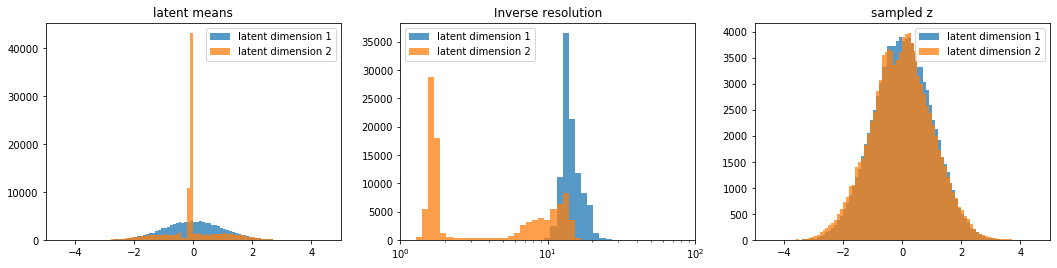

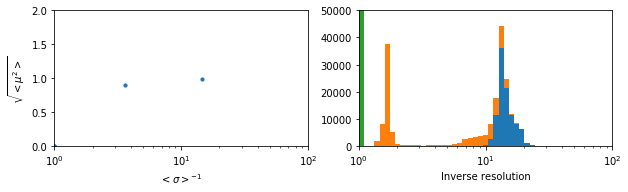

[0.35532367 0.501202  ]
[0.96436054 0.02042921]
categories =  [1, 1]


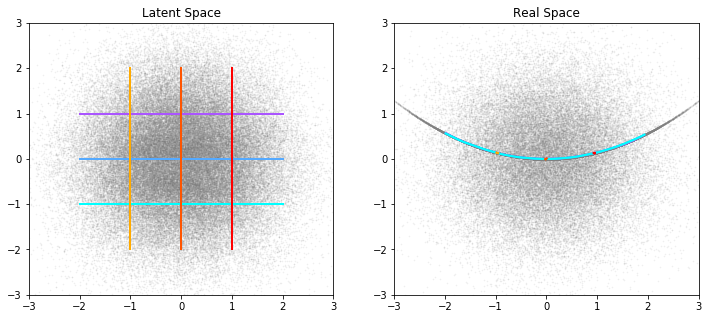

categories =  [1, 0]


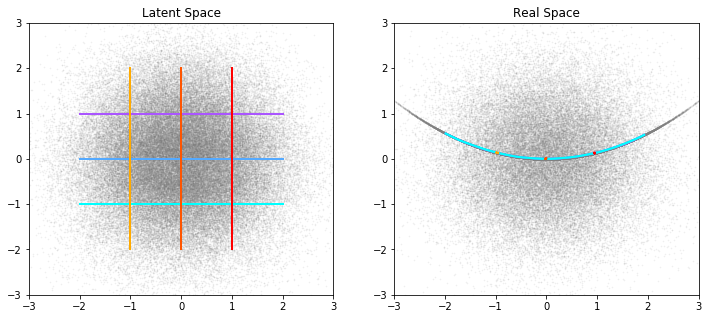

categories =  [0, 0]


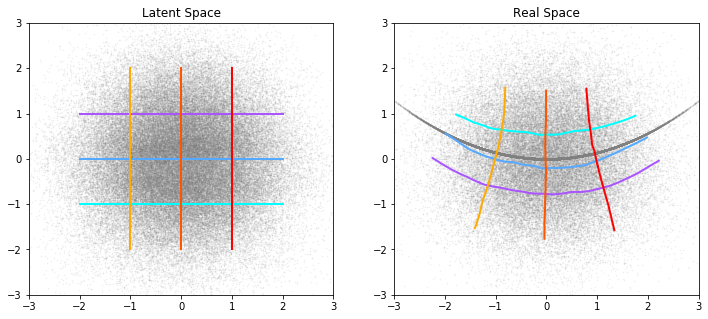

categories =  [0, 1]


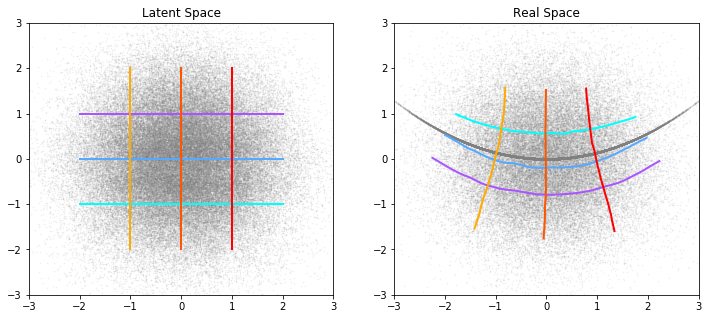

In [143]:
vae.load_weights('mymodel_weights_2.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

for cats in [[1,1],[1,0],[0,0],[0,1]]:
    print("categories = ", cats)
    plot_latent_map(myencoder, decoder, valid_data,
                    cats,
                        scales = np.array([[-2,2],[-2,2]]),
                        values = np.array([[1,0,-1],[1,0,-1]]),
                        latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [1,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,1],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

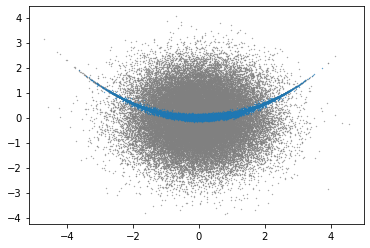

In [121]:
banana_ids = np.where(sig[:,0] > 0.5)
not_banana_ids = np.where(sig[:,0] <= 0.5)
banana = valid_data[banana_ids]
not_banana = valid_data[not_banana_ids]
plt.scatter(not_banana[:,0],not_banana[:,1],s=0.1,color='gray')
plt.scatter(banana[:,0],banana[:,1],s=0.1)

Latent space encoding for beta = 0.18 :


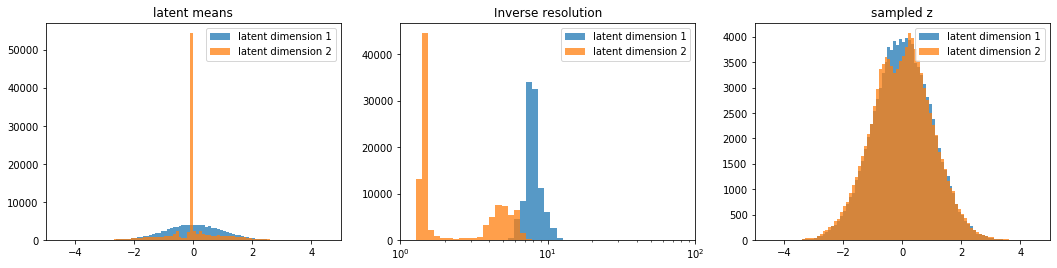

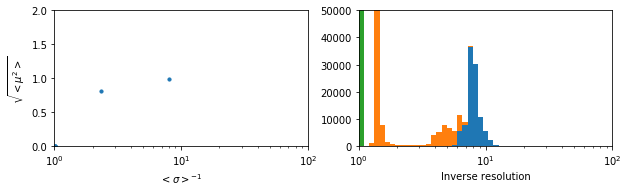

[0.38904503 0.50221467]
[0.9156216  0.01675496]


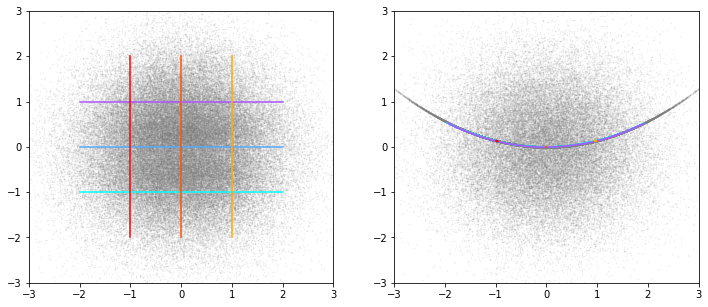

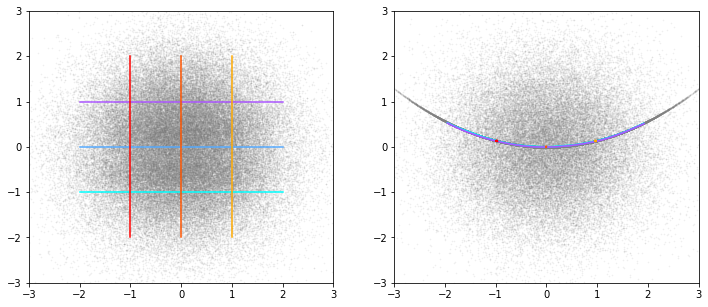

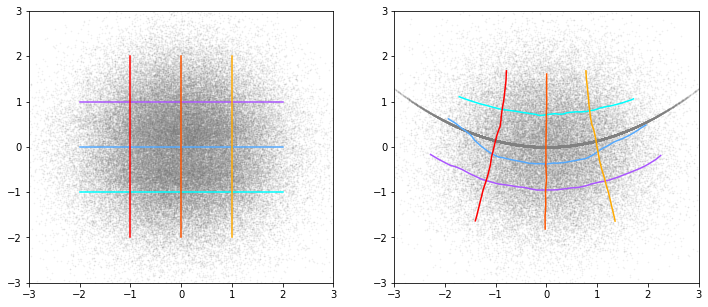

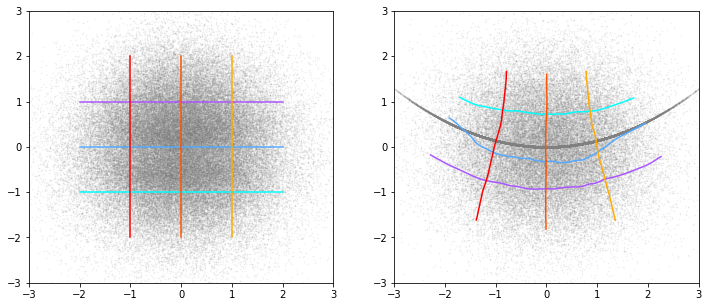

In [107]:
vae.load_weights('mymodel_weights_1.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

Latent space encoding for beta = 0.3 :


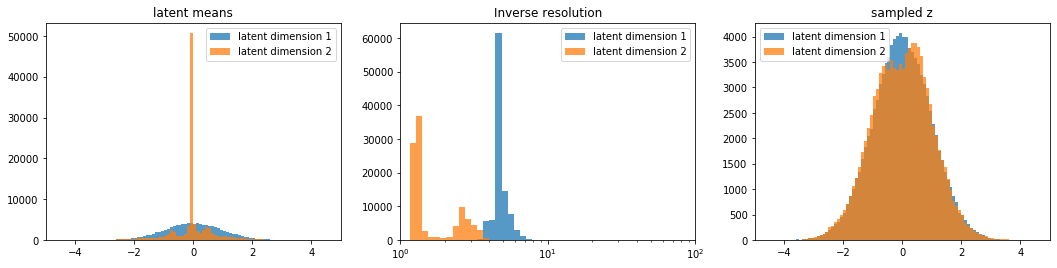

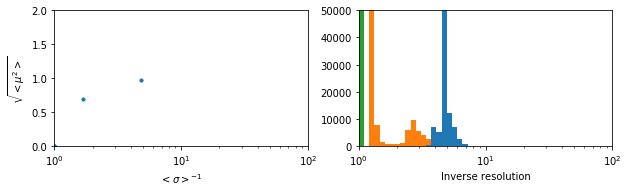

[0.4239141 0.5006592]
[0.8254102  0.02957428]


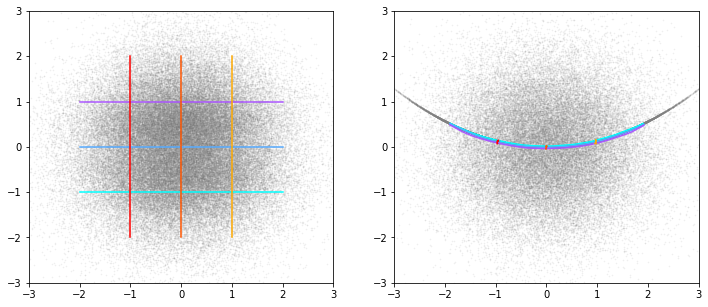

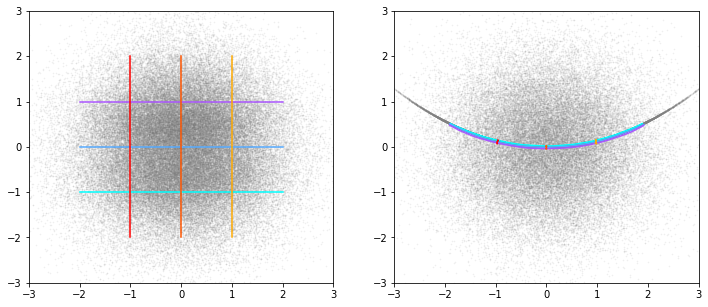

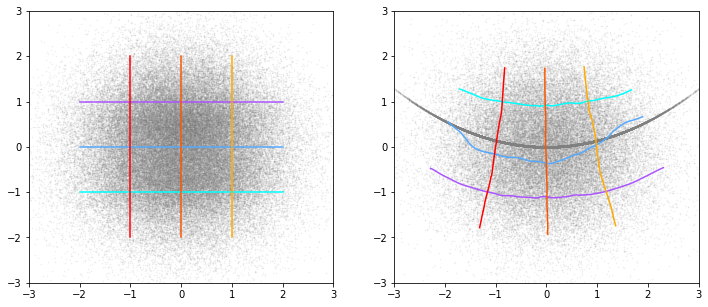

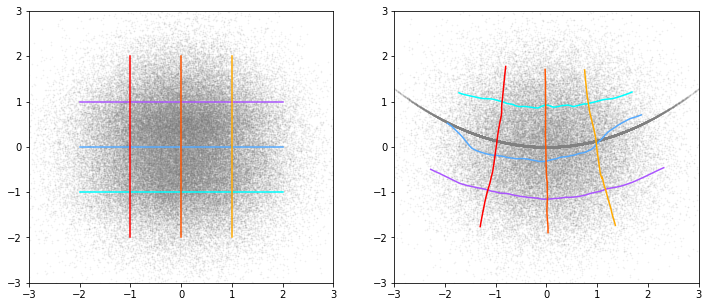

In [102]:
vae.load_weights('mymodel_weights_0.h5')
beta = 0.3

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])